In [2]:
import heartpy as hp
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal,stats
import logging
from tqdm import tqdm,trange
import os
import glob
from sklearn.preprocessing import MinMaxScaler, scale, robust_scale,RobustScaler
import scipy

In [3]:
def plot_hist(test,p=(0.5,99.5),lines=True):
    plt.figure()
    median = np.median(test)
    avg = np.average(test)
    std = np.std(test)
    p0 = np.percentile(test, p[0])
    p1 = np.percentile(test, p[1])
    plt.hist(test,bins=100)
    if lines:
        plt.axvline(median,c='orange')
        plt.axvline(avg,c='red')
        plt.axvline(p0,c='black')
        plt.axvline(p1,c='black')
    plt.title(f"median:{median:.3f}, average:{avg:.3f}, std:{std:.3f},\n min:{np.nanmin(test):.3f}, max:{np.nanmax(test):.3f},\n{p[0]:2.1f}%: {p0:.3f}, {p[1]:2.1f}%:{p1:.3f}")

In [4]:
def detect_flat(sig,window,t_flat):
    sig = sig.T
    len_data = sig.shape[1]
    flat_locs_abp = np.ones((len_data - window+1,), dtype=int)
    flat_locs_ppg = np.ones((len_data - window+1,), dtype=int)
    # print(flat_locs_abp.shape)
    # Get the locations where i == i+1 == i+2 ... == i+window
    # efficient-ish sliding window
    # print(data[1, :len_data - window].shape,data[1, 0:len_data - window + 0].shape)
    for i in range(1, window):
        # print(data[1, :len_data - window+1].shape, data[1, i:len_data - window + i+1].shape)
        tmp_abp = (sig[0, :len_data - window+1] == sig[0, i:len_data - window + i+1])
        tmp_ppg = (sig[1, :len_data - window+1] == sig[1, i:len_data - window + i+1])
        flat_locs_abp = (flat_locs_abp & tmp_abp)
        flat_locs_ppg = (flat_locs_ppg & tmp_ppg)
        # print(tmp_abp.shape,tmp_ppg.shape)
        # Extend to be the same size as data
    flat_locs_ppg = np.concatenate((flat_locs_ppg, np.zeros((window - 1,), dtype=bool)))
    flat_locs_abp = np.concatenate((flat_locs_abp, np.zeros((window - 1,), dtype=bool)))
    # print(flat_locs_abp.shape,flat_locs_ppg.shape)
    flat_locs_ppg2 = flat_locs_ppg.copy()
    flat_locs_abp2 = flat_locs_abp.copy()
    # print(flat_locs_abp2.shape,flat_locs_ppg2.shape)
        
    # Mark the ends of the window
    for i in range(1, window):
        flat_locs_abp[i:] = flat_locs_abp[i:] | flat_locs_abp2[:len_data-i]
        flat_locs_ppg[i:] = flat_locs_ppg[i:] | flat_locs_ppg2[:len_data-i]
        
    # Percentages
    per_abp = np.sum(flat_locs_abp) / len_data
    per_ppg = np.sum(flat_locs_ppg) / len_data
    if per_abp > t_flat or per_ppg > t_flat:
        logging.info(f"invalid because of flat lines: {per_ppg}, {per_abp},{np.sum(flat_locs_abp)},{np.sum(flat_locs_ppg)},{np.nanmax(flat_locs_abp)},{np.nanmax(flat_locs_ppg)}")
        return True,None,None
    else:
        return False,flat_locs_ppg,flat_locs_abp
    
def fill_rejected_valleys(sig,v):
    diff_v= np.diff(v)
    # [0,1,1,0,0,1,1,0,0]
    # [ 1,  0, -1,  0,  1,  0, -1,  0]
    old = 0
    old_i = -1
    for i,b in enumerate(diff_v):
        if b:
            if old_i < 0 and b > 0:
                sig[:v[i+1],:]=np.nan
            elif b > 0:
                sig[v[i]:v[old_i+1],:]=np.nan
            old = b
            old_i = i
    if old < 0:
        sig[:v[old_i+1],:]=np.nan

def hampel(vals_orig, k=11, t0=3):
    '''
    vals: pandas series of values from which to remove outliers
    k: size of window (including the sample; 7 is equal to 3 on either side of value)
    '''
    
    #Make copy so original not edited
    vals = vals_orig.copy()[(k-1)//2:-(k-1)//2]
    # print(vals.shape)
    #Hampel Filter
    L = 1.4826
    rolling_window = lambda x: np.lib.stride_tricks.sliding_window_view(x,k)
    rolling_median = np.median(rolling_window(vals_orig),axis=1)
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_MAD = MAD(rolling_window(vals_orig))
    threshold = t0 * L * rolling_MAD
    difference = np.abs(vals - rolling_median)
    
    '''
    Perhaps a condition should be added here in the case that the threshold value
    is 0.0; maybe do not mark as outlier. MAD may be 0.0 without the original values
    being equal. See differences between MAD vs SDV.
    '''
    
    outlier_idx = difference > threshold
    vals[outlier_idx] = rolling_median[outlier_idx] 
    return vals,outlier_idx
def hampel_peaks(sig,peaks,k=11):
    a = sig[peaks]
    if len(peaks) < k:
        # print(f"### peaks:{len(valid_peak_locs)}, k:{k}, len:{len(sig)}")
        return None
    # a.shape,len(wd['peaklist']),valid_peak_locs
    
    _,i = hampel(a,k=k)
    offset = (k//2)
    loc = peaks[np.where(i)[0]+offset]
    return loc

In [5]:
def butterworth(sig,N=4,btype='bandpass',Wn=[0.5,8],fs=125):
    sos = signal.butter(N,Wn,btype,fs=fs,output='sos')
    return signal.sosfiltfilt(sos,sig)

def chebyshev2(x,order=4,rs=40,Wn=[0.5,15]):
    fs = 125
    filter = signal.cheby2(N=order, Wn=Wn,rs=rs,btype='bandpass',output='sos',fs=fs)
    return signal.sosfiltfilt(filter,x)

### flat

In [45]:
def flat(sig,
         plot=False,
         filter=True,
         xfrom=0,
         xlen=100000,
         align_signal=False):
    if sig is None:
        print("sig is none")
        return None,None
    w_flat = 15    # flat lines window
    w_peaks = 3    # flat peaks window
    w_fix = 15     # flat join window
    w_corr = 500
    t_nan = 125 * 120
    # thresholds
    t_peaks = 0.05 # percentage of tolerated flat peaks
    t_flat = 0.1  # percentage of tolerated flat lines
    t_corr = 0.8

    if plot:
        sig_processed = sig.copy()
    # 0 nanでorをとる
    nan_mask = np.isnan(sig[:,0]) | np.isnan(sig[:,1])
    s = np.sum(~nan_mask)
    if  s < t_nan:
        # logging.info(f"invalid because of short valid signal: {s}")
        # print(f"invalid because of short valid signal: {s}")
        return None,None
    sig = sig[~nan_mask]
    # ppg normalize
    if (sig[:,1]>1).any():
        sig[:,1] /= 4 
    # ppg filter
    if filter: 
        sig[:,1] = chebyshev2(sig[:,1])
    
    # 1, 2
    is_invalid,flat_locs_ppg,flat_locs_abp=detect_flat(sig,w_flat,t_flat)
    if is_invalid:
        print("invalid 1")
        return None,None
    # 3 find peaks, calcurate flat peaks rate
    wd, _ = hp.process(sig[:,1],sample_rate=125.0)
    peaks_ppg  = np.array(wd['peaklist'])[wd['binary_peaklist']==1]
    wd, _ = hp.process(-sig[:,1],sample_rate=125.0)
    valleys_ppg  = np.array(wd['peaklist'])[wd['binary_peaklist']==1]

    outlier_peaks = hampel_peaks(sig[:,1],peaks_ppg)
    outlier_valleys = hampel_peaks(sig[:,1],valleys_ppg)
    # 0b autocorr align
    ret = valleys_ppg
    if align_signal:
        for i in range(0,len(sig)-w_corr,w_corr):
            i_end = i+w_corr
            t = sig[i:i+w_corr] - sig[i:i+w_corr].mean(axis=0)
            correlation = np.correlate(t[:,0], t[:,1], mode='full')
            correlation = correlation / (np.linalg.norm(t[:,0], ord=2) *  np.linalg.norm(t[:,1], ord=2))
            # print(t.shape,correlation.shape,t.size)
            correlation = correlation[t.shape[0]:t.shape[0]+125]
            # lags = signal.correlation_lags(t[:,0].size, t[:,1].size, mode="full")[t[:,0].size:t[:,0].size+200]
            lag = np.argmax(correlation)
            print(lag)
            if outlier_peaks is not None:
                sig[:,1][outlier_peaks[np.where((i<=outlier_peaks) &(outlier_peaks<i+w_corr))]-i] = np.nan
            if outlier_valleys is not None:
                sig[:,1][outlier_valleys[np.where((i<=outlier_valleys) &(outlier_valleys<i+w_corr))]-i] = np.nan
            if lag == 0:
                    pass
            else:
                # t[:-abs(lag),1] = t[abs(lag):,1]
                sig[i:i_end-abs(lag),0] = sig[i+abs(lag):i_end,0]
                sig[i_end-abs(lag):i_end] = np.nan
            # sig[i:i+w_corr] = t
            sig[i_end-1] = np.nan
            outlier_valleys[np.where((i<=outlier_valleys) &(outlier_valleys<i_end))] -= lag
            ret[np.where((i<=ret) &(ret<i_end))] -= lag
            
    else:
        if outlier_peaks is not None:
            sig[:,1][outlier_peaks] = np.nan
        if outlier_valleys is not None:
            sig[:,1][outlier_valleys] = np.nan
    ret = ret[ret>=0]

    return sig,ret

In [7]:
ai = np.array([[1.,2.,3.,4.,5.,6.,7.],[0.,0.,1.,2.,3.,4.,5.]]).T
print(ai.shape)
k = 2
ai[:-k,1] = ai[k:,1]
print(ai)
ai[-abs(k):] = np.nan
ai

(7, 2)
[[1. 1.]
 [2. 2.]
 [3. 3.]
 [4. 4.]
 [5. 5.]
 [6. 4.]
 [7. 5.]]


array([[ 1.,  1.],
       [ 2.,  2.],
       [ 3.,  3.],
       [ 4.,  4.],
       [ 5.,  5.],
       [nan, nan],
       [nan, nan]])

In [8]:
ai[:-k],ai[k:]

(array([[1., 1.],
        [2., 2.],
        [3., 3.],
        [4., 4.],
        [5., 5.]]),
 array([[ 3.,  3.],
        [ 4.,  4.],
        [ 5.,  5.],
        [nan, nan],
        [nan, nan]]))

In [9]:
def window(sig,start_locs,px = 512):
    i = 0
    processed = []
    for j in start_locs:
        if j < i:
            print("passed",j)
            continue
        i = j
        if i + px > sig.shape[0]:
            print("end reached",j)
            break
        w = sig[j:j+px]
        if np.isnan(w).any(axis=1).any():
            print("nan",j)
            continue
        else:
            i += px
            Ssqi = stats.skew(w[:,1])
            if Ssqi > 0:
                print("accepted",j)
                processed.append(w)
            else:
                print("skew",j)
    print(processed[0].shape,len(processed))
    ret = np.stack(processed)
    print(ret.shape)
    return ret

# executor

In [10]:
def create_npy_executor_big(dir1):
    px = 256
    dtype=np.float64
    DATA_DIR = r"..\data\raw\BPDataset\p00"
    files = glob.glob(dir1+"\*",root_dir=DATA_DIR)
    scaler_ppg = MinMaxScaler()
    s = []
    print("files:",len(files))
    count = 0
    for k in trange(len(files)):
        sig = np.load(os.path.join(DATA_DIR,files[k]))
        sig = sig.transpose()
        # print(sig.shape)
        sig,start_locs= flat(sig,align_signal=True)
        if start_locs is None:
            count+=1
            continue
        i = 0
        
        processed = []
        for j in start_locs:
            if j < i:
                continue
            i = j
            if i + px > sig.shape[0]:
                break
            w = sig[j:j+px]
            if np.isnan(w).any(axis=1).any():
                continue
            else:
                i += px
                # skewness
                Ssqi = stats.skew(w[:,1])
                if Ssqi > 0:
                    processed.append(w)
        if not len(processed):
            count+=1
            continue
        processed = np.stack(processed).transpose(0,2,1)
        s.append(processed)
        # print(np.stack(processed).shape,processed[0].shape)
    # s  =np.concatenate(s)
    # print(s.shape)
    print("invalid records:",count, "valid records:",1000-count)
    return s
    # else:
    #     print("##### NO SIGNAL:", dir1)

In [11]:
def ppg_remove_outliers(sig,ppg_t= None,verbose=True):
    min_sig = np.nanmin(sig[:,1],axis=1)
    max_sig= np.nanmax(sig[:,1],axis=1)
    if verbose:
        print(sig.shape,end='->')
    if ppg_t is None:
        ppg_t = (np.percentile(min_sig, 1),np.percentile(min_sig, 99),np.percentile(max_sig, 1),np.percentile(max_sig, 99))
    mask = np.where(~((min_sig <= ppg_t[0]) | (min_sig >= ppg_t[1]) | (max_sig <= ppg_t[2]) | (max_sig >= ppg_t[3])))[0]
    sig = sig[mask]
    if verbose:
        print(sig.shape)
    return sig,ppg_t

def abp_remove_outliers(sigs):
    old_sigs_shape = sigs.shape
    dbp = np.nanmin(sigs[:,0],axis=1)
    sbp = np.nanmax(sigs[:,0],axis=1)
    dbp_final = np.where(dbp>105)[0]
    sbp_final = np.where((sbp < 85) | (sbp >180))[0]
    mask1 = np.where(((sbp>148) & (sbp<148.1)) | ((sbp>185.0) & (sbp<185.21)) |  ((sbp>173) & (sbp<173.1)) | ((sbp>119.0) & (sbp<119.1)))[0]

    mask_flat =  np.full(len(sbp), True)
    mask_flat[mask1] = False
    mask_dbp = np.full(len(sbp), True)
    mask_dbp[dbp_final] = False

    mask_sbp = np.full(len(sbp), True)
    mask_sbp[sbp_final] = False
    mask_abp = mask_dbp & mask_sbp & mask_flat
    sigs = sigs[mask_abp]
    return sigs

# func


In [46]:
DATA_DIR = r"..\data\raw\BPDataset\p00"
OUTPUT_DIR = r"..\data\processed\BP_npy\0316_256_3"
os.makedirs(f"{OUTPUT_DIR}\\p00",exist_ok=True)
dirs = glob.glob("p*",root_dir=DATA_DIR)
s2 = []
for i in tqdm(range(len(dirs))):
    out_path = f"{OUTPUT_DIR}\\p00\\{dirs[i]}.npy"
    s = create_npy_executor_big(dirs[i])
    s2.append(s)
# array 12
# array 1000
# (-1, 2, 256)




  0%|          | 0/12 [00:00<?, ?it/s]

files: 1000


28
26
26
26
27
26
26
26
26
26
24
25
26
26
25
26
25
24
25
27
29
28
27
28
28
27
26
26
26
25
24
25
25
25
25
25
25
23
23
24
24
23
27
27
28
27
26
24
24
26
26
25
25
25
27
26
26
26
27
27
27
26
26
26
26
25
26
26
26
26
25
25
25
28
28
28
27
28
27
28
28
27
28
28
28
27
26
26
27
26
26
26
25
25
25
24
26
27
28
27
29
29
28
26
26
26
26
26
26
27
27
27
26
25
25
25
24
25
25
24
27


29
28
28
28
27
28
28
27
28
27
28
30
31
31
30
31
31
31
30
29
30
30
31
31
30
29
25
26
26
25
27
29
31
31
30
30
30
30
31
32
29
29
28
29
30
30
29
28
29
29
29
28
28
28
27
27
27
27
27
27
25
25
26
25
28
28
28
29
29
28
28
28
27
28
29
28
28
28
28
27
27
27
27
26
26
25
26
25
26
28
29
30
28
29
29
28
27
27
27
27
26
26
25
25
26
27
26
26
30
30
29
29
29
29
29
29
29
29
28
27
27


34
35
34
34
34
34
34
34
34
34
33
32
32
32
34
34
34
34
34
34
33
32
32
34
28
29
33
34
33
30
31
30
31
31
28
28
29
28
28
28
29
29
28
27
29
32
31
32
32
32
33
31
30
30
31
30
30
30
29
30
30
30
29
29
31
31
32
30
31
32
30
29
29
29
30
30
30
29
29
27
26
27
28
28
28
30
33
31
30
31
29
29
29
30
29
29
30
29
28


30
30
30
29
30
29
29
30
30
31
29
28
29
28
27
27
27
29
32
31
31
31
30
30
30
29
29
29
30
30
29
29
29
28
29
28
28
28
28
29
29
28
30
31
31
30
30
30
30
30
30
30
29
29
29
29
29
28
28
28
29
29
28
27
27
27
27
30
31
31
30
31
31
30
30
30
28
28
27
27
28
28
29
28
28
28
28
26
26
26
26
26
29
30
29
29
29
29
29
29
29
30
29
29
29
28
28
28
27
27
27
26
26
29
29
29
29
30
30
29
30
30
29
28
28
27
28
28
27
27
26
27
26
28
30
30
29
29
30


35
35
35
35
34
33
34
33
33
33
33
33
32
33
33
32
33
32
32
36
36
35
35
34
35
34
34
35
35
35
34
35
34
34
34
33
32
34
34
34
30
32
38
38
38
34
34
35
34
35
35
34
34
33
33
32
33
33
32
31
35
34
34
35
35
34
32
33
34
34
33
33
34
34
33
33
33
32
33
32
32
31
32
32
32
34
34
35
35
34
35
35
35
34
35
34
34
33
33
32
33
32
33
33
33
32
32
31
32
32
35
35
35
35
35
35
36
35
35
35
34
36
36
35
35
36
34
35
35
34
34
34
35
37
37
38
37
35
34
34
34
35
34
33
33
34
34
34
33
33
33
34
34
33
33
34
33
37
37
36
36
37
36
36
36
36
35
35
35
35
34
35
35
34
34
35
35
34


38
37
37
36
36
35
35
36
36
35
36
36
35
35
35
35
35
34
34
33
33
34
34
37
37
37
37
36
36
36
35
34
35
37
37
36
35
35
36
35
34
34
34
35
36
34
33
34
37
36
37
36
35
36
36
36
35
34
35
34
33
33
33
30
30
31
33
32
31
30
31
31
32
32
34
35
35
35
35
35
35
34
34
34
32
34
33
32
32
32
32
32
32
32
31
31
32
34
35
35
35
35
35
34
35
35
34
34
34
34
34
36
33
32
32
34
35
32
34
35
34
34
35
35
34
35
34
34
34
33
33
32
33
34
34
34
33
33
33
31
33
32
30
31
30
29
30
31
32
30
29
29
29
31
33
32
32
32
33
35
33
33
32
33
32
32
32
31
32
33
33
33
32
32
31
30
31
31
35
34
34
35
35
35
34
35
36
35
35
35
34
33
34
34
34
34
31
31
30
31
32
31
36
37
37
36
36
34
32
32
33
32
33
33
29
26
27
29
30
30
30
30
30
29
31
31
31
33
33
32
31
29
28
29
28
29
29
31
32
32
30
29
29
30
30
30
28
33
32
32
31
32
33
33
33
34
32
31
31
31
31
31
31
31
31
32
32
30
29
30
30
29
35
34
33
33
34
34
34
33
33
34
32
31
33
32
32
31
31
31
30
31
29
27
28
85
28
31
32
31
29
29
30
31
29
29
30
29
28
28
29
30
30
29
32
33
33
34
30
31
32
33
34
33
33
32
32
31
31


35
36
34
33
33
36
34
34
35
35
34
35
35
34
34
34
33
34
32
33
32
33
33
33
32
32
31
30
30
31
35
35
35
34
33
32
33
33
33
33
33
33
33
124
30
32
32
32
38
39
36
36
35
34
34
35
36
36
39
36
35
35
36
37
37
34
37
36
34
33
33
32
33
36
36
38
38
36
34
32
31
31
30
31
35
33
31
31
31
31
31
31
31
34
35
33
33
33
34
34
33
35
33
33
30
29
32
30
31
32
31
31
30
31
31
31
35
34
34
34
36
35
35
34
34
34
33
22
21
21
23
23
25
30
29
28
27
21
21
21
21
22
25
26
27
27
28
30
30
28
25
24
24
20
21
21
20
20
19
20
21
23
22
22
21
23


30
27
26
27
27
28
27
26
26
26
27
28
29
30
30
31
30
28
28
28
28
29
28
28
29
28
28
31
32
31
31
124
26
26
26
26
28
28
26
27
28
30
31
31
30
31
31
31
29
29
29
30
29
30
30
30
30
29
29
28
27
28
30
31
32
32
31
31
31
31
31
31
31
31
31
31
30
30
31
29
30
30
30
30
31
33
32
32
32
33
32
31
31
31
31
32
32
32
31
31
32
31
30
31
30
31
31
31
34
34
33
33
33


44
43
43
43
43
43
43
42
42
42
42
42
41
43
45
45
45
45
45
44
44
43
43
43
44
43
43
43
43
42
42
42
42
41
41
42
45
45
45
45
45
44
44
44
44
44
44
44
43
43
42
42
42
42
41
41
42
42
43
45
44
44
44
44
43
43
43
43
43
43
43
42
42
42
42
41
41
42
42
42
42
45
44
45
44
44
43
44
44
44
43
43
43
43
43
42
42
42
41
42
42
42
42
44
45
45
45
44
44
43
44
44
43
43
43
43
42
42
42
41
41
42
42
41
41
42
44
43
43
44
43
43
43
43
43
43
43
42
42
42
42
41
42


43
42
42
42
41
41
42
41
44
45
45
45
44
44
43
43
43
44
43
43
43
43
42
42
41
42
42
41
42
42
41
45
45
44
44
44
43
42
43
43
43
43
43
43
42
42
41
42
42
42
42
42
42
44
45
45
45
45
44
44
44
44
44
43
43
43
43
42
42
42
43
43
42
41
41
42
45
44
44
44
43
44
44
44
43
43
43
43
42
43
43
42
43
43
42
42
42
42
45
44
44
44
44
44
44
45
44
43
43
43
43
43
42
43
43
43
43
42
42
41
43
45
44
44
45
45
44
43
44
44
43
43
42
42
42
43
42
42
42
41
41
41
41
45
45
45
45
43
43
42
42
42
42
42
41
40
41
41
41
45
45
45
44
44
44
43
43
42
43
43
43
43
42
42
42
42
41
41
41
42
42
44
45
45
44
44
44
44
44
43
44
44
44
43
43
43
42
42
42
41
42
42
42
41
45
44
44
44
44
44
44
44
44
43
43
43
42
42
42
41
41
41
42
42
42
41
45
45
45
44
44
44
44
45
44
43
42
42
41
40
40
40
40
40
40
41
41
41
43
45
44
44
44
44
45
44
44
43
44
44
43
42
42
42
42
41
41
41
40
40
40
44
43
43
44
43
42
43
43
43
43
42
42
42
42
42
42
42
42
41
41
44


44
44
44
44
43
43
43
42
42
42
42
43
43
42
42
41
41
41
41
41
41
45
45
45
44
44
44
43
43
43
43
43
43
43
43
43
42
42
42
41
41
41
41
43
45
44
45
44
44
44
43
43
43
43
43
42
41
42
42
41
41
41
40
40
40
40
44
43
43
43
43
43
42
42
42
42
42
42
42
42
42
41
42
41
40
41
41
41
43
45
44
44
44
43
43
42
42
42
41
42
42
42
42
45
45
44
44
44
44
43
44
44
43
43
43
42
42
42
42
41
41
41
42
42
41
43


44
44
43
43
43
43
43
42
42
42
42
42
42
42
42
42
42
45
45
45
44
44
45
45
44
44
44
44
44
42
41
41
41
42
42
42
42
42
41
44
45
45
45
45
45
44
44
45
45
44
43
44
44
43
44
43
43
43
42
41
41
42
44
44
43
43
43
43
43
42
42
42
43
42
42
43
43
43
42
42
42
41
41
41
44
44
45
45
45
44
44
43
43
43
43
42
42
43
42
41
41
41
41
41
40
40
43
43
44
44
44
44
43
43
43
42
43
43
43
41
43
45
45
45
45
44
43
43
43
42
42
43
43
43
43
42
42
42
42
41
41
41
42
46
45
45
45
45
44
44
44
44
43
43
43
43
42
42
41
41
41
41
41
41
41
45
45
45
45
45
45
44
44
44
44
44
44
44
43
43
43
43
43
42
42
42
43
44
46
45
45
44
44
44
43
44
44
44
44
43
42
42
43
42
43
42
45
44
44
45
43
43
42
43
43
42
42
42
42
42
41
42
42
41
41
41
41
41
44
44
44
44
44
44
45
45
44
44
44
44
43
43
43
43
43
43
42
42
41
41
42
45
44
44
44
44
45
45
44
44
44
45


46
46
45
45
44
43
43
43
42
42
42
40
40
40
40
40
40
40
43
44
44
45
44
43
42
41
43
43
43
43
43
43
42
41
41
40
41
41
41
45
45
44
44
44
44
44
44
43
43
44
43
43
43
43
42
42
42
42
41
41
41
45
47
45
45
44
44
44
44
43
43
42
43
42
42
42
42
42
41
42
41
41
41
43
45
45
44
44
44
44
44
43
43
44
44
44
44
43
43
42
42
42
42
42
42
42
46
45
45
45
45
45
44
44
44
45
44
44
43
44
44
43
42
41
41
42
42
42
45
46
46
45
45
44
43
43
43
44
44
43
42
42
42
41
41


45
44
44
43
43
43
43
43
43
43
42
42
41
41
41
43
46
45
44
44
44
43
43
43
43
44
43
42
43
43
43
42
42
42
42
43
43
44
45
45
44
43
44
44
42
42
42
41
41
40
41
41
40
41
41
41
45
45
45
44
44
45
45
44
44
45
45
45
44
44
44
43
43
43
43
44
42
42
43
46
45
45
45
45
44
45
45
44
45
44
44
43
44
43
43
43
43
43
43
42
42
47
46
46
45
44
45
45
45
45
45
44
44
43
43
42
42
43
44
43
43
43
43
44
46
46
43
43
43
43
43
43
43
42
42
43
44
41
42
42
43
44
44
43
43
45
45
44
45
43
43
47
46
46
46
47
47
45
45
43
43
44
46
46
46
43
43
43
44
44
44
44
45
48
47
46
45
42
44
45
46
48
50
49
49
48
48
47
48
50
46
46
46
45
46
47
47
44
46
45
46
47
46
44
45
45
46
46


23
22
22
26
25
25
25
27
24
26
24
24
23
24
23
23
22
22
23
23
23
22
22
26
26
25
25
25
25
25
25
25
24
24
24
23
23
22
23
22
23
22
23
22
22
26
25
25
25
25
25
25
25
25
25
24
24
24
23
23
23
23
23
23
22
22
22
26
25
25
24
25
25
25
25
25
24
24
24
23
23
23
23
23
23
23
23
22
23
26
26
25
25
25
25
24
24
24
24
23
23
22
23
23
23
22
22
22
23
26
25
25
25
26
25
25
25
24
24
24
24
23
23
23
23
23
23
23
22
22
22
26
89


24
24
26
28
28
28
27
27
27
26
26
26
26
25
26
26
25
25
25
25
24
24
24
23
27
28
27
27
27
27
26
26
26
26
26
26
26
26
25
25
25
24
24
23
24
23
28
28
27
27
27
27
27
27
26
26
26
26
26
26
25
25
25
24
24
24
24
24
28
28
27
27
27
27
26
26
26
26
26
26
26
25
25
25
25
24
24
24
24
25
28
28
28
27
27
26
26
26
26
26
26
26
26
25
25
25
25
24
24
24
24
25
28
28
27
27
26
26
26
26
26
26
26
26
26
25
25
24
24
24
24
24
24
25
28
28
27
27
27
26
26
26
25
26
26
26
26


25
25
27
28
28
28
28
27
27
27
26
27
27
26
26
26
26
26
25
25
25
25
25
25
27
28
28
28
28
27
27
27
27
27
27
27
26
26
26
25
25
25
24
25
25
25
27
28
28
28
27
27
27
27
27
27
27
26
25
26
26
25
25
25
25
25
25
25
28
28
28
28
28
27
27
27
28
28
27
27
26
26
26
25
26
25
26
25
25
25
28
28
28
28
28
27
27
28
27
27
26
26
26
25
25
26
26
25
25
25
28
28
28
27
27
27
28
28
28
28
27
27
26
26
25
25
25
26
25
25
25
24
28
28
27
27
28
28
27
27
26
26
26
25
24
29
28
29
29
28
28
27
27
27
26
26
26
26
27
26
26
26
25
25
25
25
24
28
28
29
28
28
28
27


27
27
27
27
27
26
26
26
25
25
25
24
28
29
28
28
28
28
27
27
27
27
27
27
27
27
26
26
26
25
25
25
25
25
29
28
29
28
28
28
28
27
27
26
26
27
27
27
26
26
26
26
25
25
24
25
29
28
28
28
28
28
27
27
27
26
27
27
27
27
26
26
26
26
25
25
25
25
29
29
28
28
28
28
28
27
28
27
27
27
27
26
26
26
25
25
25
25
25
26
29
29
28
28
28
28
28
27
27
27
27
27
27
26
26
26
26
26
25
25
25
26
29
28
28
28
28
28
28
27
27
28
27
27
26
26
26
26
25
25
25
25
25
26
29
29
29
27
27
27
26
26
27
27
27
26
26
25
25
25
25
24
28
29
29
28
28
28
27
27
27
27
27
27
26
26
26
26
25
25
25
25
24
24
29
29
28
28
28
28
27
27
27
27
26
27
27
27
27
26
26
25
25
24
25
25
29
29
28
28
27
27
27
27
26
26
27
27
26
26
26
26
25
25
25
25
24
26
29
29
28
28
28
28
27
27
27
27
27
27
27
26
26
26
26
25
25
25
25
26
29
29
29
28
28
27
27
27
27
27
27
27
27
26
26
26
25
25
25
25
26
26
28
29
28
28
27
27
27
27
27
27
27
27
26
26
26
26
26
25
25
25
25
27
43
47
45
44
44
43
44
43
42
43
43
46
44
44
44
46
49
48
47
46
46
45
43
46
47
46
48
46
45
44
42
41
43
46
44
44
46
47
47
4

43
47
45
44
44
43
44
43
42
43
43
46
44
44
44
46
49
48
47
46
46
45
43
46
47
46
48
46
45
44
42
41
43
46
44
44
46
47
47
47
46
44
44
44
45
47
46
48
48
47
47
43
42
43
43
43
43
43
44
46
47
45
43
44
45
46
47
47
46
44
45
45
43
37
37
39
38
39
39
42
46
47
46
43
44
44
47
45
44
45
45
45
45
45
32
38
25
25
29
32
35
36
36
34
33
32
32
32
32
33
33
34
36
36
37
36
38
38
38
39
39
39
38
38
38
39
39
40
39
40
39
38
38
38
42
62
61
66
65
65
64
67
64
65
65
65
62
61
61
59
56
61
60
59
60
61
60
59
60
53
53
55
56
55
56
58
57
63
63
71
67
67
67
65
66
65
68
69
65
61
59
58
59
60
60
57
57
58


60
64
65
64
65
65
67
64
65
65
65
59
61
61
62
60
56
56
60
60
59
60
61
60
60
60
54
52
55
55
55
57
57
60
69
66
68
67
65
65
66
69
69
63
60
58
58
60
59
61
57
56
57
59
57
57
60
64
71
71
69
67
67
61
59
60
63
64
66
64
66
64
63
62
59
58
58
61
67
70
72
70
71
71
70
69
71
68
66
63
59
63
66
67
61
59
62
65
67
65
67
68
58
59
62
65
67
68
69
68
66
65
63
63
63
62
62
63
60


61
54
65
64
66
69
57
57
61
53
53
53
61
58
54
59
63
59
53
55
56
59
52
57
58
57
53
57
61
52
58
65
64
70
68
68
66
67
66
67
62
64
59
53
57
51
54
60
53
51
59
69
64
57
56
60
68
65
60
59
54
52
56
55
56
58
53
59
59
52
62
55
62
71
73
74
75
74
77
77
69
71
68
68
66
69
69
64
63
65
67
65
68
69
69
68
68
67
68
64
66
66
72
67
64
63
53
47
60
38
41
40
39
49
48
49
53
48
45
46
45
46
45
46
50
46
49
45
45
44
42
47
47
49
48
48
48
49
46
46
48
48
43
45
50
52
50
48
51
46
46
50
48
47
46
45
46
43
47
45
48
45
48
48
52
50
49
48
48
48
45
45
48
46
45
49
50
51


60
59
59
59
59
58
59
62
61
62
62
61
62
62
61
61
60
60
61
61
60
60
60
60
59
59
62
63
63
63
63
63
63
62
62
61
61
61
62
61
61
61
61
60
60
60
59
61
62
63
63
64
64
64
63
63
63
62
61
61
62
60
61
60
60
59
59
59
59
63
64
64
64
63
62
63
64
64
63
62
61
62
63
63
61
61
63
65
62
64
64
64
64
64
63
63
63
63
63
61
59
58
62
65
65
65
64
63
63
63
63
62
62
62
63
63
62
62
62
62
63
60
60
60
59
59
59
59
61
62
62
62
62
62
61
61
61
61
60
61
61
61
60
60
60
60
60
59
59
62
62
63
63
63
63
63
62
62
61
61
60
62
62
61
61
60
60
60
60
60
61
62
64
64
64
64
64
63
63
63
62
61
61
62
61
61
61
61
59
59
59
59
63
64
64
64
63
63
63
64
64
62
61
61
62
63
62
61
61
64
65
64
64
62
64
63
64
64
64
64
63
63
63
62
61
59
57
62
65
66
65
64
64
64
63
63
62
62
62
63
63
62
62
62
62
63
62
66
66
65


69
69
69
68
68
68
69
68
66
67
67
66
67
67
66
68
70
69
70
69
68
68
67
68
68
67
65
67
67
68
67
66
66
66
65
66
70
70
69
67
65
67
67
67
68
68
67
67
66
67
66
66
66
65
68
68
67
64
67
69
70
70
69
67
68
68
68
67
68
67
67
67
66
66
65
68
68
69
69
68
68
67
66
67
67
66
66
67
67
69
66
65
65
64
65
64
66
67
68
69
68
68
67
67
67
67
66
67
65
66
65
65
65
65
65
65
64
64
67
67
69
68
68
68
68
66
65
65
65
65
65
66
67
65
64
62
63
62
54
52
54
57
56


65
64
66
65
65
64
64
64
63
64
63
63
61
64
66
66
63
62
67
67
65
65
64
65
66
66
69
67
66
66
64
63
63
62
63
68
67
66
66
66
65
66
66
64
64
64
65
66
67
63
63
63
62
62
62
63
69
69
68
69
66
65
66
65
64
64
65
64
63
63
65
65
64
64
62
61
62
61
65
67
66
66
65
64
64
64
65
66
70
68
66
65
64
65
64
62
64
67
68
66
66
65
67
64
66
64
65


78
65
64
62
65
65
64
64
63
68
50
53
57
58
61
62
60
62
69
69
68
66
66
66
67
67
66
65
66
67
66
65
64
63
65
64
63
63
62
64
65
65
63
62
62
64
64
64
63
63
63
62
63
64
62
60
64
63
60
61
61
66
65
64
63
65
65
64
62
60
60
63
64
63
63
63
63
62
60
59
60
61
66
65
65
64
66
67
66
64
64
64
64
62
64
64
63
63
65
63
63
61
62
63
65
66
67
66
66
65
63
64
62
62
65
64
65
64
64
63
63
65
62
67
66
67
68
68
67
65
63
63
65


34
35
36
38
41
39
35
35
35
36
36
36
35
34
33
32
31
32
31
31
30
30
31
32
33
37
36
34
33
34
34
34
35
36
38
39
40
41
40
39
38
39
40
40
43
44
43
42
43
42
42
42
42
42
43
44
45
45
43
43
43
43
43
38
37
38
38
38
37
36
35
35
34
34
36
35
35
36
35
36
37
38
40
42
42
45
46
45
45
46
45
45
45
46
46
46
45
45
45
45
45
45
44
45
46
45
46
49
50
50
49
50
50
49
48
48
48
48
48
49
48
48
48
48
47
48
50
50
50
50
50
52
51
52
52
51
54
52
52
53
52


34
34
32
32
36
35
36
36
31
30
31
30
31
33
39
41
43
44
45
45
45
45
44
45
45
45
46
45
44
44
44
44
44
47
49
49
49
49
48
47
48
48
48
49
49
48
48
50
49
49
48
46
45
45
45
49
51
52
52
54
54
54
52
51
52
51
51
51
50
51
50
50
50
51
54
54
54
54
54
55
53
54
54
55
55
54
53
54
54
53
52
51
52
52
52
53
55
55
55
54
54
55
54
54
53
55
54
54
54
55
55
48
56
55
55
54
54
58
58
57
58
56
56
55
56


26
26
26
25
26
27
28
28
29
28
26
26
26
31
30
29
28
28
29
30
32
34
34
35
35
35
36
36
37
36
36
36
35
31
31
30
28
27
26
26
25
25
24
24
24
24
23
24
24
24
24
23
24
24
23
24
27
27
27
28
29
30
32
33
35
35
35
35
35
34
34
35
36
36
36
35
32
33
31
30
29
30
29
28
26
26
25
25
25
26
26
26
26
26
26
26
29
32
33
35
37
37
38
38
38
38
38
38
37
38
38
38
38
38
37
37
36
37
40
41
37
35
34
33
31
31
31
30
30
34
33
32
33


53
53
55
56
56
55
54
54
54
54
53
54
55
55
55
54
54
53
54
53
52
52
53
53
57
56
55
55
54
54
55
55
55
55
55
55
55
54
54
54
55
113
60
58
55
55
55
55
55
55
55
55
55
55
54
55
58
56
57
57
56
57
57
57
58
56
55
54
55
55
55
54
53
53
53
54
52
57
58
58
56
56
55
53
56
56
54
55
55
55
54
54
53
53
53
52
54
54
58
58
56
56
57
56
55
55
55
55
54
54
54
55
54
54
55
53
54
52
52
56
57
57
57
57
55
55
55
55
56
55
54
55
54
54
53
53
53


49
49
51
54
53
54
52
53
52
50
51
52
52
58
57
53
47
48
50
52
54
53
52
52
53
53
50
53
55
54
54
55
55
54
59
57
57
57
55
56
55
56
56
55
56
56
56
55
54
52
52
53
53
58
58
56
55
59
57
57
56
58
56
56
57
56
56
56
55
55
55
55
55
53
59
59
58
59
57
59
59
59
58
57
56
58
55
57
55
55
55
55
56
59
59
60
60
59
59
59
58
56
55
57
56
57
57
57
57
58
51
56
57
60
60
58
59
60
59
59
56
57
59
57
57
57
54


45
43
43
46
47
46
45
41
119
27
44
45
51
53
37
36
44
79
122
54
56
44
40
40
39
42
38
39
41
39
41
41
40
41
43
42
38
36
41
44
45
41
44
45
44
44
45
46
47
48
49


49
49
49
48
48
49
48
48
82
45
49
48
49
48
47
47
47
47
48
47
47
47
49
50
50
50
50
49
48
50
49
49
49
49
47
48
48
47
45
47
90
48
50
50
49
51
50
50
51
50
50
50
49
47
48
48
48
47
46
47
47
47
47
49
50
49
49
49
49
49
49
49
49
49
49
49
49
48
47
47
47
47
47
51
50
51
50
50
50
50
50
49
49
49
49
48
48
47
47
46
48
48
47


45
49
47
48
47
47
47
46
46
47
48
46
47
45
46
46
46
47
49
49
49
50
47
48
46
48
48
46
47
45
47
46
46
47
46
45
46
45
47
49
48
47
48
48
47
48
47
47
46
47
47
46
46
45
46
45
44
46
48
48
48
48
47
48
48
46
48
47
47
46
47
46
46
46
47
44
47
49
47
49
48
49
48
48
46
45
46
47
45
44
46
45
46
46
46
44
45
46
48
48
48
49
48
48
48
47
46
47
48
47
47
47
47
46
46
46
45
45
46
49
48
48
48
49
49
48
47
47
48
47
46
46
45
47
47
46
46


45
43
42
43
41
42
43
44
43
42
42
42
41
45
45
43
46
46
45
44
44
43
43
44
44
44
43
41
42
42
40
43
44
46
45
45
45
44
44
43
44
43
43
42
41
42
43
43
42
41
45
45
44
44
45
45
44
43
44
41
41
42
40
42
43
42
42
42
42
41
41
44
45
45
44
44
43
44
44
44
44
44
43
43
42
43
43
41
46
46
46
46
45
44
44
44
43
44
42
43
43
44
42
42
40
42
44
46
45
44
43
44
43
44
44
42
43
42
43
43
42
43
42
43
41
40
44
45
45
44
44


41
39
40
40
40
39
38
39
39
39
39
38
41
41
42
41
40
40
40
40
39
39
38
38
38
38
39
40
40
41
43
48
51
52
53
54
54
54
54
55
55
55
54
54
55
56
56
55
56
56
56
57
56
53
52
52
51
51
50
50
49
49
49
48
49
49
48
48
48
48
51
52
52
53
52
54
57
57
54
49
47
46
45
46
44
44
46
46
46
46
45
47
47
47
47
44
44
42
41
43
42
43
43
44
44
45
45
45
44
44
45
47
46
49
48
48
48
48
48
47
47
46
46
46
46
48
49
49
50
50
50
48
52
51
50
51
52
38
39
39
41
39
38
39
38
38
37
39
38
38
35
36
38
38
36
37
36
37
36
43
42
41
43
42
47
45
43
33
34
35
34
38
37
37
37
38


45
44
44
44
43
41
46
46
42
41
40
41
40
39
42
39
44
41
41
45
44
48
44
45
44
45
44
44
43
45
43
41
44
43
40
42
40
42
44
40
41
41
42
39
44
44
43
41
40
41
42
40
42
45
42
41
39
39
40
41
42
42
42
46
45
48
45


35
38
34
35
36
35
35
34
40
35
33
34
35
38
38
38
36
33
38
37
37
37
36
35
37
34
112
39
35
35
36
36
35
35
32
34
36
35
37
36
37
37
37
37
37
36
36
38
36
37
36
35
37
38
38
37
35
35
35
34
35
38
107
34
33
34
33
32
31
33
23
34
31
29
32
31
30
30
33
31
41
33
32
34
33
32
32
94
29
29
28
28
27
29
29


9
9
9
9
8
8
8
8
9
9
7
9
8
7
8
8
10
11
10
12
11
12
11
11
11
11
10
10
10
10
10
10
10
9
10
9
9
9
8
8
8
11
12
12
12
12
12
11
11
10
11
11
11
11
35
37
35
34
33
34
37
35
33
33
37
37
38
39
28
29
66
67
67
67
105
106
106
33
32
37
34
34
34
34
34
32
32
33
30
38
35
34
36
34
33
35
35
33
30
35
39
36
36
35
35
35
35
34
35
34
34
34
36
35
40
37
35
35
32
34
103
32
33
35
34
34
33
33
31
35
36
37
35
103
37
38
37
35
35
35
36
34
34
33


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\scipy\interpolate\_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


35
30
33
33
33
32
33
36
103
98
38
35
36
34
34
35
32
31
35
32
34
103
31
33
34
37
35
36
35
36
36
36
34
35
34
34
34
34
37
32
33
33
32
32
32
32
31
35
35
107
36
34
35
33
104
34
33
34
33
34
34
34
34
33
28
31
29
32
31
33
36
32
34
29
34
35
34
34
34
34
34
38
34
34
34
33
32
99
32
32
32
34
30
85
36
27
35
35
35
35
39
37
36
36
37
36
34
32
32
33
96
31
33
33
35
33
33
32
28
32
35
35
34
28
36
83
78
24
25
24
21
25
21
19
23
88
94
23
23
88
91
124
25
22
26
27
19
20
19
22
24
18
19
73
17
20
18
20


49
49
53
53
52
52
50
52
57
49
51
50
50
49
53
53
51
52
53
49
49
50
50
50
49
48
49
51
51
52
52
52
49
50
51
50
53
53
52
52
51
51
50
50
49
49
52


76
75
78
82
81
77
78
78
82
82
80
79
78
80
81
80
78
77
75
74
71
71
73
74
74
74
74
75
78
78
78
78
78
81
80
79
80
80
80
79
78
78
77
77
76
78
78
78
79
78
80
79
78
77
77
81
75
70
69
71
72
75
72
73
75
78
74
69
69
70
74
72
69
70
72
73
73
72
69
71
72
71
71
70
73
75
74


74
75
80
78
81
81
80
81
82
80
82
78
77
75
81
84
85
84
83
83
84
83
84
86
85
84
81
79
81
82
83
81
83
83
85
88
89
87
88
89
93
99
77
83
82
85
87
82
84
88
89
90
86
82
84
84
94
91
86
82
79
79
65
69
78
76
77
76
73
75
72
72
76
74
70
70
71
72
75
72
74
73
74
72
78
79
74
72
74
71
71
26
30
30
29
28
30
30
27
29
25
22
24
28
30
29
27
26
26
26
22
23
22
21
28
27
26
26
26
27
25
25
24
24
26
24
23
22
26
28
27
23
23
25
27
27
25
25
25
24
23
22
23
21
19
22
24
24
22
22
21
23
21
18


79
77
75
75
75
73
73
68
71
70
70
69
80
79
78
80
80
81
82
81
77
86
76
75
74
72
68
69
69
71
75
73
70
71
75
76
78
78
78
77
77
74
79
80
80
79
78
79
77
74
78
79
77
78
75
73
75
77
74
75
75
76
76
74
76
75
76
76
77
78
81
80
80
81
81
81
80
80
79
79
78
77
79
76
80
80
80
78
78
79
78
82
81
81
76
78
72
70
72
74
75
78
79
82
80
80
80
78
79
77
78
76
78
75
77
70
76
78
79
78
78
70
72
73
73


70
63
61
72
70
73
73
74
76
81
78
75
72
71
72
74
67
61
64
69
70
73
72
74
75
74
74
77
74
69
72
63
73
76
75
73
71
72
70
71
70
70
68
72
68
70
70
72
71
73
74
77
75
73
72
72
73
75
74
72
73
72
66
69
74
76
80
77
74
73
69
74
74
74
72
74
73
74
74
73
72
71
67
61
74
75
76
78
78
75
73
73
73
72
72
74
74
74
72
63
79
77
75
77
72
72
71
68
73
70
73
75
73
70
68
70
68
72
74
74
72
74
74
79
69
64
71
73
73
73
75


84
78
69
65
66
76
77
79
81
84
81
77
71
67
70
77
79
81
82
83
86
83
72
65
64
68
73
73
79
79
89
84
78
75
72
74
73
65
76
81
82
85
82
79
69
64
63
64
69
67
75
71
74
75
69
74
71
73
75
80
80
73
66
66
69
66
66
70
65
65
68
65
67
72
69
67
66
69
72
73
69
73
71
71
60
62
64
75
76
81
82
79
70
67
55
58
59
58
59
60
64
67
68
65
62
65
63
61
60
62
60
59
60
59
52
54
57
47
56
58
57
56
56
56
53
34
31
35
31
30
37
88
28
31
33
32
32
29
35
85
87
33
30
30
34
81
35
88
96
35
80
41
36
35
39
37
34
37
38
36
39
35
38
34
103
90
71
37
36
39
35
94
82
37


71
67
66
70
74
79
80
71
73
74
69
72
74
75
78
79
73
80
73
76
76
81
84
83
71
72
74
76
72
75
73
72
80
76
75
71
83
84
74
77
73
73
67
68
69
73
77
79
75
76
85
78
75
72
74
82
80
76
77
80
70
70
82
80
82
81
73
73
73
74
77
75
78
76
75


74
74
71
71
74
73
75
76
82
82
81
77
73
71
71
71
72
73
79
73
73
75
78
77
76
74
75
74
78
78
75
75
77
78
77
76
76
76
74
72
79
80
83
81
78
73
70
68
76
73
70
72
64
59
66
70
71
70
70
75
78
77
74
74
74
74
77
78
78
72
78
75
73
76
80
80
81
79
79
81
80
82
80
79
78
80
78
77
80
78
81
81
79
80
76
77
80
80
78
75
77
80
80
80
81
81
81
79
83
84
82
82
80
80
79
80
78
77
62


41
42
42
41
40
42
41
40
41
41
40
39
40
39
40
40
39
38
39
40
40
38
39
39
39
39
40
39
38
40
40
39
39
40
38
40
41
39
39
39
40
40
39
40
39
41
40
39
40
39
39
40
39
40
40
40
42
41
41
41
40
39
39
41
40
39
39
40
39
40
40
39
39
40
39
39
38
39
39
40
39
39
38
38
39
39
38
38
39
38
38
39
39
38
39
39
39
39
39
38
39
39
38
39
39
38
38
38
39
39
39
38
39
38
39
39
39
38
38
39
39
38
38
39
40
39
38
38
38
39
39
38
38
39
39
38
39
38
38
40
39
38
38
38
38
37
38


35
35
35
35
35
35
35
35
35
36
35
35
35
36
36
36
35
35
35
36
36
35
36
36
35
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
38
32
32
31
31
31
31
31
31
31
32
32
32
31
32
32
32
32
33
33
34
33
33
33
33
33
33
33
33
34
34
34
34
34
34
34
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
67
67
69
69
67
71
70
72
71
71
72
71
75
70
71
69
69
69
70
68
72
72
72
73
73
72
73
72
72
70
70
70
68
69
68
69
70
70
74
72
71
72
72
73
71
72
71
71
71
71
71
74
71
72
74
74
73
74
73
74
73
72
72
74
75
75
75
71
72
72
72
72
71
72
71
71
71
72
71
73
73
74
76
74


70
68
68
67
71
71
71
69
68
68
68
70
72
70
66
73
70
71
69
72
71
75
75
74
74
74
73
73
73
72
73
73
72
71
71
71
74
74
75
76
75
75
74
74
72
73
74
74
73
75
77
77
78
78
78
77
76
77
75
75
76
76
76


54
55
58
57
57
57
57
56
55
55
55
55
56
55
54
55
55
54
53
54
53
53
52
56
57
57
55
55
54
54
54
54
53
53
53
53
53
51
51
51
51
51
50
51
52
55
54
54
55
54
53
53
53
53
54
54
54
54
53
53
52
53
52
52
56
56
56
56
55
56
55
54
55
54
55
55
54
53
54
54
54
53
52
52
52
56
55
55
55
55
55
54
54
54
55
54
53
53
53
52
52
51
52
56
56
55
55
55
55
54
53
54
53
54
53
54
53
53
53
53
52
52
52
51
54
55
55
55
54
54
54
54
53
52
53
53
52
52
52
51
52


52
51
52
52
51
51
51
50
50
50
50
52
54
54
54
54
53
52
52
52
53
52
52
52
51
50
50
50
52
55
54
54
53
54
53
53
53
53
52
52
51
51
55
55
54
55
54
54
54
53
53
52
53
53
52
52
52
52
52
51
51
53
56
56
55
54
54
53
54
54
53
52
52
53
52
52
52
56
56
56
55
55
53
53
53
53
53
54
53
52
52
52
52
52
55
56
55
56
56
55
55
54
55
54
54
54
54
55
54
53
53
53
53
54
56


32
36
38
37
37
37
38
38
38
38
37
37
38
38
39
38
39
38
39
39
38
38
39
38
38
38
39
39
39
38
38
38
40
39
39
39
39
40
40
39
39
39
39
41
39
39
40
41
40
40
40
41
42
42
38
39
39
39
40
39
41
40
40
40
36
37
37
36
37
32
36
38
37
37
37
38
38
38
38
37
37
38
38
39
38
39
38
39
39
38
38
39
38
38
38
39
39
39
38
38
38
40
39
39
39
39
40
40
39
39
39
39
41
39
39
40
41
40
40
40
41
42
42
38
39
39
39
40
39
41
40
40
40
36
37
37
36
37
36
38
39
37
38
38
36
37


42
42
43
43
43
41
41
40
41
42
42
43
42
41
41
40
40
45
42
42
42
42
41
41
41
41
42
42
43
42
42
41
41
41
42
43
42
42
41
41
42
46
43
42
42
41
41
40
40
41
40
42
42
42
42
42
42
41
41
41
42
40
39
43
42
41
42
41
41
41
41
41
41
41
40
41
41
41
40
40
41
41
41
40
40
41
40
40
42
43
43
42
40
41
42
41
42
42
42
42
42
43
41
40
41
41
41
41
42
41
41
41
41
41
41
41
40
41
40
41
41
41
41
41
44
42
41
41
41
41
41
41
42
43
42
42
43


34
32
31
31
29
28
28
30
32
32
32
32
32
32
32
31
31
32
32
32
33
31
32
32
31
30
30
33
34
33
32
31
31
31
31
31
31
31
31
31
32
32
31
30
31
30
32
34
34
34
34
35
35
34
33
32
32
33
33
33
33
34
34
35
36
34
34
33
33
32
32
32
32
31
31
35
35
35
34
35
35
35
32
32
33
32
32
32
35
37
36
35
34
35
33
33
31
30
30


60
59
59
58
58
55
56
57
57
57
56
58
57
55
55
56
58
58
57
56
58
59
59
58
57
59
59
57
56
56
55
56
57
59
59
59
58
59
58
59
59
59
58
61
60
59
58
57
55
55
56
56
56
56
56
58
60
59
59
59
60
59
59
57
57
57
57
57
58
56
56
57
56
57
57
57
59
59
60
60
60
59
62
63
60
58
58
62
62
60
61
61
59
57
56
59
59
60
59
59
57
57
57
57
56
56
60
60
61
60
60
58
59
58
58
58
60
61
58
58
59
60
63
63
61
59
60


80
77
76
76
79
75
72
74
73
69
71
73
74
76
79
81
79
76
80
76
72
75
78
79
76
72
71
75
71
74
75
76
73
68
78
76
78
76
76
79
74
75
76
80
72
79
77
77
78
78
77
79
76
76
76
73
72
73
73
72
73
75
78
79
80
80
79
77
77
78
77
77
77
78
78
76
75
76
76
76
77
77
78
76
77
80
80
81
80
81
79
76
78
79
77
76
77
77
78
78
77
75
74
76
79
80
79
77
78
79
76
77
77
76
75
74
75
74
76
78
76
74
77
80
79
78
80


78
78
78
77
78
77
77
77
77
77
75
77
79
77
76
79
80
79
80
78
79
78
79
78
77
76
75
76
77
76
75
76
78
76
75
76
79
79
81
78
80
80
79
78
79
78
76
76
77
77
78
77
79
76
75
74
76
79
77
78
78
78
77
76
77
77
76
77
76
76
76
75
73
75
75
74
75
76
79
78
79
80
79
79
76
75
75
73
76
76
76
77
76
77
75
75
76
79
78
79
80
79
78
77
79
78
77
77
77
77
77
77
78
77
77
76
77
80
81
81
78
77
78
79
78
80
79
79
79
77
76
77
77
77
76
75
75
75
77
79
79
79
78


66
68
54
53
54
52
52
54
53
54
56
56
56
57
58
58
58
58
57
57
57
57
58
57
56
57
56
55
56
55
56
59
60
61
60
61
59
62
62
62
60
60
60
60
62
62
61
61
61
59
59
57
61
64
64
64
65
65
62
65
66
65
64
62
62
62
61
62
62
62
63
62
62
64
65
65
65
66
66
66
66
66
65
67
67
65
64
65
65
64
64
64
65
64
69
69
67
67
67
67
68
66
67
67
66
65
66
63
65
66
66
65
65
65
67
68
68
68
69
67
68
68
68
66
66
66
67
67
66
66
65
66
67
65
66
67
69
69
68
68
68
68
68


68
69
72
71
71
71
69
71
68
67
70
66
67
68
68
68
70
67
69
70
67
68
67
67
66
68
68
68
65
64
66
70
71
71
70
69
70
68
67
69
67
65
66
67
67
68
68
70
69
70
70
69
70
69
69
69
68
67
68
68
66
66
65
69
67
68
70
70
67
69
70
69
69
68
66
66
66
66
68
67
67
66
71
70
70
70
67
70
67
67
68
66
67
66
65
66
63
63
67
71
69
69
70
69
69
70
70
68
68
67
68
67
68
68
67
68
71
69
68


33
32
32
33
35
35
36
35
36
41
41
44
44
42
42
42
42
44
46
43
39
32
35
35
38
40
40
40
40
39
40
42
42
43
42
43
43
44
43
43
41
43
42
42
44
47
46
45
46
46
44
44
44
46
47
44
43
45
45
44
47
45
45
46
46
49
50
51
50
49
48
49
47
47
49
47
47
46
47
48
47
47
47
46
53
47
50
52
51
51
53
52
50
51
51
52
49
50
51
50
49
49
50
50
48
50
50
54
55
53
53
53
51
52
53
52
52
51
50
50
51
50
50
49
51
51
50
51
53
52
53
55
51
53
52
54
53
52
50
50
50


26
28
26
24
24
25
26
26
26
26
26
30
30
29
30
31
32
28
29
29
30
30
30
32
31
32
32
32
31
33
35
37
37
38
39
38
39
39
39
40
40
39
38
40
40
41
40
41
41
39
42
44
45
44
44
45
44
45
45
44
43
43
44
44
43
44
45
45
44
47
50
48
48
49
48
47
47
47
47
48
47
47
48
48
49
48
47
47
45
46
50
51
50
48
48
48
48
50
50
51
49
51
49
49
51
49
49
49
50
52
53
53
52
52
51
51
50
49
50
51
50
49
49
50
50
50
50


66
68
64
64
65
64
64
64
64
63
65
72
69
67
66
65
64
67
65
65
66
67
65
65
66
66
63
65
63
65
64
67
69
67
71
68
68
69
67
65
65
63
65
66
68
65
67
66
65
66
69
69
69
70
71
67
67
67
66
61
64
72
66
66
64
63
65
65
66
65
63
67
67
69
69
70
67
64
65
68
67
64
63
65
66
66
66
67
66
66
67
63
66
67
65
64
63
66
66
69
68
65
65
67
65
66
65
62
63
64
64
68
68
66
66
68
64
63
66
67
67
65
65
65
67
64
64
66
65
66
69
67
65
67
68
66
65
65
66
67
65


77
77
75
75
75
74
74
74
74
74
77
78
79
78
78
78
77
77
77
76
77
74
74
78
76
74
79
78
78
78
77
77
76
76
76
77
75
74
72
76
76
74
75
78
79
79
78
79
79
78
77
77
77
76
77
76
77
78
78
78
74
75
75
74
76
79
77
79
78
78
77
78
77
77
77
76
77
77
73
75
75
76
75
77
77
76
78
77
76
78
77
77
76
77
76
76
80
75
75
75
76
76
78
79
78
78
77
77
76
75
75
75
74
77
75
74
72
73
77
75
77
77
77
77
76
76
76


56
58
57
56
58
59
55
55
49
46
52
54
52
51
54
53
54
52
51
53
55
55
53
55
57
57
59
57
57
61
65
63
64
65
64
63
66
66
64
64
65
65
64
64
64
65
66
70
69
77
72
71
70
69
70
70
72
73
74
73
71
72
70
68
69
69
68
67
68
69
74
73
73
73
72
74
73
71
70
70
73
73
74
72
72
72
71
72
71
72
72
74
77
77
77
76
74
74
73
74
74
72
73
76
74
76
76
75
74
72
72
75
76
74
75
77
77
76
76
76
77
76
76
73
75
74
74
75
74
74
73
74
76
78
77
78
76


80
80
80
79
79
78
82
78
83
82
81
80
80
80
79
81
80
79
83
82
81
81
78
80
76
77
80
79
80
84
83
83
80
80
78
80
80
79
79
79
80
80
80
80
80
77
77
78
78
77
80
81
79
79
80
80
79
78
79
78
78
79
78
78
78
77
77
76
75
78
78
81
82
80
81
79
79
78
78
79
79
79
77
77
77
75
76
77
76
77
75
77
80
80
79
78
79
79
80
79
77
79
80
80
79
79
80
78
80
78
77
74
75
80
82
83
81
80
80
79
79
78
79
78
78
78
80
77
77
78
78
77
77
78
82
82
83
81
80
79
76
79
78
78
79
79
78


40
35
39
42
42
45
44
45
46
46
46
46
45
46
46
47
49
51
50
50
49
50
55
55
57
56
58
56
58
58
59
59
57
56
59
58
60
60
60
61
60
58
61
63
64
65
65
65
65
64
65
64
65
65
64
66
67
67
65
64
64
67
69
70
70
71
70
69
71
70
68
69
70
69
67
66
68
69
72
71
70
70
72
72
72
73
73
71
72
72
74
73
74
73
70
71
71
70
71
74
71
75
72
76
72
76
75
72
73
73
73
75
75
74
74
73
73
75
74
72
74
75
79
75
77
76
75
81
80
77
76
75
76
77
75


66
69
70
71
74
78
74
77
77
78
77
75
76
73
75
75
76
78
77
77
77
79
79
78
78
78
80
79
81
79
81
79
79
81
80
82
78
78
80
80
81
84
84
82
82
82
79
85
84
85
85
84
84
84
82
83
83
83
81
82
80
84
86
85
87
88
85
84
83
84
86
86
84
82
83
83
81
80
81
81
83
84
87
89
88
87
88
84
85
87
86
86
86
85
88
85
83
83
84
85
83
84
85
88
90
89
88
88
84
85
86
85
88
90
87
86
86
86
86
87
88
90
89
89
92
89
88
91
88
88
87
89
87
87
85


49
50
51
53
54
54
54
54
55
52
51
55
62
61
60
62
62
62
61
63
63
65
65
64
65
66
64
66
73
73
70
71
72
70
72
72
72
71
72
73
72
72
73
72
72
72
75
75
76
79
81
82
81
81
81
80
79
78
77
74
76
79
80
78
79
78
78
80
80
80
82
82
84
85
83
84
84
84
83
81
82
82
83
84
82
83
81
80
80
84
84
86
86
87
85
84
85
85
91
85
85
85
84
83
82
86
84
85
85
84
82
83
85
88
88
90
85
86
87
84
87


85
86
85
82
83
84
82
82
83
86
85
83
83
82
85
84
84
79
83
82
81
84
83
84
84
85
82
81
82
82
81
81
81
83
80
79
80
79
80
80
84
83
83
83
83
82
81
83
82
83
83
86
84
82
82
81
81
81
80
79
80
85
85
86
84
85
84
84
83
83
83
82
82
82
81
83
82
84
83
84
85
86
83
84
86
85
85
84
84
84
85
85
83
84
82
78
81
81
81
82
84
84
85
83
83
85
86
86
85
85
83
83
82
83
83
82
83
82
82
85
87
85
85
84
87
87
83
83
84
83
84
85
84
83
83
84
82
82
87
67
116
67
70
76
77
75
75
74
79
76
73
77
79
77
80
83
84
88
87
86
83
86
87
88
85
89
85
69
74
78
81
83
83
81
76
84
88
89
88
87
86
88
84
77
87
72
82
86
88
87
87
86
89
85
83
87
88
87
85
90
90
87


89
88
86
91
92
93
93
90
90
88
90
87
89
86
87
85
88
87
88
92
87
89
88
89
90
73
93
88
88
89
83
85
86
88
92
88
86
90
90
90
90
89
90
87
83
86
89
89
86
87
86
87
88
93
93
81
87
88
85
89
88
88
89
87
88
90
80
86
92
93
91
90
89
93
88
87
88
85
88
78
88
83
86
87
82
88
89
92
92
91
90
90
86
88
81
86
79
71
89
87
89
91
96
92
82
89
89
91
89
93
83
88
90
88
89
76
91


79
79
79
81
80
82
85
84
86
85
84
85
82
83
86
85
83
83
83
83
83
83
82
83
84
84
83
84
86
86
83
83
83
83
85
85
85
83
83
85
83
83
84
87
88
84
82
83
86
86
86
88
89
87
84
83
84
87
83
82
82
85
86
86
86
87
88
88
85
86
86
84
87
87
85
86
84
84
82
84
85
89
86
86
83
86
85
85
85
85
85
86
86
84
87
85
84
84
82
80
83
82
87
88
88
88
91
87
88
88
85
87
84
85
88
85
86
84
83
85
82
89
90
92
91
90
89
87
86
84
85
86
87
85
86
84
83


75
85
84
83
87
88
87
85
84
87
90
85
80
86
85
86
85
84
80
81
85
88
89
82
84
88
90
89
82
82
83
86
85
82
82
82
83
80
82
87
89
88
84
85
84
86
86
85
84
86
87
85
84
86
80
84
86
88
85
82
83
83
82
83
85
88
85
85
84
80
83
84
83
85
91
85
87
85
85
83
85
86
85
86
83
82
85
82
79
80
83
86
87
86
87
86
82
85
83
83
84
84
84
87
87
90
86
86
84
86
84
85
88
92
88
85
85
83
85
83
83
87
86
86
85
87
86


83
85
85
84
85
84
83
86
87
85
88
87
86
84
83
85
83
82
82
83
82
85
86
84
82
86
89
85
82
84
87
89
86
88
89
86
83
83
89
84
83
80
82
83
84
83
86
86
82
84
83
80
83
84
86
85
86
84
83
85
85
86
86
87
79
86
87
88
86
84
84
86
82
84
86
87
84
90
80
77
85
86
84
85
82
86
88
86
84
87
85
85
86
86
86
85
84
87
84
81
83
84
83
82
87
82
88
89
87
87
89
86
85
82
83
84
88
87
88
82
83
83
88
87
84
84
88
87
86
82
86
84
87
89
86


88
87
85
88
87
87
84
87
85
85
83
83
84
86
84
82
83
84
84
87
87
86
85
87
87
85
86
85
84
86
85
83
83
81
82
83
85
85
85
86
87
85
85
86
87
88
86
85
86
87
87
94
87
84
83
85
86
85
85
84
85
87
87
88
88
87
86
86
85
86
86
84
83
85
87
86
85
86
85
84
88
86
89
88
87
86
85
85
86
86
85
86
86
85
86
87
85
84
83
83
82
83
84
84
87
85
87
88
87
86
86
88
87
86
86
85
87
86
81
81
84
91
89
91
89
89
88
87
86
84
84
88
87
87
85
85
85
86
86
85
84
83
90


79
77
77
77
77
77
76
78
78
76
80
80
79
79
77
77
77
76
77
77
77
75
77
76
77
80
80
78
78
78
77
76
77
78
79
79
77
76
75
74
74
76
77
79
79
79
78
76
76
77
76
75
77
77
78
77
75
76
76
76
80
79
79
78
77
78
77
76
77
78
77
76
77
77
75
76
74
74
78
82
81
80
78
78
78
77
78
77
77
77
76
76
75
76
75
75
75
80
82
81
79
78
77
78
77
77
76
76
75
75
75
76
76
77
80
79
78
78
78
77
79
78
78
78
80
33
34
33
31
39
33
28
30
36
38
34
43
40
44
38
34
36
39
35
32
29
31
32
37
40
37
35
34
34


29
29
34
35
31
27
30
30
30
28
27
25
25
26
27
30
31
31
31
31
32
31
31
32
32
34
31
30
32
34
34
34
32
32
31
31
31
31
31
31
32
33
35
37
36
37
43
41
43
43
42
44
46
109
43
46
45
42
33
36
38
39
119
47
46
122
40
41
42
44
46
47
48
45
42
40
40
42
43
42
43
45
46
48
47
47
48
48
48
48
47
46
46
46
47
45
45
45
46
45
49
50
49
49
51
48


46
46
46
46
46
46
47
48
52
50
40
40
42
46
47
47
48
47
47
45
43
42
42
42
44
44
44
45
45
44
45
45
46
45
45
46
47
46
45
46
47
48
48
48
48
50
49
49
48
49
48
46
43
42
42
43
43
45
49
50
50
49
41
42
43
43
44
44
45
45
42
42
43
44
45
46
50
54
41
41
41
41
44
45
45
46
47
47
46
46
48
47
48
45
43
43
43
43
44
45
46
47
50
49
49
48
47
47
48
49
50
50
48
45
44
42
42


24
22
23
23
24
25
26
26
25
25
24
24
24
24
24
23
24
28
27
26
25
24
26
26
26
26
26
26
26
26
25
25
24
25
25
28
27
27
28
27
27
27
26
27
28
28
27
27
27
26
26
26
25
25
25
23
23
27
29
28
27
27
26
26
27
28
27
27
26
26
24
25
24
25
25
25
24
26
27
27
25
24
24
24
27
26
25
26
25
25
25
25
24
24
23
24
27
27
26
26
26
26
26
26
26
27
24
24
21
20
20
21
20
18
26
25
23
24
24
24
24
25
25


37
37
37
37
38
39
32
34
35
35
35
34
34
34
34
33
33
32
32
34
37
37
36
36
36
36
36
35
35
35
36
36
36
35
34
34
34
34
33
32
33
34
37
36
36
36
35
34
34
35
35
35
35
34
33
33
32
33
33
32
36
35
35
34
34
34
35
35
35
35
35
34
34
33
34
33
33
34
33
33
35
37
38
37
35


33
33
32
32
32
32
33
32
32
31
32
35
35
34
34
33
34
34
35
35
35
34
34
34
34
33
32
33
32
31
32
31
31
34
34
34
34
34
34
34
34
34
33
32
33
32
32
32
32
32
32
32
31
34
34
34
34
34
34
34
34
34
34
33
32
31
32
32
33
33
32
31
31
31
31
32
34
34
34
34
33
33
33
33
33
34
33
33
32
31
30
30
34
34
35
35
35
35
35
35
34
34
33
32
33
34
33
33
29
31
32
31
33
36
37
37
37
36
34
34
33
32
32
31
31
32
31
31
30
30
30
30
30
29
30
34
33


35
35
35
35
39
40
39
38
38
38
37
37
37
38
37
37
37
37
36
35
35
35
37
42
42
41
41
40
40
39
38
38
37
36
36
36
36
35
35
34
34
39
37
37
36
37
37
37
36
36
36
37
37
37
36
35
35
35
35
35
34
34
34
38
39
38
38
38
34
34
36
39
37
37
36
36
37
37
37
37
37
37
36
36
34
34
34
35
35
37
38
38
37
38
38
37
37
36
36
36
34
34
35
36
37
38
37
36
36


44
43
46
47
46
46
45
45
44
43
45
44
45
47
48
49
49
49
49
48
47
47
46
46
46
46
47
48
47
47
47
46
47
46
45
45
44
43
43
44
43
43
43
42
41
42
42
42
43
47
47
46
46
46
45
45
45
44
44
44
45
44
43
43
42
42
41
41
42
45
46
47
46
46
45
46
46
44
46
44
46
45
43
43
43
44
46
46
46
45
43
42
42
42
43
43
47
89
85
87
87
88
86
86
86
88
89
84
87
87
88
91
90
90
90
86
88
87
86
86
86
87
90
89
89
89
88
88
87
88
86
87
86
86
88
86
85
86


94
91
90
89
87
86
89
89
89
88
89
90
88
89
88
87
87
87
91
91
89
90
89
89
89
89
88
89
88
88
88
86
89
88
89
90
88
88
87
88
90
90
90
90
90
90
89
89
88
87
88
87
87
91
90
89
90
90
90
89
90
89
88
89
88
88
91
91
91
90
89
90
88
85
85
87
88
88
88
85
88
85
84
85
85
88
88
85
86
87
86
83
85
88
88
88
86
87
87
87
86
89
90
83
88
89
89
87


87
85
85
85
85
82
83
83
84
84
80
83
86
86
85
85
85
85
83
83
83
84
84
81
81
83
84
85
84
84
84
84
84
83
83
84
83
82
85
86
85
84
83
85
85
85
85
84
84
84
84
80
84
81
86
84
86
84
85
84
85
85
85
85
82
83
85
85
86
87
84
86
85
85
83
83
84
83
83
87
86
86
85
87
86
86
85
85
85
83
84
84
85
87
86
85
86
86
87
87
86
85
85
85
89
89
88
88
87
87
88
88
87
85
85
87
90
87
88
85
85
88
87
84
88
88
85
86
86
86
85
87
88
81
82
89
85
83
83
86
85
81
85
84
84
84
87
85
84
82
87
82
82
85
83
85
83
82
82
87


90
90
88
90
90
88
89
90
91
87
92
92
92
91
91
91
88
91
88
90
90
91
91
90
90
91
90
90
89
87
89
91
90
89
87
87
87
86
90
90
89
91
88
88
88
88
90
90
91
89
89
88
88
88
88
90
88
91
92
91
91
91
86
87
91
91
91
91
92
92
93
91
91
89
90
91
89
91
90
90
87
91
92
92
91


82
81
85
84
84
81
84
84
84
84
84
84
84
86
84
84
84
83
82
83
86
87
88
88
85
86
83
85
84
83
84
84
80
84
86
88
86
86
86
88
85
84
84
84
85
83
84
86
86
85
86
86
86
87
86
86
86
86
85
85
88
89
88
89
84
81
82
83
83
87
87
85
85
86
86
85
86
87
84
83
85
87
89
88
86
87
86
87
86


71
70
71
69
70
70
69
70
70
69
69
69
69
69
67
68
72
71
71
71
71
70
69
69
70
69
70
70
70
69
69
69
69
68
67
70
72
72
72
70
71
71
70
69
71
69
70
71
70
69
69
69
69
68
68
68
71
70
72
70
70
70
70
70
69
69
69
70
69
68
68
68
67
69
71
71
71
71
71
71
70
69
69
69
69
68
69
70
68
68
68
67
67
67
68
71
71
71
71
67
68
67
67
68
68
68
66
65
64
65
66
65
65
63
66
67
66
66
66
67
69
70
70
70
69


68
66
67
66
67
68
67
67
66
67
66
67
70
67
70
69
70
70
69
68
68
67
68
67
64
64
66
64
68
71
69
69
69
70
68
68
68
68
70
67
67
67
67
68
68
67
67
67
67
66
69
70
70
70
71
70
71
70
71
69
70
69
68
67
65
69
69
67
67
66
71
70
69
72
71
70
68
69
69
68
68
68
67
69
65
67
68
67
64
62
65
66
72
67
69
71
68
66
66
64
66
68
63
62
66
64
65
64
62
67
66
66
65
68
67
67
68
67
66
67
66
66
63
64
65
64
62


76
75
76
76
74
75
75
74
71
74
74
73
73
72
73
72
72
72
70
71
71
70
70
70
70
69
69
70
72
72
71
71
72
72
72
72
72
71
71
70
69
70
68
68
68
70
70
69
70
69
69
69
68
69
71
71
70
71
70
69
65
64
68
67
71
72
70
71
70
71
70
71
71
71
71
70
70
71
70
70
69
74
74
73
73
73
72
72
72
71
72


68
68
66
67
69
71
70
70
70
70
70
70
69
70
69
70
68
68
69
67
67
68
68
67
70
71
70
70
71
70
69
69
71
70
70
70
69
69
69
68
68
68
67
68
71
71
71
70
70
70
69
70
70
70
69
69
69
68
68
68
66
67
68
68
70
71
71
69
69
69
69
69
68
69
69
68
68
68
67
67
67
68
66
68
71
71
70
70
70
70
68
69
70
69
69
69
69
67
67
68
67
66
67
67
68
70
68
69
70
70
69
69
69
68
67
68
67
67
70
69
69


66
65
64
65
65
65
68
68
67
67
68
66
66
67
67
67
67
66
65
65
66
65
67
67
66
67
67
66
65
64
67
67
68
67
67
67
66
66
67
67
66
65
65
65
65
65
65
68
68
68
67
68
67
67
67
67
66
66
66
66
65
65
64
64
65
64
64
65
68
68
67
67
66
66
66
67
66
68
64
65
65
65
63
65
65
64
65
68
68
67
67
66
66
66
67
67
66
66
66
66
63
66
65
65
62
67
65
65
68
68
67


74
73
73
74
77
77
76
72
74
75
74
74
76
77
75
74
74
73
72
71
75
76
75
72
74
74
75
73
72
74
73
73
74
73
73
72
73
74
73
75
75
76
76
74
76
72
72
73
72
68
71
72
72
72
73
73
72
72
76
74
76
76
73
74
74
73
73
71
68
72
74
74
73
75
74
73
75
72
72
73
73
72
71
72
72
72
68
66
74
75
74
75
74
74
73
74
74
74
74
72
72
72
73
74
73
72
72
72
73
75
73
74
74
74
74
73
72
72
72
73
72
74
73
70
71
72
73
75
76
74
75
72
73
70
68
72
74
73
75
73
73
73
72
71
70
72
75
74
74
73
75
74
72
72
73
73
73
73
72
73
68
70
71
76
75
74
76
75
73
72


63
63
64
63
63
62
62
62
62
62
60
61
61
62
64
65
64
63
64
64
64
64
63
60
62
62
63
62
62
61
62
61
61
61
61
63
65
65
65
63
63
63
63
62
62
63
63
63
60
60
61
61
60
60
61
65
65
65
64
64
64
63
64
63
63
63
63
62
62
62
61
61
62
63
65
65
65
64
64
65
63
63
62
63
63
62
62
62
63
62
61
61
61
61
62
65
65
65
64
64
64
64
63
62
62
62
63
62
62
62
62
62
61
60
61
61
64
65
65
63
64
62
63
64
62
61
63
63
62
62
62
62
62
62
65
65
65
65
64


68
68
67
68
66
64
65
66
66
66
69
70
70
70
70
69
69
69
67
68
67
67
67
68
67
67
66
66
65
69
70
71
70
69
69
67
69
68
68
67
69
68
67
68
68
67
67
67
66
67
65
70
68
69
67
67
66
65
66
66
66
64
64
64
64
63
64
64
64
63
63
66
67
66
66
65
66
65
64
63
64
62
63
63
63
63
63
63
68
65
66
66
66
66
66
65
60


62
61
61
60
61
65
65
66
65
65
65
64
64
63
65
63
63
63
63
63
65
62
62
63
65
66
65
65
65
64
64
64
63
63
63
64
64
64
64
63
63
62
63
66
66
65
67
66
66
64
65
64
64
65
64
64
63
64
63
63
63
63
63
63
66
67
65
66
67
66
66
64
64
64
63
63
65
63
63
63
62
65
66
65
66
65
66
66
66
65
63
63
63
65
65
64
64
63
63
65
65
67
66
66
66
64
65
65
65
66
65
65
64
64
65
65
65
65
64
63
64
64
67
67
66
67
66
66
66
63
66
64
64
64
64


67
64
66
63
64
66
68
66
67
65
65
61
66
67
64
65
65
65
65
64
63
64
64
65
65
62
66
67
67
66
66
67
66
66
66
65
65
65
65
65
63
63
64
65
65
67
66
67
66
66
67
64
66
66
68
65
65
65
63
65
65
64
63
64
67
68
68
67
64
66
66
66
67
67
67
66
63
65
65
65
62
63
64
65
64
65
67
67
67
66
66
65
65
64
66
66
65
65
64
64
64
63
64
66
66
66
67
67
67
66
66
66
64
66
66
64
65
65
65
64
64
62
63
64
64
64
67
66
67
65
66
66
66
64
66
65
63


65
66
69
70
70
68
69
68
68
67
67
68
66
65
65
65
65
65
70
69
68
69
67
68
68
68
68
68
68
67
67
67
65
66
64
65
65
65
68
68
67
67
66
67
64
65
69
69
69
68
68
67
66
67
67
66
67
67
66
66
66
65
65
67
69
68
69
68
68
68
68
67
67
68
68
68
66
66
67
66
66
66
70
67
68
69
68
68
69
68
68
66
68
69
69
68
68
67
67
66
67
70
70
70
69
68
69
69
68
68
68
69
69
68
66
68
67
67
67


75
73
73
73
73
76
77
77
77
76
76
77
75
76
76
76
76
75
75
74
74
74
75
77
77
77
77
76
76
76
76
75
74
74
75
74
74
75
74
74
74
76
78
79
79
78
78
78
78
76
76
76
76
76
76
75
75
74
75
75
74
74
78
78
78
78
78
78
76
77
76
77
77
77
76
76
75
76
76
76
75
74
78
78
78
79
78
77
79
76
73
74
74
74
73
72
73
73
69
71
75
75
76
75
75
75
75
74
74
74
74
74
74
74
73
72
73
72
73
72
75
75
76
74
74
74
75
75
75
73
73
72
76
73
74


78
78
78
77
77
77
76
75
79
79
79
78
80
75
79
79
78
76
76
77
76
73
73
69
75
78
78
79
80
79
72
78
78
78
77
78
77
78
77
77
77
75
79
80
78
80
78
78
78
78
75
77
76
77
75
75
76
73
75
79
77
76
78
77
78
78
78
78
78
76
75
76
76
76
76
75
74
73
77
77
77
75
75
75
76
75
76
74
73
73
77
78
77
77
77
76
77
77
75
72
79
77
79
76
82
79
81


72
72
72
72
71
70
71
71
71
71
71
70
73
72
73
72
72
71
72
72
72
72
72
72
72
71
70
70
72
73
73
73
73
73
72
73
70
71
70
70
69
70
72
72
72
72
72
72
72
72
72
72
71
71
71
70
70
70
70
74
74
75
74
73
71
72
71
71
71
71
70
70
71
69
75
74
74
73
73
73
72
72
70
71
72
74
75
74
74
73
73
73
74
73
72
73
72
73
71
71
71
72
72
75
74
75
75


73
73
72
72
75
75
75
75
75
74
74
76
75
74
74
75
73
72
73
72
72
73
76
76
77
76
77
76
75
75
75
74
74
75
74
73
73
73
72
73
71
74
70
74
75
74
74
75
74
74
74
73
74
73
73
73
72
73
72
76
73
75
73
74
75
74
74
75
75
75
73
72
74
74
73
72
73
73
78
77
75
77
73
72
68
73
74
74
71
73
74
74
73
68
71
72
77
75
76
76
76
76
75
74
73
74
71
72
72
67
73
73
71
77
73
76
75
76
75
76
74
72
74
74
75
74
70


57
59
55
55
56
55
54
54
55
55
55
54
57
57
55
58
57
57
56
58
56
54
53
55
54
52
53
51
49
51
53
54
57
57
57
58
55
54
56
56
56
55
58
57
56
56
53
54
55
58
58
56
57
55
57
56
55
55
55
56
56
54
53
54
53
54
54
54
57
57
57
56
55
53
54
55
54
56
56
56
52
52
54
56
57
57
59
57
57
56
53
56
56
54
54
55
55
55
54
54
53
53
57
58
57
58
56
55
54
55
55
55
56
55
54
54
50
53
54
55
55
56
56


56
56
55
55
55
55
55
55
52
54
54
53
52
51
53
54
54
53
50
54
55
55
55
57
57
56
56
56
55
56
52
52
54
53
53
54
54
54
56
53
54
55
55
55
55
56
56
56
56
55
53
52
53
53
52
53
53
51
51
54
57
57
56
56
57
57
53
55
55
55
55
54
54
54
51
53
53
53
54
55
55
54
54
53
56
56
56
56
53
53
54
53
54
53
52
53
50
53
54
53
54
54
56
53
55
55
52
54
54
54
54
54
55
55
54
55
54
52
51
53
51
54
55
54
55
55
53
50
50
53
52
53
53
55
51
52
53


50
51
52
51
51
52
57
56
55
56
55
53
51
55
54
53
53
55
50
50
51
50
48
51
51
52
52
56
55
56
56
56
55
55
51
53
54
54
53
54
54
54
54
52
52
53
50
52
56
56
56
56
52
55
54
54
55
55
55
55
53
54
54
53
51
52
53
53
53
54
55
56
54
54
54
54
54
55
55
56
54
55
54
54
54
53
52
50
52
52
52
56
55
56
55
55
54
54
56
54
55
51
53
53
52
53
53
53
50
53
53
53
56
56
57
56
55
55
54
54
56
54
53
52
54
54
53
53
53
53
54
54
54
55
57
56
55
56
55
52
53
54
55
54
55
53
53


50
50
50
45
46
46
47
46
43
44
50
50
51
51
52
54
56
56
57
55
55
54
54
53
54
54
54
53
52
48
50
51
52
52
51
52
52
55
55
54
55
54
51
50
51
51
52
53
53
50
52
51
53
53
52
52
53
53
56
56
52
54
54
54
54
54
53
55
55
50
55
53
53
50
51
51
51
52
56
56
52
54
54
55
54
54
55
55
54
52
51
54
53
54
52
51
52
53
54
56
56
56
55
52
54
53
52
53
53
53
53
55
54
54
54
54
53
53
53
53
56
56
55
58
56
54
53
52
54
52
54
54
54


51
51
51
51
52
52
54
54
54
53
55
55
54
52
53
53
53
53
52
51
51
51
53
52
51
54
55
55
54
54
53
53
52
53
51
53
52
52
51
52
52
52
54
55
55
55
53
54
54
54
54
53
53
53
52
52
53
52
56
55
55
54
54
50
52
51
50
56
56
55
56
56
56
57
57
56
55
55
55
56
56
56
54
56
58
58
54
54
55
56
57
56
56
56
57
55
56
55
56
54
53
54
53
57
37
38
38
39
39


79
74
74
73
74
73
74
73
73
73
73
73
72
72
76
77
75
76
75
75
75
75
75
73
74
74
75
74
74
73
73
70
73
72
67
72
74
77
76
76
75
74
74
75
75
75
74
75
76
71
70
70
72
74
73
71
73
75
75
75
76
76
76
75
75
74
74
74
74
75
73
74
73
74
73
73
73
72
76
76
76
75
76
76
75
75
75
74
73
74
76
75
73
73
73
73
73
74
74
75
77
76
76
77
76
76
75
75
74
74
73
74
74
74
75
72
74
73
73
73
76
76
77
76
75
76
75
76
74
75
75
74
74
74
75
74
74
73
72
72
76
76
77
77
75


79
78
79
78
78
79
79
78
79
78
77
75
72
75
78
80
85
81
79
78
79
79
80
79
80
78
79
79
75
78
79
79
80
79
80
78
78
78
78
78
74
74
74
76
76
79
79
80
80
79
79
79
78
78
78
77
78
78
77
78
78
76
77
77
82
81
82
80
80
80
79
80
79
79
77
77
76
76
78
79
81
81
80
80
79
79
78
78
80
78
80
79
78
77
77
77
77
78
75
73
71
76
78
79
80
80
84
83
83
82
83
82
81
81
81
81
81
80
80
79
77
78
77
78
78
82
81
81
80
79
78
79
79
80
77
77
76
77
77
80
79
79
73
75
76
80
78
79
80
79
79
79
76
75
75
75
75
74
76
77


79
78
78
79
78
78
78
75
79
80
81
80
81
80
79
79
77
77
78
80
79
78
75
78
79
78
80
80
79
80
78
76
77
76
76
77
74
74
76
77
80
80
79
81
80
80
78
78
78
78
78
77
76
77
77
79
79
78
79
78
78
78
78
78
79
76
78
77
78
76
75
76
75
77
80
79
79
79
79
78
78
78
78
80
76
76
77
76
77
77
78
79
80
80
79
78
78
76
76
77
77
77
75
82
82
81
82
80
80
79
81


76
77
78
78
81
83
82
82
75
79
79
79
79
80
79
79
79
78
84
80
79
79
83
83
82
83
82
82
82
82
82
82
79
79
79
79
79
78
77
79
77
80
81
80
79
76
77
79
79
80
80
78
78
77
78
76
76
77
75
76
78
78
78
78
75
77
79
79
78
76
77
77
78
78
76
76
77
75
76
77
76
77
80
80
77
79
78
79
78
78
78
78
76
76
75
76
79
78
79
78
77
79
79
79
79
78
79
78
78
78
78
77
76
75
75
75
78
77
78
74
75
76
78
77
77
77
76
77
75
75
74


81
81
80
80
81
81
81
80
79
77
76
79
82
82
82
81
82
81
81
81
81
80
79
78
81
80
80
80
80
79
80
83
82
82
82
82
82
81
82
82
81
80
80
80
80
80
80
80
80
79
79
78
82
82
82
83
81
83
82
82
82
81
79
81
80
80
79
79
78
79
79
83
81
84
86
82
82
82
81
82
80
81
80
80
81
81
81
79
79
79
79
79
79
81
83
82
83
81
87
80
80
79
78
76
74
72
74
77
75
75
79
78
79
80
80
82
79
78
78
78
73
74
74
77
73
73
77
78
77
78
79
79
79
79
77


72
72
70
71
75
75
71
72
71
72
70
71
71
70
70
70
70
73
74
73
72
73
73
73
73
72
72
72
72
72
72
72
71
71
71
70
74
73
72
72
72
73
73
72
74
73
75
75
73
72
77
77
76
75
75
75
74
74
74
73
72
75
75
75
75
76
75
76
74
71
71
75
74
74
71
73
73
71
72
72
72
72
75
74
73
72
68
66
64
62
65
65
65
65
67
65
65
66
67
68
68
68
68
68
66
69
70
70
71
74
74
74
71
71
73


83
82
82
81
81
79
80
80
79
80
79
78
78
78
79
82
83
82
82
81
81
81
81
80
80
80
80
81
80
79
80
79
79
78
82
82
83
83
81
82
82
81
82
80
83
84
81
83
83
82
81
81
81
81
82
84
84
84
83
83
84
83
82
82
83
83
83
83
82
81
81
82
82
84
84
84
82
83
83
83
83
82
81
81
78
81
80
80
87
79
84
84
78
83
82
83
83
82
82
80
82
80
79
81
80
81
81
80
79
81
83
82
83
84
82
79
79
80
81
80
80
80
80
79
80


79
78
79
78
78
78
77
77
77
77
76
76
75
77
76
76
80
80
79
78
78
77
78
79
78
78
77
76
76
77
77
75
76
75
77
76
76
79
80
79
78
79
78
77
77
78
79
78
77
77
77
76
76
76
77
78
77
75
78
79
79
79
79
79
78
77
76
78
77
77
76
77
76
75
75
75
74
77
80
79
77
79
78
78
78
78
78
78
78
77
76
76
76
76
76
72
75
76
77
79
79
79
78
78
78
78
79
79
78
78
76
77
77
78
77
76
76
77
77
76
79
79
78
78
78
78
78
79
78
78
77
77
76
77
77
76
76
75
76
76
75
77
79
79
80


76
76
75
75
75
75
78
77
78
79
78
78
76
76
76
76
77
78
77
77
77
75
73
71
78
78
78
78
79
78
75
76
75
75
72
73
75
74
75
75
73
70
74
73
79
78
74
73
76
78
79
75
77
76
78
79
76
76
76
76
75
76
75
78
77
78
76
77
77
77
77
76
77
79
76
75
78
76
77
75
75
73
72
74
76
78
77
78
78
77
77
74
76
75
77
75
76
75
76
76
75
74
75
78
77
75
73
78
79
76
76
76
76
77
77
77
77
77
76
77
76
75
76
76
78
82
78
79
78
78
77
77
77
77
77


77
79
76
77
76
76
77
75
74
77
75
75
75
75
74
74
77
74
79
76
79
77
78
76
76
73
77
76
74
74
79
78
77
77
76
75
72
76
76
75
76
77
75
76
75
75
75
74
73
79
77
79
77
78
77
76
76
72
77
78
76
74
76
75
74
75
75
77
79
79
78
78
78
78
77
76
77
76
76
75
75
73
75
74
77
76
78
79
79
78
78
76
77
77
77
76
77
77
76
76
76
75
75
79
79
79
78
79
78
78
77
77
74
74
75
75
76
77
75
77
77
75
75
75
78


68
71
71
71
70
68
69
69
69
70
70
68
68
69
71
71
72
72
71
71
72
71
69
71
70
70
70
68
69
69
69
70
70
68
68
71
70
72
72
71
70
70
70
71
70
71
70
70
70
70
69
69
69
69
68
68
71
70
71
69
70
71
71
72
71
71
68
71
71
71
70
69
70
69
68
69
68
69
72
73
72
72
71
71
72
72
70
71
71
70
70
69
70
69
69
69
69
71
72
72
71
70
72
71
71
71
70
70
71
69
74
68
69
68
69
70
68
69
73
71
71
70
72
71
71
70
70
70
68
67
69
69
69
70
68
69
69
71
69
71
69
71
71


64
65
65
64
63
64
65
64
64
64
64
65
66
67
67
67
65
67
66
64
65
63
64
64
64
64
64
66
66
66
66
65
65
64
65
63
64
64
64
64
63
64
66
66
66
67
67
66
66
65
64
64
64
64
65
64
64
64
67
67
65
66
66
67
65
67
66
65
65
65
63
64
64
63
67
67
67
66
67
66
64
65
64
64
64
64
64
64
65
65
66
65
66
66
67
67
67
67
65
65
65
63
64
64
65
65
64
64
63
66
67
67
67
65
66


66
66
66
65
66
66
65
65
66
64
63
64
64
64
64
63
67
64
67
66
66
65
66
66
66
66
66
66
64
64
65
63
66
64
63
65
67
67
66
66
65
65
67
65
65
65
65
65
64
65
65
64
64
63
66
66
66
66
66
66
66
65
65
65
63
63
63
64
63
62
63
64
67
65
65
66
65
65
64
64
64
64
63
64
63
63
65
66
64
66
64
65
65
65
65
63
65
64
64
64
63
65
66
65
65
66
65
64
64
65
63
64
61
64
63
62
63
62
63
63
63
63
63
66
66


60
60
64
63
63
63
64
62
61
62
62
61
62
61
61
63
62
61
60
62
60
60
60
63
64
64
64
64
63
62
61
62
62
62
61
61
59
60
62
64
62
62
63
63
63
63
61
62
62
62
62
61
62
62
62
62
60
60
64
64
62
63
64
63
63
62
61
62
61
61
61
61
61
61
60
63
63
64
63
65
64
63
63
63
62
63
62
61
61
60
62
60
61
61
59
61
63
61
63
63
62
62
61
62
62
62
62
61
60
61
61
61
61
60
60
62
63
63
63
63
63
63
61
61
62
65
61
61
60
61
61


60
60
63
101
59
63
63
63
62
62
62
62
63
62
61
60
60
60
60
59
60
60
62
64
63
62
62
62
62
62
62
61
61
61
61
60
60
60
59
60
60
63
63
63
62
62
62
61
62
61
61
60
60
60
60
60
60
60
60
61
63
63
62
62
62
61
63
62
62
62
61
61
60
61
61
61
61
64
64
61
63
63
62
62
62
62
62
61
61
60
61
60
61
60
59
60
60
59
62
62
61
61
61
61
60
60
60
60
59
58
59


61
61
60
60
64
64
63
63
63
63
63
62
62
63
62
62
61
61
61
61
61
60
60
60
61
64
64
64
63
64
63
61
63
61
62
57
62
62
62
62
61
60
60
60
60
61
64
64
63
63
63
62
62
62
61
61
63
63
62
62
62
62
62
61
61
61
62
64
64
64
64
64
63
63
63
63
62
62
64
62
62
61
61
62
61
61
60
61
66
65
65
64
64
64
64
64
61
63
60
63
61
61
62
61
61
60
61
65
64
63
64
64
62
64
63
62
62
63
61
62
62
62
62
61
61
49
63
61
65
65
64
64
65
63
64
63
63
61
60
63
63
63
62


66
65
65
65
66
69
68
68
67
68
67
67
67
67
67
67
66
66
66
66
65
64
62
62
67
67
66
67
66
66
67
67
67
67
66
66
66
63
66
65
65
66
65
65
65
69
69
68
67
67
67
66
66
66
66
66
67
66
64
64
64
64
67
67
67
67
68
68
66
66
66
66
64
65
67
66
66
64
64
64
65
66
67
67
67
67
68
66
65
66
67
65
67
66
65
67
66
66
65
66
65
66
68
68
69
66
67
66
69
67
68
67
67
66
66
66
69
66
66
65
66
65
65
68
68
67
67
66
67
66
66


68
67
66
65
66
69
66
67
70
70
70
70
70
70
69
68
69
68
69
66
67
67
67
66
66
66
66
69
70
71
69
68
68
69
69
68
68
67
68
67
67
67
66
66
66
68
70
70
69
69
69
69
69
68
69
69
69
69
68
67
67
68
67
66
68
68
69
71
69
70
70
69
69
68
68
68
67
68
68
67
67
67
67
66
66
68
67
66
71
70
70
70
69
69
69
68
68
66
64
64
65
65
66
70
70


64
65
66
66
67
67
66
67
67
67
66
67
67
68
70
70
71
70
71
70
70
69
70
70
70
69
69
68
68
68
69
67
69
69
68
71
71
71
69
70
70
69
71
69
69
69
68
68
67
63
69
71
69
70
67
69
71
68
69
69
70
66
70
69
68
69
69
67
69
67
68
67
67
66
67
66
67
69
71
70
70
69
68
71
70
70
69
71
68
68
68
67
66
68
68
69
67
67
72
72
71
69
70


69
69
72
72
73
72
73
73
72
69
72
72
72
70
72
71
70
71
71
71
69
72
73
74
74
74
73
73
73
72
72
72
71
71
72
70
70
70
69
70
69
70
68
72
74
72
73
72
72
72
72
71
72
71
71
71
71
73
69
70
69
70
70
70
73
74
72
73
74
73
73
72
73
72
72
70
71
71
71
70
71
70
70
71
70
72
74
74
73
72
73
72
72
73
72
72
71
71
72
72
70
72
70
70
71
69
72
73
72
73
74
73
72
73
71
72
72
71
71
72
74
72
71
70
71
73
74
75
74
74
73
75
73
73
73
73
71
74
73
72
71
71
71


73
77
77
77
77
77
75
75
76
77
76
75
73
73
74
73
74
73
73
74
74
74
77
77
77
77
77
75
76
75
76
77
76
76
77
76
75
74
75
75
75
79
77
77
78
77
76
77
77
77
76
75
76
75
76
74
75
74
77
78
76
75
76
76
76
74
75
75
76
76
75
76
76
76
75
75
76
77
77
77
76
76
76
77
76
77
76
76
74
76
74
75
78
77
78
77
78
77
77
77
78
78
77
77
76
75
74
74
75
74
73


71
71
71
70
72
70
70
71
70
71
70
69
70
70
69
68
73
73
72
72
73
71
72
70
70
71
70
70
69
68
70
69
67
68
68
66
67
72
69
70
70
69
73
70
68
69
69
69
68
69
69
70
69
69
68
68
70
72
70
71
71
70
71
71
70
70
69
70
69
69
70
69
68
67
69
72
71
72
72
71
71
72
70
70
71
69
70
70
69
69
68
69
68
69
72
72
71
71
72
71
71
70
70
70
70
70
69
69
69
69
67
67
68
72
71
69
71
71
71
70
71
61
61
59
62
64
64
63
63
63
67
63
63
63
61
67
66
66
66
65
67
67
66
66
65
64
65
64
63
63
62
61
63
63
65
67
65
65
66
65
66
62
63
63
66
62
64
66
64
65
65
67
64
63
64
64
62
64
62
69
66
63
65
65
68
65
64
66
65
64
63
64
64
63
64
66
66
67
67
66
67
66
66
66


65
65
62
60
61
62
57
56
56
59
58
59
65
62
62
61
65
64
64
64
65
64
63
62
62
61
62
63
62
62
62
63
62
62
62
65
64
63
64
64
65
64
63
65
63
63
62
62
61
60
62
60
63
64
64
64
63
63
62
62
62
58
63
61
61
60
60
60
63
66
63


63
62
61
61
62
62
61
61
61
61
62
64
64
64
64
64
64
64
64
63
63
62
62
62
63
61
62
62
62
62
61
61
64
64
63
64
68
64
64
63
64
63
63
63
62
62
62
62
62
62
62
62
61
65
64
64
62
63
64
63
63
63
62
62
62
62
62
62
62
62
62
61
61
59
62
64
63
64
64
64
63
63
62
62
61
62
61
61
61
61
61
61
61
61
61
61
63
64
63
63
64
63
63
63
62
62
61
62
62
63
61
62
61
61
64
64
64
64
64
63
62
62
62
62
62
60
61
61
61
67
64
64
63
63
64
63
63


65
64
62
63
63
63
63
63
63
62
61
63
65
65
66
65
65
64
65
64
64
64
64
63
62
64
64
63
65
64
65
66
68
64
68
65
65
64
63
64
63
63
62
63
63
64
66
66
66
66
65
64
65
65
65
64
64
64
63
63
62
62
63
62
66
65
64
64
62
62
61
61
62
61
62
61
65
65
64
64
65
64
64
63
64
64
63
63
63
63
62
62
62
61
64
62
62
63
66
65
65
63
64
64
64
64
64
62
63
63
62
62
63
62
63
66
66
65
64
63
63
62
63


64
63
63
62
62
62
63
63
65
67
65
65
65
64
64
63
62
63
62
62
61
61
61
61
61
62
60
62
65
63
62
64
62
62
62
63
63
64
63
63
62
62
61
60
60
61
61
62
63
65
64
64
63
64
63
64
64
63
63
63
63
64
62
64
63
63
62
61
63
62
65
65
64
64
65
64
63
64
63
64
64
63
64
63
62
62
62
62
62
62
61
65
65
64
64
64
63
63
63
62
62
63
62
62
62
61
61
61
61
61
61
62
63
64
66
69
70
67
59
59
59
58
55
53
53
53
55
54
57
58
60
61
62
61
62
63
62
63
64
62
60


64
64
64
63
63
62
61
62
64
63
64
64
63
63
64
63
63
64
63
64
62
65
65
65
65
65
65
64
66
64
64
64
63
63
63
64
62
62
60
64
63
62
65
66
65
64
66
66
66
66
65
64
64
64
64
63
64
64
63
63
64
63
62
67
67
68
66
66
66
64
63
65
65
64
64
64
63
63
62
63
63
63
64
62
65
66
66
64
65
65
64
64
65
66
63
64
62
65
64
64
64
64
70
65
63
62
62
63
61
62
62
62
65
66
65
65
64
64
63
63
63
63
63
63
63
63
64
63
64


62
62
67
65
65
66
65
65
64
64
65
65
64
64
65
63
64
63
63
63
62
62
62
64
66
66
67
66
65
65
64
64
64
63
64
66
65
65
64
64
64
64
64
65
64
65
65
65
65
65
63
64
64
64
64
63
65
64
64
64
63
65
68
67
67
65
63
64
65
64
66
65
65
64
63
63
63
63
63
65
63
63
66
66
65
66
66
65
64
64
64
65
65
65
63
65
63
64
64
66
65
67
69
69
67
67
68
68
68
68
66
66
66
63
64
64
64
64
64
63
64
64
65
67
66
66
65
65
64
64
64
65
67


58
58
58
58
57
57
57
58
61
61
59
59
59
58
59
59
59
59
59
59
58
58
57
57
59
58
60
59
60
60
59
59
59
58
57
58
59
59
60
61
64
63
61
61
61
61
60
58
59
58
59
59
57
58
58
57
62
62
62
60
60
59
59
60
60
60
60
58
59
60
58
58
58
59
63
62
60
61
62
61
61
61
61
61
61
60
61
61
60
60
59
58
58
59
59
62
63
61
61
61
61
61
60
60
60
60
60
61
61
59
58
59
58
59
58
58
60
62
63
62
61
61
60
59
59


62
60
59
58
59
58
58
57
60
62
62
62
63
62
61
61
61
61
59
59
62
59
59
59
58
56
57
59
67
62
63
63
64
63
63
63
62
61
62
61
60
61
62
60
59
60
60
60
60
64
64
63
62
63
62
61
61
62
62
60
60
60
59
59
59
61
62
63
60
62
62
62
61
63
49
56
62
63
62
60
60
58
58
59
59
59
60
63
62
63
62
62
61
61
61
61
60
60
59
59
64
60
59
60
59
58
58
59
62
63
62
62
61
61
60
60
60
61
60
60
60
61
59
59
59
59
58
61
64
63
62
62
63
63
62
53
62
60
61


59
59
57
60
57
57
58
57
56
57
56
56
56
56
56
57
59
58
59
59
59
58
58
59
59
58
57
57
56
56
56
60
59
59
58
56
59
60
59
58
58
57
57
57
57
57
56
57
61
58
59
59
59
59
58
58
59
58
57
55
57
61
60
63
59
60
57
57
57
56
60
60
61
60
58
57
56
56
57
62
61
61
61
59
60
59
63
58
59
57
61


61
61
61
61
60
60
60
59
59
60
60
60
60
58
63
59
65
66
62
62
62
62
61
60
61
60
61
61
58
60
60
59
59
59
59
60
62
62
62
65
62
62
62
60
61
60
60
59
60
60
59
61
62
62
62
62
62
62
62
61
60
60
59
60
59
59
60
60
59
69
63
62
61
63
62
62
62
61
59
65
61
63
60
59
60
60
59
59
64
66
62
65
63
62
61
64
61
60
59
60
60
60
60
60
59
63
63
62
60
62
62
62
62
61
62
61
61
60
60
60
60
59
61
61
57
60
64
63
62
65
62


63
63
64
62
61
60
61
59
63
60
59
60
63
64
64
63
63
62
61
62
62
59
61
62
63
62
60
61
60
61
62
60
59
61
63
63
64
63
62
60
63
63
63
63
62
64
63
64
59
63
60
61
60
62
62
63
63
62
59
61
61
63
63
63
63
63
62
55
62
60
61
61
61
60
62
64
65
63
64
63
61
61
63
63
62
62
62
60
61
62
61
62
60
60
60
63
63
63
63
63
63
63
64
63
63
62
63
62
61
63
62
62
60
61
61
61
64
64
63
63
63
63
63
63
53
64
61
62
62
62
61
60
61
61
62
61
61
61
62
64
63
59
64
65
61
68
66
65
65
65
67
63
63
63
64
64
63
62
61
63
62
63
64
64
63
62
63
63
64
62
63
63
63
63
63
62
62
62


65
63
66
64
63
63
64
64
63
62
59
62
60
60
60
59
59
58
58
60
63
63
62
63
61
63
63
61
60
61
62
62
61
62
61
61
61
60
58
58
60
63
61
62
62
65
62
62
62
64
63
62
62
60
59
62
61
60
61
60
60
60
63
64
63
63
62
62
61
60
62
62
65
60
62
58
61
62
60
61
58
63
58
66
65
63
62
63
62
63
63
61
61
60
60
61
62
64
61
60
62
60
59
62
63
64
63
62
63
63
62
61
61
61
61
64
62
61
61
59
63
61
60
60
59
61
63
63
62
62
66
61
61
61
61
63
58
60
61
60
59
62
63


63
57
63
64
62
61
62
63
63
64
65
65
63
61
60
62
66
63
65
65
64
63
62
58
64
67
64
62
63
64
63
69
61
62
62
62
61
66
64
63
64
62
63
63
62
58
63
61
62
60
56
54
56
54
57
55
57
59
60
61
62
64
65
63
64
63
63
63
61
61
60
60
60
61
62
64
64
64
64
64
63
63
63
62
63
62
62
61
61
61
61
61
61
61
62
63
65
65
65
65
62
63
63
63
64
63
61
60
61
61
60
59
61
59
61
64
65
65
64
64
63
64
64
64
63
63
63
62
62
61
60
61
61
60
61
62
65
66
65
64
64


59
56
63
62
62
61
62
61
55
57
54
56
54
55
56
56
54
57
60
60
60
59
62
60
58
62
59
61
62
57
58
59
59
58
59
62
59
61
62
61
62
60
61
61
61
61
60
62
60
62
63
63
63
62
63
62
61
60
61
59
63
63
62
60
61
60
67
60
62
62
63
64
63
64
64
63
67
62
66
61
64
62
62
61
61
60
62
66
62
63
63
62
62
61
61
61
61
63
61
61
60
59
60
62
59
63
64
64
60
62
65
62
60


59
65
61
62
62
64
63
63
64
67
63
62
58
60
59
60
57
58
60
61
63
64
64
62
65
64
68
62
64
63
64
63
62
61
61
61
61
61
64
65
66
64
63
61
64
64
63
64
66
62
61
62
63
60
63
62
64
65
64
62
65
65
63
63
62
61
61
61
61
60
65
65
65
65
64
63
64
66
62
61
63
65
63
63
63
66
63
62
62
65
65
65
64
64
63
61
62
62
62
62
62
62
60
57
58
60
63
60
68
59
63
63
63
66
62
65
64
62
60
60
61


65
65
65
64
63
63
63
65
61
64
63
67
62
63
65
65
66
64
64
64
59
66
68
65
65
63
63
62
60
60
62
56
60
64
62
64
63
63
63
63
64
64
62
64
61
59
63
63
66
61
66
64
66
66
66
68
66
62
63
63
63
63
62
61
60
57
59
59
59
55
60
59
62
62
65
66
62
62
61
61
63
61
64
64
60
66
67
67
66
64
64
64
65
65
62
63
65
65
63
63
63
63
62
62
61
67
68
70
66
65
61
64
65
64
64
64
63
64
63
60
60
65
66
67
65
68
62


61
61
61
64
63
63
63
65
64
64
65
64
65
65
67
63
64
63
62
65
65
66
67
66
64
64
65
70
65
64
67
65
59
65
64
63
63
61
63
66
65
65
64
64
63
65
62
62
62
62
59
59
61
61
62
64
63
66
65
65
64
65
63
63
59
63
60
60
59
60
61
63
68
67
66
64
63
64
66
62
66
64
74
68
64
61
61
62
63
61
66
66
65
65
62
65
65
63
66
64
63
61
61
62
61
60
66
64
69
64
64
65
63
68
61
64
63
64
62
61
65
63
61


67
65
65
65
67
65
66
68
64
62
65
63
66
66
64
63
62
63
63
63
64
65
61
63
61
63
55
59
61
60
61
67
63
64
62
62
62
62
63
62
59
62
62
62
61
64
62
63
59
64
59
60
63
69
65
60
63
64
67
62
68
63
66
62
65
63
64
62
62
63
67
66
67
68
67
66
67
68
66
67
65
66
65
64
65
64
64
66
61
63
63
69
67
68
67
66
66
63
65
65
65
64
66
65
64
64
63
63
62
62
62
63
67
67
67
67
65
65
65
64
63
60
62
65
61
62
65
62
61
62
68
68
68
61
66


66
66
70
71
69
70
70
70
69
71
70
69
70
69
69
68
67
67
73
68
71
68
78
71
71
71
70
69
75
71
71
70
69
69
70
67
67
69
69
73
72
73
72
72
70
71
72
71
71
72
69
70
69
68
70
68
69
70
71
71
70
70
70
71
71
70
71
71
70
68
68
65
68
70
68
72
71
70
74
71
69
71
71
69
68
70
68
67
68
68
69
70
68
71
75
70
71
70
69
70
69
68
68
65
66
65
67
72
68
67
69
68
70
71
72
68
69
70
69
69
67
68
68
65
66


69
71
70
72
68
69
62
59
63
68
69
64
64
74
72
70
69
70
71
70
70
70
72
72
71
71
68
66
68
72
73
72
73
73
69
73
74
72
72
70
69
68
70
71
70
70
69
70
73
71
70
73
73
73
72
73
73
72
73
72
73
70
72
72
70
66
67
71
71
73
72
73
73
71
69
70
71
70
67
70
67
66
68
65
70
73
69
66
65
69
69
71
72
74
71
71
72
72
73
72
69
69
69
68
65
68
68
65
71
69
69
71
72
68
69
68
70
69
67
67
69
69
67
74
72


73
71
70
74
72
70
67
69
69
73
72
72
71
71
72
70
71
72
71
71
70
71
69
69
68
71
73
69
70
75
72
71
72
70
72
71
70
72
70
68
70
71
71
71
69
69
71
72
71
72
72
72
70
71
71
70
72
71
70
67
72
69
73
72
73
72
72
73
73
71
71
71
71
69
70
62
70
70
70
69
70
69
72
72
72
72
71
72
71
71
71
71
74
70
71
70
68
68
69
73
69
68
69
70
71
69
69
70
71
70
72
69
75
72
76
71
71
72
71
72
70


67
72
69
68
68
71
71
71
71
70
71
70
72
69
69
70
71
69
69
69
70
72
68
70
71
74
72
73
69
70
72
69
70
70
69
69
70
68
68
69
69
67
68
72
72
71
74
70
71
68
70
69
69
69
68
68
70
72
72
70
71
72
71
73
73
69
69
70
69
68
69
69
69
76
71
76
71
71
72
72
73
70
71
72
71
70
66
69
68
68
68
68
68
67
67
68
70
70
71
69
67
70
69
70
69
70
68
70
69
75
77
75
75
79
79
76
77
76
72
74
74
74
77
74
76
72
76
78
77
80
77
80
73
74
76
75
76
75
74
74
77
79
75
76
71
74
73
72
72
79
75
78
77
80
75
74
74
75
76
69
75
73
75
76
78
77
77
79
75
78
75
74
63
76
76
75
75
82
77
83
77
75
77
76
74
78
76
77
73
73
75
76


71
78
83
78
75
78
75
76
75
80
77
79
75
76
80
75
77
75
82
77
76
80
76
75
77
75
76
75
74
79
76
80
78
77
77
81
75
77
76
76
76
75
75
78
78
78
77
81
76
70
75
79
74
76
78
78
76
76
76
77
73
83
84
74
70
78
73
75
76
74
76
65
78
74
77
72
78
77
74
73
73
76
72
75
73
74
73
77
72
76
69
78
74
70
70
76
74
77
74
72
73
71
72
74
77
74


62
71
62
70
70
72
71
72
72
72
71
72
73
69
69
68
67
64
69
68
66
67
71
72
73
71
70
71
70
74
73
70
71
71
70
70
67
71
71
72
72
74
70
72
71
71
70
71
69
70
68
70
71
72
73
72
74
73
72
71
70
72
75
71
70
69
74
73
73
74
72
70
72
72
74
68
71
71
70
72
72
69
73
74
74
73
73
73
76
71
73
71
68
73
72
70
69
69
68
76
72
70
72
73
69


72
76
72
70
71
71
69
74
69
70
73
69
72
72
71
74
73
73
71
69
71
71
70
70
71
73
70
71
75
77
72
66
69
71
69
67
68
68
68
67
68
72
71
73
73
74
72
72
72
70
72
69
68
69
66
69
64
72
76
76
78
73
76
72
74
70
70
69
71
71
71
70
70
71
73
73
73
71
70
70
72
70
70
71
73
69
71
67
68
65
70
72
76
72
71
73
72
71
71
74
70
70
70
70
69
69
72


71
69
69
68
67
66
65
65
67
65
71
71
71
68
68
67
67
66
68
67
66
64
67
67
66
63
70
69
69
71
71
69
68
72
68
65
68
67
69
67
66
65
66
70
67
70
67
71
67
69
67
71
67
69
70
70
70
68
66
71
69
70
70
68
72
69
71
68
69
67
68
70
70
71
73
73
73
68
73
71
70
71
69
70
70
66
72
74
73
75
63
65
70
67
69
69
68
68
70


70
70
68
71
71
71
71
74
72
74
70
77
65
68
67
70
66
69
69
71
71
69
75
75
72
71
73
71
73
69
71
70
69
72
68
68
70
74
72
71
70
71
71
73
70
72
68
74
74
69
72
65
73
67
70
69
73
69
69
71
73
70
71
68
70
68
68
72
66
69
70
71
72
69
71
70
72
71
70
69
68
68
72
68
69
71
69
73
72
71
74
71
72


68
68
68
77
71
69
63
72
71
70
68
69
69
68
68
69
69
70
73
67
70
70
71
68
70
72
67
71
68
70
71
73
67
70
69
70
72
69
68
71
70
73
68
71
70
71
71
72
70
72
73
67
72
67
69
68
71
68
69
68
70
73
74
68
70
74
68
69
69
69
72
69
68
72
66
70
70
66
72
74
70
71
73
70
72
69
70
72
68
68
69
71
67
68
70
74
72
71
71
70
71
73
70
69
69
68
68
67
63
67
69
71
71
71
72
69
71
69
69
66
68
69
70
72
75
71
76
69
70
72
69
68
70
68
70
71
69
70
71
74
68
64
70
70
72
72
70
74
71
72
71
70
73
73
66
63
63
64
67
66
65
68
72
70
70
70
71
69
69
68
72
68
69
73
72
77
72
70
69
73
73
71
73
66
72
71
72
70
69
69
71
71
73
71
72
74
72
72
69
72
71
73
71
70
69
70


68
68
69
69
70
72
74
75
74
74
74
74
74
74
75
74
71
70
73
72
73
73
72
72
72
71
71
77
75
75
75
75
75
75
74
74
74
74
73
73
72
71
72
69
71
71
75
75
74
74
74
75
74
74
74
74
73
73
70
69
73
75
76
74
76
74
75
76
75
75
76
75
74
75
74
74
74
72
72
72
73
73
74
76
76
77
77
76
74
75
72
74
75
75
74
73
73
73
73
73
73
72
71
72
75
76
76
75
74
75
74
71
72
71
72
72
72
71
68
69
70
68
67
71
72
72
73
72
72
72
72
72
71
72
72
73
72


73
76
74
72
71
71
74
73
73
74
74
73
71
72
72
70
70
70
70
70
69
71
71
72
74
73
69
70
71
71
72
71
67
69
70
71
71
71
70
69
66
64
66
72
72
74
70
72
72
72
72
71
72
67
67
68
68
71
69
69
69
70
69
70
73
73
73
72
72
72
71
68
72
70
68
68
68
68
68
71
71
72
72
71
72
70
70
70
70
70
67
71
70
70
70
68
68
68
68
67
67
71
76
72
71
73
72
72
69
68
69
69
69
69
69
68
68
68
68
67
67
67
71
71
73
69
69
68
67
72
66
70
68
69
68
68
66
69
67


73
73
75
73
73
72
75
76
75
74
75
75
75
73
73
73
74
73
71
69
70
72
72
73
71
71
71
74
74
74
69
71
73
73
74
74
75
73
73
72
73
72
74
73
74
74
74
75
75
75
74
73
72
73
72
73
76
75
73
73
74
72
72
76
75
73
74
75
80
75
75
73
72
72
72
73
71
73
72
72
76
74
76
76
76
75
75
74
75
73
73
73
73
71
73
72
71
72
71
75
74
74
74
72
75
75
74
74
75
74
73
72
73
73
73
73
73
73
73
73
75
75
75
76
74
73
73
72
73
73
73
74
73
73
73
73
73
73
73
72
75
77
76
75
75
75
75
76
76
75
68
73
73
73
72
79
72
74
70
72
74
76
75
73
74
74
75
74
73
73
74
74
74
72
73
74
75
73
74
73
76
78
77
74
75
76
76
76
76
76
75
74
74
73
73
74
74
73
71
76
75
76
75
75


 29%|██▉       | 288/1000 [01:03<03:07,  3.80it/s]


75
75
79
75
72
74
73
73
72
72
72
76
74
76
76
75
76
75
76
76
75
78
75
76
74
73
74
74
76
72
73
74
73
73
76
79
76
75
75
76
75
76
75
74
75
74
74
74
74
70
74
73
73
69
73
75
72
75
76
76
76
76
74
75
74
74
74
74
74
74
74
74
74
74
77
76
75
76
74
76
75
75
76
75
74
74
74
74
73
73
74
74
74
73
73
76
77
77
75
74
76
75
75
75
75
76
74
75
74
74
74
73
74
74
76
78
76
75
76
76
76
80
76
76
76
76
75
75
75
75
73
75
74
75
74
75
77
77
77
76
75
78
77
76
76
76
76
76
76
76
75
75
75
76
77
76
77
77
76
75
75
75
75
76
75
75
75
75
75
73
74
75
75
78
81
77
76
77
76
76
76
75
76
76
76
75
74
74
73
73
73
72
73
75
76
74
78
76
76
77
75
75
76
75
75
75
75
74
74
74
74
77


 29%|██▉       | 290/1000 [01:04<03:01,  3.91it/s]

76
75
75
75
76
76
75
74
75
75
75
73
74
73
73
77
77
77
77
76
75
75
76
78
76
75
75
75
75
73
78
77
77
76
76
75
75
75
76
76
75
74
75
76
81
77
77
77
77
77
76
75
76
77
75
74
75
75
75
74
75
77
77
78
77
77
77
68
77
75
76
76
76
76
75
75
76
75
75
74
74
76
77
78
76
75
76
77
77
76
74
74
73
72
78
77
75
78
76
75
76
76
73
74
75
73
73
74
74
77
77
74
75
72
72
72
74
74
72
77
75
76
79
70
75
75
74
74
70
74
73
74
73
75
71
74
75
76
73
75
76
72
74
74
73
74
73
72
76
72
74
75
78
81
77
75
77
72
75
73
74
78
80
76
75
73
75
73
73
75
73
73
77
74
74
72
75
76
74
75
76
76
75
73
77
75
74
75
71
76
73
74
75
81
74


75
74
75
73
69
72
74
76
76
76
75
76
77
74
73
75
74
72
74
75
77
75
77
74
74
76
75
76
75
77
75
77
72
72
75
75
74
75
73
73
76
75
75
80
76
76
74
76
75
74
79
73
76
75
75
72
73
75
74
74
78
76
78
74
76
73
75
76
76
73
75
78
72
70
73
71
77
75
76
76
76
73
74
74
74
74
74
74
75
75
73
74
74
71
73
75
75
74
75
75
74
74
73
75
74
72
74
73
72
74
71
82
74
78
76
79
76
74
75


74
77
72
72
73
75
72
80
75
76
76
75
75
74
74
76
74
70
74
73
74
76
74
75
74
72
73
73
72
76
75
73
75
73
75
75
74
74
76
73
74
76
74
69
77
73
72
72
73
76
78
73
78
75
75
78
75
73
73
74
74
73
76
72
73
72
75
75
75
74
74
67
72
76
78
74
73
73
73
70
72
72
69
74
73
75
77
74
75
72
74
74
73
73
73
72
73
72
74
73
72
69
75
75
76
78
76
75
75
74
73
78
75


72
75
75
73
76
75
73
73
74
80
80
74
73
72
73
72
73
73
76
77
77
75
75
77
74
73
74
78
74
72
74
75
73
71
74
72
72
72
71
75
75
75
75
76
73
72
70
73
75
72
74
72
72
72
73
77
76
75
74
74
73
77
74
72
67
72
70
74
76
75
75
75
75
78
76
74
70
73
70
74
74
72
70
72
76
75
76
75
76
80
71
74
74
74
74
73
72
71
72
72
73
73
76
75
74
74
74
73
75
75
78
76
76
75
74
75
74
75
75
77
73
77
75
70
74
76
77
77
77
75
74
80
76
77
75
73
79
73
78
75
77
73
75
75
75
75
75
73
75
69
72
73
71
81
77
77
77
76
76
75
76
75
76
75


75
73
71
73
79
77
77
77
77
72
76
76
74
74
74
75
75
74
74
71
75
72
77
77
79
76
75
76
74
75
72
73
73
78
74
75
72
71
71
72
78
79
77
73
72
74
73
76
75
79
73
68
73
77
73
74
73
72
72
75
76
76
76
76
75
74
70
77
75
74
75
76
69
74
77
74
73
78
74
77
80
77
77
76
74
77
75
77
69
71
75
76
71
76
76
78
76
77
74
79
76
79
75
75
75
76
74
72
74
72
73
72
76
77
77
77
77
76
75
74
77
77
75
74
76


78
77
77
75
75
78
75
71
74
76
74
75
73
78
81
74
75
74
73
74
74
75
77
74
71
72
73
73
74
78
77
76
75
77
82
76
76
82
76
76
74
74
74
76
75
79
73
77
78
79
75
77
78
78
77
78
76
76
75
75
76
75
75
75
79
75
74
75
76
79
77
77
77
80
79
81
77
77
74
76
75
77
75
75
75
75
75
72
75
75
81
78
78
78
75
81
78
78
78
75
76
77
75
76
75
76
75
76
75
77
77
78
81
77
77
76
74
77
77
76
77
77
77
75
76
77
75
75
76
73
78
77
82


78
77
79
77
77
75
76
76
80
77
76
76
76
78
79
79
78
75
77
78
78
78
77
77
76
74
74
75
76
78
78
79
77
78
78
79
78
77
77
77
76
76
76
77
80
75
76
74
75
75
77
77
75
73
74
75
74
76
74
70
70
74
73
69
76
75
76
76
74
77
78
78
79
78
78
78
76
76
77
76
77
76
76
79
80
80
78
78
77
79
79
80
78
78
76
77
76
77
77
78
73
81
77
81
79
79
79
78
79
79
79
79
78
78
78
78
76
75
76
77
77
81
80
80
75
80
80
82
79


79
79
78
76
75
75
79
81
82
81
81
79
77
76
80
79
80
80
79
78
78
79
77
76
76
75
83
79
82
79
79
80
79
82
80
79
80
78
78
80
78
78
79
79
75
78
79
82
77
77
78
80
80
73
73
76
77
76
75
78
74
73
76
75
74
77
77
74
75
75
76
78
79
75
74
77
77
79
78
76
80
81
79
79
79
74
74
74
78
73
79
79
78
78
78
78
82
81
82
81
80
80
80
80
79
80
80
80
77
78
79
78
78
77
77
77
78
81
80
79
80
79
78
76
80
79
80
80
80
79
80


80
79
79
78
78
79
77
77
77
76
76
78
78
78
77
77
80
79
80
78
76
81
80
79
79
78
79
78
78
76
78
77
78
77
81
81
80
80
80
80
79
80
80
80
80
80
79
78
79
79
78
77
76
83
80
79
81
78
78
79
80
79
78
79
78
77
76
75
76
77
75
77
79
81
81
83
80
78
79
77
81
84
79
79
77
78
77
77
74
79
81
79
79
80
78
78
78
77
78
78
80
77
77
76
77
76
77
76
78
81
80
79
79
79
79
81
79
79
79
79
79
77
77
77
77
74
77
76
78
78
80
80
80
79
79


75
77
77
77
76
76
76
76
75
75
75
74
74
79
78
79
75
80
75
76
74
79
77
77
76
75
76
76
75
75
74
75
73
75
75
79
78
82
76
77
76
76
77
77
76
75
75
75
75
72
74
77
77
77
77
80
76
76
77
75
75
77
77
72
76
76
78
75
74
74
79
77
79
78
77
77
77
77
76
75
76
76
76
71
80
76
74
74
74
75
75
80
79
78
76
76
74
77
76
76
75
75
76
75
75
75
75
74
74
74
75
78
77
78
78
77
77
76
77
76
76
77
75
76
76
76
75
74
74
74
77
78
78
77
78
77
77
80
76


79
77
77
76
76
73
76
76
76
76
75
76
75
75
74
75
77
78
78
75
77
75
74
74
76
75
76
75
74
74
74
74
73
70
72
78
75
76
74
77
75
75
76
76
72
75
76
76
79
76
76
76
76
75
76
77
78
76
75
75
75
76
75
74
79
76
76
77
74
77
76
74
76
75
75
75
74
74
74
78
77
78
77
77
77
74
76
78
70
75
74
73
76
75
73
74
73
74
72
71
78
78
78
77
75
78
80
77
78
76
78
74
76
75
76
73
74
74
73
78
77
78
78


70
68
68
68
71
70
70
70
72
72
66
69
69
68
70
69
71
70
70
75
66
65
68
67
71
68
70
69
69
71
69
69
73
72
72
70
73
72
73
71
71
72
71
73
70
68
70
69
68
66
69
68
69
70
74
72
64
69
69
71
69
68
69
68
68
71
73
70
70
71
70
70
70
70
72
72
70
70
66
61
68
68
67
71
69
72
71
70
71
71
69
72
73
71
71
72
68
68
68
68
67
67
73
66
69
70
67
70
71
73
65
73
72
74
78
74
70
75
76
65
66
74
66
71
70
70
71
69
70
74
74
74
73
68
70
71
75
70
71
70
75
81
74
75
75
79
78
73
73
73
74
73
56
78


73
71
70
75
74
72
75
67
72
71
76
75
73
73
75
77
73
72
73
73
74
75
72
72
72
76
72
73
71
77
77
76
84
76
76
72
82
77
78
77
76
74
79
76
74
72
73
72
73
76
76
75
75
76
73
76
76
75
75
74
72
74
73
78
77
73
72
74
76
77
76
80
76
75
65
75
72
73
76
81
75
80
75
79
75
78
75
74
75
75
75
79
77
74
76
72
68
73
76
70
75
72
75
73
72
71
72
77
72
77
70
70
71
73
79
77
79


73
73
75
74
74
74
73
81
75
77
77
80
75
74
80
69
71
71
72
71
70
69
78
75
75
73
70
71
71
73
71
73
70
70
71
67
67
71
70
72
69
69
70
70
72
71
69
68
71
70
71
70
70
75
74
74
74
73
72
72
72
72
72
71
70
66
72
71
69
71
76
73
74
73
74
72
72
73
74
73
73
76
57
60
61
63
70
73
76
73
73
72
74
76
73
71
73
72
70
71
79


78
78
79
80
79
77
78
78
76
75
73
76
75
75
76
75
78
78
77
78
78
76
74
76
76
75
76
74
74
76
73
76
78
76
77
75
72
74
76
79
75
80
73
79
73
75
78
76
76
78
75
75
68
75
78
74
77
82
78
81
76
79
78
77
76
80
73
75
74
72
75
74
76
77
78
75
76
81
78
79
77
77
78
73
75
74
74
73
69
76
73
77
76
80
76
76
73
76
73
67
68
65
71
71
73
67
68
71
70
71
69
69
69
67
65
69
67
69
68
67
74
69
68
69
68
66
67
70
70
66
68
71
69
70
69
73
74
75
68
67
68
65
66
69


65
73
76
70
72
72
70
69
70
67
69
67
72
70
70
70
70
73
73
71
69
71
68
69
68
68
67
67
68
67
67
67
70
71
70
68
68
69
67
68
67
68
68
69
69
67
68
70
69
70
74
69
69
64
72
67
68
68
70
67
67
65
73
69
70
68
69
69
71
69
68
66
69
68
65
64
64
68
68
68
66
71
68
70
70
69
69
69
67
69
68
65
71
68
69
67
70
66
70
74
67
69
68
75
69
74
69
73
68
68
67
67
68
75
72
74
73
70
70
72
73
71
70
72
73
73
73
70
76
71
72
73
73
72
73
72
72
72
70
76
75
73
76
73
73
74
73
70
70
70
74
73
80
74
72
81
75
69
70
71
70
70
73
77
74
73
73
67
68
73
73
73
73
71
71
71
70
68
69
71
71
71
67
69
73
72


78
71
71
71
71
71
70
74
73
71
72
72
72
71
69
71
69
69
70
69
73
72
74
73
80
72
74
72
73
72
77
70
72
72
79
73
73
76
73
72
72
72
74
73
71
74
71
69
71
70
72
72
73
74
74
74
74
73
73
73
72
71
72
73
71
72
73
71
71
69
76
75
72
72
71
70
70
72
71
72
70
70
74
74
73
73
74
73
72
73
73
72
72
72
74
73
75
74
73
73
74


72
72
70
70
70
72
71
75
75
75
75
75
74
80
75
74
72
71
71
74
70
73
75
75
75
74
76
75
74
74
73
72
72
72
72
71
72
71
71
76
76
75
75
74
79
74
76
73
75
73
73
73
72
80
72
73
75
79
75
75
74
74
74
73
75
73
72
71
71
66
68
67
66
69
70
73
75
78
75
75
75
75
74
75
75
74
74
73
73
74
73
72
72
72
72
75
73
74
77
70
72
72
71
69
70
75
71
68
73


76
76
75
75
76
75
76
78
78
80
76
75
75
76
75
76
76
78
77
75
76
76
77
76
74
75
77
77
78
76
78
77
77
78
77
76
79
77
77
76
75
74
72
75
74
78
76
75
74
73
76
72
73
71
75
74
75
75
56
78
77
78
74
75
74
74
74
75
74
72
73
73
74
73
71
72
77
76
78
77
76
75
76
76
75
75
73
71
74
75
74
76
75
75
73


78
77
77
76
76
76
75
74
75
75
75
76
74
75
74
74
74
77
78
78
77
76
74
78
75
75
75
75
74
74
75
74
74
73
77
77
77
77
77
76
75
78
76
76
75
75
74
76
75
75
75
74
74
73
74
77
78
77
77
76
77
75
77
76
75
74
75
75
75
75
74
74
72
72
74
75
77
76
76
77
78
77
76
75
76
76
76
74
76
76
76
76
76
73
74
69
68
70
73
75
73
75
75
77
75
75
76
79
75
75
76
76
75
74
73
74
72
74
74
76
76
74
77
78
79
78
78
77
76
75
74
75
74
75
73
75
75
75
76
75
76


78
76
77
75
75
74
74
75
72
73
81
79
77
83
77
76
77
75
77
73
74
76
74
76
75
74
75
74
77
76
76
77
76
77
75
74
75
76
75
73
74
74
72
74
73
74
72
76
73
71
73
74
73
68
67
67
67
67
68
68
69
71
72
73
74
74
75
75
75
74
73
76
75
78
76
75
76
75
74
74
74
76
77
78
77
77
76
78
77
81
74
74
75
79
68
67
70
73
73
73
72
76
75
82
76
77
76
74
73
74
73
73
71
72
76
76
75


72
72
72
71
72
70
67
68
73
73
75
71
71
74
73
74
74
72
73
72
71
71
74
71
70
70
69
70
72
71
75
74
72
70
71
74
73
72
67
77
69
68
70
69
69
72
73
72
72
72
73
72
72
72
73
72
73
71
71
71
71
71
71
70
71
69
72
72
74
73
72
75
73
74
73
71
74
72
71
72
78
70
70
77
71
71
75
74
74
71
72
72
74
75
75
72
70
71
69
70
69
72
74
74
77


79
78
76
76
76
79
75
76
76
76
77
75
74
74
73
75
74
73
73
76
77
78
77
77
78
74
75
76
77
75
76
75
77
75
78
76
75
76
76
76
73
72
71
70
84
77
75
73
78
80
77
78
79
73
73
74
75
79
78
76
76
76
78
78
74
75
79
75
75
74
74
75
74
74
77
78
74
76
76
75
73
73
74
71
72
74
71
73
78
77
77
77
76
77
76
77
76
76
79
76
78
74
77
74
77


80
78
79
80
74
74
78
78
77
77
75
75
76
77
74
77
75
73
75
74
81
78
76
76
76
77
76
78
77
78
76
76
75
75
75
76
74
74
75
76
73
77
79
75
81
79
79
79
78
76
78
76
76
77
73
73
76
78
79
79
79
75
78
77
76
75
75
76
74
77
76
75
76
76
75
76
75
78
78
80
78
79
79
78
77
74
76
78
77
76
78
77
81
79
80
84
77
77
77


74
75
74
74
79
76
75
77
77
78
78
72
79
77
77
76
76
77
76
74
78
77
78
77
78
77
76
78
78
78
78
73
75
75
75
75
74
76
79
80
79
79
74
75
76
73
74
75
75
78
79
80
76
77
78
77
76
74
80
75
77
77
81
79
79
80
78
77
82
77
77
78
76
76
75
77
75
74
74
73
74
75
75
73
77
75
82
79
77
79
78
79
79
77
77
77
75
78
79
79
77
77
76
80
81
82
81
84
84
83
83
85
82
83
80
81
82
80
82
81
81
86
84
82
82
81
81
84
81
80
81
80
84
79
81
79
80
82
82
81
82
80
80
79
78
81
79
79
82
81
81
80
81
81
82
83
81
81
80
80
82
81
80
79
80
81
81
82
79
81
85
83
83
80
82
82
81
80
81
81
79
79
78
78
78


 33%|███▎      | 328/1000 [01:12<01:31,  7.32it/s]

80
80
79
84
88
82
81
80
79
78
70
74
81
80
80
81
79
78
85
81
80
79
82
78
85
82
81
79
80
82
80
79
81
80
81
78
81
79
80
82
87
85
80
81
81
82
84
83
87
81
86
80
87
82
83
80
79
84
83
81
85
82
82
82
83
82
82
80
78
79
79
86
82
80
83
84
84
81
80
82
80
80
76
80
80
82
78
82
78
80
79
78
77
79
79
78
80
80
81
82
82
81
81
87
85
80
81
80
79
78
81
82
79
84
81
81
79
84
81
85
80
84
79
85
83
86
82
82
82
83
83
81
81
81


76
81
81
76
73
75
75
78
77
86
74
77
68
78
76
76
75
78
77
75
76
80
75
77
79
75
72
75
75
71
75
78
73
76
75
80
77
77
79
78
69
73
78
79
80
76
76
73
72
74
78
78
80
81
81
80
77
80
78
78
76
77
81
81
84
78
78
82
75
76
76
75
75
79
83
73
76
75
73
84
78
83
80
78
78
78
77
76
75
74
74
78
76
75
80
84
76
75
79
79
82
85
85
78
78
77
77
79
81
82
79
80
73
77
76
76
72
77
73
73
75
74
72
76
71
76
75
70
74
74
74
75
74
72
73
69
69
70
68
67
72
72
70
77
74
70
72
71
80
69
70
71
71
70
71
77
76
74
73
76
75
72
74
76
73
74
74
71
74
72


 33%|███▎      | 333/1000 [01:13<01:38,  6.76it/s]

68
73
73
70
67
69
71
69
68
69
69
69
71
71
70
72
70
71
76
74
74
72
73
73
72
76
72
72
73
72
70
74
69
70
69
74
75
73
74
73
76
73
72
70
73
72
75
76
74
72
79
73
76
73
79


72
73
73
72
72
71
73
75
78
79
74
74
73
74
78
76
77
75
77
76
71
74
73
71
75
76
73
73
72
74
74
74
72
71
76
73
66
71
70
79
73
74
77
73
74
72
70
71
70
70
69
68
72
68
77
71
70
73
72
72
72
71
71
71
72
69
72
71
70
72
74
74
76
76
71
74
76
76
73
78
72
75
75
77
78
76
81
80
78
79
79
79
77
76
79
77
77
77
77
77
77
78
79
76
76
83
76
76
75
82
75
80
76
84
74


73
72
66
65
66
67
66
65
73
71
72
71
69
68
67
71
72
73
74
78
74
75
74
74
73
73
74
75
75
81
79
75
75
77
75
76
73
69
74
72
77
75
80
72
78
73
77
73
73
73
72
73
72
71
72
73
75
79
76
75
75
74
75
75
76
73
77
72
70
74
72
72
72
74
74
72
70
79
79
79
76
74
74
78
76
72
70
72
72
70
67
70
68
69
70
72
75
72
72
76
78
73
74
76
78


75
76
74
74
72
75
76
76
76
76
77
73
73
74
74
73
72
73
73
73
80
76
77
75
76
77
76
78
77
77
77
75
75
75
74
74
74
73
72
72
73
69
75
73
78
76
74
75
74
75
74
75
74
74
73
74
74
74
73
72
72
72
75
75
75
75
75
76
77
75
75
75
78
74
74
75
76
75
74
74
73
73
73
75
77
77
76
77
78
76
77
76
76
75
73
77
76
76
75
76
75
75
75
73
74
78
75
75
75
74
78
74
74
72
78
74
73
73
75
75
74
70
71
73
73
72
73
73
73
74
74
74
76
76
77
73
70
69
67
67
68


69
71
71
70
68
67
69
70
71
70
73
72
70
70
71
70
75
72
71
71
71
73
72
72
73
71
75
78
78
77
76
76
77
78
76
76
75
74
74
74
73
74
74
74
74
74
76
80
76
77
77
76
76
75
73
78
74
75
75
74
75
73
73
73
73
72
74
70
76
74
72
73
74
74
73
73
73
73
76
77
73
75
74
74
74
74
73
73
71
73
73


76
75
78
76
76
75
75
74
73
73
74
73
74
73
72
73
76
77
76
77
77
75
76
77
77
76
76
75
74
73
76
73
73
72
73
70
77
76
75
76
75
74
75
73
74
71
72
73
72
73
72
71
70
72
70
72
74
75
75
73
75
74
74
76
75
74
72
71
71
72
72
71
72
72
73
71
77
75
76
75
76
76
77
76
76
75
74
74
75
74
73
72
71
72
72
72
77
79
75
74
74
75
73
72
73
70
71
72
71
71
70
71
70
70
71
71
70
71
72
73
74
72
74
75
76
76
76
76
78
76
75
77
78
75
75
75
75
75
75
75
77
76
78
77
78
75
78
77
76
76
75
76
76
75
73
73
74
74
73
76
76
76
76
75
75
75
76
73
73
73
77
74
71
72
73
74
77
77
75
74
74
73


73
75
72
74
73
71
73
72
75
77
78
78
78
73
76
76
76
76
77
77
76
75
74
77
74
74
74
73
74
78
77
75
76
76
77
75
75
77
77
77
76
73
75
75
74
76
75
75
74
75
77
77
77
77
76
76
77
77
77
78
78
74
76
76
76
76
75
73
75
75
74
78
76
77
76
76
76
71
76
73
75
75
74
74
73
71
73
72
68
70
70
71
70
68
68
68
68
69
69
70
71
69
68
69
69
70
70
70
71
72
70
69
71
72
71
72
72
72
72
71
72
71
72
72
72
74
75
76
76
76
73
76
75
75
77


76
75
73
74
73
74
74
77
77
77
77
75
75
75
75
75
75
76
75
72
73
71
73
72
73
71
72
72
75
75
75
76
76
69
75
75
76
75
75
75
74
76
73
74
73
73
73
77
77
78
78
77
77
76
76
75
76
76
76
75
75
74
74
74
74
73
74
74
74
78
77
76
75
77
77
75
76
76
77
76
76
76
75
73
74
75
74
75
76
75
79
78
79
75
77
76
77
76
75


75
79
75
74
75
74
74
74
75
77
70
77
76
77
77
76
76
76
74
75
75
74
73
73
75
78
77
77
77
78
78
78
76
76
79
74
74
75
74
74
73
72
73
74
79
78
79
77
77
77
76
77
76
76
76
76
75
75
75
75
70
75
74
73
73
77
79
79
78
76
78
76
75
75
75
75
75
75
75
74
74
73
74
73
76
79
79
79
79
79
78
77
77
77
77
77
76
75
76
76
76
77
75
75
76
76
79
77
77
77
77
76
77
75
79
75
76
76
76
74
74
74
74
74
73
74
73
78
77
77
77
76
77
76
75


75
75
74
77
79
78
76
78
78
80
80
79
80
80
80
84
78
78
78
77
79
78
80
79
78
78
78
75
76
75
80
80
80
79
80
80
79
78
76
75
73
76
68
76
75
74
75
76
75
76
75
78
78
80
78
77
78
78
76
74
74
73
75
77
77
74
75
75
71
74
74
74
72
71
70
71
71
73
74
77
77
78
72
72
71
70
69
70
67
68
70
71
70
72
77
77
79
78
79
78
76
74
75
74
74
75
73
73
74
74
74
79
80
79
76
77
75
78
77
78
77
76
76


76
75
76
76
76
77
77
77
72
75
76
76
76
77
73
72
74
72
72
76
73
74
76
76
76
75
75
74
73
74
73
74
72
71
72
71
72
72
75
76
76
78
77
73
74
72
70
71
73
75
75
73
71
72
73
73
72
73
75
74
74
74
73
74
76
75
72
72
72
70
71
73
72
74
75
73
74
73
73
73
71
71
74
75
75
77
76
75
75
71
73
71
71
71
76
75
72
73
72
71
72
73
73
74
75
73
72
73
73
78
77
77
77
77
77
74
73
75
75
74
75
74
76
75
76
76
72
74
75


77
75
74
74
73
71
70
75
74
76
76
77
80
76
77
78
74
76
73
72
76
74
74
72
73
72
72
76
77
78
81
77
76
73
73
74
74
72
72
72
72
72
71
71
73
76
76
72
68
69
71
72
72
74
75
81
80
76
77
77
76
76
75
76
77
76
76
76
75
75
78
78
76
77
78
79
73
74
75
77
77
77
76
79
77
76
75
76
77
80
82
82
81
80
77
77
79
72
78
78
78
78
78
76
76
77
77
77
77
77
80
79
79
81
79
77
79
79
80


76
76
75
73
76
75
74
76
73
74
73
75
77
77
75
73
77
75
74
70
70
74
72
68
71
68
68
69
68
66
65
66
78
75
76
77
76
79
80
76
74
75
74
75
74
75
74
76
76
76
77
80
80
77
73
75
77
75
79
78
76
77
78
78
78
75
76
76
75
80
76
76
77
79
79
79
79
77
78
79
80
78
76
76
75
74
74
75
73
77
77
76
76
75
78
80
80
79
78
77
77
77
77
78
77
78
78
80
79
78
76
76
75
78
76
79
79
77
78
79
78
78
81
80
78
78
77
76
75
79
75
75
74
76
72
73
76
75
70


69
68
72
71
72
73
73
72
74
76
74
75
77
77
77
78
74
75
75
75
77
76
78
77
77
78
78
76
79
81
79
77
78
78
81
81
81
79
81
77
75
77
78
78
80
80
80
79
79
79
79
79
78
82
82
82
80
81
81
80
79
80
84
80
79
79
79
79
79
78
78
79
77
78
79
81
81
80
80
79
79
80
77
79
79
79
79
78
78
77
78
81
79
82
81
79
80
80
80
81
80
80
80
82
81
80
79


80
84
83
82
82
81
80
79
80
78
74
73
72
72
71
72
72
72
73
72
73
75
78
78
76
75
75
76
76
75
73
74
74
76
76
78
78
79
76
72
69
73
72
74
76
73
74
74
74
75
75
76
76
78
77
78
76
76
76
74
76
75
77
78
81
82
78
79
80
79
70
72
74
75
71
73
72
72
75
80
78
78
78
78
77
76
76
76
78
77
77
80
78
75
75
75
74
74
78
76
78
78
78
77
78
77
76
76
74
77
77
76
76
75
75
75
75
74
75
77
78
78
78
77
77
78
78
76
77
77
76
77
77
77
75
76
74
74
74


74
73
74
76
76
75
75
74
73
75
76
75
75
74
75
76
72
73
72
74
74
75
75
75
75
75
74
76
77
78
77
77
77
77
76
76
77
76
74
76
75
76
74
75
73
73
74
76
75
69
69
70
72
73
73
73
73
75
74
74
73
74
73
73
73
73
75
71
75
75
75
74
73
74
76
76
77
76
76
76
76
76
75
74
74
73
73
74
77
78
79
78
78
78
79
78
78
78
77
77
77
77
77
74
75
76
76
75
80
78
78
78
77
77
77
77
77
78
78
78
77
77
77
76
76
75
75
75
77
78
79
78
78
78
75
72
72
69
68
68
72
72
73


78
77
77
78
78
78
79
78
78
77
78
77
76
76
76
76
76
77
80
79
80
80
79
78
70
73
75
74
74
74
74
71
71
72
75
77
77
77
76
77
76
74
75
71
74
76
75
76
79
80
78
77
77
77
76
76
77
77
75
76
75
76
75
76
75
76
78
78
77
78
76
77
77
78
77
77
74
74
74
76
74
74
74
60
71
71
71
72
75
76
76
77
77
75
72
74
75
75
75
76
75
75
74
73
73
73
73


80
80
80
82
84
83
83
84
83
83
83
83
82
82
81
81
80
80
81
81
83
85
85
83
84
84
83
83
84
83
83
85
84
83
81
82
83
82
83
82
82
81
80
83
82
83
82
81
81
82
82
81
82
82
79
79
79
81
84
83
84
84
83
83
83
80
83
81
82
81
82
82
81
81
82
84
84
84
84
83
83
82
83
83
83
82
84
83
83
82
82
81
82
82
80
82
86
84
85
85
84
84
83
83
83
83
83
83
82
82
83
82
82


84
84
85
84
82
83
83
81
82
81
81
85
86
86
85
84
84
84
84
84
83
83
85
84
84
83
83
81
82
81
81
82
85
86
85
85
85
84
84
83
83
82
83
83
84
84
83
83
83
83
83
82
82
85
86
86
85
84
85
84
85
85
83
83
82
83
83
84
83
81
82
82
81
81
83
86
86
85
85
85
85
85
84
84
82
83
82
82
82
81
81
84
85
85
85
85
85
85
85
85
83
84
83
84
84
83
83
81
83
84
83
82
85
85
84
85
85
85
83
83
82
83
83
83
83
82
83
82
82
82
81
83
83
85
84
83
85
84
83
86
85
85
85
85
86
85
85
84
85
89
84
83
83
86
87
88
88
87
88
88
86
86
86
84
83
85
83
84
83
83
81
81
85
84
85
84
86
84
83
84
84
84
82
81
82
82
83
83


82
82
86
81
82
83
81
79
77
75
75
75
75
77
79
77
77
79
78
80
80
79
80
82
85
84
84
81
76
77
74
75
77
76
76
77
78
78
82
80
79
81
84
85
85
84
83
80
83
83
83
83
83
82
82
81
82
81
83
80
81
81
81
85
84
86
85
85
85
83
83
83
82
82
81
81
84
83
88
83
82
82
84
83
83
83
83
83
82
84
86
86
85
85
85
86
86
86
85
84
83
82
83
83
84
81
83
81
82
85
86
86
83
87
86
85
85
86
85
85
84
84
84


83
83
84
88
87
86
87
86
85
37
79
77
78
76
76
79
77
80
78
79
78
83
84
84
85
84
84
0
82
82
83
84
85
85
85
86
87
85
84
85
87
84
84
82
90
84
84
84
83
83
83
85
82
89
85
91
85
84
84
84
83
85
83
82
83
83
88
85
85
86
87
89
85
85
85
86
85
85
85
83
84
83
82
82
81
81
82
80
88
87
85
85
84
86
85
87
85
84
83
86
79
78
79
79
78
77
79
79
80
82
83
82
85
89
85
85
85
84
84
84
84
84
83
82
82


83
81
80
78
80
78
76
77
77
75
76
80
79
79
79
80
80
80
81
80
80
81
80
80
80
86
82
84
74
74
74
75
77
77
77
77
77
78
78
80
79
79
80
89
84
78
78
78
78
79
76
74
75
77
79
79
78
77
77
80
75
78
81
80
82
81
82
80
85
81
81
81
81
81
80
83
82
83
86
84
85
84
84
82
83
83
83
84
83
82
87
81
80
80
81
78
86
84
84
85
84
88
84
84
83


83
83
81
82
80
89
82
79
82
83
84
84
83
85
85
85
83
84
84
82
83
82
83
82
81
84
82
85
85
84
86
84
82
83
82
82
84
82
82
82
82
81
92
86
86
87
86
85
85
85
85
84
85
85
82
83
82
82
82
81
84
79
80
85
84
84
84
84
83
83
85
85
85
85
74
74
74
76
76
75
76
76
81
82
80
83
83
82
83
83
82
83
81
82
82
80
80
81
81
81
80
80
79
81
82
82
84
86
88
80
80
79
79
81
79
81
80
78
79
80
81
85
85
83
84
83
82
84
83
82
83


82
84
82
85
83
82
83
82
83
81
81
81
81
80
85
83
84
83
83
82
83
82
85
83
81
81
81
83
81
79
81
83
85
85
84
85
85
87
84
82
85
84
82
82
82
80
80
78
81
84
83
86
84
84
84
82
84
84
84
80
82
82
83
81
79
79
79
79
82
83
81
80
79
76
75
76
77
76
78
77
77
79
79
81
84
81
80
80
81
81
82
80
79
82
83
81
78
79
80
82
76
77
80
80
80
79
79
79
80
84
84
84
84
84
83
82
82
82
82
83
83
83
82
78
80
81
80
80
80
81
84
90
82
78
77


87
82
82
83
78
75
78
78
79
84
78
81
81
84
82
84
85
84
83
84
83
84
84
82
81
83
81
80
81
81
78
80
82
85
85
85
84
85
83
84
84
83
86
87
81
83
84
84
84
83
79
87
83
83
83
84
84
84
87
85
83
85
86
83
83
83
85
84
83
83
85
91
86
85
87
91
86
84
84
87
83
82
84
84
83
81
83
83
82
82
86
85
85
85
84
83
84


81
81
81
82
82
79
83
79
84
80
84
82
82
83
83
83
83
82
82
82
81
82
81
79
78
79
81
81
80
81
82
81
81
84
83
82
82
85
84
91
88
83
83
83
82
82
82
83
82
82
83
82
85
85
84
82
83
85
88
81
81
81
81
81
81
85
88
83
82
82
70
83
79
82
82
77
76
79
82
81
81
83
90
82
79
83
79
80
77
79
79
80
79
78
80
80
80
81
81
80
80
81
80
81
79
80
79
80
80
82
83
88
81


81
83
83
83
82
85
90
92
91
85
84
83
82
81
85
84
84
82
81
81
81
85
85
84
83
84
84
84
85
86
85
85
83
82
81
81
82
80
79
78
85
84
82
90
89
88
80
80
81
81
81
83
84
82
79
78
81
82
79
79
74
74
75
78
79
80
78
77
80
79
80
80
80
83
75
76
77
81
83
84
84
81
83
82
77
85
80
80
79
82
87
86
85
74
78
78
79
78
75
75
75
76
77
76
78
77
79
77
75
78
80
78
82
80
81
80
79
78
79
79
79
80
80
76
79
78
78
78
81
79
83
81
82
82
82
79
80
80
79
81
80
79


83
82
83
82
82
82
81
82
81
81
77
79
79
78
81
82
81
82
81
81
81
79
80
80
79
79
83
83
84
82
83
83
81
84
83
82
81
83
82
78
82
80
80
80
79
82
83
83
85
85
83
82
81
87
84
82
80
81
79
80
81
83
84
84
83
77
84
83
83
83
85
85
84
83
84
84
83
82
82
82
82
80
78
79
79
79
79
83
81
85
84
84
86
84
77
81
82
80
79
79
76
81
81
78
76


82
82
82
81
81
80
82
81
80
80
80
81
80
79
79
78
82
81
82
82
83
82
82
81
81
81
81
80
80
80
79
80
80
79
79
79
84
81
82
82
82
81
81
81
81
81
81
80
80
78
80
80
80
78
79
78
81
82
83
82
82
81
82
81
82
80
81
79
79
79
80
80
80
80
80
79
79
79
83
83
82
83
82
83
83
82
82
81
82
81
80
80
81
81
80
80
79
80
80
83
83
82
82
82
83
82
82
82
81
81
80
81
81
81
81
80
80
80
82
84
82
84
83
84
83
83
81
82
81
81
80
80
80
80
82
83
83
81
80
82
80
81
79
79
78
82
79
77
79
83
81
80
80
79
80
80
79
77
79
79
79
79
78
78
80
83
82
82
82
82
82
81
85
79
79
80
80
80
80
80
80
79
78
79
83
82
81
82


81
80
80
80
80
79
79
81
83
79
78
80
80
82
83
80
82
82
83
82
82
81
82
82
80
81
80
80
80
81
79
79
82
83
81
81
82
83
83
82
82
82
82
81
81
81
80
81
81
81
80
80
79
83
84
83
83
82
83
82
82
82
82
81
82
81
81
81
80
82
81
81
81
80
83
84
84
84
84
84
83
83
83
83
82
82
82
82
82
81
80
81
82
82
84
84
84
83
84
84
84
83
83
83
82
83
82
81
81
82
81
81
81
81
80
83
84
83
84
84
84
84
83
82
83
83
82
82
82
81
82
82
81
81
81
81
83
84
90
85
84
88
83


80
81
80
81
81
80
79
80
80
80
78
79
81
83
82
82
82
82
82
81
82
81
85
80
81
78
81
81
80
81
81
81
80
81
83
82
83
82
83
83
82
81
81
82
81
81
81
81
81
82
81
80
81
83
84
83
83
83
82
83
83
82
83
82
82
82
81
81
76
81
80
77
78
80
82
82
82
82
82
82
83
82
82
81
83
82
82
81
80
82
81
81
82
85
84


83
83
83
83
81
87
81
81
80
84
81
81
82
81
80
82
84
84
84
83
82
82
82
81
80
81
80
80
81
81
82
84
83
84
83
83
84
83
83
82
82
81
81
81
80
80
81
81
81
80
80
84
83
83
82
83
83
83
83
82
83
82
81
82
81
82
80
84
84
83
86
82
82
81
83
82
82
82
82
82
81
80
80
80
81
80
76
76
81
80
80
79
79
81
80
83
83
88
82
82
81
80
80
74
76
74
77
76
74


84
85
85
85
83
84
83
83
89
89
87
88
83
84
85
83
84
84
84
81
83
83
83
83
82
83
83
87
87
87
86
86
85
85
85
85
85
85
85
84
84
84
83
88
84
84
87
87
87
86
86
86
85
85
86
87
85
85
85
84
87
84
84
83
83
84
83
86
89
87
86
86
87
85
85
85
86
86
85
85
86
86
85
84
84
84
84
85
85
89
88
88
88
88
87
86
87
87
85
87
92
85
88
85
86
84
89
87
87
87
88
87
87
89
88
87
86
86
86
85
84
84
82
82
82
89
86
87
86
88
88


86
87
86
86
87
87
86
87
86
85
84
84
85
84
84
83
83
83
84
87
88
88
89
88
95
86
86
86
86
86
86
87
87
86
85
85
84
85
83
86
85
89
88
88
87
86
88
86
86
86
85
87
87
86
86
85
85
85
85
84
88
88
87
88
85
89
89
93
89
87
89
84
87
90
87
86
89
89
88
87
87
88
86
86
87
86
86
85
87
86
86
85
83
84
86
89
89
88
88
87
88
88
88
87
93
87
88
87
88
88
86
86
86
86
83
87
90
89
89
89
92
85
85
85
87
86
85
84
84
83
85
86
84
84
86
89
86
85
84
85
85
85
84
88
89
87
87
86
94
88
82
82
82
93
87
87
86
86
86
86
86
86
87
86
86
86
91
85
85
85
87
85
84
84
87
88
88
89
88
87
87
86
86
86
86
87
86
85


 37%|███▋      | 374/1000 [01:25<03:02,  3.44it/s]

85
84
84
89
88
87
88
86
87
86
87
86
84
84
86
84
84
84
81
81
82
90
83
82
85
86
86
86
85
85
85
85
84
84
87
83
84
83
85
84
84
82
82
86
88
87
87
87
87
86
87
86
87
85
87
86
86
86
86
85
86
84
84
84
85
89
88
89
87
88
87
87
87
87
86
85
86
85
86
86
84
84
84
85
87
88
90
86
87
86
91
88
85
85
86
85
88
85
84
85
88
83
83
88
87
88
88
84
88
86
87
85
86
86
91
85
86
86
85
84
83
85
87
88
87
88
87
87
87
87
87
87
87
87
87
85
87
90
87
86
86
85
84
87
88
87
89
87
88
88
87
87
86
86
87
87
87
87
85
88
92
86
91
89
88
85
89
86
88
87
87
86
86
87
86
87
89
91


98
91
88
88
86
87
88
88
87
85
85
86
94
90
94
89
89
88
90
87
87
86
86
89
90
88
84
82
81
82
82
81
84
85
84
88
86
84
85
85
85
85
86
87
80
84
85
84
88
86
87
89
87
87
90
87
93


86
92
85
87
86
86
88
88
89
88
88
87
87
88
88
87
88
94
87
88
87
87
86
86
85
87
90
87
91
89
84
86
86
87
87
86
86
87
86
90
90
90
97
98
87
87
87
86
87
87
84
89
90
90
89
87
88
88
88
86
86
86
85
86
86
86
85
89
85
86
89
88
89
90
90
90
88
87
86
87
87
86
88
89
85
90
96
93
89
85
89
87
87
85
88
91
90
89
89
86
89
88
88
94
87


88
89
90
90
89
90
94
98
95
97
89
87
87
86
86
84
88
85
86
90
90
89
90
90
90
87
90
89
86
89
87
86
86
85
81
89
88
86
83
85
93
93
85
84
89
85
86
86
85
85
85
85
85
88
88
86
86
84
88
92
87
91
87
85
84
90
82
91
87
90
90
89
89
87
96
87
91
85
82
83
87
83
88
36
31
32
34
34
34
33
33
33
33
31
31
30
29
29
28
27
30
28
30
35
35
35
32
31
31
34
30
31
31
30
29
30
29
30
29
28
30
34
33
34
33
31
31
31


28
27
25
25
25
25
25
25
24
26
28
27
25
26
27
27
27
27
26
26
25
23
24
23
27
25
22
22
26
27
26
24
25
26
26
25
23
21
20
17
23
25
25
25
25
24
20


51
51
50
51
52
56
55
54
54
54
55
56
57
58
57
57
58
57
56
58
58
55
49
50
53
54
55
54
56
57
56
56
54
52
55
55
54
55
55
56
57
56
55
58
59
61
61
62
58
57
56
57
56
54
53
51
49
49
50
53
52
57
56
55
57
57
59
60
60
59
58
57
59
58
56
55
55
54
53
52
51
51
50
49
49
50
51
51
50
49
52
56
56
57
57
56
55
53
51
48
49
49
50
50
51
50
51
51
49
49
49
48
51
51
51
49
52
58
62
60
54
53
54


56
58
58
55
61
56
60
58
58
62
58
63
61
59
60
59
58
56
58
60
58
57
61
61
61
62
61
59
60
59
59
62
61
59
57
64
58
59
58
60
60
61
65
64
60
63
61
60
60
60
60
57
57
57
58
62
66
61
61
64
64
65
62
63
62
62
62
60
60
60
60
60
61
61
59
60
61
60
59
61
59
63
64
56
53
53
54
51
56
54
55
54
58
55
55
55
56
56
56
56
55
55
54
54
54
53
54
54
54
57
57
55
56
55
55
56
56
56
55
53
56
54
52
54
54
55
55
54
54
54
54
56
58
57
55
54
59
57
55
57
56
54
56
55
55
55
54
54
53
56
54
54
55
57
57
57
53
59
55
57
56
56
54
53
57
52
56
52
55
54
53
55
52
57
54
60
56
58
56
56
59
55
53
58
53
54
58
53
58
53
53
57
53
56
54
51
55
60
55
57
57
56
60
57
53
57
56
55
54
54
54
54
55
55
55
52
53
56
53
55
59
54
60
56


54
59
55
53
53
58
52
56
54
52
52
56
57
56
58
59
54
61
59
59
56
57
61
56
61
55
59
58
57
57
58
57
55
57
59
58
60
58
54
57
61
56
56
54
54
57
57
54
55
57
54
54
54
56
58
60
55
60
56
59
59
57
57
58
53
53
57
54
52
57
52
59
52
53
53
55
57
57
59
54
60
56
57
57
54
55
58
54
54
57
53
58
55
55
55
53
54
56
55
61
58
56
55
56
58
54
60
53
56
53
55
57
47
56
56
52
55
55
54
59
57
57
54
59
55
56
56
56
56
53
57
53
55
52
54
54
55
52
53
55
57
57
57
57
56
57
57
56
58
55
58
55
57
56
54
57
54
58
56
54
57
54
59
58
58
55
56
57
59
55
55
59
55
54
57
57


60
53
63
58
57
57
56
59
57
58
57
56
55
56
54
55
57
57
58
55
54
53
50
54
56
57
57
60
56
55
53
60
56
55
58
53
57
54
56
57
56
53
54
56
52
54
58
55
54
59
56
55
59
59
55
54
59
56
53
58
55
56
55
53
58
54
57
56
58
57
58
57
57
57
55
56
55
58
54
53
55
57
53
54
57
51
51
55
51
59
57
56
59
57
55
56
56
56
56
55
55
55
56
54
55
53
56
54
56
57
57
61
57
53
59
56
58
54
58
53
57
56
55
57
52
54
51
55
51
58
57
56
59
57
56
58
57
57
53
55
57


60
57
55
56
54
58
56
54
58
55
59
56
55
56
55
55
55
54
54
54
57
59
59
58
57
53
56
55
56
55
55
54
58
53
57
56
55
55
53
56
54
56
54
51
57
51
56
54
52
56
53
56
54
54
54
52
53
53
53
52
52
53
54
53
53
54
54
53
52
55
51
53
55
54
55
54
55
53
53
52
52
52
53
51
56
53
58
55
53
52
55
50
53
54
54
54
53
53
53
51
52
53
52
52
55
56
56
55
55
55
55
55
54
55
55
52
53
55
53
53
53
51
52
52
53
52
54
53
53
54
53
52
53
50
53
50
52
52
51
50
51
50
50


53
54
53
54
53
54
51
54
52
53
56
51
53
52
56
56
54
56
55
57
56
57
54
57
55
56
53
57
55
55
55
54
55
54
50
53
57
56
56
56
56
56
58
55
56
56
56
56
55
55
54
57
54
55
55
54
54
54
57
59
58
56
56
55
58
54
59
53
58
56
57
55
55
56
52
56
53
56
53
56
57
55
59
56
54
59
57
56
56
56
55
56
55
55
53
56
52
52
53
53
52
54
54
57
55
55
55
57
57
56
56
55
55
54
54
54
53
53
54
53
53
52
52
54
56
56
56
57
57
56
57
57
54
58
54
57
55
56
56
56
55
55
55
55
55


57
57
54
57
54
54
58
55
55
55
57
55
54
58
54
57
56
55
56
56
55
55
54
54
59
60
60
59
57
57
58
58
56
54
59
57
57
57
55
54
54
54
56
58
56
57
57
57
57
56
56
56
57
56
56
55
55
55
55
55
54
54
59
59
59
59
59
58
56
56
56
55
55
56
56
55
55
55
53
55
55
55
53
54
58
59
59
59
58
58
58
58
58
58
56
57
56
57
56
56
57
55
57
55
57
56
59
60
58
59
58
58
58
58
58
57
58
57
57
57
57
56
57
56
55


58
57
57
57
57
59
57
56
56
57
56
56
55
55
55
55
55
56
55
57
59
58
56
57
56
57
57
57
57
56
55
56
56
56
55
54
55
57
56
57
54
54
57
53
57
56
57
57
58
59
59
59
59
59
59
59
59
59
59
57
57
56
56
57
57
56
57
60
61
61
61
60
60
59
58
57
57
57
58
59
59
59
57
62
62
60
63
62
62
63
60
65
61
60
61
57
61
60
61
63
62
62
61
60
60
59
60
57
57


60
59
62
63
63
64
64
63
62
61
60
61
61
60
61
60
60
60
60
59
61
62
62
62
62
63
62
61
62
61
61
60
59
59
58
58
57
57
59
60
64
62
61
62
61
61
60
61
60
59
59
60
60
59
58
58
58
57
58
57
60
62
62
62
61
61
61
60
59
60
59
59
59
60
60
60
59
60
60
58
61
61
59
65
59
59
57
58
57
57
62
63
63
62
63
62
61
61
61
60
60
61
61
60
61
61
61
60
59
59
57
57
62
62
62
61
62
64
61
60
61
60
61
60
61
51
51
52
52
55
53
52
53
50
51
51
49
53
55
55
53
53
54
54
53
53
51
53
52
51
50
51
52
50
50
51
55
53
53
54
53
52
52
53
53
55
54
53
52
54
55
53
52
52
51
52
52
51
51
53
56
55


 40%|████      | 405/1000 [01:31<02:32,  3.90it/s]

52
52
53
52
51
51
54
56
56
55
53
55
55
54
52
55
53
54
53
54
54
52
51
52
53
52
53
55
56
55
55
54
55
55
54
54
54
53
54
55
53
51
53
53
53
52
54
58
56
57
55
55
54
57
55
54
54
56
55
54
52
53
53
53
52
51
57
56
55
54
56
55
55
54
54
53
54
55
53
52
55
54
52
51
52
53
56
54
57
58
56
55
56
57
55
53
54
58
56
53
55
56
53
53
52
52
55
56
58
56
55
56
57
56
55
54
56
56
55
53
54


60
59
57
56
58
61
62
60
60
54
57
57
59
54
55
55
56
54
54
53
54
52
53
55
47
46
45
46
45
46
46
46
46
45
46
47
46
45
48
49
52
50
48
48
49
48
49
47
47
49
48
48
47
46
43
45
45
45
49
49
49
49
49
50
49
49
48
48
47
51
49
49
49
48
47
50
50
48
48
45
50
54
52
51
52
51
53
52
50
52
54
53
51
50
50
50
49
48
52
52
54
54
58
51
51
51
53
53
51
50
49
52
51
51
51
48
52
50
51


67
66
65
64
63
62
61
64
63
61
61
61
60
58
58
59
59
59
51
50
49
49
47
47
47
46
45
44
43
49
46
47
45
43
46
45
47
49
50
52
54
53
53
53
52
50
45
44
43
43
43
46
46
46
45
45
45
45
45
46
47
46
46
45
44
44
44
45
46
46
47
48
47
52
52
51
51
51
51
51
51
52
51
51
51
51
52
51
50
50
50
50
51
51
51
54
55
55
53
53
53
53
53
52
53
52
53
52
51
52
53
53
53
56
55
55
55
55
54
54
54
55
54
54
54
54
53
54
54


53
53
53
53
51
54
55
55
56
55
55
54
54
54
53
52
54
54
54
53
51
55
55
55
54
54
53
54
54
52
52
52
51
54
56
56
55
55
55
54
53
52
53
52
52
52
50
56
56
54
54
55
55
54
55
55
54
53
53
55
55
54
53
52
52
52
52
52
56
54
55
54
53
52
54
53
52
51
52
51
51
56
56
55
54
56
56
55
54
55
54
55
54
55
51
52
53
52
55
58
56
56
56
56
56


53
53
53
53
51
52
51
50
50
50
50
50
51
50
51
50
49
54
53
52
52
53
53
53
53
53
51
52
53
52
51
51
51
53
51
51
49
50
50
52
53
54
52
53
54
53
53
54
53
51
52
52
52
52
52
52
51
51
51
51
50
54
53
53
52
52
52
53
52
52
52
51
52
51
52
52
51
51
52
51
50
55
55
54
54
56
55
54
53
54
54
53
52
53
52
52
51
52
52
52
51
51
51
54
54
55
54
54
54
53
53
53
52
52
52
51
51
52
51
50
51
54
53
54
55
54
54
55
54
54
53
53
53
52
52
53
53
53
52
63
62
62
62
63
63
62
62
58
62
63
62
63
63
62
60
64
65
65
64
63
64
62
63
64
63
62
62
61
62
60
60
62
61
57
62
63
63
64
62
62
62
60
60
59
59
56
55
55
57
57
60
61
57
53
54
48


58
58
61
61
60
59
59
59
59
58
59
58
58
59
59
59
58
59
60
61
61
61
59
59
59
59
58
58
57
59
58
62
62
61
61
60
59
60
60
59
59
59
59
59
55
60
59
58
57
60
60
59
60
60
61
61
60
60
60
59
58
57
57
59
59
58
58
58
58
60
60
61
60
60
61
61
60
57
60
61
62
62
62
62
61
61
61
61
61
59
59
59
59
61
61
60
62
62
63
64
63
64
61
61
60
58
59
58
59
59
59
58
57
56
55
55
56
56
56
55
53
52
52
52
55
54
54
53
54
53
52
52
58
60
50


59
58
58
59
58
57
61
60
60
62
63
62
59
61
60
61
60
60
59
63
61
60
60
60
61
60
60
60
56
58
58
62
61
61
61
60
58
58
57
58
59
59
58
57
61
61
60
60
60
60
60
60
60
60
58
58
59
59
59
58
59
59
61
61
60
61
59
59
59
59
59
59
58
59
60
59
59
58
61
61
61
62
60
61
61
61
62
61
60
58
58
58
59
59
58
59
58
59
59
62
62
46
49
61
61
61
61
61
61
62
62
61
62
62
62
62
61
62
60
60
60
64
65
64
64
63
63
64
62
62
62
61
61
60
60
63
63
59
62
65
66
64
66
64
64
64
64
65
64
63
63
64
64
64
64
63
63
62
63
61
65
60


59
60
58
58
58
58
58
57
57
58
58
56
56
57
56
55
59
59
59
60
59
59
59
59
59
58
58
58
57
57
56
57
60
60
60
59
59
59
59
59
58
58
58
57
58
58
58
58
57
56
57
58
60
60
60
59
60
59
60
57
57
58
58
57
57
57
57
56
56
57
59
57
56
57
58
58
58
57
57
58
58
58
57
57
56
56
55
57
60
60
60
60
59
59
59
59
58
58
58
57
58
58
57
56
56
56
57
56
56
57
60
59
60
60
59
57
58
58
58
58
58
57
57


56
56
56
56
56
55
56
56
56
55
54
55
58
59
59
58
58
57
57
57
57
56
57
56
56
56
56
56
55
55
55
55
55
56
59
59
58
58
57
57
57
57
57
56
57
56
56
55
55
54
55
54
54
57
59
60
59
58
58
57
57
57
57
55
56
57
56
56
56
55
55
56
55
58
58
58
57
58
57
58
58
57
56
57
57
57
55
56
56
56
56
56
55
55
56
58
59
58
58
58
58
58
57
58
60
57
55
53
55
53
54
55
55
55
56
57
59
58
58
57
57
57
56
57
57
56
57
56
56
55
55
55
54
55
55
58
58


53
52
52
52
52
51
51
52
51
51
51
52
52
55
53
54
54
53
54
54
53
52
52
52
51
51
50
51
51
52
51
51
51
50
52
54
54
54
54
54
53
54
53
52
52
52
51
52
51
51
51
51
51
50
52
54
49
50
51
50
51
50
50
51
53
53
52
53
53
53
52
52
52
52
51
51
51
51
51
52
51
50
50
51
53
52
53
54
53
53
53
54
53
52
52
52
51
51
52
51
52
52
50
50
49
51
53
52
53
53
53
52
53
53
52
52
52
52
51
52
52
51
51
50
51
50
50
51
53
54
54


51
52
51
51
51
50
50
51
51
50
50
49
49
49
49
48
48
48
51
51
52
51
51
51
50
51
50
50
50
50
51
50
50
49
50
48
49
48
48
49
51
53
52
52
51
52
51
50
50
50
50
50
49
50
49
50
49
49
49
48
49
49
52
52
52
52
51
51
51
50
50
52
51
51
50
50
49
50
49
50
49
48
49
49
52
51
51
51
51
50
50
51
49
50
49
50
49
49
49
48
48
48
50
52
51
51
51
51
50
50
51
51
50
51
50
50
50
50
49
50
48
50
49
49
52
51
52
51
51
51
51
50
51
49
50
47
51
49
49
50
49
49
49


50
50
49
49
49
50
52
52
52
52
54
52
52
50
50
49
50
48
48
48
49
49
49
50
50
49
49
50
52
53
52
52
52
52
51
51
51
50
51
50
50
51
50
50
49
50
49
49
48
50
51
52
52
52
51
51
51
51
51
50
50
50
50
49
49
49
48
48
51
52
51
51
51
51
51
51
49
49
49
50
49
49
49
48
47
49
51
52
51
51
51
51
48
50
49
47
50
49
49
49
48
48
48
49
52
53
50
49
49
49
49
49
49
49
49
48
48
47
48
48
52
52
51


53
54
54
53
53
53
52
52
52
51
51
51
52
51
51
51
51
52
54
54
54
55
55
54
54
55
53
54
53
52
51
51
51
51
51
51
51
51
54
54
53
53
53
53
52
52
53
51
52
52
51
51
51
52
54
54
54
54
53
52
52
51
52
51
51
51
52
51
52
51
52
50
54
54
53
53
53
53
53
53
52
53
52
52
52
51
51
51
52
52
53
54
54
53
52
52
52
52
52
51
51
52
55
54
54
54
53
54
53
51
51
52
51


71
72
71
71
71
71
70
71
70
70
70
69
69
70
69
70
68
69
68
68
72
72
72
72
72
71
72
67
66
65
67
67
67
67
65
66
69
69
69
68
68
68
67
67
66
66
67
68
68
69
68
68
67
66
71
71
70
70
71
70
71
70
70
70
68
65
67
68
66
67
68
66
71
68
67
69
68
69
69
70
69
69
69
68
69
66
68
67
68
69
66
66
66
67
65
67
67
66
69
73
71
71
69
70
68
70
70
73
71
70
67
70
68
68
66
67
68
67
71
72
71
72
70
70
69
68
71
68
67
69
69
68
70
67
65
68
69
68
70
67
66
66
65
68
67
69
68
66
68
67
67
64
65
65
66
65
65
64
65
66
65
64
65
66
64
68
70
69
69
69
69
68
66
67
64
65
66
64
65
69
70
70
68
68
68
70
69
68
66
66
66
65
65
65
65
68
68
67
67
67
67
67
66
67
66
65
65
69
68
67
67
68


79
75
72
75
74
73
73
76
76
75
79
75
81
78
79
76
75
76
75
77
76
76
68
63
61
63
63
66
72
71
70
73
66
68
69
68
69
70
74
74
76
73
74
70
69
70
71
71
71
70
71
69
70
71
70
70
70


70
71
69
70
69
69
71
72
70
70
70
70
71
70
70
70
70
69
70
73
73
73
73
71
72
72
71
71
73
71
69
72
69
68
70
73
72
73
70
72
72
71
71
70
70
70
69
70
70
74
73
72
71
71
69
69
71
70
70
70
73
73
73
72
74
71
71
72
71
71
71
70
71
71
70
68
72
73
72
72
71
71
71
71
71


69
68
68
68
68
68
67
67
67
65
69
66
64
68
65
62
68
69
67
69
65
66
65
70
68
68
68
68
68
68
67
68
67
66
66
63
65
66
64
65
66
66
66
65
68
69
69
69
68
68
70
68
68
68
64
64
66
65
65
65
66
68
67
67
67
66
66
66
66
66
66
65
65
64
63
64
64
63
64
64
64


65
63
63
63
63
62
60
62
67
65
65
65
64
64
63
61
63
63
62
62
62
61
62
61
61
64
64
65
64
63
63
62
63
62
62
62
62
62
60
62
64
64
65
62
62
62
59
59
59
58
57
57
56
56
58
58
61
61
61
61
61
60
59
60
60
59
62
59
60
60
59
57
58
59
61
59
59
59
58
58
57
57
60
61
61
62
63
62
61
62
62
61
62
61
63
62
60
60
60
60
63
63
63
68
66
65
65
63
64
65
66
66
66
65
65
66
65
64
64
63
63
62
64
66
66
65
64
64
65
65
65
64
62
62
62
66
66
66
65
65
64
61
60
65
65
64
63
64
62
62
62
66
65
65
65
66
65
64
64
63
62
62
62
67
64
67
65
64
64
64
64
62


61
61
59
60
62
61
61
60
60
59
58
59
63
62
62
62
63
63
62
62
61
61
61
63
63
62
62
61
61
60
60
59
62
63
63
64
63
63
62
62
61
61
62
61
61
59
60
56
60
62
65
66
65
65
65
65
64


59
57
59
59
59
57
55
56
58
60
60
60
60
60
60
59
59
59
58
58
60
60
60
62
60
58
59
59
60
59
59
61
62
62
62
62
61
61
58
57
56
57
56
58
59
62
62
63
63
63
62
60
60
58
58
58
58
59
57
56
58
57
62
62
61
60
60
62
62
61
60
62
60
60
58
59
56
56
59
60
59
58
59
61
61
62
60
61
60
59
57
58
57
56
57
59
61
61
60
61
61
60
60
60
60
59
59
60
61
61
59


58
59
58
59
61
60
60
58
59
60
60
59
59
60
58
57
58
59
58
57
56
57
60
59
59
58
59
58
59
59
59
57
56
57
59
58
58
59
61
61
60
59
60
61
59
57
57
56
56
57
56
56
57
56
55
54
55
57
55
55
55
55
56
57
56
55
54
55
56
56
58
58
54
53
52
50
60
59
58
60
60
59
57
57
56
55
55
57
58
56
57
59
57
57
58
59
62
61
61
61
60
61
60
59
58
57
57
59
60
58
59
57
58
62
61
59
62
61
61
61
60
60
60
60
60
59
58
57
55
56
59
59
61
62
60
60
60
59
58
59
59
59
58
58
59
61
63
63
62
61
61
61
61
60
60
60


63
62
62
62
62
62
60
61
61
61
60
59
59
60
60
59
58
58
59
63
61
61
61
60
60
58
60
60
60
60
60
59
59
59
60
60
64
63
63
63
63
62
63
63
61
61
63
61
59
59
60
59
60
60
59
59
60
57
58
58
57
58
59
59
60
58
57
58
56
58
57
55
61
61
63
59
62
61
62
62
62
61
60
60
60
59
60
58
59
60
63
62
62
61
61
61
60
61
61
62
61
61
64
61
60
60
60
59
60
61
65
64
64
64
64
64
64
63
62
62
61
61
60
60
62
63
62
61
63
62
63
62
62
62
62
62
61
62
61
59
60
59
61
66
66
67
67
66
64
60


60
63
63
64
64
64
63
63
63
63
62
62
62
62
62
61
62
61
61
61
60
60
62
63
63
63
63
63
62
62
62
61
62
62
62
62
61
61
64
63
64
64
63
63
62
62
62
62
62
62
61
61
60
62
64
64
64
64
63
63
63
63
62
62
62
62
61
61
61
61
60
64
64
64
64
64
63
63
63
63
62
62
62
62
62
61
61
61
60
60
63
64
64
64
64
63
63
62
62
62
62
62
62
62
62
62
61
61
60
61
64
64
64
64
64
63
63
63
62
62
63
62
62
61
61


60
63
63
64
64
64
63
63
63
63
62
62
62
62
62
61
62
61
61
61
60
60
62
63
63
63
63
63
62
62
62
61
62
62
62
62
61
61
64
63
64
64
63
63
62
62
62
62
62
62
61
61
60
62
64
64
64
64
63
63
63
63
62
62
62
62
61
61
61
61
60
64
64
64
64
64
63
63
63
63
62
62
62
62
62
61
61
61
60
60
63
64
64
64
64
63
63
62
62
62
62
62
62
62
62
62
61
61
60
61
64
64
64
64
64
63
63
63
62
62
63
62
62
61
61


65
65
64
64
64
63
63
63
62
63
63
63
63
62
61
61
62
65
65
65
65
64
64
64
63
63
63
62
62
63
63
62
62
62
61
61
64
64
64
65
64
64
64
63
63
63
62
63
63
63
62
62
62
62
61
62
65
64
64
64
63
63
63
63
63
63
63
62
62
62
61
62
61
65
64
65
65
65
65
64
64
63
62
63
63
63
63
62
62
61
64
64
65
65
65
65
64
64
63
63
63
63
63
63
62
62
62
62
61
62
65
65
65
65
65
64
65
64
64
64
63
63
63
63
63
63
62


65
64
64
64
64
63
63
62
63
63
65
65
65
65
63
63
63
62
62
62
65
65
65
65
64
63
63
62
67
63
66
65
65
64
64
65
63
63
62
63
62
62
64
66
65
66
66
65
65
64
64
65
63
63
63
63
63
62
63
63
62
62
66
66
66
65
65
64
63
65
65
64
63
62
62
62
62
62
63
62
62
65
65
65
65
65
65
64
64
65
65
64
63
63
63
62
63
63
63
62
63
66
65
65
65
65
64


57
57
57
56
56
56
56
55
55
54
53
53
56
56
56
56
55
55
54
54
54
53
52
53
53
53
53
55
55
55
55
54
55
55
56
56
52
53
53
52
54
55
54
53
53
52
56
56
57
56
57
57
57
56
55
55
56
55
55
55
56
56
55
54
57
57
57
57
57
57
57
58
57
57
56
56
56
56
54
56
54
53
56
58
58
57
57
57
57
57
58
57
56
57
57
56
56
56
56
56
55
55
55
55
58
58
58
59
58


50
50
54
54
53
54
54
54
51
51
51
51
51
55
55
56
53
53
52
53
52
53
53
53
54
56
56
56
56
57
56
56
56
56
55
55
55
54
54
55
55
55
55
55
54
55
57
57
57
57
56
56
55
56
55
55
55
55
55
55
54
53
51
53
55
54
54
54
54
53
53
53
53
53
53
53
52
52
52
52
53
56
56
55
56
56
56
55
55
55
55
71
78
82
80
68
72
77
81
81
82
80
81
78
77
81
77
67
75
83
80
75
73
74
77
77
74
70
71
79
82
82
81
83
81
79
76
81
81
78
77
73
79
85
83
75
82
82
78
75
77
78
75
66
70
82
82
68
77
77
77
77
81
84
81
79
79
79
76
75
80
67
71
70
70
71
72
72
72
74
73
74
72
79
80
77


64
65
63
64
63
66
67
67
66
67
67
64
63
63
65
64
63
67
68
67
67
67
70
68
68
63
63
64
69
70
69
67
65
64
65
67
66
67
66
65
64
65
64
62
61
63
62
63
65
67
65
64
63
66
63
67
70
71
67
66
65
62
65
66
65
65
68
67
64
64
67
65
66
70
72
72
71
69
64
66
67
63
62
66
65
63
65
66
66
66
66
66
68
65
66
68
67
65
50
54
60
60
59
58
59
57
61
61
62
62
63
58
57
66
62
58
58
66
67
70
70
70
69
68
70
72
70
62
60
61
63
73
76
76
77
76
76
76
76
74
77
75
73
73
70
71
74
72
73
74
73
72
72
72
71
70
72
72
71
76
74
74
77
75
72
72
73
72


62
65
61
63
65
67
71
72
81
85
86
85
87
85
84
83
80
79
81
82
80
81
81
80
81
83
87
84
96
88
82
86
89
90
89
93
93
92
94
95
91
91
87
87
85
88
89
87
86
86
88
87
90
93
62
67
73
74
77
78
76
80
85
83
87
55
56
69
73
63
64
66
69
68
71
63
60
76
75
75
76
75
77
78
79
75
77
73
71
78
76
76
78
77
75
77
78
79
80
76
75
76
78
78
76
75
76
75
76
77
77
79
79
79
80
81
78
76
77
79
79
81
79
76
79
82
81
76
79
83
81
84
82
84
85
83
83
81
79
80
83
80
83
87
82
81


80
77
82
81
83
82
84
85
83
87
85
84
83
0
81
87
84
84
92
0
0
0
0
91
94
0
0
0
91
90
0
0
0
91
0


69
69
68
68
69
69
68
69
67
68
67
67
68
67
67
67
68
67
67
69
70
69
69
69
69
67
68
67
65
66
65
66
65
65
66
65
68
70
69
70
71
70
69
71
68
71
70
69
67
68
69
68
71
71
71
71
71
70
70
70
69
72
70
68
72
72
71
68
69
70
71
71
70
72
71
70
71
70
70
70
70
70
69
67
68
69
67
68
70
73
71
71
71
70
71
72
71
71
70
71
68
69
68
69
68
68
71
68
67
68
70
72
74


53
57
55
54
54
79
81
80
68
79
69
69
63
0
74
74
70
65
56
56
55
59
66
61
56
56
55
54
55
53
55
56
53
53
53
52
53
53
52
52
51
52
54
55
55
56
55
55
76
68
65
63
61
62
70
67
62
59
58
58
76
62
58
59
66
76
69
64
62
64
58
57
54
55
56
55
60
61
60
60
62
59
60
58
58
64
56
52
52
51
51
56
57
55
56
55
57
55
55
56
54
53
52
55
54
54
53
54
53
52
52
52
50
51
52
55
56
54
54
55
55
54
53
53
53
52
59
60
60
62
64
65
65
65
66
66
65
63
61
58
58
59
61
61
61
62
62
61
61
66
66
67
66
66
66
9
70
74
73
74
73
75
75
77
79
67
64
83
25
59
60
60
61
62
63
63
63
63
63
63
63
61
61
60
62
62
62
62
65
64
61
64
64
64
65
64
62
61
61
61
61
61


68
66
77
75
71
74
70
72
73
74
74
79
74
77
74
70
66
73
64
79
72
66
67
67
72
72
69
76
65
66
72
65
64
68
73
68
71
74
67
70
71
66
70
72
66
72
70
74
67
68
68
71
71
68
71
70
71
70
66
69
69
65
66
70
77
69
72
73
71
69
74
79
69
71
64
70
76
69
72
69
77
78
88
93
88
91
72
64
67
67
77
72
69
72
73
67
70


58
55
64
64
61
59
56
50
52
58
75
68
78
74
74
70
70
73
69
67
65
61
63
69
73
80
72
68
70
71
71
66
72
71
69
69
67
70
68
65
69
69
69
66
66
67
67
64
54
60
61
63
63
62
62
62
61
60
59
58
53
57
62
61
66
64
66
67
67
67
70
67
67
68
64
65
65
66
66
66
67
65
65
64
63
65
64
66
66
66
65
65
66
65
56
64
59
64
61
67
62


60
53
61
57
57
58
61
58
58
61
48
51
56
55
52
57
53
59
61
63
62
63
63
59
58
55
56
54
54
55
71
58
58
59
60
62
64
63
60
60
59
59
49
52
53
59
62
63
62
62
60
61
62
59
59
61
58
60
58
58
57
58
59
62
62
61
62
62
62
61
60
61
58
57
62
60
58
54
53
54
52
50
48
48
52
53
52
54
59
54
57
61
65
61
61
60
63
57
57
54
60
64
65
68
70
76
75
77
81
72
70
76
71
72
73
69
74
77
74
65
66
66
66
75
73
70
76
72
69
78
77
74
74
73
76
78
74
64
62
57
59
57
58
54
59
55
68
71
89
79
96
100
88
84
95
90
85
82
92
102
85
85
88
87
81
86
77
80
92
84
80
81
74
81
81
77
77
75
85
74
71
73
74


83
86
82
89
89
80
80
86
88
81
79
84
80
86
84
83
80
86
86
85
68
73
72
77
70
71
73
80
76
80
78
77
77
80
74
76
73
80
79
78
69
72
71
77
82
87
84
86
68
71
76
79
87
89
71
66
71
73
82
85
79
79
76
78
83
79
76
76
76
78
78
85
78
85
68
66
79
81
87
82
71
72
73
76
78
75
76
76
84
85
82
85
85
93
87
88
81
84
77
80
86
71
72
70
70
70
68
77
81
77
76
68
82
80
84
81
78
74
79
80
75
76
78
86
76
80
78
81
88
88
86
76
72
60
58
63
124
74
70
77
75
77
74
69
69
71
76
71
67
70
76
76
76
75
74
77
84
76
76
74
78
86
89
71
69
71
69
75
73
75


 47%|████▋     | 472/1000 [01:45<01:01,  8.63it/s]

56
55
54
55
50
56
52
67
64
72
0
0
67
63
65
63
66
65
64
63
60
63
65
75
78
72
75
71
67
67
64
69
63
65
67
63
62
61
58
60
62
62
63
63
63
64
61
61
61
64
64
61
60
58
61
60
64
71
69
65
62
62
63
62
61
62
68
66
68
64
69
69
66
91
63
64
64
57
59
58
104
45
41
44
46
45
47
48
49
47
47
54
54
58
52
45
45
46
46
47
48
57
60
53
52
55
61
47
46
54
54
53
52
53
58
60
57
52
53
54
109
47
49
47
45
43
62
59
70
76
74
70
69
69
67
68
70
68
61
60
65
68
62
61
62
64
69
68
64
67
65
67
61
70
62
73
65
63
67
71
70
73
64
59
57
61
72
74
72
74
78
86
77
77
72
74
70
73
71
70
64
57
54


59
56
70
71
81
74
75
79
83
77
69
69
62
67
64
62
69
66
46
52
53
56
63
69
51
49
51
58
70
66
59
63
52
52
62
56
53
55
71
76
75
67
82
74
71
60
60
59
62
62
78
63
58
60
67
75
70
62
61
64
54
53
60
62
55
53
52
59
63
66
60
65
68
71
76
75
76
80
86
89
78
74
73
75
75
81
72
61
63
78
77
73
74
82
78
76
73
79
77
82
81
77
79
80
78
80
74
82
78
85
83
85
84
80
82
87
83
83
80
84
78
77
78
98
80
70
85
64
48
48
48
47
52
50
53
61
69
73
76
72
76
73
70
74
60
58
47
51
81
87
81
83
82
85
76
90
87
78
70
72
74
71
62
64
69
75
50
49
50
51
72
72
71
73
51
51
51
54
48


49
49
48
49
50
51
54
58
56
51
48
47
45
42
44
47
46
48
44
44
40
42
55
52
50
48
49
47
45
46
46
45
49
55
63
62
63
63
63
60
60
57
57
60
60
60
56
53
53
56
54
53
53
52
53
55
53
55
56
57
55
54
55
57
39
52
45
42
40
42
60
55
50
47
45
47
49
52
57
54
53
55
58
56
56
55
56
59
62
58
44
40
42
47
54
50
46
48
52
56
55
56
54
56
52
47
44
43
45
40
42
46
49
52
53
53
53
51
50
44
42
39
39
42
44
47
49
50
43
41
45
51
55
56
55
55
57
41
46
48
48
52
55
57
58
42
41
47
47
55
52
50
51
51
53
56
53
46
43
43
46
49
53
41
42
44
50
51
48
48
50
50
49
49
52
54
56
54
53
52
51
48
45
42
42
43
45
46
47
42
46
38
42
39
43
45
49
49
52
57
62
63
64
53
49
48
49
50
49
48
51
53
52
55
56
55
56
57
53
54
54
51
50
49
51
53
58
54
54
56
53
54
54
57
56
60
57
41
44
49
56
57
56
56
59
47
46
45
48
47
46
48
56
64
62
55
46
49
50
47
49
45
48
44
48
47
40
38
41
39
44
44
43
42
47
46
44
45
46
47
48
49
47
47
41
43
40
47
44
43
48
57
44
44
45
45
44
47
47
44
45
44
46
47
48
46
46
49
48
49
49
49
47
47
40
40
45
47
45
46
43
44
43
44
45


60
65
66
66
70
72
59
68
62
65
58
63
61
60
63
62
62
60
61
59
56
55
56
57
65
65
65
62
63
63
62
62
63
67
62
65
61
60
60
61
60
60
59
64
62
65
63
64
69
67
66
55
55
52
54
61
63
69
66
63
54
51
51
55
58
61
55
53
55
55
55
56
65
64
64
59
57
56
60
59
58
59
58
63
53
63
55
55
60
63
67
65
60
64
64
62
58


61
61
62
57
56
55
53
53
60
65
65
65
64
59
52
55
58
56
53
55
57
59
64
64
65
65
67
64
58
55
58
64
69
70
68
66
63
57
53
52
56
56
58
65
66
66
64
63
52
57
55
55
58
60
63
62
63
60
60
58
51
55
59
54
54
51
51
55
58
63
61
61
62
61
52
55
56
59
60
65
64
55
54
58
59
47
42
49
51
51
55
57
57
57
52
54
54
59
61
61
59
63
64
54
54
57
57
62
68
69
65
65
62
63
58
58
58


46
50
53
51
50
59
53
60
53
55
50
48
44
44
47
53
51
51
50
52
51
51
52
54
53
55
54
51
52
50
48
48
53
52
48
42
47
47
46
47
55
52
58
52
52
50
49
49
62
54
52
53
53
53
50
52
53
52
52
48
48
49
51
52
53
53
53
50
51
52
53
52
52
54
54
53
51
53
51
50
52
52
56
58
57
53
51
51
49
51
51
49
49
48
48
52
53
55
59
57
53
54
51
50
48
47
50
55
55
55
50
50
47
52
57
56
65
60
55


45
47
46
46
44
44
43
49
47
47
43
44
44
47
50
52
43
46
45
46
44
48
51
51
50
47
46
46
50
51
54
52
49
47
46
44
48
49
47
44
56
52
54
50
55
52
53
55
50
50
53
54
53
55
57
58
58
56
56
56
51
49
48
49
54
56
52
53
54
52
57
42
42
41
46
46
45
47
50
48
50
48
47
47
49
49
49
46
45
45
44
50
54
54
50
49
45
42
43
43
35
34
33
34
35
38
40
41
42
46
46
43
44
44
44
45
41
39
38
36
35
37
41
40
40
41
46


47
48
47
50
52
53
52
53
55
56
58
60
60
59
57
55
54
55
56
56
57
56
55
53
51
52
51
50
50
50
50
52
55
54
54
53
53
51
49
50
51
53
44
46
52
49
49
50
51
51
52
59
61
57
55
54
54
54
55
53
52
49
48
49
50
51
51
46
43
44
45
48
51
53
55
57
59
60
59
56
53
52
52
51
53
55
60
57
57
58
58
60
62
62
62
61
58
58
58
59
60
59
60
60
57
54
45
123
48
51
55
54
53
57
47
49
42
48
46
44
44
42
43
42
42
44
45
58
60
61
65
47
90
48
47
46
45
46
65
60
124
43
46
49
43
45
44
44
48
55
48
47
49
52
52
49
46
46
48
49
51
50
50
50
48
47
44
41
42
48
45
45
49
47
47
47


57
57
58
59
59
63
61
61
58
61
56
55
54
52
56
58
59
60
62
62
64
64
65
62
58
61
62
62
62
61
62
58
55
56
57
58
62
63
66
66
64
60
59
59
60
60
57
57
52
57
57
57
57
58
60
61
59
59
57
58
60
59
58
61
61
63
61
62
60
59
57
54
54
57
56
58
58
59
59
59
60
62
58
58
62
63
62
64
57
54
55
58
60
58
55
62
57
56
56
55
53
57
58
58
59
58
56
56
58
62
60
57
70
64
60
58
59
63
67
65
58
56
54
56
58
58
56
57
58


43
45
42
40
41
44
45
43
44
47
49
48
48
46
47
47
47
44
44
44
46
45
43
43
43
45
45
43
42
44
50
48
48
49
45
45
44
49
44
44
47
45
46
45
46
48
46
46
46
50
51
49
47
45
47
51
50
50
46
47
49
49
46
45
47
47
46
43
44
43
44
49
50
50
46
45
44
47
47
44
46
48
46
46
46
47
49
47
46
45
44
42
46
48
47
46
48
48
48
47
46
45
47
48
46
45
44
45
44
44
44
45
45
46
51
53
52
50
51
50
39
41
46
48
46
45
46
53
47
46
44
45
45
48
49
46
46
47
47
47
47
43
43


44
40
41
47
52
47
47
48
65
66
66
66
65
63
61
61
64
61
64
66
68
66
68
68
69
68
67
67
69
66
56
48
48
52
58
57
59
62
65
64
62
66
68
68
65
63
64
70
69
65
60
63
66
65
64
60
59
62
62
64
57
48
48
52
56
57
58
60
64
67
65
66
68
67
62
59
59
60
61
60
53
46
47
55
55
56
60
68
60
62
74
75
41
44
48
49
52
65
47
48
60
63
65
65
65
63
71
71
66
62
62
64
59


58
59
59
62
62
60
64
68
78
77
73
69
59
61
68
83
73
73
64
57
54
55
61
63
65
70
71
72
77
76
79
76
76
80
74
76
72
65
84
86
78
65
59
58
59
65
72
71
72
74
78
79
77
71
72
79
82
83
79
73
68
59
56
55
49
52
59
58
58
65
76
75
53
53
69
69
70
73
63
59
68
64
67
76
67
60
61
68
76
76
66
62
64
72
76
72
67
68
66
60
56
55
55
60
62
62
67
72
77
79
70
69
74
69
69
68
51
53
55
56
59


56
55
69
65
63
63
72
68
59
60
58
62
63
59
54
56
64
63
55
58
60
57
59
64
68
62
55
52
59
60
58
56
58
61
63
66
68
68
69
69
67
68
68
67
66
67
63
62
61
55
52
53
53
61
56
53
55
62
64
63
55
53
56
62
64
63
61
62
62
61
62
58
58
56
60
65
65
64
66
67
67
67
65
64
66
66
65
61
63
66
68
66
63


65
69
73
73
66
70
70
72
73
68
66
67
73
72
73
70
71
73
73
71
71
70
70
68
64
66
66
70
60
61
63
60
58
58
59
59
60
60
70
70
61
58
63
66
69
61
57
60
60
60
60
60
63
64
62
62
62
60
59
59
58
62
64
64
65
66
67
67
68
68
67
65
63
62
61
62
61
59
58
58
61
62
63
64
64
62
65
66
63
63
63
62
62
61
61
59
59
58
59
60
63
65
64
62
63
60
57
58
65
66
66
62
59
60
60
62
63
64
66
66
63
64
66
68
69
72
75
75
74
72
71
74
72


61
63
61
60
61
61
62
65
54
55
57
57
56
59
56
56
57
56
57
59
59
56
57
56
51
50
54
62
57
55
55
56
59
59
58
56
57
56
56
57
62
58
53
51
53
61
57
56
60
61
59
57
60
57
56
57
58
63
61
59
56
58
57
58
56
57
60
59
59
60
62
61
61
59
60
59
63
62
60
58
55
57
61
62
61
61
63
64
62
62
62
61
62
62
66
64
68
63
61
59
60
59
58
64
66
70
66
67
65
65
64
65
65
66
64
64
65
64
64
60
59
60
61
62
62
63
67
65
65
63
62
61
61
62
63
63
63
66
64
65
62
62
63
60
58
57
57
57
57
56
56
55
56
55
55
56
54
57
57
60
58
59
59
59
61
62
61
61
59
59
58
58
59
59
58
58
58
62
60
62
61
61
62
63
62
61
61
59
61
62
62
63
62
63
61
59
59
59
57
60
60
59
58
59
57
57
57
56
56
58


60
58
57
57
57
57
56
56
55
56
55
55
56
54
57
57
60
58
59
59
59
61
62
61
61
59
59
58
58
59
59
58
58
58
62
60
62
61
61
62
63
62
61
61
59
61
62
62
63
62
63
61
59
59
59
57
60
60
59
58
59
57
57
57
56
56
58


66
65
63
63
63
62
61
64
64
62
64
65
63
62
62
63
62
63
63
67
66
64
64
66
67
67
65
64
64
64
65
63
62
62
63
62
62
62
62
62
62
61
63
64
66
64
63
63
63
64
66
66
66
66
65
65
64
63
61
61
61
60
62
62
64
62
63
64
66
65
65
65
63
62
64
65
64
65
65
63
61
60
61
64
63
63
62
62
62
62
65
64
65
64
63
63
62
59
59
61
61


52
58
57
56
56
52
55
53
56
55
54
54
54
54
53
53
52
51
56
55
54
54
54
53
55
54
53
53
53
53
54
52
52
53
52
53
52
53
54
57
56
55
54
54
55
55
54
52
54
52
52
52
51
50
52
52
53
53
53
52
51
51
53
53
54
55
55
56
55
56
53
53
53
54
51
53
54
54
53
53
53
52
52
51
49
50
51
51
52
54
48
50
49
48
48
49
49
51
50
48
48
48
46
43
43
48
48
47
47
46
46
46
47
46
46
46
45
45
46
44
47
49
48
47
47
49
48
48
47
46
46
47
45
45
46
48
46
46
44
45
47
51
50
51
53
50
49
49
49
47
46
47
47
47
46
46


59
56
54
54
54
57
58
55
53
54
54
56
55
55
55
54
53
53
51
52
58
57
55
53
54
56
56
53
54
57
51
51
52
52
52
55
54
56
56
56
55
54
55
54
53
53
53
55
54
53
54
54
58
57
56
56
55
55
56
56
55
56
54
55
53
55
54
53
52
54
51
52
54
54
54
53
53
53
53
53
52
51
53
55
52
51
51
50
49
48
49
50
49
49
47
47
47
48
49
49
49
47
48
48
48
48
52
52
53
53
53
58
60
58
55
58
58
55
58
57
54
56
57
56
55
57
58
59
61
61
61
60
57
59
59
57
59
58
58
55
54
55
53
53
55
57
57
60
62
60
58
55
55
58
58
58
59
53
51
53
57
55
56
57
57
56
56
53
53
52
57
59


57
58
57
57
57
55
55
60
60
60
59
60
56
58
60
60
59
56
58
59
58
55
54
51
53
55
54
55
55
56
57
59
59
61
61
59
59
62
42
41
40
41
46
46
45
47
42
43
45
46
42
45
43
48
49
49
48
48
47
48
48
48
48
48
47
46
45
44
47
46
46
47
46
45
45
49
50
49
48
49
48
47
46
46
49
49
47
47
47
48
49
47
47
47
45
44
53
52
53
53
52
52
51
51
51
52
50
50
47
48
47


23
23
25
27
26
27
27
26
28
29
28
29
29
28
29
30
31
31
30
31
31
29
30
29
30
29
30
27
27
26
27
27
27
29
30
30
30
28
29
29
28
28
28
27
27
27
16
20
19
22
23
24
28
28
28
27
28
28
28
29
29
30
28
28
28
28
30
30
29
29
29
29
29
29
32
32
31
32
30
31
31
31
30
29
28
31
31
31
31
33
34
35
35
33
35
38
40
39
39
39
40
40
40
40
39
39
37
36
38
36
36
38
38
39
40
40
40
41
41


60
65
77
74
68
56
69
54
74
71
75
80
54
48
58
56
50
55
50
52
56
57
57
57
54
51
56
55
54
53
50
57
58
57
56
54
51
56
59
56
52
54
54
53
53
51
44
46
56
57
56
56
58
58
57
53
56
56
55
56
57
56
57
56
58
57
56
55
55
53
56
52
50
54
56
56
55
55
46
45
52
55
55
48
52
52
54
53
50
44
45
53
53
55
57
48
48
52
49
50
42
43
52
53
55
52
52
45
51
50
49
43
47
47
49
49
47
45
47
48
47
47
43
42
43
46
47
46
44
52
51
50
48
53
44
42
45
51
49
44
45
45
49
65
79
61
51
30
55
60


56
52
46
53
52
50
51
46
48
53
54
53
52
54
51
44
54
53
53
55
55
55
57
61
59
65
59
57
60
62
60
62
66
70
54
57
51
49
51
55
58
58
60
62
60
61
62
54
52
55
59
61
60
56
48
49
54
53
55
64
64
61
61
78
71
58
50
48
49
50
57
60
63
59
51
51
58
65
114
78
75
73
70
63
57
52
58
57
60
63


71
67
49
54
59
51
56
62
60
63
53
49
50
49
57
58
58
52
57
57
62
64
52
56
56
55
60
62
66
64
69
69
69
74
67
65
65
68
76
78
73
74
76
72
68
67
71
74
74
75
68
69
62
65
56
58
58
61
62
64
67
62
60
50
57
61
61
53
59
64
77
74
74
77
72
73
76
79
81
82
77
72
61
67
64
66
69
73
77
73
75
70
67
72
77
75
81
79
87
82
66
66
72
76
82
82
83
79
82
82
82
82
74
71
75


36
34
33
32
35
35
36
37
38
38
38
37
36
35
35
35
35
35
34
34
35
35
35
34
34
34
34
34
33
33
33
32
32
34
36
36
36
35
35
35
34
34
34
35
34
34
35
34
34
33
33
32
33
32
33
35
36
36
35
35
34
34
34
34
34
34
34
34
33
33
33
33
32
33
33
36
36
36
35
35
36
35
34
34
35
35
35
34
34
33
33
33
33
32
32
32
32
35
35
35
35
35
34
35
35
34
33
34
34
33
33
33
33
32
32
33
33
35
36
36
35
34
34
34
34
35
34


35
35
35
35
34
34
35
34
34
35
37
37
37
36
36
36
36
36
38
36
36
36
36
36
35
35
35
35
35
35
33
36
37
36
37
36
37
39
41
42
44
42
38
37
34
34
33
33
34
33
33
34
33
36
37
37
37
36
37
37
36
37
36
36
36
36
36
35
35
36
34
34
34
37
37
38
37
37
37
37
37
37
36
36
35
35
36
34
34
35
35
35
35
34
35
36
36
35
34
34
35
35
37
36
36
38
36
35
35
35
38
38
38


36
40
37
36
36
36
36
38
37
34
37
37
37
35
36
33
33
35
32
32
34
36
37
35
34
37
36
35
33
32
32
35
39
36
34
35
33
35
36
38
33
40
34
38
37
38
36
40
39
35
35
34
33
34
35
36
37
37
31
30
38
40
37
38
37
36
30
29
32
32
32
35
32
36
34
29
29
28
29
30
29
29
29
27
29
28
28
26
28
28
27
30
31
28
28
27
29
28
27
31
31
31
31
31
31
32
30
30
31
31
30
29
30
30
29
29
29
29
28
28
28
34
31
32
32
31
32
98
31
29
30
29
29
31
30
28
30
29
30
31
31
31
30
30
29
30


32
30
33
32
35
33
34
32
32
33
32
34
30
34
34
36
33
35
33
35
34
33
37
32
37
32
32
31
32
33
32
34
32
32
32
37
33
33
35
35
34
36
35
34
32
30
33
33
34
33
32
34
32
35
30
36
34
35
33
34
35
31
33
32
30
34
33
32
34
35
35
33
34
33
35
33
34
34
34
33
32
26
27
26
28
30
30
29
28
28
27
32
30
30
29
28
29
29
32
24
26
31
31
31
31
26
27
27
86
33
35
27
29
30
27
27
27
25
25
22
25
23
25
25
28
28
29
30
29
28
29
29
30
27
31
30
29
30


32
32
30
31
31
95
32
32
29
30
32
33
31
30
32
33
31
30
31
33
31
30
30
31
32
30
29
30
34
34
37
39
40
39
31
32
32
32
32
30
30
30
31
32
33
32
33
33
33
37
34
32
33
32
33
32
33
34
34
32
35
33
33
103
32
35
33
32
33
31
30
30
30


36
4
40
114
32
36
32
33
33
34
35
35
37
36
35
35
35
37
36
36
36
37
35
36
34
34
33
32
34
32
33
36
36
36
39
37
35
37
36
36
34
35
35
35
35
36
37
35
36
35
36
37
31
34
33
33
34
36
34
36
38
37
37
37
35
38
35
35
39
39
35
36
38
35
34
37
36
36
38
37
35
38
38
39
38
37
37
39
37
39
38
36
37
37
38
38
37
39
36
36
35


37
34
36
35
37
37
105
34
39
36
35
37
34
36
34
36
35
37
39
36
34
34
35
36
38
36
39
37
36
36
38
39
39
41
38
40
44
42
47
41
41
41
41
43
39
41
41
40
41
38
43
41
40
41
40
43
42
40
43
40
107
40
32
31
38
38
38
34
32
32
36
37
36
37
32
31
29
37
36
30
31
33
33
34
32
32
30
31
32
32
33
32
30
28
30
30
32
32
33
33
33
29
29
95
28
29
32
32
33
32
32
32
32
30
31
30
31
29
30
30
29
32
32
31
32
30
30
30
29
28
27
28
28
29
28
29
29
32
31
31
32
29
31
31
31
29
29
29
29
29
29
30
32
32


37
36
35
35
35
91
30
34
29
32
40
37
34
31
30
34
31
32
32
27
25
25
32
31
32
32
32
33
31
31
30
30
29
30
29
31
30
32
35
34
33
33
33
32
32
32
32
31
32
33
32
31
29
26
27
31
29
31
30
34
34
34
35
35
34
35
33
34
34
34
35
34
33
32
33
32
37
37
37
36
35
34
35
35
34
34
33
33
33
33
32
32
27
27
27
30
94
31
32
31
31
31
31


71
71
73
73
70
71
72
71
69
69
68
68
71
72
72
72
71
72
70
71
70
70
70
70
69
67
69
70
69
67
67
67
67
67
67
68
68
68
67
68
70
68
71
71
72
72
73
71
71
71
71
71
70
71
70
71
71
70
69
69
69
69
73
72
73
72
72
72
71
71
71
70
69
69
69
69
69
69
69
69
72
72
71
71
69
69
69
69
66
67
68
67
68
67
66
66
66
65
70
20
19
18
18
21
21
20
19
17
18
18
18
16
19
20
22
22
21
21
20
20
20
22
26
27
27
26
27
27
26
24
24
24
26
27
26
26
25
25


20
19
18
18
21
20
20
19
17
17
18
17
16
19
20
22
22
22
22
20
20
21
22
26
27
27
26
27
26
25
24
25
24
26
27
26
26
25
24
25
25
23
24
24
28
29
29
28
29
29
26
26
26
26
26
23
24
25
27
29
30
30
30
29
30
29
30
29
28
26
27
29
28
27
26
25
25
25
25
28
29
28
27
28
27
28
28
27
26
27
26
26
27
25
25
26
27
26
30
29
29
30
30
27
28
32
33
33
33
33
32
32
32
31
30
30
31
32
32
32
32
30
30
33
33
31
31
30
31
32
32
33
33
36
37
37
35
31
31
28
30
30
30
31
34
36
37
31
32
33
32
32


30
30
30
34
34
34
32
30
30
29
30
31
30
30
30
30
30
30
29
30
30
30
31
30
33
34
34
34
34
34
31
31
32
32
31
30
30
31
32
31
29
29
29
29
27
29
30
30
29
27
28
29
29
31
29
29
30
31
30
31
30
30
31
31
30
31
33
34
31
32
33
33
33
32
31
31
31
32
32
30
30
29
29
29
28
28
29
33
33
32
32
33
31
31
32
32
32
32
32
32
30
30
29
28
29
29
29
29
34
35
33
32
33
30
32
32
32
31
30
30
29
28
28
29
25
31
31
30
29
26
28
27
24
25
24
24
26
25
25


36
39
41
42
41
42
41
39
39
34
37
37
38
36
35
31
32
33
39
42
43
43
41
40
42
41
42
43
44
42
40
39
40
41
37
39
42
41
40
38
39
37
39
40
43
42
42
112
37
38
39
41
40
40
39
37
37
36
36
34
34
34
36
36
35
35
37
36
39
41
39
37
38
36
37
36
35
36
35
35
39
37
35
34
31
32
36
36
35
36
37
39
40
39
40
40
42
41
42
42
39
38
38
36
38
38
38
40
40
38
38
39
41
38
37
41
42
43
41
40
37
38
39
37
40
41
39
37
38
38
38
35
35
36
36
36
36
35
35
36
39
37
36


36
37
36
35
34
34
33
33
33
34
35
34
38
38
37
36
38
38
37
36
36
38
37
36
36
37
36
35
33
34
34
35
36
39
39
39
38
39
39
38
37
38
39
37
35
36
36
34
36
37
37
37
36
35
39
39
39
38
37
37
37
38
38
38
37
36
36
36
37
38
38
37
37
36
36
40
39
40
40
39
38
38
37
36
37
38
38
38
37
35
35
34
34
34
33
33
37
36
36
34
35
35
34
36
36
35
36
34
35
34
34
33
33
32
31
31
32
37
37
35
35
36
36
37
37
36
35
35
37
37
36
37
37
35
36
35
35
35
42
40
41
40
39
38
39
38
37


20
19
19
19
18
18
21
22
22
21
22
21
21
21
20
20
20
18
17
17
19
20
17
18
18
18
21
20
20
21
20
20
20
20
20
20
19
20
20
19
20
19
19
18
20
73
18
18
17
17
18
18
18
18
21
21
20
20
21
21
21
21
20
20
20
20
19
19
20
19
19
22
23
22
22
22
22
22
22
22
22
21
21
19
19
19
18
18
20
20
20
20
23
23
23
23
23
22
22
23
22
22
21
20
18
17
18
20
20
20
21
25
24
23
22
22
21
21
22
22
22
21
21


28
28
27
27
26
26
26
26
27
26
26
26
25
25
25
25
25
25
25
25
25
28
28
28
28
28
27
27
27
27
27
26
26
27
26
25
25
25
25
24
24
25
28
27
27
27
26
26
26
26
26
26
25
26
26
26
25
25
25
25
24
24
24
27
28
28
28
27
27
27
27
27
26
27
26
26
26
25
25
25
24
24
25
26
28
28
27
27
26
26
26
26
27
27
26
26
25
25
25
25
25
24
24
28
28
28
28
28
28
27
27
27
27
27
26
27
27
26
25
26
24
24
28
28
28
29
28
28
27
27
26
26
26
26
26
26
25
25
25
25
25
24
24


30
30
30
29
29
30
30
29
28
29
28
28
28
32
31
31
31
31
31
31
31
30
30
28
27
29
28
28
28
28
28
27
27
27
32
31
30
29
31
31
32
32
31
30
29
29
30
28
29
29
30
29
29
30
29
31
32
31
30
30
30
30
30
30
29
29
28
28
29
28
29
28
27
26
27
28
32
32
31
30
30
30
31
30
30
30
30
30
31
30
29
29
29
29
29
30
29
32
32
31
31
32
32
32
32
31
29
30
29
28
30
30
29
29
28
26
26
27
30
30
31
31
31
31
31
31
30
30
31
30
29
28
29
30
28
28
28
31
32
31
30
30
29


32
31
30
32
32
30
30
32
32
31
31
30
30
31
30
29
29
29
29
29
28
28
28
28
31
35
34
32
32
31
32
31
30
31
30
29
29
30
30
28
29
28
31
31
30
31
31
30
29
29
30
29
28
28
28
27
28
27
28
28
28
28
29
32
33
32
31
32
33
31
31
30
30
30
29
29
29
29
31
31
30
29
30
33
33
31
32
33
33
32
32
32
31
32
33
32
31
29
30
31
31
31
30
28
30
30
30
32
33
33
32
33
33
32
33
34
32
32
31
31
31
31
31
33
33
33
32
32
32
33
33
32
31
31
32
30
27
27
27
29
31


28
29
30
31
30
29
38
36
34
31
30
31
32
33
33
33
37
38
34
31
36
33
31
35
38
36
35
34
34
33
34
34
35
33
33
32
32
33
32
36
36
34
40
37
36
36
36
37
35
32
33
36
35
34
38
37
37
34
33
30
29
34
33
35
35
38
38
34
31
33
33
34
34
34
33
31
31
31
30
29
28
27
27
29
31
31
29
29
29
30
30
30
31
31
31
32
33
36
34
33
35
34
33
32
33
33
33
33
33
34
34
32
31
30
30
29
29
29
31
31
30
29
28
29
28
28
28
29
30
30
31
31
31
55
55
55
55
62
58
54
50
57
57
55
53
53
57
56
53
56
59
61
55
57
59
61
56
53
55
60
58
59
60
61
58
56
56
58
61
62
63
59
62
66
67
65
63
63
59
55
55
56
59
59
57
59
58
58
60
61
60
58
55
54
57
57


55
57
56
58
58
57
53
53
53
55
56
58
54
53
54
56
59
62
60
61
57
57
60
59
57
53
55
55
57
60
60
61
59
57
56
61
60
60
62
61
62
61
61
61
49
55
56
53
56
58
60
61
63
58
53
55
57
58
59
59
59
58
59
58
60
60
61
61
56
58
59
58
52
52
52
53
55
61
53
54
57
59
59
60
55
56
56
57
59
57
53
52
55
66
67
67
66
67
67
65
62
62
60
63
64
64
64
59
62
62
63
62
62
63
64
58
59
59
60
63
60
57
55
60


40
41
42
41
41
41
40
40
40
40
40
40
45
45
45
44
43
44
44
43
43
43
43
44
42
42
42
43
41
41
44
46
45
45
45
44
44
44
43
44
44
44
43
43
43
43
42
43
43
42
42
42
46
46
45
45
46
45
46
46
45
45
45
45
45
45
43
43
44
44
45
48
47
47
46
46
45
46
45
47
47
46
45
45
46
46
46
45
45
45
45
45
44
45
48
47
47
47
47
47
45
46
45
43
43
43
43
43
42
41
41
41
41
40
40
40
40
40
40
40
40
43
43
42
42
42
41
39
39
42
42
41
40
42
42
42
42
41
46
46
47
46
49
48
46
47
49
48
48
48
47
46
46
46
49
49
47
47
50
51
48
48
45
46
49
50
49
48
48
48
47
47
47
46
45
44
41
42
45
44
44
41
41
40
39
40
43
43
44
41
41
42
42
43
42
41
41
43
42
41
41
39
40
43
43
44
43
43
42
42
42
42
43
40
40
38
38
43
44
44
43
43
38
39
39
38
36
35
35
36
38
38
34
34
38
38
37
37
37
37
37
36
36
36
35
35
34
38
36
37
38
38
37
37
37
37
36
35
35
35
36
35
35
39
38
38
38
38
36
36
39
39
37
38
38
38
38
38
38
38
37
37
37
37
37
37
37
37
40
39
39
39
39
39
38


67
68
71
73
74
76
77
77
76
75
73
75
79
79
76
74
76
74
71
69
73
69
68
69
71
72
71
69
70
70
69
69
70
69
72
72
73
73
77
75
78
76
76
76
76
79
78
79
78
78
79
75
74
73
72
72
71
72
73
79
77
77
76
75
76
75
71
72
73
77
73
71
72
75
73
74
75
74
72
74
80
76
73
73
73
74
74
73
76
78
78
75
78
73
74
73
73
74
75
75
74
71
70
74
77
78
77
75
77
76
76
72
86
67
68
71
73
74
76
77
77
76
75
73
75
79
79
76
74
76
74
71
69
73
69
68
69
71
72
71
69
70
70
69
69
70
69
72
72
73
73
77
75
78
76
76
76
76
79
78
79
78
78
79
75
74
73
72
72
71
72
73
79
77
77
76
75
76
75
71
72
73
77
73


71
72
75
73
74
75
74
72
74
80
76
73
73
73
74
74
73
76
78
78


75
72
76
82
82
77
74
71
74
76
75
76
72
74
80
79
88
85
83
80
76
81
79
78
76
75
74
76
77
80
78
78
77
83
78
80
73
74
81
82
76
74
81
80
78
74
77
78
74
74
72
72
71
74
75
77
79
76
77
80
76
73
76
77
76
76
76
78
77
73
75
75
76
77
76
76
74
75
72
74
75
75
76
77
74
72
73
73
74
75
76
81
80
79
79
77
76
77
72
73
73
64
66
65
68
70
71
68
68
68
70
66
65
66
66
64
67
66
65
63
62
64
63
62
63
65
65
65
68
68
68
67
67
68
68
67
70
70
67
64
63
65
63
64
62
64
65
64
63
63
65
65
64
63
69
62
64
67
68
70
71
73
71
71
70
68
67
64
58
59
54
57
55
54
56
57
61
60
58
58
57
57
57
57
58
54
55
56
56
57
56
56
56
53
53
55
56
56
57
60
62
62
60
60
59
58
59
61
62
60
57
57
57
55
56
56
54
55
54
57
58
59
58
55
59
59
60
58
57
59
58
58
57
56
56
55
55
55
54
53
57
57
57
57
58
58
58
58
55
58
58
58
58
57
59
58
58
59
56
60
60
59
57
56
56
55
56
56
56
56
55
55
56
54
60
59
57
58
57


57
57
54
55
55
55
54
53
55
54
51
52
52
54
54
53
52
51
50
50
50
53
54
54
53
55
55
55
56
55
56
56
57
54
53
53
53
53
53
54
53
50
51
54
55
55
58
57
57
57
57
56
55
54
57
55
57
56
54
53
53
54
52
54
58
57
55
54
52
54
56
57
56
55
55
56
58
57
55
54
54
55
55
55
54
53
55
55
54
53
53
54
53
51
52
52
55
55
54
54
53
54
54
54
54
55
54
54
53
52
51
52
52
53
52
52
52
53
52
53
56
55
54
56
56
55
54
53
53
53
53
53
52
52
52
52
51


50
51
50
48
51
50
51
51
53
52
52
53
52
50
50
51
51
51
52
51
51
52
51
50
50
51
51
50
50
49
50
49
50
53
54
54
54
53
53
55
54
53
47
45
46
46
47
47
47
47
50
49
48
48
48
48
51
48
48
50
49
49
48
50
48
47
46
47
46
48
52
51
50
51
50
49
50
50
50
49
50
51
48
51
51
49
48
51
52
50
48
49
50
52
54
55
53
53
52
51
50
50
50
49
50
49
47
46
47
46
45
46
49
50
51
50
51
52
58
56
55
56
50
48
48


50
51
52
54
54
53
53
52
51
49
53
52
53
51
51
50
49
49
49
50
51
51
51
52
48
48
54
54
46
49
48
48
52
52
52
55
50
51
50
49
50
50
56
51
53
54
57
52
51
51
53
52
51
51
52
52
53
54
55
55
53
51
54
54
54
54
53
54
53
53
53
53
52
52
50
49
49
48
48
48
47
48
48


54
52
55
54
53
53
54
55
53
52
53
53
50
51
52
50
50
50
50
51
51
49
50
52
49
49
49
48
48
49
48
50
50
49
47
47
48
53
54
53
51
53
55
53
51
50
52
52
53
54
52
50
50
51
52
52
51
52
52
49
49
49
54
53
53
53
52
52
55
54
52
53
52
52
51
52
51
48
48
49
50
51
50
49
50
50
51
54
56
53
52
53
53
54
53
53
52
54
53
53
54
51
50
50
51
50
50
49
49
54
54
54
55
52
53
53
52
55
50
52
54
54
53
53
52
50
54
54
53
53
54
54
51
50
54
53
51
52
49
47
48
49
49
51
50
50
53
53
52
53
53
52
50
47
48
49
47
48
54
56
52
50
56
49
49
49
49
51
50
53
50
52
49
51
50
54
54
44
52
50
52
49
68
68
66
66
68
67
67
74
68
68
66
66
68
67
68
66
65
66
65
65
64
64
65
66
67
67
67
67
68
68
69
67
68
67
68
67
68
68
68
67
68
70
70
69
68
67
68
66
69


68
68
66
66
67
67
67
74
68
68
66
66
68
67
68
66
65
66
65
64
64
64
65
66
67
67
67
67
67
68
69
67
68
67
68
67
67
68
68
67
68
70
69
69
68
67
68
66
68


48
47
48
45
45
45
46
46
46
45
45
46
46
46
46
47
47
47
51
51
51
51
51
50
50
51
50
51
51
51
51
51
51
50
50
50
50
50
50
50
49
48
49
51
52
53
52
54
53
53
53
53
52
51
50
49
49
50
50
50
51
51
50
49
48
50
50
52
54
53
54
53
52
52
52
52
52
53
52
54
54
53
53
53
53
52
52
51
50
51
51
51
53
54
54
55
54
54
54
54
54
53
52
52
53
52
51
52
52
52
51
52
52
51
52
53
53
54
52
50
49
48
48
49
49
48
48
49
49
48
46
47
46
46
47
47
47
47
47
47
47
48
52
47
52
51
48
49
52
55
50
48
47
46
48
48
49
56
59
50
45
49
49
53
53
56
60
59
56
56
56
53
53
52
54
51
49
51
55
55
53
53
48
47
49
48
50
35


50
50
51
52
50
53
58
54
48
50
49
49
55
50
45
50
48
51
52
50
47
50
53
60
47
48
52
52
49
50
50
49
52
55
55
61
60
58
58
59
62
62
59
59
60
63
60
58
63
58
57
49
53
49
51
51
53
55
55
54
57
56
57
57
60
59
52
51
54
55
38
39
39
42
43
44
47
50
51
50
50
49
47
46
45
44
44
43
43
4
3
0
0
5
4
3
3
2
2
3
2
2
2
1
1
1
1
2
3
0
2
3
3
4
3
1
1
0
0
1
1
1
2
0
0
0
1
1
0
4
4
3
3
2
3
2
2
2
1
2
1
2
1
1


0
0
3
3
0
0
4
4
3
3
2
3
2
2
2
1
43
1
1
2
2
3
1
0
3
3
1
1
2
2
1
0
0
0
0
1
0
0
4
3
3
2
3
4
2
2
3
2
1
2
1
1
0
0
2
3
3


 61%|██████    | 610/1000 [02:06<00:53,  7.30it/s]

30
29
28
30
27
26
28
31
31
30
26
26
25
26
25
25
26
25
29
28
28
29
26
27
29
28
28
28
25
25
27
26
26
25
25
25
26
29
27
28
28
27
26
26
26
29
29
23
24
24
24
25
24
25
27
27
28
25
25
26
26
25
24
25
25
25
25
25
27
24
24
24
24
24
25
24
24
23
23
25
26
27
28
26
91
27
26
29
29
27
27
27
27
26
26
25
25
25
26
25
25
31
30
29
31
29
29
26
34
33
33
33
36
37
36
35
32
31
32
32
36
37
38
37
38
39
37
39
35
35
43
43
48
60
104
86
121


53
47
51
47
49
48
51
48
53
52
51
50
54
47
48
48
51
46
52
50
51
51
53
52
49
56
47
49
51
55
53
52
51
53
56
58
55
55
52
53
53
51
53
50
47
52
53
54
49
54
54
50
52
54
50
49
53
53
49
58
54
56
48
54
53
54
53
53
53
52
54
53
53
54
57
56
56
55
57
56
56
56
56
56
54
55
59
59
58
59
58
57
58
57
56
57
55
52
57
55
45
47
48
49
49
48
50


41
42
41
40
40
39
41
39
40
39
41
45
44
43
43
43
43
42
42
42
40
41
42
41
41
41
41
41
41
41
41
44
45
45
45
44
44
44
44
44
44
43
43
41
42
41
42
42
42
41
41
42
41
42
45
44
44
45
45
44
44
44
44
43
44
44
43
43
44
43
43
43
42
41
41
46
45
45
44
44
44
44
43
43
44
44
45
44
44
43
44
43
42
42
42
42
43
42
42
44
46
45
45
44
44
44
46
46
46
45
45
45
45
45
46
45
44
45
45
44
47
47
48
47
48
47
47
47
47
46
46
46
45
43
45
45
43
44
44
44
44
43
44
43
44
43
42
43
43
43
43
44
42
42
43
46
46
46
44
45
45
45
44
44
45
44
44
43
43
41
43
44
43
43
43
44
43
43
42
45
47
48
46
47
46
46
46
45
45
44
44
44
45
44
44
44
45
44
44
44
43
43
45
43
48
46
46
46
46
46
46
48
47
45
46
47
47
45
46
45
46
45
46
45
45
46
45
44
44
49
48
48
46
48
46
46
46
45
46
47
46
46
44
44
44
44
44
43


33
32
32
32
32
33
33
33
32
33
32
31
30
34
35
35
34
36
35
35
34
34
34
34
33
33
33
32
36
33
33
32
32
32
32
32
36
36
35
36
34
37
34
34
33
33
33
34
33
33
33
32
32
32
31
31
33
33
35
36
37
36
35
36
35
36
34
37
35
34
35
32
34
33
33
34
34
34
32
33
31
34
36
36
35
35
36
35
33
37
35
33
34
34
34
32
34
33
32
33
33
31
37
34
36
36
36
35
34
34
35
34
35
34
34
34
34
34
34
33
33
34
33
33
32
36
37
37
35
32
31
31
33
35
35
35
35
34
35
35
39
34
34
33
32
35
33
32
32
31
31
30
31
31
31
33
34
33
31
32
33
33
33
34
34
34
33
33
33
32
33
32
31
31
33
31
33
33
33
32
33
34
33
33
38
34
39
33
33
33
34
33
32
34
32
32
29
31
31
32
33
32
31
31
32
35
36
35
35
35
32
108
109
33
35
34
33
33
33
33
34
33
32
31
29
34
31
31
32
34
35
35
35
35
32
33
33
33
35
35
34
32
32
32
33
30
30
32
32
33
32
32
32
32
36
36
35
35
36
35
35
36
32
32
33
33
33
33
33
33
33
33
33
33


31
30
30
29
32
30
29
29
29
34
32
32
31
30
30
30
29
28
28
31
30
29
30
30
33
33
32
33
32
31
31
30
30
31
30
30
30
31
30
30
28
27
32
33
32
32
31
31
29
30
32
31
31
30
30
30
30
28
29
30
29
29
29
33
32
31
31
31
31
31
31
31
31
31
32
31
33
34
34
29
32
32
32
32
30
30
34
32
31
32
31
30
29
28
32
32
31
33
33
34
35
33
32


27
26
27
26
26
24
24
23
23
23
23
23
25
26
26
27
24
25
25
25
26
25
29
27
26
26
27
29
27
26
26
31
28
26
26
28
26
29
24
23
26
29
28
29
27
28
27
27
28
27
27
28
28
27
26
26
25
25
24
29
30
30
29
30
30
29
28
28
28
28
24
26
26
26
27
27
26
26
29
30
30
30
27
27
26
26
26
26
27
25
26
30
29


22
24
23
24
28
28
30
24
23
24
25
24
24
24
23
24
22
22
27
33
26
26
25
92
24
23
25
25
22
23
23
23
24
26
26
26
32
25
24
24
24
23
24
26
26
24
24
96
25
23
23
92
23
23
23
24
23
25
28
27
26
26
26
27
26
27
26
27
27
26
25
25
24
24
25
26
25
25
24
24
24
24
24
26
28
29
30
27
27
28
27
27
26
24
26
28
27
26
26
24
25
25
25
25
93


26
27
28
27
26
28
29
25
24
23
25
27
31
30
103
31
30
31
30
31
30
29
28
28
28
29
29
30
29
30
28
30
31
33
33
105
33
31
31
30
31
32
31
31
104
32
29
30
31
30
30
24
33
106
107
33
34
32
32
34
33
106
33
105
31
31
30
27
34
33
34
32
34
31
26
27
101
26
26
26
27
100
95
28
29


31
104
30
30
106
34
107
32
34
106
33
107
33
34
32
33
106
32
106
32
31
32
30
102
32
30
31
104
30
33
33
34
108
34
34
109
34
107
107
33
31
32
32
32
105
31
30
31
32
32
35
35
110
109
36
108
107
106
108
34
107
35
33
107
107
33
108
31
108
106
106
32
107
107
34
111
110
35
112
111
33
34
35
33
34
34
109
108
33
110
110
33
109
32
30
108
107
108
35
110
33
35
35
109
35
110
110
110
32
108
108
32
108
32
106
107
107
32
107
108
111
112
113
113
111
110
112
110
34
110
109
108
34
108
33
109
109
35
111
110
112
39
114
115
36
114
113
112
39
113
112
35
111
110
34
34
113
109
108
35
110
34
33
116
36
38
40
112
112
112
113
112
36
36
35
112
33
34
36
35
110
34


113
113
36
110
33
34
36
35
106
33
37
114
115
40
38
115
114
39
112
112
112
36
115
36
37
112
113
112
33
116
38
36
36
34
35
31
33
34
110
36
107
33
33
36
107
32
35
33
31
34
36
30
31
109
37
35
36
109
34
34
109
109
34
109
34
33
34
33
35
34
32
37
102
34
35
37
110
35
34
34
105
34
35
33
34
36
34
34
33
33
108
33
33
108
107
30
106
35
38
36
36
36
35
32
34
35
110
109
108
110
30
33
34
110
109
34
31
33
33
109
108
108
37
113
113
37
111
40
35


30
30
30
31
28
33
26
27
27
27
28
28
27
31
32
31
30
32
31
32
29
28
29
28
28
28
27
28
28
28
28
28
28
29
32
32
31
31
29
31
30
28
29
30
29
29
29
28
29
29
29
28
28
28
28
27
29
31
31
31
30
30
30
29
29
30
30
29
29
29
28
29
28
28
28
28
31
103
31
30
29
30
30
29
29
30
27
26
27
27
27
28
98
99
31
29
30
30
30
31
31
104
29
29
30
29
29
100
29
29
27
28
29
30
58
52
50


124
48
124
124
124
47
47
51
48
124
48
50
51
54
55
56
54
58
122
124
44
50
48
124
54
48
50
45
51
50
53
124
55
49
53
124
124
46
54
52
54
51
53
50
45
54
49
54
51
53
51
124
54
57
55
50
50
47
57
56
51
124
52
55
48
44
124
42
124
58
55
53
51
48
124
124
54
47
53
53
44
58
54
59
57
53
50
54
49
61
61
56
54
58
58
60
57
43
54
124
48
53
53
63
62
124
124
48
55
44
124
48
56
45
124
57
53
56
63
49
118
118
116
124
124
45
48
45
46
47
124
122
43
44
46
124
49
48
45
48
48
46
47
43
41
122
45
45
38
37
44
122
122
123
122
42
42
39
48
45
46
44
47
45
41
45
40
122
50
49
46
124
46
42
44
123
124
44
49
49
124


30
30
29
28
28
29
31
31
31
31
31
31
107
29
30
29
29
30
31
31
30
30
28
28
30
30
30
31
29
31
30
30
29
29
30
29
28
29
30
29
104
28
28
27
30
32
109
32
31
32
30
30
30
29
29
29
29
29
102
29
30
28
102
27
30
32
33
32
32
31
31
32
105
26
30
28
28
102
33
31
32
32
31
31
31
30
30
29
29
30
29
29
29
29
29
29
28
32
32
31
30
30
30
29
30
30
30
29
29
29
28
28
28
28
29
28
33
32
32
32
31
31
30
30
29
23
14
26
27
27
26
24
24
23
23
24
22
23
22
22
22
26
26
26
26
96
26
26
95
25
97
94
25
27
27
26
27
26
26
26
25
26
25
24
24
26
27
27
27
27
26
25
26
25
25
25
25
27
99
94
27
27
27
26
26
25
26
28


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\scipy\interpolate\_fitpack2.py:313: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


96
24
25
24
24
23
100
27
28
25
25
26
24
25
24
27
25
26
24
25
25
24
25
25
24
24
25
24
24
24
24
24
24
28
27
28
24
26
27
27
24
24
23
22
25
26
25
25
30
30
29
29
28
27
28
29
30
31
31
92
24
92
92
92
21
22
22
95
90
26
23
22
21
92
25
91
92
23
23
92
25
22
26
23
93
23
22
92
23
90
22
22
91
22
91
21
93
24
27
90
24
24
24
23
24
25
23
93
27
23
92
25
24
23
20
90
94
25
22
22
92
87
22
22
22
34
88
23
22
91
25
25
93
26
91
23
20
21
22
26
27
26
23
87
26
93
89
23
23
23
88
24
21
22
24
23
24
24
93
93
25
26
92
24
91
23
91
23
21
23
23
21
90
25
24
24
25
23
20
88
17
23
23
24
24
25
91
22
23


57
57
56
56
55
56
53
54
54
54
53
55
55
56
57
57
57
56
56
50
55
55
55
54
56
55
55
54
57
57
57
57
56
58
56
56
55
56
55
55
55
54
54
57
56
56
56
56
56
55
54
55
55
55
58
57
57
57
57
58
57
57
55
56
56
56
55
54
54
54
54
55
54
54
58
59
57
57
56
56
56
56
56
56
56
55
55
54
54
55
57
58
57
56
57
57
57
57
56
56
56


54
54
54
54
55
55
57
58
57
56
56
56
56
55
55
55
56
56
59
57
53
54
54
54
54
54
46
50
50
49
56
55
56
56
54
55
53
54
54
53
52
55
55
57
57
57
56
57
57
57
56
56
56
55
55
55
54
54
54
54
54
55
57
56
56
55
56
56
56
55
55
55
55
55
54
54
50
54
57
56
56
56
56
56
56
38
41
38
38
36
37
36
34
36
36
35
34
36
39
40
38
38
40
41
39
36
38
44
47
48
50
52
53
51
46
44
51
51
51
52
53
53



 67%|██████▋   | 671/1000 [02:14<00:19, 16.68it/s]

43
43
43
43
43
43
43
43
43
44
45
45
45
45
45
44
43
43
42
45
48
48
44
44
41
43
43
42
41
42
42
47
46
46
45
45
46
47
47
46
46
44
44
44
44
43
44
44
41
42
43
43
42
41
43
43
44
47
46
51
52
51
51
51
51
52
50
51
51
50
51
49
50
50
51
50
51
50
52
54
53
53
53
53
53
52
52
53
52
51
51
50
50
49
49
53
55
50
49
53
53
52
51
51
50
50
50
48
48
49
49
48
49
48
47
49
49
48
50
51
52
49
51
50


51
51
50
49
50
49
51
51
51
50
50
50
51
50
50
51
49
50
53
53
53
53
53
52
52
53
52
51
51
50
50
49
50
54
55
54
50
50
49
49
52
53
53
52
51
50
51
49
49
48
49
49
49
48
48
48
48
49
50
51
50
50
50
43
41
43
42
45
46
45
45
44
44
42
43
44
43
42
44
45
45
45
43
43
43
43
42
42
42
41
44
46
44
45
44
44
45
44
44
44
45
44
44
44
44
44
44
44
43
42
40
44
45
45
45
45
45
46
46
46
45
44
42
41
41
42
43
42
43
42
42
44
44
45
45
45
44
44
45
45
43
43
43
43
42
42
42
41
43
42
42
44
45
44
44
45
44
44
43
43
43
43
42
43
43
43
43
43
43
41
41
40
45
44
44
44
45
45
45
45
45
44
43
42
41
42
41
42
42
41


40
39
39
39
38
38
38
38
39
42
43
44
43
44
44
44
44
43
43
40
40
40
39
39
38
38
38
38
37
40
42
42
44
44
43
42
41
41
41
41
40
40
40
40
40
40
40
39
42
43
42
42
41
40
41
43
43
44
42
42
42
43
43
43
43
42
42
45
45
44
45
46
46
45
44
44
44
44
44
44
43
44
43
43
42
40
40
40
40
40
40
41
40
40
40
40
41
44
45
45
44
43
43
43
44
45
44
43
42
41
41
40
41
41
41
41
40
41
44
44
43
44
43
45
44
44
44
44
44
42
41


39
39
39
39
44
42
42
42
42
41
40
40
39
39
39
39
39
40
41
39
40
39
39
42
42
42
42
43
42
42
42
43
43
42
42
42
40
39
39
39
39
39
38
40
43
43
42
43
43
44
43
42
42
42
41
42
41
42
41
40
40
40
40
39
41
42
43
43
42
43
42
41
41
41
41
41
42
42
42
41
41
40
38
37
37
41
43
43
43
43
42
43
43
41
41
39
38
37
39
39
38
39
39
40
41
40
43
41
41
41
40
40
41
41
40
39
38
39
38
38
38
38
38
39
40
43
43
42
41
40
40
40
40
39
39
39
40
39
40
40
41
40
39
72
72
74
75
75
73
73
74
75
76
76
75
75
77
79
80
78
77
74
75
75
76
77
75
71
70
68
67
69


76
77
77
77
76
75
76
75
75
74
73
73
74
74
75
74
73
73
76
77
77
75
76
78
79
79
76
76
76
75
75
76
76
75
75
76
78
78
78
77
78
76
77
77
76
76
76
76
75
72
71
74
77
75
67
64
76
76
77
79
78
79
79
79
78
77
71
67
72
72
76
77
69
70
72
73
70
71
71
72
74
72
62
67
70
72
71
70
70
71
71
69
72
70
76
76
75
76
75
76
75
74
72
74
75
74
77
88
87
86
87
86
85
82
84
81
82
85
84
81
80
84
80
82
81
85
82
79
77
81
76
83
77
80
83
74
81
88
88
89
91
89
92
89
91
87
88
86
89
84
81
85
83
89
87
89
86
87
84
85
82
82
82
86
88
86
88
86
86
83
86
86
86
86
87
85
83
83


84
86
87
91
90
92
86
85
89
88
92
92
95
91
89
90
94
89
88
93
90
94
86
84
84
86
86
88
91
92
89
89
91
87
86
86
89
88
85
87
87
90
87
87
90
87
86
88
86
85
85
88
89
90
85
86
92
91
88
89
85
85
87
89
88
86
86
95
85
82
90
84
88
85
85
84
89
89
90
86
86
85
88
86
85
83
87
91
89
89
90
93
92


80
79
80
80
79
79
81
83
82
82
81
81
82
82
82
83
82
82
82
81
81
80
79
78
79
81
80
81
79
78
79
82
81
82
80
81
81
80
80
78
79
78
78
76
77
78
78
77
76
77
77
76
75
75
78
79
79
80
80
80
79
78
77
77
78
78
79
78
78
77
77
77
76
76
77
77
78
79
79
79
79
79
80
78
79
78
78
77
78
78
77
76
78
78
78
75
77
78
77
77
75
79
81
78
80
79
79
79
80
80
79
79
79
79
78
78
78
78
79
78
77
76
76
75
76
75
79
78
80
80
80
79
78
79
80
80
80
81
80
80
79
80
79


80
79
80
80
79
79
81
83
82
82
81
81
82
82
82
83
82
82
82
81
81
80
79
78
79
81
80
81
79
78
79
82
81
82
80
81
81
80
80
78
79
78
78
76
77
78
78
77
76
77
77
76
75
75
78
79
79
80
80
80
79
78
77
77
78
78
79
78
78
77
77
77
76
76
77
77
78
79
79
79
79
79
80
78
79
78
78
77
78
78
77
76
78
78
78
75
77
78
77
77
75
79
81
78
80
79
79
79
80
80
79
79
79
79
78
78
78
78
79
78
77
76
76
75
76
75
79
78
80
80
80
79
78
79
80
80
80
81
80
80
79
80
79


83
82
80
82
81
81
82
84
84
84
83
87
84
85
83
85
82
83
81
80
81
84
84
83
83
81
82
80
82
82
82
80
85
84
83
84
83
86
82
82
82
82
82
82
82
82
81
82
81
82
81
81
78
81
83
84
85
84
86
84
84
85
84
83
82
83
81
82
80
80
80
80
82
82
82
84
82
79
72
70
70
73
74
73
75
76
76
77
76
77
77
75
76
77
76
77
81
82
81
81
82
81
80
79
81
81
81
81
81
81
80
80
81
80
80
80
80
80
80
80
82
84
81
82
83
82
82
83
81
81
81
81
82


65
65
64
64
62
66
67
68
66
66
67
66
68
72
69
68
70
66
64
67
63
63
63
64
63
63
65
65
65
66
65
67
70
70
72
71
70
69
65
65
65
65
65
64
65
66
66
66
65
66
66
66
69
70
70
70
67
69
69
70
70
71
70
69
69
69
66
64
63
64
64
63
65
67
67
66
65
67
66
66
65
65
64
64
64
66
67
66
65
65
65
64
64
64
64
63
62
67
65
65
64
65
65
65
66
66
66
64
66
66
64
67
66
67
65


69
68
67
68
67
66
67
67
68
68
65
65
65
65
66
66
67
66
66
67
67
66
66
65
63
64
61
60
61
61
62
62
62
63
62
62
61
61
62
65
67
69
69
69
68
66
65
64
65
66
66
67
66
65
62
61
62
62
61
61
62
63
63
65
67
67
68
69
69
69
69
70
72
78
69
71
73
69
60
61
61
60
64
63
62
63
63
63
61
62
61
61
61
62
64
65
65
66
66
67
66
64
66
64
64
67
66
67
66
66
66
67
56
56
57


75
75
75
75
77
78
76
76
75
74
73
75
77
76
75
75
74
75
76
76
77
76
76
73
73
72
72
72
73
76
74
75
75
77
77
76
76
74
74
73
75
76
75
74
73
72
71
73
73
73
74
72
71
76
74
75
74
72
72
71
71
72
72
72
73
72
72
71
72
71
72
73
71
69
68
68
66
70
70
70
69
67
68
69
66
67
67
66
65
64
65
63
64
65
66
65
63
65
65
62
63
65
69
71
70
69
70
70
69
69
69
70
70
72
72
72
71
71
71
72
72
71
72
71
70
72
74
73
73
73
74
75
70
71
67


67
67
67
67
65
68
68
67
67
66
71
72
71
71
71
72
73
73
73
75
74
72
72
71
71
68
66
66
65
66
66
66
66
66
69
72
73
72
72
69
71
70
70
69
68
67
66
67
68
67
67
67
67
68
67
68
70
72
73
73
72
72
72
71
70
70
72
72
72
73
73
73
72
74
74
72
71
70
68
70
70
70
75
74
74
75
74
73
74
74
74
74
74
74
73
71
73
72
73
73
72
74
71
73
69
73
74
78
76
76
75
77
75
75
74
73
75
74
75
72
73
74
74
75
72
72
73
72
73
74
71
74
75
75
75
75
75
74
73
74
74
74
74
73
73
70
71
72
72
72
72
71
72
70
69
69
69
70
71
73
73
73
74
70
70
74
75
74
71
74
73
72
71
71


71
70
71
72
71
70
71
71
70
70
69
66
70
73
75
73
73
73
72
71
71
71
73
73
74
74
73
72
72
72
71
70
71
71
70
70
70
72
72
74
73
74
73
72
71
71
71
73
73
73
73
73
72
69
72
71
69
70
72
71
72
71
73
75
76
75
73
71
67
66
68
68
68
66
62
62
62
62
63
65
66
66
66
67
66
67
69
68
67
66
66
65
66
66
65
65
66
66
67
67
66
68
70
69
67
69
70
69
69
69
70
70
68
66
68
67
67
68
69
68
68
66
75
70
70
70
69
69
69
69
69
69
68


72
74
74
73
72
74
73
73
70
69
67
68
68
67
66
66
68
73
73
72
68
66
68
71
69
69
68
67
69
66
68
68
68
67
66
66
67
67
69
68
69
74
73
69
77
72
71
71
71
70
71
71
72
70
67
68
67
68
69
71
74
74
72
71
73
73
74
74
72
74
75
73
73
73
73
75
71
74
71
70
69
67
66
68
71
73
74
74
74
72
71
70
72
70
70
73
72
71
69
69
69
70
70
70
71
69
71
72
71
73
73
73
73
71
72
69
75
72
69
69
69
70
70
70
69
70
73
71
70
69
68
68
70
71
69


59
61
61
61
67
66
64
62
60
63
62
64
64
61
63
61
61
60
59
60
58
58
61
63
61
61
61
60
60
61
62
61
60
62
61
60
60
64
65
65
64
64
63
62
63
63
62
62
60
60
62
60
61
59
60
61
63
62
62
62
61
59
62
60
60
60
61
60
60
59
58
61
62
63
63
63
61
60
65
65
66
63
61
61
61
61
60
59
57
58
60
61
62
62
62
62
61
62
64
66
64
63
61
62
64
63
62
63
62
63
62
62
61
61
59


60
60
60
58
58
58
58
59
59
59
59
58
58
57
57
55
55
55
58
60
60
59
59
59
59
58
61
59
59
56
57
58
58
58
59
59
60
60
58
57
56
57
57
59
60
60
59
59
57
58
59
58
58
59
59
59
57
57
57
56
55
56
56
59
59
59
59
60
60
59
61
60
60
60
58
59
59
59
59
58
57
57
57
57
57
57
58
57
59
60
60
59
57
57
56
57
55
55
56
57
55
55
55
55
54
55
55
55
58
59
59
59
57
57
57
57
58
56
58
58
58
56
58
58
57
56
56
57
56
56
56
61
61


55
54
54
53
57
58
56
58
58
58
57
58
57
57
57
57
57
57
56
56
56
54
55
55
54
55
58
60
58
57
55
56
56
55
57
56
56
55
55
54
55
55
54
59
60
60
59
60
60
60
61
60
59
59
57
58
57
59
59
58
58
58
59
57
59
59
62
61
60
62
60
59
59
59
59
59
59
58
58
60
59
61
61
60
56
57
58
57
57
58
61
62
62
61
61
60
60
59
60
60
60
60
59
59
60
59
59
57
58
57
56
57
57
56
57
61
60
59
60
60
60
61
61
61
61
61
60
60
58
58
59
58
59


52
52
55
55
50
52
54
54
52
53
51
51
52
51
54
54
53
55
54
52
50
49
50
51
50
51
51
51
52
51
55
54
55
55
53
56
55
55
54
54
54
53
54
54
54
53
53
54
53
54
57
57
58
57
59
57
58
56
55
54
56
56
57
57
57
54
55
55
55
55
55
55
55
56
59
60
60
60
59
60
55
54
56
54
56
55
56
55
55
57
55
56
57
60
59
59
56
57
56
59
57
58
57
56
56
55
56
56
55
55
54
55
56
53
53
52
57
56
57
56
54
55
56
56
55
55
55
55
54
54
53
54
53
51
50
50
53
54
54
55
51
54
54
54
52
53
54
53
57
57
58
59
55
57
56
55
55
59
56
54
55
56
53
54
57
56
55
55
55
56
55
55
56
54
58
60
59
59
59
58
59


53
53
52
52
53
53
52
51
52
49
48
51
52
54
53
52
52
53
54
54
53
54
52
54
53
52
48
51
51
53
52
54
55
56
55
58
58
55
52
51
50
50
49
49
50
50
48
48
47
53
54
54
53
52
52
51
50
51
52
52
51
49
51
48
52
53
53
57
56
55
53
52
53
52
53
55
52
50
50
50
48
48
47
48
48
49
48
49
48
50
53
53
52
51
51
51
51
53
53
53
52
50
49
49
51
49
50
50
51
50
48
46
52
51
53
54
56
53
52


47
47
49
46
47
47
46
46
45
46
47
47
49
50
50
49
51
52
50
46
49
50
50
51
49
49
48
48
49
50
51
50
50
53
54
55
55
54
54
55
56
55
51
52
51
52
51
51
52
52
50
49
51
53
51
50
48
52
50
54
54
54
48
47
48
49
48
52
53
56
50
48
40
41
40
43
43
44
44
45
47
47
49
49
50
47
46
48
48
48
49
46
47


39
37
36
39
39
39
39
38
40
39
38
39
39
39
36
36
35
36
42
42
41
39
39
39
38
37
38
35
39
38
38
38
38
38
38
39
40
40
40
40
39
39
40
39
39
39
38
38
40
41
40
40
41
40
29
30
30
31
37
38
38
39
39
37
39
40
40
38
38
38
37
37
36
40
39
38
40
39
39
39
38
38
32
36
37
38
39
39
38
37
38
38
38
49
50
49
50
53
52
53
52
52
49
50
50
50
50
50
50
50
50
50
50
50
50
49
50
52
51
51
52
51
51
51
50
51
51
51
50
50
50
51
49
49
48
48
46
47
48
52
53
53
53
53
52
49
51
51
49
51


50
50
49
46
48
49
49
49
48
49
51
50
51
51
53
51
52
53
52
49
50
49
49
49
49
50
50
51
50
49
48
48
48
48
51
51
52
51
49
52
51
50
50
51
51
50
50
49
48
48
48
48
49
49
49
49
49
50
49
51
50
50
51
51
51
51
51
50
50
48
49
48
51
52
50
50
49
48
47
49
51
50
50
51
51
50
49
49
47
47
46
49
51
53
52
50
49
46
47
47
46
47
47
49
51
49
49
49
48
48
49
48
50
50
50
49
41
41
40
41
42
46
45
46
46
48
49
49
49
48
49
49
48
51
50
45
48
45
45
42
45
46
48
47
45
45
45
45
44
44
45
44
42
43
43
43
44
43
44
43
45
46
46
46
44
46
44
45
45
45
44
44
44
43
43
42
42
44
44
44
42
43
40
44
44
42
44
44
44
44
44
43


47
46
46
45
45
45
37
37
37
38
38
38
38
39
38
39
40
41
45
45
45
46
45
46
46
45
46
46
47
47
45
44
45
44
44
44
43
43
43
43
43
43
43
46
45
45
45
45
45
44
44
44
44
44
44
43
43
43
43
44
44
43
44
43
43
42
42
45
46
46
47
46
46
45
46
45
44
45
44
44
43
45
45
44
44
44
44
44
43
42
42
43
48
48
47
47
45
46
45
45
45
44
45
44
44
43
44
44
44
44
43
44
44
45
44
43
45
46
46
45
45
45
46
46
46
46
46
46
45
45
44
45
45
45
45
44
43
44
43
42
41
44
46
48
50
49
47
49
48
47
46
47
48
48
48
47
47
46
46
46
47
46
46
47
49
49
49
48
48
47
47
47


47
46
46
46
46
45
44
44
43
43
43
42
43
45
46
46
46
45
43
44
44
44
44
43
43
42
42
41
42
43
42
41
42
41
41
41
44
44
44
44
43
44
42
42
41
41
41
41
41
42
41
41
41
40
40
40
40
40
40
40
42
45
44
43
43
43
43
42
42
42
42
43
43
42
41
41
41
41
41
41
41
41
42
43
45
45
45
44
44
44
45
44
45
45
45
44
43
43
43
44
44
43
43
44
44
44
46
46
46
44
46
45
45
46
47
45
46
46
44
45
45
45
46
44
44
42
43
42
42
42
46
46
46
45
44
44
44
44
44
43
44


44
44
42
45
46
42
44
46
46
45
45
42
44
44
45
44
43
45
44
44
44
43
42
46
44
43
44
44
43
41
44
45
45
45
41
42
42
42
41
43
45
46
45
45
43
43
44
43
42
43
43
42
43
42
43
41
43
43
41
43
46
46
44
45
44
42
45
45
44
45
45
45
45
44
44
44
41
42
43
43
43
43
43
44
46
46
44
46
45
44
45
44
43
44
45
44
44
45
45
44
43
44
44
43
43
44
45
47
47
46
48
47
46
43
45
43
43
36
36
35
34
33
33
36
36
37
109
35
38
36
36
35
35
35
39
110
38
37
109
35
34
33
33
33
107
35
108
111
113
38
38
37
39
37
35
36
35
108
38
109
37
32
32
33
32
33
32
32
35
35
36
112


33
33
105
35
108
34
36
36
39
38
103
38
103
37
111
110
37
107
32
32
33
33
33
32
35
35
35
38
34
34
34
33
33
33
34
34
35
34
35
34
36
37
36
34
35
34
35
34
34
32
34
107
35
36
40
109
37
109
39
37
34
33
32
32
32
33
34
30
32
32
33
33
35
34
35
35
35
36
36
36
35
34
35
36
35
36
35
35
32
32
34
38
38
39
37
29
29
39
38
38
40
39
37
37
36
42
44
40
42
44
41
41
41
39
38
112
39
115
115
42
39
35
36
36
39
114
41
41


41
40
41
40
38
39
40
43
42
42
41
42
41
42
42
43
44
43
36
35
34
36
37
37
37
38
38
39
46
44
42
44
47
46
45
42
42
45
43
43
43
42
43
45
44
45
44
44
45
45
44
46
48
47
44
44
42
41
41
41
41
40
40
37
39
41
41
41
41
43
43
42
41
41
41
41
41
42
41
42
42
41
39
39
40
39
41
45
43
41
42
42
41
40
41
40
39
39
39
39
41
44
44
46
44
43
42
43
44
44
44
46
46
45
44
43
41
40
42
41
40
38
40
42
44
47
43
47
46
44
44
44
43


41
41
40
40
41
40
40
39
38
40
41
41
43
43
44
44
43
42
42
41
41
40
39
40
40
39
39
38
38
39
39
40
41
42
42
41
42
42
42
41
40
40
39
38
40
40
38
37
39
43
43
43
43
44
45
42
41
42
42
44
44
42
43
41
40
40
41
41
39
41
42
44
45
43
43
42
42
41
40
40
39
40
39
40
40
40
40
40
39
39
39
39
40
42
41
41
42
41
40
40
40
39
39
41
40
40
41
40
42
43
43
42
42
43
40
41
43
39
39
39
39
39
41
41
42
44
44
43
41


35
35
35
36
37
40
39
39
41
39
39
38
38
39
39
37
37
38
38
38
38
38
37
37
36
36
36
40
39
39
39
40
40
40
33
34
36
36
38
41
40
39
39
38
38
39
40
40
40
40
38
38
40
41
39
39
39
38
39
38
40
40
42
41
39
41
40
41
41
40
40
40
40
39
42
41
40
41
40
40
41
42
44
44
42
41
41
40
40
39
41
41
40
40
45
46
44
44
43
41
41
42
41
41
41
40
41
40
40
39
39
40
39
38
39
39
40
42
41
41
41
40
41
40
39


39
39
39
38
38
37
39
39
39
39
38
37
37
35
37
39
40
40
39
39
38
39
39
41
39
38
38
40
39
38
37
39
37
37
36
37
39
40
41
41
42
41
41
40
39
39
39
38
37
39
41
40
41
40
37
37
37
40
40
39
39
39
32
36
36
35
33
33
33
36
33
34
37
36
36
37
36
35
38
41
39
39
41
38
37
39
37
38
38
37
37
37
36
37
36
37
36
37
35
36
40
42
40
40
40
42
41
40
38
40
38
39
38
37
39
37
38
38
37
36
36
37
38
41
41
40
40
39
38
39
38
38
38
38
40
41
41
39
40
38
36
36
35


39
40
39
39
38
38
37
37
37
42
42
42
41
41
41
40
39
38
38
38
38
39
40
39
38
38
38
38
37
38
37
40
39
40
39
41
39
40
40
40
39
39
39
39
38
37
37
37
38
38
37
37
37
40
40
39
38
39
39
38
39
38
39
38
38
37
36
36
35
35
36
35
34
35
37
40
39
39
39
39
39
38
38
37
37
38
37
36
36
36
35
35
35
34
36
36
36
40
38
38
38
37
36
36
37
38
39
38
38
37
37
37
37
37
36
35
35
35
34
38
37
36
38
37
37
37
38
37
37
36
36
36
37
37
36
37
36
37
36
36
35
38
39
39
39
39
38



 73%|███████▎  | 726/1000 [02:28<01:41,  2.71it/s]

35
36
37
36
36
36
39
40
37
38
40
35
41
43
42
41
41
40
39
38
37
38
38
39
37
39
37
40
45
44
45
45
44
45
43
46
42
42
42
41
43
42
40
39
41
38
39
40
39
41
46
44
46
44
44
45
43
42
40
43
41
40
41
41
41
39
39
39
39
39
40
41
40
41
41
43
43
41
39
40
41
42
43
43
40
40
41
39
37
38
39
37
38
38
40
42
44
42
40
43
41
40
40
41
41
41
41
40
39
39
39
39
40
39
39
39
40
40
41
42
41
41
43
42
41
43
42
42
42
40
39
40
39
39
40
39
37
37
39
41
40
40
41
41
40
40
41
50
49
49
49
49
49
49
48
49
52
52
52
52
51
51
51
50
51
51
51
50
50
50
49
49
49
49
49
51
52
52
51
51
49
50
50
50
50
50
50
49
49
49
53
53
53
53
52
52
52
51
51
51
52
51
51
51
50
50
48
50


51
51
51
51
51
50
50
50
49
49
54
73
47
48
50
49
49
48
53
52
52
52
51
51
51
51
51
51
50
50
54
54
54
54
53
53
53
53
53
52
53
53
53
53
53
52
52
51
52
51
51
53
55
55
55
54
54
54
54
53
53
53
54
56
52
53
52
52
52
51
56
56
55
55
55
55
54
53
53
53
53
52
53
52
52
52
56
55
55
55
55
54
55


55
56
60
60
59
59
59
59
63
66
70
69
60
58
57
57
57
57
57
56
57
59
59
58
59
58
59
59
59
58
58
58
58
57
57
57
57
58
57
58
57
57
60
60
61
60
59
59
60
60
59
59
58
58
58
57
57
57
57
57
57
57
56
58
59
59
59
59
59
58
59
59
59
58
58
58
58
57
57
57
58
57
57
57
58
60
60
60
60
59
59
60
60
59
59
58
58
58
58
58
57
58
58
57
57
57
61
61
60
60
60
59
60
60
60
60
59
59
58
58
58
57
57
57
57
57
57
59
60
60
58
60
59
59
59
59
60
59
59
58
58
58
58
57
57


59
58
58
62
62
62
62
62
56
58
57
57
56
55
59
59
59
58
58
58
58
56
57
56
56
53
54
54
53
54
57
57
56
57
57
55
54
55
55
55
54
55
55
55
55
55
54
54
55
58
59
57
57
57
57
56
56
56
55
56
56
56
61
60
60
59
60
60
60
60
58
58
56
56
56
56
56
56
55
58
62
61
59
58
58
58
58
57
57
56
57
57
57
57
56
56
59
59
54
56
57
57
56
56
56


67
67
67
70
71
71
70
69
67
65
61
61
62
58
58
24
63
63
62
62
61
61
61
65
65
64
63
63
62
62
61
61
61
61
62
61
62
61
61
61
60
61
64
65
64
64
64
64
64
63
63
62
62
62
63
62
62
62
62
62
62
62
61
63
66
65
65
64
64
64
63
62
61
60
59
60
59
59
59
59
59
59
59
59
59
63
64
63
63
63
64
64
63
63
63
63
64
64
63
63
63


66
65
64
64
64
63
63
62
63
63
63
62
63
63
62
62
63
63
68
68
68
68
68
68
68
68
68
67
67
66
64
63
62
62
61
61
60
63
65
65
64
64
64
65
64
64
64
64
62
64
64
63
63
63
62
62
63
66
67
67
66
65
65
65
65
65
65
64
63
64
64
63
63
63
63
62
62
62
66
67
68
67
66
66
65
65
66
66
65
65
65
65
63
67
67
68
67
67
67
67
66
66
66
63
66
65
66
64
63


58
57
61
62
62
62
62
62
61
62
62
62
62
61
60
59
54
54
57
57
57
57
57
57
56
56
56
56
56
56
57
56
56
56
56
53
56
56
56
59
60
61
60
60
60
60
60
60
60
59
59
58
58
57
57
56
60
59
60
60
60
59
58
59
58
58
58
57
57
59
58
58
57
57
57
59
60
60
60
61
60
60
59
58
58
58
58
58
59
58
58
58
57
57
57
57
58
60
59
60
60
59
59
60
59
59
58
58
59
59
59
58
58
58
59
59
62
61
62
61
61
60
60
59
59
59
59


49
49
48
48
49
48
48
48
47
48
47
47
47
47
47
48
51
50
50
50
49
49
49
49
49
49
49
49
49
49
49
48
48
48
47
47
48
51
51
51
51
51
50
50
50
49
49
50
50
49
49
48
49
48
48
48
47
48
50
51
51
50
51
51
49
50
50
49
50
50
49
50
49
49
49
48
48
47
47
49
52
52
51
51
51
50
50
50
50
50
50
49
49
48
49
49
48
48
48
47
48
50
52
52
51
51
50
50
50
49
49
50
50
50
49
49
49
48
48
48
47
47
49
51
51
51
51
51
50
50
50
49
50
50
50
49
49
48
48
48
48
48
47
48
52
51
51


51
51
51
51
51
51
51
51
50
50
49
50
49
52
53
53
52
53
52
52
51
52
51
51
51
51
51
51
51
50
50
50
50
49
51
52
53
54
52
52
52
52
52
51
51
51
51
51
50
50
50
50
49
49
52
52
53
52
52
52
52
52
52
51
50
50
50
51
51
50
50
50
50
50
50
52
52
53
53
53
52
52
52
52
51
51
51
50
51
51
51
50
50
50
49
49
50
53
53
53
53
52
52
52
51
50
51
51
51
50
50
50
50
50
53
53
53
53
53
53
52
52
52
51
51
51
51
51
51
51
50
50
50
50
49
53
53
53
53
53
53
39
38
39
38
39
41
42
42
41
41
41
41
40
40
41
40
40
40
39
40
39
38
38
38
38
39
39
42
42
41
40
40
39
40
39
40
40
39
39
39
38
39
39
38
42
42
42
42
41
41
41
40
39
39
39
39
39
38
38
38
38
38
38
42
42
42
41
41
39
40
40
40
41
40
40


59
61
69
70
67
66
59
63
69
70
71
70
70
68
71
72
65
70
64
67
72
70
70
66
58
60
65
63
61
59
57
57
58
58
58
63
65
62
59
58
62
63
62
61
63
61
66
63
64
65
73
71
71
66
58
57
63
63
60
60
63
65
62
62
60
59
64
62
60
67
70
64
65
69
68
68
68
68
68
70
70
72
67
67
70
70
54
44
46
47
48
52
53
49
48
47
46
45
48
48
44
45
46
48
49
50
48
50
49
49
49
48
48
48
47
47
46
49
47
45
45
48
47
46
45
50
49
49
52
51
49
48
47
49
49
51
57
59


46
45
49
50
50
48
50
49
49
49
48
48
47
47
47
47
49
47
44
46
48
47
45
47
49
49
50
53
50
49
48
48
49
49
53
58
62
62
53
50
49
49
46
46
45
45
46
49
48
48
48
47
47
47
50
52
52
50
50
50
50
50
51
51
50
53
53
52
51
54
52
52
49
50
50
50
50
52
52
52
51
48
48
51
50
47
53
55
53
50
51
52
50
48
50
51
51
50
50
50
51
52
49
48
49
49
49
49
47
51
53
51
52
52
51
51
52
53
51
50
51
53
52
52
53
52
51
51
52
52
53
54
53
54
55
54
54
54
53
53
52
52
52
50
48


35
35
39
40
38
38
38
37
38
39
38
38
37
36
36
36
35
34
34
35
34
34
34
35
38
38
37
37
36
35
36
35
34
33
98
33
33
37
37
34
37
34
103
35
34
33
34
34
102
34
105
35
37
36
35
35
102
34
34
104
34
37
107
37
37
37
36
37
34
35
35
33
34
33
32
37
48
46
43
40
38
37
36
34
34
33
32
33
32
32
32
32
35
37
35
36
37
36
36
103
33
30
31
31
30
29
29
28
29
31
32
31
31
32
31
94
30
28
28
29
28
31
32
31
29
31
30
31
31
31
31
29
28
29
30
28
29
28


44
45
45
45
44
43
43
44
43
42
41
42
43
44
47
45
45
44
43
43
43
43
45
46
41
43
42
40
38
40
43
42
40
39
39
40
39
39
38
38
39
37
37
37
38
34
34
33
34
32
32
36
36
35
35
35
34
33
33
34
33
33
33
32
32
32
32
32
33
36
36
36
35
33
34
34
33
34
33
34
33
33
32
32
32
32
34
36
36
37
36
35
34
34
34
35
35
34
34
34
33
33
34
37
36
37
36
36
35
34
34
34
33
34
35
34
33
33
36
37
36
35
34
34
33
34
33
33
33
34
34
33
33
32
32
32
32
32
31
33
36
36
35
34
35
35
35
34
34
34
35
35
34
34
34
33


31
32
35
36
36
35
34
34
34
35
36
35
33
32
32
31
31
31
31
30
31
31
31
34
35
34
34
34
33
33
33
34
33
33
32
33
32
32
32
31
31
32
32
32
31
35
35
35
35
34
34
34
33
34
34
35
35
36
34
33
32
32
32
33
33
31
30
34
34
34
34
33
33
33
34
33
34
34
35
35
35
35
35
34
32
35
34
34
33
33
33
34
34
34
34
34
33
34
35
34
33
32
32
32
31
31
32
34
34
34
34
34
35
35
35
34
33
33
32
32
31
32
31
32
32
33
34
33
34
35
35
35
36
35
35
34
34
33
33
33
33
33
32
40
40
39
40
42
43
38
38
43
46
38
39
40
40
42
39
39
39
42
42
41
39
37
41
41
42
42
42
42
41
41
39
39
38
39
38
39
43
44
42
42


42
43
41
41
45
44
43
43
43
42
41
41
42
41
40
39
38
38
40
41
40
40
41
41
42
42
40
39
39
39
39
39
41
41
38
37
34
37
40
39
40
39
40
42
41
40
40
41
41
41
40
38
38
39
41
41
41
40
43
44
44
42
40
40
40
40
40
40
38
40
40
41
43
42
40
41
40
40
39
40
41
42
41
38
37
40
40
40
41
41
40
40
40
39
38
39
39
39
39
38
38
43
43
41
40
39
39
39
38
38
39
38
38
38
38
41
42
44
45
43
41
40
40
40
40
40
41
42
41
40
39
39
38
39
39
41
41
39


37
37
37
37
37
37
36
38
41
41
41
40
39
39
38
38
37
37
37
36
36
36
36
36
36
36
36
35
35
37
39
39
40
39
38
38
38
38
38
37
37
37
37
37
36
36
36
35
35
35
35
36
38
39
39
39
39
39
39
39
39
38
38
37
37
37
38
37
36
36
36
36
35
37
38
39
39
39
39
38
37
37
37
38
38
37
37
37
36
36
36
36
36
38
40
40
39
39
38
39
38
38
38
37
38
38
37
37
37
36
37
36
36
36
35
40
41
42
41
39
39
38
38
37
37
37
38
37
37
37
37
36
36
36
36
36
36
40
39
40
39
39
39
39
38


38
39
39
41
40
39
39
39
38
39
39
39
37
37
38
38
37
37
38
38
39
40
40
40
40
40
40
39
39
39
39
38
38
38
38
40
37
37
39
40
39
40
40
40
40
39
38
39
40
39
38
37
38
38
39
38
39
39
38
38
41
40
40
40
39
39
37
38
41
41
41
40
40
41
40
40
39
38
40
40
39
39
40
39
39
39
39


41
41
39
40
39
39
39
38
37
41
41
43
38
38
38
38
37
37
37
36
41
42
39
40
40
39
40
39
37
36
36
34
34
34
35
36
35
39
46
47
49
43
41
41
43
47
45
43
41
40
43
44
42
42
42
41
42
43
43
44
47
48
47
49
49
47
46
46
46
48
49
48
48
46
48
48
47
37
35
34
34
34
33
36
36
36
36
36
38
37
36
37
36
36
37
38
39
37
36
37
35
37
36
37
37
36
106
38
43
49
35
43
36
31
34
33
31
31
33
31
32
32
32
36
33
40
39
102
102
35
39
34
39
37
34
99
36


52
51
51
53
51
52
58
60
62
64
62
63
65
65
66
62
59
57
64
62
59
58
59
59
59
59
60
61
64
65
65
67
65
61
60
63
63
64
64
63
57
58
54
55
56
59
63
67
69
69
68
64
58
54
53
55
56
63
61
66
67
67
71
73
68
56
57
55
58
55
56
58
62
68
69
69
67
66
63
59
62
60
57
57
59
68
68
67
65
63
65
62
60
56
57
59
60
67
67
68
68
65
60
55
53
60
60
64
67
69
67
67
67
57
55
54
68
71
72
73
66
63
53
53
54
60
63
66
69
69
69
71
67
61
56
54
64
64
57
54
55
57
64
69
68
62
63
64
61
58
56
61
61
66
69
70
64
59
57
56
62
65
61
56
60
66
70
74
56
57
58
60
70
65
57
58
68


60
63
66
68
69
68
71
69
67
67
64
60
66
65
67
69
71
68
66
64
65
66
63
64
66
68
64
64
62
62
70
68
63
61
60
57
60
61
65
65
62
61
63
63
61
58
56
55
69
64
63
64
65
67
67
66
66
64
62
61
61
61
61
63
67
65
64
63
62
62
64
68
67
67
67
67
68
71
70
69
67
65
61
59
59
61
62
62
63
59
57
56
61
61
61
64
64
65
65
66
66
63
61
62
62
64
64
64
64
67
68
62
58
58
52
49
53
51
55
54
54
54
56
56
54
70
69
57
58
68
67
67
65
63
63
66
63
64
62
59
64
62
60
65
63
92
65
66
63
67
59
55
66
71
67
65
61
62
59
62
60
63
64
68
68
68
65
70
70
68
66
66
66
63
62
61
61
62
63
62
71
70
65
63
60
62
62
65
68
69
65


71
67
68
66
61
58
68
70
65
64
64
64
62
61
68
65
67
66
66
66
67
67
61
62
63
62
63
67
67
66
64
68
68
69
69
68
67
67
66
64
67
66
64
64
62
61
62
62
62
63
66
67
64
66
67
68
70
68
66
73
68
63
64
62
58
63
66
66
66
66
64
63
64
64
63
64
64
65
64
66
65
58
57
58
67
65
64
63
62
61
60
62
62
60
59
60
61
62
61
63
67
61
60
63
63
68
65
65
65
66
63
66
63
63


66
64
63
63
63
124
62
64
67
68
67
66
66
66
67
65
62
62
62
64
65
65
64
64
66
65
66
66
66
68
67
66
65
66
66
63
59
59
57
56
57
56
58
61
64
68
69
70
70
73
59
55
57
64
65
64
64
65
69
71
73
70
69
69
68
68
65
68
64
66
65
68
69
67
68
65
73
73
71
72
72
70
69
68
67
67
65
63
62
59
61
67
73
71
70
70
69
70
69
68
66
62
60
57
53
56
59
59
62
65
70
77
74
64
63
63
63
68
67
75
73
73
72
73
73
73
72
69
66
61
61
61
61
59
61
63
66
69
73
76
76
66
71
71
70
69
67
69
67
63
60
59
60
63
65
73
77
80
80
80
78
71
70
68
67
68
67
69
70
65
65
66
67
68
70
75
76
73
73
70
69
66
73
76
78
77
76
78
72
70
68
68
69
70
72
73
72
73
73
70
70
68
65
63
77
71
72
72
70
70
67
69
72
75
73
71
71
74
76
74
72
71
68
69
67
66
67
72
74
77
77
74
74
73
67
67
67
68
76
74
72
70
74
76
75
73
73
73
73
72
72
74
73
71
71
72
70
72
72
70
70
69
68
70
75
78
75
74
74
75
74
72
73
72
70
68
65
67
72


51
51
52
51
51
52
54
55
57
54
53
55
66
61
60
54
55
46
47
58
53
54
47
54
49
44
43
47
49
50
49
51
52
51
59
57
59
59
58
56
56
55
57
52
48
52
58
62
60
55
52
54
52
53
54
48
59
59
60
58
59
60
60
57
57
60
58
57
51
51
53
55
51
62
65
61
59
59
62
60
60
56
55


58
58
59
60
59
62
67
67
63
64
62
51
54
53
46
46
48
48
55
49
57
51
48
49
50
49
58
53
52
53
59
65
60
59
56
60
54
53
50
50
55
62
56
61
59
61
64
63
60
60
57
60
64
66
54
57
59
59
60
59
58
58
58
60
61
114
56
62
57
58
66
68
59
56
52
55
55
55
61
54
54
53
53
54
58
53
52
60
59
64
61
60
66
65
65
65
62
64
62
61
60
64
62
58
65
64
63
72
77
76
78
75
74
73
73
75
75
86
75
77
76
76
74
73
72
70
73
72
72
73
73
73
75
72
73
76
76
76
77
53
71
63
63
64
64
63
64
63
65
60
63
64
62
66
63
69
62
62
64
65
67
61
68
67
62
62
64
68
62
62
64
64
64
62
63
65
76
73
71
70
71
71
76
75
77


56
59
77
62
60
66
66
67
80
79
76
79
62
62
64
60
64
61
59
55
60
65
66
65
76
74
71
71
79
79
74
79
73
69
74
78
78
81
79
80
73
70
69
71
67
69
70
76
75
66
72
72
72
71
71
73
71
72
70
68
67
67
69
68
72
75
77
76
75
75
73
75
74
79
79
78
76
75
74
77
78
76
75
76
77
77
77
76
74
71
74
75
77
77
74
75
82
81
78
76
75
74
74
80
79
84
81
79
78
78
75
79
78
78
80
75
70
72
73
73
76
75
74
73
78
77
77
75
74
71
68
74
77
78
78
80
80
78
77
77
78
78
77
79
79
77
79
79
84
81
81
84
83
84
83
83
82
83
80
81
80
74


78
81
81
85
82
79
78
73
73
79
91
91
80
77
75
75
82
83
81
79
77
75
77
80
83
84
91
86
84
80
76
76
76
78
79
79
78
76
78
76
77
78
82
89
94
94
101
97
98
99
96
92
92
91
90
93
98
101
100
99
95
91
92
94
94
89
89
93
93
90
89
91
93
93
93
94
93
96
99
93
95
91
91
90
90
80
81
81
80
80
77
73
72
93
92
97
95
95
88
87
88
92
92
88
91
88
88
89
89
91
91
91
91
90
89
85
88
87
85
86


88
88
90
88
95
95
88
85
78
78
77
80
86
89
91
87
83
78
72
75
78
79
87
91
88
83
78
75
97
99
91
88
87
87
80
81
85
86
94
92
93
92
89
92
89
84
80
75
72
66
65
65
66
66
65
65
65
66
68
68
74
91
92
90
92
92
92
86
88
92
92
86
85
84
82
80
79
77
70
74
85
85
86
89
86
87
83
86
89
88
87
90
88
94
92
89
88
86
94
90
87
88
88
90
91
89
88
89
89
90
89
90
91
89
89
90
88
87
84
84
83
83
82
88
90
89
88
93
88
88


 80%|███████▉  | 799/1000 [02:39<00:17, 11.18it/s]

87
88
87
88
86
86
87
86
84
83
87
90
91
92
94
92
92
91
98
97
97
98
92
86
90
92
91
87
82
77
77
76
75
80
81
85
90
95
97
99
97
93
92
90
89
91
89
91
91
90
93
91
90
88
89
93
92
91
93
93
91
93
95
94
91
92
94
93
92
98
98
98
96
96
95
90
94
87
88
92
82
83
84
88
91
95
95
95
94
94
93
90
91
90
90
92
93
97
96
93
91
92
93
91
89
88
90
89
92
95
95
90
89
89
90
90
89
86
86
90
90
90
88
91
91
93
94
95
92
85
82
88
91
88
89
88
84
83
84
86
84
86
88
96
90
88
94
90
86
87
91
91
93
95
91
89
86
73
74
69
62
64
64
65
66
70
72
74
74
94
89
89
90
92
92
88
84
71
71
69
69
69
70
70
70
72
75
80
69
70
72
82
79
68
66
65
64
64
66
65
65
63
62
59
60
61
62
62
62
61
62
63
63
59
67
66
65
67
72
72
71
70


88
88
87
87
88
86
86
86
90
89
89
86
83
85
85
87
88
90
89
87
90
90
93
94
89
89
85
83
82
83
80
76
75
80
87
87
94
93
91
93
88
86
89
90
90
92
93
93
83
84
84
83
79
77
81
85
98
95
89
87
84
85
83
90
88
90
92
91
91
96
98
98
86
74
82
82
83
85
90
94
94
94
91
87
82
84
89
91
92
89
87
88
88
90
92
94
92
96
95
95
95
92
95
94
94


88
87
87
88
87
85
87
87
91
89
89
89
87
90
86
89
89
91
91
91
88
87
88
88
87
89
92
91
87
91
93
93
91
92
81
78
81
89
87
86
84
84
83
85
85
89
88
87
86
86
88
88
89
89
91
88
91
90
89
87
84
76
85
89
90
93
87
90
87
84
80
77
78
78
77
77
77
79
90
89
91
91
89
84
90
91
92
95
95
94
91
88
86
86
87
88
91
93
89
87
84
83
84
85
89
93
91
91
92
90
88
89
88
88
88
86
90
94
93
91
79
80
83
81
82
83
86
85
85
86
85
84
84
84
84
92
93
91
92
90
87
83
78
72
77
80


84
86
82
80
79
80
81
80
83
91
88
78
78
83
80
74
73
75
79
78
80
103
100
78
79
82
85
89
87
75
76
77
78
78
77
79
81
82
83
84
87
88
90
90
90
91
85
75
75
74
74
74
78
85
86
86
85
83
80
79
78
78
79
85
92
96
92
92
91
79
78
74
87
91
86
83
86
86
86
87
77
78
81
83
86
88
102
101
88
81
75
71
68
68
70
76
92
94
87
88
82
76
73
70
71
75
77
78
83
88
91
89
87
89
99
103
103
103
89
80
78
76
73
75
79
83
89
89
98
100
98
90
77
77
77
81
91
86
78
75
73
73
106
112
105
99
97
95
93
97
100
96
95
93
97
97
95


88
84
82
78
77
81
102
102
89
88
82
83
78
76
73
76
86
88
92
93
97
98
92
93
85
79
68
71
83
80
84
83
101
95
92
98
97
98
93
98
96
94
94
89
88
93
94
92
96
93
92
86
81
76
77
80
83
88
91
90
91
85
75
73
74
80
84
82
81
86
84
83
84
85
86
81
63


77
71
67
65
63
63
64
64
65
64
64
65
65
64
63
64
65
66
67
66
65
64
64
63
63
67
66
63
61
60
60
60
59
60
63
67
68
68
68
68
69
67
66
65
65
64
68
70
67
67
66
66
65
64
63
62
62
65
67
70
70
71
70
69
70
69
69
66
65
65
65
65
66
66
63
67
68
70
66
68
66
69
70
70
68
64
67
65
65
66
65
64
63
65
61
65
66
67
70
72
70
72
69
71
70
68
66
67
65
64
65
67
68
71
71
70
50
38
74
73
71
72
70
70
69
69
70
73
67


65
71
72
70
68
67
65
67
68
67
69
70
67
67
67
67
61
69
69
67
71
68
68
69
69
68
69
69
69
69
69
71
66
68
70
68
67
69
68
70
68
70
70
71
71
71
70
70
58
121
71
70
68
71
74
74
72
71
70
70
70
69
68
67
64
63
59
59
63
67
64
63
63
64
66
65
61
63
70
69
70
73
75
73
74
69
69
71
69
70
71
73
75
75
75
73
71
71
71
77
73
73
72
70
74
72
69


64
64
62
63
67
69
69
70
66
66
67
67
68
69
69
72
73
71
69
68
67
67
67
67
67
67
68
68
69
70
70
71
69
70
68
67
67
66
69
69
71
70
70
69
68
70
70
70
70
70
73
75
70
68
66
67
69
74
77
77
75
75
73
75
78
76
74
72
73
73
72
72
71
70
69
68
71
74
69
70
72
72
70
69
67
66
64
66
66
66
66
63
66
67
66
70
67
61
61
62
63
65
64
67
59
65
65
66
64
63
63
66
66
68
68
68
67
68
70
69
65
66
66
70
71
65
66
64
68
67
71
66
64
64


66
64
63
65
62
63
55
59
59
57
67
67
61
59
60
61
61
61
66
65
58
59
56
54
56
59
59
69
62
66
61
62
63
61
59
60
59
59
56
57
57
60
61
62
59
60
58
60
59
63
61
63
66
66
67
57
61
60
61
62
59
60
61
62
60
58
55
60
57
60
58
61
62
63
65
63
63
62
62
58
60
61
62
63
66
61
63
50
68
61
64
49
51
58
61
53
59
58
62
58
59
57
58
56
62
65
60
58
65
57
55
61
59
58
58
60
57
54
59
61
59
56
58
50
59
57
60


67
63
59
65
66
64
60
59
59
62
65
61
59
59
55
55
53
52
52
53
52
49
54
54
65
66
65
65
63
64
61
62
61
61
65
64
62
59
65
59
64
71
66
63
59
60
61
59
59
58
62
58
64
63
64
63
62
58
61
62
63
61
64
62
64
62
59
60
56
56
58
58
58
63
58
62
61
57
57
56
61
62
60
58
58
59
60
59
60
61
61
58
60
62
63
60
62
64
63
63
62
58
59
57
59
62
64
64
60
58
62
53
56
56
57
56
55
51
48
47
48
45
47
48
48
49


70
70
61
60
60
60
65
65
63
62
62
62
62
61
62
61
60
59
60
62
62
62
65
63
61
59
64
65
66
68
61
61
64
63
62
61
57
59
62
58
62
64
61
59
59
58
57
62
61
63
65
65
57
59
70
72
70
65
64
66
63
66
68
70
71
67
64
63
61
70
60
61
62
84
54
77
61
66
64
59
60
75
74
74
73
71
69
66
62
68
63
68
72
73
79
75
73
73
72
65
63
68
71
74
73
69
70
70
80
71
68
74
73
66
69
73
79
77
76
72
73
76
72
71
65
63
62
62
58
59
60
61
63
63
63
65
63
62
63
64
63
62
63
62
61
59
58
58
61
64
72
76
71
67
63
64
66
70
75
75
76
76
75
74
68
65
66
65
61
60
59


56
56
59
59
57
55
53
53
55
58
59
56
57
55
54
56
57
60
58
57
56
55
40
55
56
56
52
52
55
55
54
53
56
57
59
58
64
60
62
61
63
62
64
63
59
55
52
52
53
51
51
53
43
54
59


66
63
67
60
59
58
53
57
54
58
65
65
61
59
60
59
65
60
60
60
51
47
48
49
52
51
58
61
61
59
56
59
61
63
64
63
65
60
60
62
63
61
63
62
62
61
66
64
70
68
67
67
64
61
60
58
62
63
61
63
62
65
62
61
62
61
61
59
60
60
58
62
61
63
63
66
69
71
74
75
75
74
72
71
59
60
61
62
64
69
73
75
70
68
68
66
64
65
63
64
65
64
67
78
76
66
65
63
65
65
65
65
68
70
74
72
78
88
77
69
67
66
67
70
70
71
75
78
79
63
62
63
65
78
74
80
83
88
76
65
67
67
73
78
81
72
73
74
73
73
75
69
70
71
71
73
73
73
74
73
72
70
67
65
69
77
75
66


76
78
65
63
69
70
77
73
62
64
75
77
77
79
77
81
69
68
66
65
69
67
71
68
67
66
66
68
80
83
84
81
81
83
83
76
77
81
75
84
88
79
80
82
83
83
83
83
84
78
71
69
69
80
82
81
83
74
75
75
78
68
66
67
67
79
81
74
78
78
78
78
79
75
81
82
78
76
79
80
78
81
83
80
84
81
82
83
78
79
67
70
86
87
86
89
89
82
82
78
81
80
78
81
83
86
86
83
75
73
70
76
86
87
88


71
72
64
69
67
66
70
70
84
58
67
70
78
78
77
76
76
76
75
75
76
75
76
74
77
82
82
82
72
72
87
90
77
75
72
70
82
82
83
77
75
75
76
75
74
77
78
78
77
75
77
84
85
84
83
83
85
88
90
86
87
88
86
86
82
87
80
80
80
77
73
74
74
71
72
90
83
82
78
80
81
77
80
78
74
75
71
76
77
79
79
79
76
73
90
90
85
80
71
71
69
70
68
61
72
64
67
65
68
64
64
70
64
65
69
60
74
74
73
72
68
70
67
68
69
69
64
66
65
70
57
61
54
44
69
64
74
72
71


 84%|████████▍ | 844/1000 [02:43<00:07, 20.30it/s]

53
61
54
61
58
59
57
38
69
68
69
69
67
67
67
66
57
69
66
71
68
65
64
70
65
64
56
52
66
69
65
63
66
73
72
73
69
67
65
66
65
67
71
71
70
69
64
62
63
66
66
66
66
65
65
64
64
65
66
66
66
70
66
66
65
64
63
65
69
70
69
70
68
68
60
68
67
65
66
70
70
68
69
71
65
69
66
63
67
70
73
68
70
70
70
72
71
70
72
69
68
74
82
78
69
71
67
69
68
67
65
66
66
68
68
66
68
71
68
68
68
69
67
69
64
69
67
66
67
65
66
67
67
66
67
65
65
64
63
65
66
64
66
66
66
65
64
67
65
67
65
67
66
66
67


66
66
65
68
69
70
66
66
65
71
77
70
70
64
70
70
72
72
70
66
71
69
73
71
74
72
71
69
68
69
69
71
72
66
72
73
73
57
59
55
53
59
65
72
55
64
67
65
67
69
68
66
67
69
70
69
69
67
66
62
57
58
63
62
65
72
69
71
79
83
80
79
78
78
79
75
79
78
81
85
83
85
57
60
64
54
64
58
89
87
88
86
88
89
84
82
86
84
81
78
82
77
83
83
84
80
80
84
82
88
95
77
80
82
87
89
89
100
103
101
98
99
97
101
98
100
94
100
104
100
97
96
101
104
102
96
103
106


 86%|████████▌ | 855/1000 [02:44<00:06, 22.05it/s]

62
87
83
85
70
53
83
77
64
70
66
62
75
74
71
65
75
76
71
71
70
77
79
80
74
68
82
74
72
66
69
74
94
69
71
80
77
78
79
83
81
73
81
68
83
77
73
69
71
71
85
62
80
69
52
97
81
64
67
82
75
73
84
70
65
62
67
58
69
71
68
72
69
71
58
72
70
71
71
68
78
77
58
70
54
66
76
78
63
70
68
71
72
70
75
79
70
75
66
66
60
60
59
63
70
65
61
64
58
56
51
53
55
62
53
66
47
65
66
68
66


52
52
59
61
59
65
65
67
64
62
62
64
68
64
64
59
54
50
68
62
65
64
60
56
53
56
53
57
57
58
56
57
58
66
65
68
65
63
61
61
67
64
60
58
57
59
66
63
62
59
59
51
54
53
55
58
59
59
67
66
63
66
63
65
64
66
68
68
65
71
69
68
61
53
55
55
54
56
55
52
60
50
64
68
68
66
68
60
49
61
47
52
52
57
62
62
62
59
66
65
63
62
59
72
73
73
75
69
58
78
79
78
78
77
76
72
71
67
69
74
77
76
77
76
74
74
59
46
76
75
72
72
73
72
72
70
70
71
64
64
77
71
62
66
70
69
73
71
64
62
55
56
65
65
63
58
57
71
72
72
74
75
76
66
61
66
78
64
62
61
70
79
75
72
72
68
69
69
67
71
74
76
78
77
78
65
68
75
72
72
73
61
62
75


70
66
63
64
63
61
64
60
58
61
55
56
56
61
61
59
65
60
59
61
66
64
59
66
60
61
69
53
60
65
73
68
55
56
57
55
53
54
60
79
64
84
85
63
82
82
78
77
73
76
75
80
65
81
76
66
60
79
81
77
82
80
81
67
71
69
65
76
74
68
57
59
60
58
56
54
56
49
56
60
64
59
68
63
66
65
61
64
67
62
62
57
58
61
72
66
64
66
66
65
63
61
61
66
72
63
69
67
68
68
66
72
66
74
72
68
65
65
61
60
62
60
62
66
67
66
65
69
67
64
63
66
65
68
69
68
68
70
67
65
63
67
65
70
69
66
66
64
59
56
59
61
51
52
56
54
52
52
54
54
53
53
52
54
54
53
60
58
59
58
54
51
52
50
48
46
45
46
43
43
43
43
43
43
47
46
53
48
52
51
49
52
51
51
51
77
78
77
82
78
62
78
77
80
80
80
78
78
77
75
75
72
72
78
79
74
74
74
75
83
81
78
79
78
78
77
77
75
77
78
80
80
79
78
80
79
79
80
79
77
78
78
79
79
79
81


76
76
76
79
81
81
81
76
76
73
71
69
68
68
72
77
74
78
73
76
84
85
76
76
78
79
76
77
77
77
76
76
74
74
70
74
70
72
75
75
79
80
85
84
75
72
73
72
76
77
81
81
78
79
79
80
83
77
84
85
84
86
85
81
81
87
87
88
91
90
89
87
77
76
74
77
79
77
78
81
85
77
76
75
73
69
67
67
66
76
73
78
82
92
90
89
88
85
86
86
84
83
83
90
87
73
76
80
76
78
76
78
77
73
77
76
78
80
86
84
85
83
80
81
80
84
84
84
85
84
83
83
84
85
81
82
82
84
86
85
88
88
80
79
80
80
78
79
77
78
78
79
89
84
82
79
86
84
82


84
85
87
82
75
77
77
72
74
70
75
74
79
76
72
77
76
73
75
71
72
76
77
71
66
71
66
74
78
64
61
74
75
64
62
63
62
61
64
63
59
60
61
58
57
56
55
59
59
59
58
56
60
61
62
62
62
61
63
62
66
62
67
66
75
81
46
79
69
74
79
78
79
77
76
70
72
77
69
68
66
72
71
68
56
74
75
76
75
76
80
76
79
72
82
76
80
73
82
78
76
75
75
74
76
72
67
62
69
72
48
64
58
65
68
75
78
74
72
73


72
71
73
70
67
76
77
75
78
82
78
75
76
68
70
78
77
73
86
80
81
81
82
79
73
69
75
76
74
74
77
74
78
51
74
69
76
85
74
74
75
82
45
90
81
80
79
80
70
77
81
79
72
79
72
71
71
73
68
63
71
78
82
76
81
80
78
73
81
76
77
80
82
86
78
74
74
69
62
54
63
67
70
71
69
68
65
65
67
68
67
65
64
62
60
58
57
57
59
60
60
59
62
62
55
62
62
62
63
64
50
69
67
64
60
59
59
59
54
63
60
65
66
72
64
66
67
66
68
65
61
67
67
67
67
69
75
68
68
67
65
65
64
65
67
67
66
66
66
65
62
63
67
62
73
69
68
70
70
71
69
73
72
68
67
66
65
63
68
69
67
69
67
58
69
65
64
64
64
63
65
64
70
70
67
65
69
68
69
70
69
66
69
68
68
66
65
64
61
65
64
50
73
76
74
72
74
74
67
67
70
70
69
68
69
68
68
69
70
71
70
70
72
67
68
75
76
72
68
69
68
67
66
69
68
67
70
67
67
67
68
66
69
71
71
73
70
68
65
65
65
66
66
67


66
63
68
67
59
59
58
61
61
61
66
65
71
73
70
70
70
68
68
66
64
54
73
70
65
33
65
67
67
65
64
62
61
63
64
63
52
52
55
59
61
67
63
61
67
61
68
65
67
64
62
62
62
64
61
61
60
60
62
62
62
62
63
65
68
68
64
62
62
63
63
63
61
61
62
62
70
66
66
67
70
74
71
69
67
67
64
64
62


72
74
73
70
68
124
68
70
71
74
72
69
65
66
65
65
66
70
73
73
72
75
59
62
61
61
62
62
62
60
67
68
67
70
68
69
68
68
69
70
73
69
78
75
73
72
72
72
69
69
67
69
77
78
71
72
62
62
64
62
64
61
62
61
61
61
60
62
66
68
73
70
75
72
78
76
57
57
62
63
58
59
60
59
58
59
59
60
61
59
54
124
55
69
68
70
67
65
71
71
71
61
62
63
65
69
69
74
72
69
70
70
71
72
71
72
73
70
71
71
69
75
56
55
51
51
52
51
51
49
45
46
46
45
41
40
43
41
41
40
39
39
38
39
36
29
37
25
33
33
33
31
34
33
34
37
35
32
29
95
28
31
32
33
33
35
36
38
107
107
37
35
41
48
50
43
41
40
40
40
41
42
41
40
41
41
41
41
41
44
46
47
47
46
46
43
47
44
44
44
46
44
44
49
48
56
50
49
50
51
51
52
51
50
51
47
45
47
47
48
48
61
61
57
52
52
52
52


53
59
59
56
58
59
57
57
53
49
48
48
49
49
54
52
51
53
53
49
48
47
46
44
45
45
47
48
44
43
42
45
45
48
49
56
56
56
54
52
53
49
55
49
55
56
52
54
60
56
55
50
49
46
46
46
54
53
55
63
61
61
60
60
62
58
58
50
49
51
54
52
52
59
62
58
50
57
53
54
56
54
59
61
57
56
61
61
59
57
50
50
54
56
68
66
64
63
64
63
64
63
64
63
64
63
62
58
55
53
56
59
59
67
63
61
59
57
62
62
61
61
60
60
54
55
56
58
61
68
69
70
70
71
68
66
66
63
64
65
68
74
75
73
72
72
70
66
67
69
71
71
71
70
70
65
65
69
70
75
73
72
70
69
69
69
68
67
66
70
72
75
73
71
67
64
65
72
72
72
74
73
72
71
74
72


68
66
69
67
71
75
76
78
76
78
76
74
74
73
74
73
73
73
72
74
74
74
75
74
75
75
75
73
75
72
69
68
69
69
69
68
68
67
75
73
73
76
73
72
81
81
80
75
71
72
73
72
71
74
72
73
73
74
76
76
76
77
72
73
72
75
75
78
77
64
66
68
69
69
69
74
70
73
76
76
76
76
74
75
74
69
69
70
74
74
75
68
65
67
67
64
62
61
67
70
68
72
71
63
57
63
70
61
67
67
62
62
60
60
62
62
56
58
60
62
62
62
65
62
58
59
59
58
62
63
62
67
67
67
56
66
57
56
56
64
63
58
61
50
50
56
58
63
63
45
46
47
37
54
54
56
58
58
59
58
60
58
58
64
63
64
61
59
58
60
61
66
67
60
61
60
61
62
64
53
59
67
65
80
59
58
47
50
50
124
55
57
57
58
64
63
63
62
61
61
58
58
62
62
62
64
59
59
59
51
51
50
52
49
46
62
58
59
55
51
51
57
55
55
57
54
49
50
52
50
50
49
51
51
58
59
44
61
61
67
64
63
57
65
59
63
62
63
63
60
56
54
56
58
62
61
63
71
68
66
67
69
69
69
62
55
55
52
55
65
65
67
64
65


68
66
65
64
63
64
62
62
58
50
52
52
53
53
54
54
63
61
62
61
62
70
61
55
52
52
53
51
51
49
46
47
47
47
49
50
50
47
48
51
61
57
47
48
52
50
49
49
46
55
49
50
57
56
55
51
55
63
62
55
50
58
54
50
64
49
53
56
55
49
56
44
47
48
52
64
65
56
46
48
50
50
50
41
39
49
48
47
51
57
41
49
45
44
46
52
47
42
49
42
41
117
41
41
40
44
44
115
43
48
63
63
67
71
65
66
77
76
79
70
58
54
55
52
63
50
77
78
71
68
63
65
59
61
62
62
63
62
53
68
65
63
67
63
53
71
70
65
65
62
62
62
60
61
61
59
66
68
80
68
73
73
67
64
65


74
71
71
72
83
80
73
73
74
73
73
75
75
75
77
76
80
78
73
66
77
73
80
72
76
72
77
76
75
72
71
63
65
66
65
64
66
70
69
75
69
70
74
67
66
67
68
74
67
61
69
68
76
70
72
62
64
62
71
63
54
65
69
66
70
74
69
69
68
60
69
69
74
75
68
71
73
72
67
74
69
68
67
68
68
77
80
78
75
82
77
80
79
79
80
76
75
76
71
72
73
74
74
75
76
76
73
76
77
75
61
66
66
68
85


  8%|▊         | 1/12 [02:49<30:59, 169.03s/it]

64
56
71
67
66
63
66
64
71
70
71
58
72
69
74
73
78
80
76
77
76
77
79
78
73
70
75
73
72
80
58
62
69
64
74
74
70
75
74
75
77
invalid records: 374 valid records: 626
files: 1000


80
77
80
79
91
82
79
86
91
65
89
86
86
83
67
68
71
69
69
65
73
77
76
82
80
79
82
78
74
73
73
74
77
76
74
77
73
77
74
64
74
70
72
76
80
63
66
71
66
70
70
82
57
62
70
69
71
67
67
73
69
83
45
73
74
73
79
71
73
71
78
73
70
73
72
72
74
75
78
69
68
64
73
82
83
82
80
76
68
69
66
67
66
60
64
62
62
69
63
68
77
66
60
80
83
83
84
83
82
75


75
68
68
72
71
74
67
74
83
59
59
44
50
65
70
76
65
68
59
77
75
54
56
84
78
82
82
65
78
76
80
79
77
78
79
76
77
77
78
75
75
76
76
75
75
74
78
59
69
61
54
78
82
77
78
71
70
74
61
67
65
63
63
60
68
63
70
69
76
62
66
70
62
65
69
52
64
63
69
61
69
68
63
59
66
65
69
58
66
67
67
51
70
66
64
60
48
58
65
52
68
59
60
67
80
83
58
69
63
64
59
67
62
65
66
70
63
57
47


67
62
68
55
55
69
77
73
70
71
62
69
58
67
71
66
53
66
67
60
68
65
68
78
66
67
69
55
57
53
58
61
66
65
60
52
66
79
61
67
68
67
69
67
63
67
51
70
76
70
77
75
66
67
77
71
62
66
71
61
73
63
64
57
65
64
56
55
53
64


42
40
38
37
40
42
42
45
46
41
40
40
40
40
42
45
42
46
42
41
43
41
38
37
39
40
36
39
39
38
37
38
40
36
38
42
43
41
41
39
38
40
43
40
40
40
37
36
35
37
37
35
38
42
43
43
40
43
46
44
40
43
41
42
38
37
38
39
40
39
38
43
43
43
40
40
40
38
36
36
38
39
39
40
40
38
36
36
38
39
40
41
43
42
42
41
43
39
37
39
47
39
38
37
37
38
38
41
39
38
37
35
37
36
37
36
36
35
42
43
42
42
41
41
41
49
47
43
39
39
41
37
37
35
34
38
35
39
39
34
31
34
35
36
33
33
35
37
38
38
36
37
37
37
36
38
36
35
35
35
36
36
36
37
39
40


33
34
37
38
38
37
37
37
36
36
35
35
34
36
34
36
35
34
34
33
34
35
38
37
38
38
37
37
37
36
35
36
35
35
34
34
34
34
34
34
34
36
37
38
37
37
37
37
36
37
36
36
35
39
38
38
40
41
41
41
40
40
38
40
39
38
37
43
42
41
41
40
40
40
40
39
39
38
39
38
38
38
38
37
36
37
34
36
37
39
39


40
39
42
41
40
41
40
39
39
39
39
41
44
44
44
44
44
44
44
43
42
42
43
43
41
41
41
40
41
43
45
44
43
42
43
43
42
42
45
44
43
43
42
42
41
41
41
41
41
43
43
44
42
42
43
44
42
43
41
41
40
41
41
40
41
44
43
43
42
42
42
43
43
42
42
42
43
42
42
42
42
41
41
41
42
43
42
42
43
45
41
41
41
121
44
45
45
44
44
42
42
42
43
42
41
40
40
40
40
41
43
43
42
41
41
42
42
42
41
41
41
43
44
42


42
41
42
41
40
40
40
41
41
39
40
40
39
38
43
42
40
41
40
40
41
41
39
39
38
38
38
39
42
42
40
41
40
40
41
40
39
43
41
41
40
41
40
40
39
39
40
43
41
43
42
42
40
41
42
42
42
41
41
41
41
40
39
39
40
42
41
42
41
42
42
42
40
41
40
42
42
43
47
43
42
42
43
42
42
42
42
42
43
42
40
41
41
41
43
45
44
44
44
41
42
40
41
41
40
41
40
41
38
44
41
42
41
41
39
40
44
45
43
44
40
40
40
41
41
43
45
45
45
45
45
42
42
42
45
46
43
43
42
42
39
43
41
42
42
46
46
43
43
44
43
44
46
43
43
42
41
42
40
40
38
40
41
40
42
42
42


39
39
39
39
38
37
38
38
37
37
37
37
37
39
41
42
36
36
36
36
36
36
35
35
35
36
38
38
38
38
37
37
34
34
35
35
35
35
35
35
35
37
37
37
36
36
35
35
35
35
35
35
33
33
33
31
17
15
14
15
14
15
14
15
16
18
18
17
18
18
17
17
16
44
43
43
42
43
44
42
42
41
40
41
41
40
40
40
41
40
41
38
40
41
41
40
39
41
40
42
42
41
41
40
41
41
41
42
41
42
40
42
41
42
43
42
116
41
40
40
40
40
38
39
39
42
43
41


54
49
51
46
41
37
37
53
44
44
45
51
58
56
57
50
45
44
52
65
48
52
52
47
46
53
56
56
48
52
49
55
44
42
37
30
34
55
46
55
50
46
67
56
41
44
44
41
46
47
37
33
43
41
76
58
54
78
49
69
50
48
59
55
45
39
43
51
38
68
47
50
40
45
45
36
35
37
34
61
32
35
51
51
53
55
53
53
42
58
53
65
53
54
59
53
50
51
51
45
50
44
46
43
47
48
39
38
32
29
27
42
37
52
55
53
43
48
46
36
37
44
40
36


56
43
44
41
34
36
43
43
40
44
56
63
57
53
51
58
53
50
51
47
75
69
57
39
60
0
0
84
78
91
40
46
50
57
48
44
33
35
38
53
42
71
67
68
56
60
53
56
44
41
38
48
66
57
66
56
49
53
52
43
76
48
36
42
43
49
47
50
50
48
42
54
54
44
54
44
50
49
54
50
46
49
43
53
54
55
43
38
43
62
49
45
41
52
45
41
47
41
45
51
50
50
46
49
51
62
52
63
56
52
44
50
43
52
54
44
55
56
54
49
59
52
52
45
52
55
56
45
52
55
44
51
75
0
0
0
0
0
0
0
0
0
0
0


0
0
35
34
47
47
34
42
0
0
79
59
80
51
67
55
57
55
45
54
52
52
55
52
52
54
112
35
38
33
37
43
47
50
54
51
63
54
52
61
61
52
54
59
50
49
47
63
48
46
44
46
43
43
70
72
68
67
59
56
37
44
52
49
42
41
51
43
35
41
53
43
51
47
41
44
58
46
45
44
41
39
50
47
41
59
50
52
40
55
44
37
52
52
51
49
46
44
64


99
119
46
25
88
30
34
32
38
36
32
34
36
40
37
34
32
37
37
39
36
40
95
33
32
33
39
34
30
31
30
31
31
34
101
29
30
31
35
35
35
39
38
38
35
33
30
30
35
36
32
30
40
35
29
29
30
29
30
31
30
32
32
32
29
29
33
30
27
27
28
26
26
26
28
26
27
32
27
25
27
34
29
26
28
33
29
30
32
33
32
31
30
31
30
28
30
30
26
24
27
28
28
29
28
31
30
30
31
31
30
33
32
31
29
32
30
29
29
27
27
28
28
28
26
26
32
32
32
37
33
27
27
29
27
27
30
28
30
29
32
30
29
28
27
28
28
33
32
32
31
30
29
30
32
31
27
26
29
28
28
29
31
28
30
27
28
28
32
32
31
31
30
29
30
29
28
29
27
27
27
26
27
27
26
26
27
26


30
29
32
29
27
26
27
28
28
28
28
27
28
28
27
26
29
31
28
27
26
26
29
27
28
29
28
28
28
27
26
26
27
28
27
29
30
26
23
27
31
30
28
26
29
25
25
25
27
28
26
30
29
29
28
28
25
27
26
24
28
27
29
30
30
29
27
30
29
28
26
27
27
27
27
28
25
25
25
24
26
28
30
29
28
28
27
26
25
28
29
25
26
28
26
27
27
28
25
24
25
24
31
28
29
28
28
27
28
27
26
29
27
24
25
26
30
29
27
26
25
25
27
29
29
28
29
29
30
29
29
29
28
26
27
28
24
25
25
24
26
27
27
30
32


28
28
26
26
28
30
30
30
30
30
30
29
29
29
30
30
28
28
29
31
31
31
31
30
31
30
30
29
29
29
28
28
28
29
28
28
29
30
32
31
31
31
31
31
31
31
31
30
30
30
29
29
29
28
29
29
28
29
28
28
30
31
31
31
31
30
30
30
30
29
29
29
30
29
29
29
29
29
28
29
31
31
31
31
31
31
31
31
30
30
30
30
30
30
29
29
28
27
24
29
29
29
29
28
28
28
28
29
29
28
29
28
28
28
27
27
27
28
30
31
31
29
29
29
29
28
29
29
29
28
29
31
31
31
31
31
31
31
31
31
31
30
30
30
29
29
29
28
29
29
29
28
28
28
31
31
30
30
30
30
29
29
29
30
29
29
29
29
29
28
30
31
31
31
31
31
31
31
31
30
30
30
30
30
30
29
29
29
28


29
29
29
29
28
28
28
28
29
29
28
28
28
28
28
28
28
27
27
29
31
31
31
31
31
31
30
29
28
30
29
28
28
27
27
27
27
27
27
27
28
28
27
28
31
31
30
30
30
30
30
31
31
30
30
29
29
29
29
28
28
28
29
28
29
28
29
31
31
31
31
30
31
31
31
30
30
29
30
29
29
28
29
29
29
29
28
28
27
27
30
31
31
31
31
31
31
30
30
30
30
29
29
29
30
29
29
29
28
28
28
30
31
32
31
31
31
31
31
30
30
30
30
30
30
29
29
29
29
28
28
28
27
27
29
31
32
31
31
31
30
30
29


28
27
26
27
27
26
26
26
26
27
30
30
30
30
30
30
30
30
29
29
29
29
28
28
28
28
28
28
27
27
27
27
27
27
30
30
31
30
30
30
30
29
29
29
29
28
29
29
28
28
28
28
27
27
27
27
28
31
31
30
30
30
30
30
29
29
28
29
29
29
29
29
29
28
28
28
27
27
27
27
29
30
29
29
29
29
28
28
28
29
28
28
28
28
28
28
27
27
27
26
27
27
27
28
30
30
30
30
29
29
29
30
29
29
29
29
29
27
14
21
24
26
26
27
28
30
30
30
29
30
30
30
30
30
29
29
29
28
28
28
28
28
28


28
30
31
31
30
30
29
29
29
29
28
28
28
29
28
28
28
28
28
27
30
30
30
31
31
31
30
30
30
29
29
28
28
28
29
29
28
28
28
28
27
27
27
27
30
31
31
31
30
30
30
30
30
29
29
29
29
29
29
29
28
28
28
28
27
27
28
31
31
31
31
30
30
30
30
29
29
29
29
28
29
29
28
28
27
28
27
28
28
28
29
30
31
31
30
30
29
29
30
30
29
29
29
29
28
28
28
28
28
28
28
27
27
28
30
31
30
30
30
30
30
30
30
30
29
29
29
28
29
29
29
29
28
28
28
27
27
29
30
31
30
31
31
31
30
29
29
28
28
27
27
26
26
25
25
25
25
25
25
26
29
29
29
29
28
28
28
28
27
28
28
28
27
27
27
27
26
25
27
26
26
26
28
26
27
27
27
27
26
26
27
26


31
30
29
28
29
29
29
30
29
30
29
29
29
29
28
27
26
27
29
30
30
30
28
28
28
28
28
28
28
28
29
29
27
27
27
27
26
26
29
30
31
31
31
31
30
30
29
27
28
27
29
28
28
27
28
28
28
28
28
27
28
30
32
32
29
28
28
28
29
29
29
29
29
29
29
29
30
30
29
29
29
29
29
29
29
29
29
29
28
31
32
32
32
31
30
29
29
29
30
30
30
30
29
30
29
30
30
29
29
29
29
30
32
31
32
31
32


33
29
29
29
30
33
33
33
33
33
32
32
31
31
31
31
32
31
32
32
31
30
30
30
30
29
30
30
30
33
33
33
33
32
32
31
31
32
32
32
31
31
31
31
30
30
30
30
30
30
29
30
32
33
33
33
32
32
32
32
32
32
32
31
31
31
31
30
30
31
30
30
30
29
30
30
33
32
32
32
33
32
32
32
32
32
31
31
31
31
31
31
31
31
30
30
29
30
31
33
33
33
33
33
33
32
32
32
32
32
32
31
32
32
31
31
31
31
30
30
30
29
32
34
34
33
33
33
33
32
32
32
32
32
32
32
31
31
31
31
30
30
30


28
29
29
29
29
29
32
32
32
32
32
32
32
31
31
31
31
30
30
29
30
30
30
29
29
29
29
29
32
32
32
33
32
32
32
32
31
31
31
30
30
30
30
30
30
30
30
29
29
29
32
32
32
31
31
31
31
31
31
31
31
32
31
31
31
30
31
30
30
30
30
29
33
34
33
33
33
32
32
32
32
31
32
32
32
31
31
31
31
31
30
30
30
30
30
32
33
33
33
33
33
32
32
32
33
32
32
32
31
31
31
31
30
30
30
31
30
30
30
32
33
33
33
33
32
32
33
33
32
32
31
32
31
31
30
30
31
31
30
30
30
30
31


32
31
31
32
32
32
31
31
31
30
30
30
30
30
31
33
34
33
33
32
32
32
32
32
32
32
32
31
29
30
29
28
29
28
29
30
30
32
33
33
32
32
32
32
32
32
32
31
32
31
31
30
30
30
30
30
30
30
30
29
29
30
33
32
32
32
32
32
32
32
31
31
31
30
30
30
30
31
31
30
30
30
29
29
29
32
32
32
33
33
32
32
32
32
31
31
31
31
30
32
32
31
30
29
29
29
29
31
32
35
34
34
34
34
34
33
33
33
32
32
32
32
32
32
32
31
31
31
31
31
31
31
35
34
34
34
34
33
33
33
33
33
33
33
33
32
32


24
24
25
27
26
25
28
28
28
29
29
30
31
31
30
30
30
29
30
29
29
29
26
26
27
28
29
29
29
30
30
30
31
30
30
30
30
30
30
30
30
30
29
29
28
27
26
26
26
30
30
30
30
30
30
31
31
30
29
28
28
28
28
27
26
27
26
26
26
27
27
29
32
33
32
32
32
31
31
31
31
30
31
31
31
30
30
30
29
29
29
29
29
29
30
32
32
31
30
30
29
29
29
30
29
30
30
29
29
27
27
27
27
27
28
29
29
29
29
33
32
32
32
32
32
32
32
32
32
31
31
30
30
30
30
30
30
30
30
29
29


29
29
29
29
30
32
32
32
31
31
30
30
30
30
28
28
28
28
28
29
30
29
29
29
29
30
32
32
31
30
30
30
29
28
28
28
26
27
27
28
28
28
29
28
28
28
28
30
30
29
31
31
31
31
31
31
31
31
31
31
31
32
32
31
31
30
30
30
30
30
30
34
34
33
33
32
32
32
32
31
30
30
30
30
30
30
30
30
30
30
30
29
29
31
34
33
34
32
32
30
30
30
30
30
31
31
30
31
31
30
30
30
30
29
30
30
30
33
33
32
32
32
32
31
30
30
30
29
29
29
29
29
30
30
30
30
30


31
30
30
31
31
31
31
29
29
29
31
32
31
31
32
33
33
33
33
33
33
32
32
32
32
32
32
32
32
31
31
31
30
33
34
34
35
34
33
32
30
29
29
29
30
31
31
32
31
31
30
29
29
31
34
34
34
34
34
33
33
33
33
33
32
33
33
33
32
32
32
31
32
31
30
31
33
35
34
33
33
33
33
32
32
32
32
32
31
31
31
30
31
31
31
31
30
31
30
30
32
32
33
32
31
31
31
31
31
31
31
31
31
31
30
29
30
29
29
32
33
34
34
34
33
34
34
33
33
33
31
31
30
30
29
29
30
30
31
31
31


36
35
35
35
34
34
35
34
34
34
33
33
34
33
33
36
36
37
37
36
36
37
35
35
35
35
34
34
35
35
35
35
34
33
33
33
34
33
35
37
37
36
34
35
34
33
33
33
34
35
36
36
35
35
34
33
33
33
32
30
31
35
36
36
37
37
37
37
36
36
37
37
37
36
35
35
35
35
34
34
34
35
35
33
33
35
36
36
36
37
37
37
38
36
33
32
31
32
33
33
35
35
35
34
34
34
37
37
37
38
37
37
30
29
29
30
31
32
30
28
27
30
31
32
34
33
31
32
31
33
32
32
32
52
53
54
54
57
57
57
57
53
54
60
58
59
60
57
55
56
53
51
51
53
54
54
53
54
55
55
57
53
53
55
55
60
60
56
58
56
57
57
57
56
57
58
57
57
58
59
63
66
52
75
55
52
61
64
54
54
66
83
60
50
68
75
56
62
62
56
64
57
62
53
57
124
48
63
52
52
53
58
54
56
55
50
55
62
50
57
56
52
55
52
65
61
68
63
60
64
52
47
55
55
53
50


41
42
41
42
42
41
41
41
41
40
40
40
41
40
40
40
40
39
39
38
39
38
42
42
42
42
42
42
42
41
41
41
42
41
41
41
41
41
39
40
40
39
39
39
43
43
43
42
41
42
42
42
42
41
42
43
41
41
41
40
40
39
39
39
39
42
43
43
42
42
42
42
41
42
41
42
40
40
41
40
40
39
39
39
40
44
44
44
44
43
43
42
40
41
42
42
41
40
41
41
40
40
39
39
39
40
41
43
43
43
42
42
42
42
41
41
42
41
41
41
41
41
41
40
41
40
41
41
41
43
43
44
42
41
41
42
41
41
41
42
42
42
40


41
42
41
42
42
41
41
41
41
40
40
40
41
40
40
40
40
39
39
38
39
38
42
42
42
42
42
42
42
41
41
41
42
41
41
41
41
41
39
40
40
39
39
39
43
43
43
42
41
42
42
42
42
41
42
43
41
41
41
40
40
39
39
39
39
42
43
43
42
42
42
42
41
42
41
42
40
40
41
40
40
39
39
39
40
44
44
44
44
43
43
42
40
41
42
42
41
40
41
41
40
40
39
39
39
40
41
43
43
43
42
42
42
42
41
41
42
41
41
41
41
41
41
40
41
40
41
41
41
43
43
44
42
41
41
42
41
41
41
42
42
42
40
48
47
48
47
48
47
47
47
48
47
47
46
46
45
45
44
47
48
46
48
46
45
44
47
47
48
48
48
47
47
46
45
45
44
47
46
47
47
46
46
45
46
46
45
45
45
44
45
48
48
49
50
49
47
44
44
46
45
46
46
46
46
45


59
57
57
62
60
61
61
62
64
63
64
64
63
65
64
64
64
64
63
63
66
66
67
67
66
65
65
64
64
64
64
65
64
62
63
63
62
60
65
67
68
65
63
65
66
66
65
64
64
64
64
64
63
61
61
60
65
66
65
65
65
65
67
68
67
66
65
64
64
63
63
63
62
62
63
66
69
68
69
69
68
69
70
69
67
67
68
69
69
68
69
70
69
70
70
20
20
20
20
20
20
19
19
19
20
23
23
22
21
21
20
22
21
21
21
21
20
19
19
19
19
19
19
19
19
19
19
22
22
22
22
22
22
22
21
22
22
21
21
21
23
17
19
22
19
20
81
18


50
48
50
50
50
51
51
51
50
51
51
50
50
49
48
50
51
51
52
52
52
51
51
50
51
51
51
51
51
52
50
50
50
49
48
49
48
48
48
48
50
53
52
51
52
53
51
52
52
52
52
52
52
53
53
52
52
52
51
50
51
51
51
51
51
51
50
51
52
51
49
49
49
47
48
47
47
47
46
46
47
48
47
46
47
46
47
46
46
46
46
50
51
50
50
51
51
51
51
51
51
51
50
49
46
48
47
47
47
47
47
47
47
47
48
50
50
50
49
51
51
51
51
51
48
48
51
51
51
51
51
51
52
52
52
50
49
48
49
49
50
51
50
50
50
49
49
49
52
52
51
52
50
50
49
49
46
48
49
48
46
46
47
49
49
49
49
50
49
49
50
53
56
54
54
55
53
53
53
53
55
53
53
54
54
53
53
53
52
53
52
51
52
50
52
53
52
53
56
53
53
53
53
52
53
54
52
52
53
52
52
52
53
52
51
51
51
51
50
51
51
51
49
52
53
52
53
52
53
55
56
55
55
55
57
54
49
50
50
50
51
50
51
51
49
50
49
51
51
54
54
55
55
55
54
51
52
52
53
52
52
52
51
51
52
53
50
50
52
53
52
52
52
52
51
52
52
53
54
55
54
52
53
54
51
50
50
52


76
124
72
73
73
72
72
72
72
72
71
72
72
72
77
77
77
77
75
76
75
75
75
75
76
76
76
76
76
75
75
75
75
75
75
75
74
83
79
78
78
77
77
77
78
78
78
78
77
77
76
76
76
76
76
76
76
75
76
75
75
75
75
75
78
79
79
79
79
80
78
78
78
77
77
76
78
76
77
77
77
76
76
75
75
75
75
75
76
78
79
79
79
78
78
77
78
77
78
77
78
77
77
77
76
76
76
76
76
77
77
76
76
75
79
84
81
80
79
79
79
79
78
77
77
77
78
78
77


66
65
66
69
69
68
68
69
67
67
67
67
65
65
64
64
65
65
64
63
64
65
63
63
66
68
66
66
66
66
65
66
65
65
65
66
65
66
66
66
65
65
65
64
64
65
65
66
69
69
69
69
68
68
68
67
68
67
68
68
68
67
65
65
66
67
66
66
65
64
64
63
64
66
66
66
66
65
64
65
64
61
63
59
58
60
63
65
65
65
65
65
66
67
67
68
70
72
67
66
64
62
61
62
63
63
63
64
66
64
65
66
67
67
67
67
67
66
63
65
66
57
45
64
62
54
59
71
67
66
70
62
67
55
54
61
52
63
57
55
57
76
79
68
53
80
61
61
67
59
101
66
62
66


38
38
36
36
38
38
38
37
36
36
35
35
35
36
37
36
35
33
33
34
34
34
38
37
36
38
38
37
36
36
35
35
36
36
36
35
35
35
36
36
35
35
37
37
38
37
37
36
37
36
36
36
38
111
34
34
35
34
34
33
33
36
36
37
37
36
36
35
35
34
36
36
35
35
35
35
35
33
34
36
36
35
33
37
36
38
38
37
37
37
36
37
35
35
35
34
34
34
36
35
33
32
33
37
37
38
38
37
36
36
36
35
35
36
37
35
35
35
33
33
33
32
36
37
36
35
35
35
35
36
36
36
35
35
34
35
34


31
31
29
29
29
32
33
34
33
33
33
33
33
32
32
31
31
33
32
32
31
31
31
32
32
33
34
35
36
35
34
33
33
34
34
35
34
34
34
34
31
32
33
31
30
30
33
37
36
35
35
35
36
36
35
33
32
33
33
32
32
33
34
34
33
32
32
32
32
32
32
33
33
33
33
33
32
33
32
31
31
34
35
36
36
35
34
33
34
34
34
33
33
33
34
34
34
33
34
39
39
37
36
35
35
34
33
34
35
37
37
35
36
35
32
31
30
30
38
37
35
35
34
34
32
33
36
36
34
30
30
28
28
28
28
29
28
28
27
26
26
30
30
30
30
30
29
30
29
29
28
27
29
29
28
27
28
27
26
30
31
31


28
26
25
24
24
25
25
25
24
24
24
27
27
26
27
27
28
27
27
26
25
25
24
25
25
25
25
25
24
23
25
27
26
26
26
26
26
26
25
24
24
24
25
24
24
24
24
23
22
22
26
96
20
20
20
20
20
20
20
19
22
22
23
23
23
22
21
21
21
21
21
24
24
25
26
28
32
31
26
27
27
27
26
23
24
24
23
23
22
22
22
21
21
21
20
19
19
19
19
18
18
18
21
21
21


20
21
20
20
20
22
22
22
22
22
22
22
22
22
20
16
18
19
19
18
19
22
22
22
21
21
21
22
21
22
21
21
21
22
22
20
20
22
22
22
22
21
22
25
24
24
24
24
24
24
23
23
22
22
23
23
23
22
22
22
22
22
25
25
25
24
24
25
24
24
23
23
23
23
24
23
23
23
23
23
23
23
22
23
25
25
25
24
25
25
25
24
24
24
23
23
23
23
23
23
23
23
23
22
21
23
25
25
25
25
26
25
25
25
24
24
23
24
23
23
24
24
24
23
22
22
22
25
25
25
25
26
26
25
25
25
24


19
19
18
18
18
20
22
22
21
21
20
20
20
20
19
19
19
20
20
19
19
19
19
18
17
19
21
21
21
21
21
21
22
22
21
21
21
20
21
21
20
20
20
19
20
19
23
24
23
22
22
21
20
20
20
20
20
20
20
21
22
21
21
21
21
24
24
24
24
24
24
23
22
22
21
21
21
21
21
21
21
21
22
20
20
20
22
23
23
23
22
22
22
22
22
23
23
22
21
20
20
21
21
20
24
25
25
24
23
23
23
22
23
22
22
21
20
20
20
21
26
26
23
23
22


17
17
16
17
19
19
18
18
17
17
17
17
16
17
17
17
17
16
16
20
20
20
19
19
19
19
19
19
19
18
17
18
17
18
18
18
18
18
20
24
22
21
21
21
21
21
21
20
20
19
19
19
19
19
19
19
19
18
18
18
20
22
22
21
20
21
21
21
20
20
20
19
19
19
18
18
19
19
18
18
19
19
22
22
21
21
21
21
21
21
21
20
20
19
19
18
18
19
18
18
18
19
21
20
20
20
20
20
20
20
20
19
19
18
19
19
18
17
17
17
17
19
20
20
20
20
20
20
20
20
19
20
19
22
25
20
20
20
20
20
20
20
20
21
24
23
23
22
22
22
21
21
20
21
21
21
22
21
21
20
20
20
20
20
19
20
19
18
18
19


30
29
29
29
29
31
31
30
31
30
28
28
28
28
28
27
27
26
26
30
31
31
30
29
30
30
30
30
30
30
29
28
28
27
29
28
28
28
29
32
32
32
31
31
32
31
30
29
30
30
29
30
29
29
29
28
28
28
30
31
30
31
31
31
30
30
30
29
29
28
29
29
30
30
29
96
33


32
30
33
34
29
28
28
28
30
31
30
29
28
28
26
27
31
30
30
29
27
26
25
24
24
25
23
25
26
25
26
25
26
25
24
23
23
23
22
21
20
21
20
20
20
20
19
23
23
24
24
24
25
25
25
25
25
25
24
24
25
24
24
23
24
23
23
23
25
27
28
28
27
27
27
27
26


42
43
41
42
46
45
44
43
42
41
43
43
42
41
41
41
41
40
41
41
42
43
46
45
44
44
44
44
44
44
44
44
45
45
44
43
42
41
41
41
42
43
45
47
47
47
47
46
45
45
45
45
46
47
46
43
42
41
42
42
43
43
44
44
43
46
44
44
44
44
43
42
43
45
44
43
42
42
41
41
42
42
43
44
44
43
43
43
43
42
43
43
42
43
42
42
42


43
45
46
44
45
46
45
46
46
45
43
41
41
40
41
41
38
14
43
46
46
45
45
44
45
44
43
44
44
44
44
43
44
47
47
48
48
48
48
48
48
46
45
44
44
43
44
45
46
45
45
45
44
43
45
46
46
46
46
48
48
47
47
46
45
45
45
45
45
45
45
44
44
43
42
42
45
45
46
47
47
47
47
46
45
45
45
44
44
44
44
44
45
45
45
44
42
42
46
46
47
47
45
45
45
46
46
45
45
44
44
46
45


32
33
33
32
31
32
32
31
31
31
30
30
30
30
30
30
33
34
34
34
33
33
33
32
32
32
32
33
32
32
31
31
32
32
31
31
31
31
33
34
34
33
33
33
33
33
33
32
33
32
32
32
32
32
32
31
31
30
30
31
34
33
33
33
33
32
32
32
31
32
32
31
31
30
30
29
29
29
29
29
29
31
32
32
32
32
31
31
31
30
30
30
30
29
29
29
29
29
29
29
28
28
28
31
32
32
31
31
32
32
31
30
31
30
30
30
31
31
30
30
30
29
29
30
30
33
34
34
33
33
33
33
32
32
32
32
32
33
33
32
32
32
31
31
31
38
38
38
38
38
37
37
37
37
37
37
36
36
36
36
35
35
35
36
36
35
36
38
38
38
38
39
39
38
38
37
37
37
36
36
35
35
35
34
34
35
35
34
36
37
37
37
36
36
35
36
35
34
34
33
33
33
33
33
33
33
35
36
36
36
35
35
35
35
34
34
34
33
33
33
33
33
32
33
33
32
32
33
35
35
34
33
33
33
34
34
34
34
34
33
33
33
31
30
31
31
31
32
33
35
37
37
36
36
36
36
36
37
37
36
35
35
34
35
35
35
34
34
35
37
36
36
36
36
36
35
35
35
34
34
34
33
34
34
34
33
37
37
37
35
36
36
35
35
35
34
34
34
34
34
33
34
33
33
36
36
35
35
35
36
35
35
35
35
35
35
34
33
33
34
33
32
35
36
36
35
36


31
31
32
32
33
32
32
31
31
34
35
35
34
34
34
33
33
33
32
32
31
32
32
32
32
32
31
31
32
34
35
34
35
35
35
34
34
34
32
33
33
32
31
31
32
31
34
35
34
34
34
34
34
34
33
34
34
33
33
33
33
32
32
32
32
32
34
34
34
35
34
34
35
34
33
33
33
33
32
33
34
34
32
32
32
32
32
31
35
35
36
36
35
36
35
34
34
33
33
33
33
34
34
33
32
34
36
35
36
35
34
34
33
33
34
33
33
33
33
33
33
33
33
33
33
33
32
35
35
35
35
35
35
35
35


32
32
32
32
32
32
31
32
38
38
37
36
36
36
37
37
37
37
36
40
40
40
40
40
39
39
39
39
39
38
38
38
37
38
37
36
37
39
39
40
39
39
39
39
39
39
39
38
38
38
38
37
37
36
36
35
38
39
39
40
39
40
39
39
39
38
37
38
37
37
36
36
36
36
36
35
39
39
39
39
38
38
37
36
37
37
34
35
37
38
38
38
35
35
34
35
36


33
33
32
36
34
36
36
35
34
34
34
34
35
36
36
36
37
37
36
35
37
39
39
39
39
40
40
40
40
40
39
39
39
40
39
40
39
38
38
38
38
38
40
41
41
41
39
39
38
37
37
37
37
37
37
37
37
37
36
36
35
36
40
40
40
41
41
40
39
40
39
38
38
37
37
37
37
37
36
35
35
35
34
36
37
36
37
38
38
37
37
37
37
37
36
37
37
37
37
37
36
36
39
39
40
40
40
39
38
38
37
37
36
37
38
38
38
38
37
36
36
36
36
40
40
40
40
40
40
40
39
39
39
39
38
38
38


28
29
29
29
33
32
32
32
31
32
31
31
34
34
35
35
35
35
35
35
35
34
34
33
32
32
32
32
32
31
31
34
35
35
34
34
33
33
33
33
33
32
32
32
32
32
32
31
31
32
32
32
33
36
35
35
34
34
33
34
34
34
34
33
33
32
32
32
31
31
31
31
30
30
31
33
33
33
33
32
32
32
32
32
32
32
32
32
33
33
35
35
34
34
35
36
36
36
35
34
35
35
34
34
33
33
31
31
32
32
32
32
33
33
36
36
36
36
36
36
36
36
35
34
34
33
33
25
26
26
25
28
27
27
26
27
27
27
26
27
26
26
26
26
26
26
26
26
25
26
29
29
29
29
29
28
28
28
27
27
28
28
28
27
27
27
27
29
29
29
28
29
28
28
28
28
28
28
27
27
27
27
28
28
27
27
27
27
27
30
30
30
30
30


 14%|█▍        | 143/1000 [00:20<03:47,  3.77it/s]

26
26
26
25
25
24
25
24
24
24
27
27
28
28
27
26
26
25
25
25
25
25
24
24
28
28
28
28
27
27
27
27
26
26
26
26
24
24
24
23
27
27
27
27
27
26
26
26
26
26
25
25
25
25
24
26
28
28
29
28
28
28
27
27
25
26
26
26
27
27
26
26
25
25
25
25
24
28
29
29
27
27
27
27
26
26
27
26
25
25
28


25
26
30
30
29
29
28
28
28
28
27
27
27
26
26
26
26
26
25
26
29
29
29
28
28
27
27
27
27
28
28
28
26
27
29
28
28
28
28
27
27
28
27
27
27
26
26
26
26
26
26
26
25
28
29
28
29
28
27
26
27
28
27
26
26
26
24
25
25
28
28
29
28
28
28
27
27
27
27
27
28
27
27
26
25
25
25
25
25
25
25
28
28
28
28
28
27
26
26
27
27
26
27
26
26
26
25
25
25
25
26
26
26
28
28
28
28
28
28
27
28
28
27
27
26
26
26


22
24
26
26
26
25
25
25
25
24
24
24
24
24
24
24
24
24
23
23
22
22
26
26
26
25
25
25
25
25
25
26
26
26
26
25
25
24
24
24
24
28
28
27
27
27
27
26
26
26
26
26
27
26
26
25
25
25
24
25
25
24
24
24
23
23
24
24
24
24
24
24
24
23
26
26
25
25
25
24
24
24
24
23
23
22
22
22
22
25
26
26
26
26
26
26
25
25
25
25
25
25
24
24
24


20
20
20
20
19
19
19
19
18
18
18
18
19
19
19
21
24
23
23
23
23
23
23
23
23
23
23
22
22
22
22
21
21
22
22
21
21
23
25
25
24
24
24
23
23
24
24
23
23
23
22
22
22
22
22
23
22
21
21
25
25
25
24
24
24
24
24
24
24
24
23
23
22
22
22
22
22
22
22
22
21
25
25
25
25
25
25
25
25
25
25
25
25
24
24
24
23
23
24
24
23
23
24
27
27
26
26
26
26
26
26
25
25
25
24
24
24
24
24
24
27
27
27
27
26
26
26
26
26
25
25
25
25
25
24
23
28


29
30
31
30
29
30
30
30
31
30
29
29
28
28
28
28
28
31
32
32
31
31
31
30
30
29
30
30
30
30
30
29
28
28
28
28
27
28
28
32
32
31
31
31
31
30
30
30
30
30
30
29
29
30
30
30
29
28
28
29
30
32
32
31
31
31
31
30
30
31
31
31
31
31
31
30
30
30
30
29
30
30
32
33
33
32
32
32
32
32
32
32
32
31
31
31
31
30
30
30
29
30
30
30
33
34
34
33
32
32
32
32
32
32
32
31
32
31
31
30
30
30
30
31
30
30
34
34
33
33
32
32
32
32
33
32
33
32
32
31
31
31
31
30
30


31
31
30
33
34
34
35
34
34
34
34
33
33
33
33
33
33
33
33
32
33
32
35
36
35
35
35
34
34
33
33
33
32
33
33
33
33
32
32
31
31
31
33
34
35
35
34
34
34
34
33
33
32
33
33
34
33
33
33
33
32
31
31
31
34
35
36
36
36
35
34
34
34
33
33
33
34
33
33
33
32
31
32
32
35
35
35
35
35
35
34
34
34
34
33
33
34
33
33
33
32
32
32
31
31
33
36
36
36
35
35
34
34
34
34
34
33
34
33
33
33
33
33
32
32
32
32
35
36
36
36
35
35
35
34
34
34


15
14
14
13
13
13
13
13
13
12
12
11
11
12
12
12
12
12
11
11
11
10
10
14
14
14
14
14
14
13
13
12
12
11
11
12
11
11
11
11
10
10
10
10
11
14
14
14
13
13
13
13
13
13
13
12
13
13
12
11
11
11
11
11
10
10
12
15
15
14
13
13
13
12
12
12
12
12
12
13
13
13
12
12
12
11
11
11
14
16
15
14
14
14
13
12
11
12
12
12
11
10
10
10
9
9
8
8
13
14
13
13
12
12
12
12
12
11
11


22
21
21
20
20
21
20
20
20
19
19
18
18
18
18
19
22
22
22
21
21
21
21
20
20
20
20
21
20
19
19
19
19
18
19
20
22
22
21
21
21
21
21
21
20
21
19
19
19
18
18
18
18
21
22
21
21
20
20
20
20
21
20
19
18
18
19
18
18
18
18
22
22
22
21
21
20
20
20
20
19
19
19
19
19
19
20
23
23
22
22
21
21
21
21
21
21
21
21
20
21
20
19
19
19
19
19
19
21
23
23
22
22
22
21
21
23
22
22
22
21
21
20
20
20
19
19
20
19


24
24
24
23
23
23
23
22
22
22
22
25
26
25
25
25
25
24
24
25
25
25
25
24
24
24
23
23
23
22
22
23
23
26
26
26
26
25
25
25
24
24
25
25
24
24
24
24
23
23
23
22
22
23
24
26
26
26
26
25
25
25
24
25
25
25
24
24
24
24
23
23
23
22
23
23
25
26
26
26
26
25
25
25
25
25
25
24
24
24
24
23
23
23
23
23
23
23
26
26
26
26
25
25
25
25
24
24
24
24
24
23
23
23
23
23
22
23
26
26
25
25
25
25
24
25
25
25
24
24
24
24
23
23
23
22
23
23
22
23
26
26
26


29
29
29
29
28
28
28
28
27
27
27
27
26
26
26
25
26
26
25
26
29
29
28
28
28
27
27
27
28
27
27
27
27
26
26
25
25
25
25
25
25
27
28
28
28
28
27
27
27
28
27
27
27
26
26
25
25
25
25
25
25
25
28
28
27
27
27
27
27
27
26
26
24
24
25
28
27
26
26
26
29
28
26


12
11
11
11
11
11
11
11
12
14
14
13
13
13
13
13
14
14
13
13
12
12
11
11
11
11
11
11
11
11
14
13
13
14
14
13
13
12
12
12
11
11
11
11
11
11
11
10
14
14
14
13
13
12
13
13
13
13
12
12
12
12
11
11
11
11
11
11
11
12
14
14
13
13
13
13
14
13
13
13
13
12
12
12
11
11
11
12
12
12
11
12
14
14
15
14
14
14
14
13
13
13
13
12
12
12
11
11
12
12
11
11
11
13
14
14
14
13
14
14
13
13
13
13
13
13
12
12
11
11
12
11
11
11
11
14
14
14
14
13
14
14
13


13
13
13
13
13
12
12
12
11
12
12
13
15
15
15
15
15
14
14
13
14
14
13
13
13
12
12
12
12
12
11
12
11
14
15
14
13
13
13
13
13
14
13
13
13
13
13
13
12
12
11
11
12
12
12
15
15
15
15
14
14
13
13
14
14
13
13
13
12
12
12
12
12
12
12
12
13
16
15
14
14
14
14
13
14
13
13
12
12
12
12
11
11
11
11
12
12
11
12
15
15
15
14
14
13
13
14
13
13
13
13
13
12
12
12
11
11
12
12
11
13
14
14
14
13
13
13
13
13
13
13
13
13
12
12
11
11
11
12
11
11
11
14
14
14
14
13


21
21
20
20
20
20
20
20
20
20
20
20
20
19
19
19
22
22
22
23
22
22
22
23
23
23
22
22
22
22
22
21
21
21
21
20
20
20
23
23
23
23
23
23
22
22
22
22
21
21
20
21
21
21
20
20
20
20
19
20
22
23
23
23
23
22
22
22
22
22
21
21
21
21
21
21
20
20
19
21
25
25
25
28
29
29
28
28
28
28
27
27
26
26
25
25
25
24
23
23
22
22
22
22
23


24
23
23
23
24
23
23
23
22
22
22
22
23
23
22
22
22
22
22
22
22
22
21
20
20
19
19
19
22
22
20
21
21
21
21
21
21
20
20
19
19
18
19
21
22
22
22
21
21
21
20
20
20
20
20
20
20
19
20
20
20
19
19
19
19
22
23
23
22
22
22
21
21
21
21
21
21
21
20
19
19
19
19
19
18
19
19
22
22
22
22
22
21
21
20
20
21
20
20
20
20
20
19
19
19
18
19
19
20
22
22
22
22
22
21
21
21
21
21
21
21
21
20
20
20
19
19
18
19
19
21
23
22


26
26
26
26
25
25
27
26
26
25
25
25
25
24
24
24
24
26
28
28
28
28
28
28
28
27
26
26
27
27
27
26
26
26
26
26
25
22
23
27
29
29
29
29
28
29
28
28
29
29
28
27
27
27
26
26
26
25
25
26
27
30
29
28
29
28
28
28
28
27
27
27
26
26
26
26
26
26
26
26
27
27
29
29
30
29
28
28
28
28
27
29
28
27
25
25
26
26
25
29
29
29
28
28
28
28
28
28
28
28
28
27
27
27
27
26
26
26
27
26
27
30
29
29
29
28
28
28
28
29
29
28
27
27
27
27
25
22
24
24
25


28
28
28
27
27
27
26
26
26
24
25
25
26
29
29
29
28
28
28
27
27
28
28
28
27
27
26
26
26
26
26
26
27
26
29
30
27
29
26
26
26
27
26
27
29
29
28
28
28
28
28
28
27
27
26
27
26
26
25
26
26
25
24
26
27
27
26
26
26
26
26
26
25
25
25
24
24
24
23
23
24
23
23
23
22
26
26
26
26
25
25
26
26
25
25
25
25
24
24
24
23
24
24
24
23
23
24
26
26
25
25
25
26
26
25
25
25
25
24
24
24
24
23
24
24
23
23
23
25
27
27
26
26


30
30
31
30
30
30
29
29
29
28
31
31
31
32
32
31
31
31
31
30
30
29
30
31
31
30
30
30
30
29
29
29
33
33
33
33
32
32
32
32
31
30
30
31
31
30
30
30
30
30
29
29
29
30
32
32
33
32
32
32
32
32
31
31
31
30
31
31
30
30
29
29
28
31
33
33
33
33
31
31
31
31
31
31
30
30
30
30
29
29
29
29
29
33
34
33
32
32
32
31
32
30
31
30
31
31
30
29
30
30
30
29
29
29
31
32
32
31
31
30
30


25
25
24
24
24
24
24
24
23
23
25
26
25
25
24
25
25
25
25
25
24
24
24
24
24
24
24
23
23
23
23
26
26
25
25
26
26
26
25
24
24
25
24
24
24
23
24
24
24
24
24
27
26
26
26
27
27
26
26
26
26
25
25
25
25
24
25
25
24
24
24
24
25
27
26
26
26
27
27
26
26
25
25
25
24
24
24
24
24
24
24
24
23
23
26
26
26
26
27
27
27
26
26
25
25
24
24
24
24
25
24
24
24
24
24
23
27


33
33
33
33
33
32
32
31
31
31
32
32
34
34
34
34
32
32
33
34
33
32
33
32
32
32
32
36
35
36
36
35
32
32
33
34
34
33
33
33
33
32
32
32
31
31
33
34
34
34
33
33
32
33
32
32
32
32
32
32
32
32
32
31
30
29
34
34
35
34
34
34
33
32
32
32
32
32
32
32
31
31
31


29
29
29
30
33
32
33
33
33
33
32
32
32
31
31
30
30
30
30
30
30
30
29
29
29
32
32
32
32
33
32
32
32
31
31
31
31
31
30
31
31
30
30
30
29
31
35
35
34
34
33
33
32
33
35
35
35
34
34
33
33
33
34
33
33
33
33
33
32
33
36
36
36
37
37
36
36
35
35
35
35
34
34
35
34
34
34
34
34
34
33
33
36
36
37
36
37
37
36
35
35
34
34
34
34


25
25
25
25
25
24
24
24
24
24
23
24
28
28
28
28
27
26
26
26
26
25
26
26
25
26
25
25
25
24
24
24
24
27
28
28
28
28
27
27
26
26
27
27
26
26
26
26
26
26
26
25
29
29
28
28
29
28
28
27
26
28
26
26
22
24
24
28
28
28
27
27
27
26
26
24
24
24
24
23
23
24
25
27
27
27
26
25
25
25
24
24
23
23
23
24
28
27
26
26
26
25
27
26
26
25
25
25
25
24
24
24
24
24
23
24
24


25
25
24
24
25
25
24
24
24
24
23
23
26
26
26
27
27
27
26
26
26
26
25
25
24
24
25
25
25
24
24
24
24
24
27
26
27
27
27
27
26
26
26
26
25
25
25
25
26
25
25
25
25
25
24
27
28
28
28
27
27
27
27
26
26
26
25
25
26
26
26
26
26
25
25
25
25
28
28
29
29
28
28
28
27
27
27
27
26
26
27
27
26
26
26
25
25
25
25
28
28
28
28
27
27
28
27
26
26
26
26
27
27
26
26
26
25
25
25
24
26
28
28
28
28
28
28
27
27
27
27
27
27
27
27
27
26
26
25
24
27
29
28
28
28


29
28
28
27
27
27
27
26
26
27
26
27
29
29
29
29
28
28
28
28
27
27
27
27
26
25
26
25
24
24
24
24
24
28
28
27
27
27
26
26
27
27
27
27
27
26
25
25
25
24
24
25
25
24
24
27
27
27
27
28
28
27
28
28
27
27
26
26
26
26
25
24
25
25
24
24
25
27
27
26
26
26
26
26
26
26
26
25
25
25
25
25
24
24
23
24
24
24
27
27
27
27
26
26
26
27
26
26
25
25
25
24
24
24
24
24
24
24
24
24
27
27
27
27
26
26
26
26
26
25
25
24
24
24
24
23
23
24
24
24
23
25
27
26
26
26
26


26
26
26
25
25
27
29
29
29
29
29
29
28
28
26
25
25
24
25
26
26
26
26
26
25
29
30
30
29
29
29
29
29
29
29
28
28
27
27
27
27
27
27
26
26
26
26
29
29
29
29
30
29
29
30
29
28
28
28
28
28
28
28
28
28
27
27
27
28
30
30
29
30
30
30
30
29
29
29
28
28
27
27
27
27
27
27
27
30
30
30
30
30
30
29
29
29
29
28
28
28
27
28
28
27
27
27
27
27
27
30
30
30
30
30
30
30
29
29
29
29
28
28
28
28
28
28
28
27
27
27
29
30
30
31
30
30
29
29
29
29
29
28


20
20
21
24
24
23
23
23
23
22
22
23
23
22
22
21
21
21
21
20
19
20
20
20
23
24
24
23
23
23
23
22
22
23
22
22
22
21
21
21
21
21
21
21
21
20
23
23
23
23
23
22
22
22
23
22
22
22
22
21
21
21
20
19
20
20
20
22
23
23
23
23
22
22
22
22
22
22
21
21
21
20
20
20
20
20
20
20
20
22
23
23
22
22
21
21
22
22
22
22
21
21
21
21
20
20
18
17
17
19
21
21
20
20
19
19
19
19
18
18
19
18
21
22
21
21
20
20
20
20
20
20
19
18
19
18
17


21
20
20
20
20
20
20
19
19
19
18
18
19
18
19
19
19
19
19
18
17
18
18
18
18
18
18
20
21
21
21
20
21
21
20
20
19
19
19
18
18
18
17
18
17
17
17
17
16
20
20
20
19
19
20
20
19
19
18
18
18
21
21
21
20
20
19
18
18
17
17
16
16
17
17
16
15
15
17
19
20
19
20
20
18
18
17
17
17
17
17
17
17
16
16
15
15
15
18
17
18
18
17
17
17
17
17
16
16
16
16
15
16
15
15
18
18
21
23
23
23
23
23
23
22
22
21
21
21
20
20
20
20
19
19
18
18
18
17
21
21
21
21
21
21
21
22
21
21
21
21
20
20
21
20
19
20
19
19
18
19
21
21
20
21
21
20
21
21
21
21
21
21
21
21
21
20
19


 18%|█▊        | 181/1000 [00:32<03:57,  3.45it/s]

18
19
20
21
21
22
22
23
23
23
22
22
22
21
21
20
20
21
23
23
22
22
22
22
22
22
21
21
21
21
20
20
20
20
20
20
19
19
19
22
22
21
21
21
21
25
24
25
25
24
24
24
24
24
24
23
23
22
22
22
23
25
25
26
26
26
25
25
24
24
24
24
24
23
24
23
23
22
21
21
20
21
24
26
26
27
26
26
25
25
25
24
24
23
23
24
24
23
23
23
22
22
21
21
25
24
25
25
25
25
24
24
24
22


23
23
23
22
22
22
22
21
21
20
21
21
23
25
24
25
24
23
23
23
23
23
23
23
23
22
23
22
22
21
21
22
22
22
24
25
25
24
24
24
23
23
23
24
23
23
23
22
22
22
22
22
21
22
22
22
26
26
25
25
23
23
23
22
24
24
24
24
24
24
24
23
23
23
23
23
23
25
27
26
26
26
25
25
25
25
25
25
24
24
24
24
23
23
23
23
23
23
23
25
26
26
25
25
24
24
25
25
25
25
24
24
24
24
24
23
23
24
23
23
23
26
25
26
25
25
25
26
26
26
26
25
25
24
24
24
24
23
24
24
24
23
24
27
27
26
26


30
30
29
29
28
29
29
29
28
28
28
27
27
26
32
31
31
30
29
29
29
29
29
29
29
28
28
28
28
27
27
27
30
32
32
31
31
30
30
30
30
30
29
29
29
29
29
28
28
28
28
28
28
28
32
32
31
31
31
30
30
30
30
29
29
29
29
29
29
28
28
28
28
30
32
31
31
31
30
30
30
30
30
30
29
29
28
28
28
28
28
27
26
30
31
31
30
30
29
29
28
28
28
28
28
28
28
28
28
27
27
27
27
26
27
31
30
30
30
29
29
29
28
28
28
29
29
28
28
28
27
27
27
27
26
26
27
30
30


19
23
23
22
22
22
22
23
22
22
21
20
21
21
20
20
21
23
24
23
23
22
23
23
23
23
22
21
21
22
21
21
20
19
23
23
23
23
22
22
22
22
21
20
20
20
20
20
20
19
20
20
19
19
22
22
22
22
20
19
18
18
18
18
19
19
19
19
19
19
22
21
21
21
21
21
21
20
20
20
20
20
20
19
21
20
20
20
19
20
21
20
20
21
21
21
19
19
20
18
18
18
19
22
22
22
21
21
20
21
20
20
20
20
21
19
19
22
21
21
20
20
20
20
20
21
20
20


21
20
20
19
21
22
23
23
23
22
22
21
21
21
20
21
21
20
19
20
23
22
22
21
21
21
21
21
21
20
20
19
20
19
22
23
24
24
22
22
22
21
21
20
20
20
19
19
23
23
23
23
23
23
23
23
21
20
20
20
19
20
24
24
24
23
23
23
23
22
22
22
22
22
21
21
21
20
20
20
20
21
24
24
23
22
22
22
22
21
22
22
20
19
24
24
23
23
23
22
22
22
22


20
20
19
20
23
22
22
22
21
22
22
22
22
21
21
21
20
20
20
20
20
20
24
23
23
23
23
22
22
22
22
23
23
22
22
22
21
20
19
19
19
20
20
21
24
24
23
23
23
23
22
22
22
22
21
21
21
20
20
21
21
22
24
23
23
23
22
22
22
23
22
23
22
22
21
21
21
21
21
21
21
21
20
24
24
23
23
23
23
22
23
23
23
23
22
22
22
21
21
21
21


24
24
24
23
23
23
22
23
23
22
22
22
22
21
21
21
21
21
21
20
24
24
23
23
23
23
22
23
23
23
22
22
22
22
22
21
21
21
21
21
21
22
24
23
24
23
23
22
23
23
23
22
19
20
20
20
20
23
23
23
23
23
23
22
23
22
22
22
21
21
22
21
21
20
20
19
21
23
23
23
23
22
22
22
22
22
21
21
21
21
21
20
21
21
23
24
23
22
23
23
22
22
22
22
22
22
21
21
21
22
21
21
24
24
23
23
23
23
23
23
23


18
17
8
16
19
20
20
20
21
20
19
18
19
20
20
20
19
19
19
19
19
18
18
18
20
20
20
20
20
19
19
19
19
19
18
18
18
18
18
17
17
18
18
19
21
21
21
21
20
20
19
19
18
18
19
19
18
19
19
19
19
22
22
22
21
21
21
21
21
20
20
20
20
19
19
19
19
20
19
19
21
23
23
22
22
22
22
22
23
22
22
24
24
22
22
23
23
24
24
22
22
22
26
25
25
25
24
24
23
23
23
22
22
22
22
23
26
26
25
23


14
14
18
18
18
18
18
17
17
16
17
17
16
16
16
16
17
17
17
17
17
17
17
16
16
16
15
15
14
15
15
15
15
18
18
18
17
17
17
16
16
16
17
16
16
16
14
14
15
15
16
18
18
18
18
17
17
17
18
17
17
16
16
16
15
15
15
14
15
15
15
14
16
17
17
19
20
20
20
19
19
19
18
18
17
17
17
17
16
15
15
15
14
17
17
16
16
16
17
16
16
15
15
14
14
14
15
14
24
25
24
24
24
24
23
22
22
22
22
22
25
25
25
24
25
25
25
24
24
23
23
23
23
23
23
23
23
23
25


19
23
23
22
22
22
22
21
21
20
21
21
20
20
20
19
19
19
23
23
21
21
21
21
21
21
20
20
19
21
20
20
19
20
20
20
19
19
19
19
19
18
18
18
19
23
23
23
23
22
22
22
22
23
23
22
22
21
21
24
24
24
24
23
23
23


22
22
22
23
24
24
24
24
23
23
21
22
22
21
21
21
22
24
24
23
24
24
23
23
22
22
22
22
22
21
21
21
24
24
23
25
22
22
21
22
21
21
21
20
20
19
19
22
22
22
22
22
22
22
21
21
21
21
20
20
20
20
20
19
19
19
18
19
20
22
21
22
21


16
19
20
20
20
20
20
19
19
19
19
18
18
18
17
17
17
17
19
19
19
19
20
19
19
18
13
14
17
20
20
19
18
18
19
18
18
18
18
17
17
76
17
17
20
19
19
20
19
19
19
18
19
19
18
18
17
17
17
16
16
16
16
15
19
19
19
19
19
20
19
19
19
19
18
18
17
17
17
15
20
19
15
15
18
18
17
17
17
17
17
18
20
20
19
19
19
19
18


21
20
20
20
20
20
20
19
18
18
19
19
18
18
17
17
20
21
22
22
21
21
21
21
20
19
19
19
19
19
21
21
20
19
20
20
19
19
19
19
21
22
22
22
21
21
22
22
22
22
21
21
20
20
19
20
19
20
18
21
20
20
21
21
20
20
19
19
19
19
19


20
20
20
21
20
20
19
19
19
18
18
17
17
20
20
20
20
19
20
19
18
18
17
17
18
17
20
21
20
20
19
19
19
19
19
18
18
18
17
18
17
17
16
16
16
16
17
17
17
17
17
17
17
17
16
16
16
19
19
18
19
19
19
19
18
18
18
17
17
17
17
17
17
16
16
16
16
17
19
18
19
19
17
18
19
18
19
19
18
17
17
17
17
21
20
20
20
20
19
19
19
18
18
18
17
17
18


19
21
22
21
21
20
20
21
21
21
21
20
20
20
20
19
19
19
18
19
19
19
19
22
22
22
21
21
21
20
21
21
20
20
20
21
20
21
21
21
23
24
24
23
23
23
22
23
22
22
22
21
21
21
20
20
20
20
20
20
19
19
23
23
23
23
22
22
23
23
22
22
22
21
21
21
20
20
19
20
20
20
20
20
23
23
22
22
22
22
23
22
22
21
21
21
21
21
21
20
21
21
21
20
20
22
23
23
22
22
22
23
22
22
22
22
22
21
21
21
20
21
20
20
20
20
20
23
23
22
23
22
22
23
22
22
21
21
21
21
21
21
21


21
21
20
20
22
24
23
23
23
23
22
23
22
22
22
22
21
21
20
20
20
20
20
20
22
23
23
23
22
22
23
23
22
22
22
21
21
21
20
20
20
21
20
20
20
20
22
23
23
23
21
21
21
20
24
23
23
23
23
22
22
22
21
21
21
20
19
19
17
17
17


15
15
15
16
19
19
18
18
18
18
18
18
18
18
17
17
17
17
16
16
16
16
16
16
19
20
19
19
19
18
19
19
18
18
18
18
18
17
17
16
16
17
17
16
20
20
20
20
19
19
19
19
19
19
19
18
18
18
18
17
17
17
18
17
17
17
20
20
20
20
20
19
19
19
19
19
19
19
18
18
18
17
17
17
18
17
17
19
21
21
20
20
19
19
20
20
19
19
19
19
19
18
17
18
18
22
22
22
22
21
21
21
21
21
21
20
20
20
19
19
19
19
19
19
19
18
19
22
21
21
21
20
20
21
21
20
20
20
18


17
18
17
17
17
17
16
16
16
16
15
15
16
16
15
15
15
14
14
14
14
14
17
18
18
17
17
17
17
16
16
16
16
16
16
16
15
15
15
15
14
14
14
14
18
18
18
18
17
17
17
17
16
16
16
17
16
16
16
16
15
15
15
15
14
15
19
18
17
17
17
17
16
16
17
17
16
16
16
15
15
15
14
14
14
18
18
18
18
18
18
17
17
16
16
16
16
17
16
16
16
16
15
15
14
14
15
18
18
18
17
17
17
16
16
17
17
16
16
16
16
15
15
15
14
15
17
19
19
18
18
17
17
17
17
16
17
17
17
17
17
16
16
14
13
14
14
14
14
11
64
14
15
15
15
15
15
15
14
12
12
12
12
11
12
13
12
11
11
11
12
12
12
15
15
13
13
13
13
11
11
11
11
11
11
11
11
12
12
13
15
15
15
11
11
11
11
12
12
12
12
15
15
15
15
15
14
13


12
12
11
11
11
13
15
15
13
13
12
13
13
13
13
12
12
12
12
12
11
12
16
16
15
15
15
14
14
14
13
13
13
14
13
13
13
13
12
12
12
12
11
14
16
16
15
15
15
13
14
14
14
14
14
14
13
13
13
12
12
12
12
16
16
15
16
15
15
15
14
14
13
13
14
14
14
14
13
13
12
12
12
11
13
16
16
16
15
15
14
14
14
14
14
14
14
13
13
13
13
12
12
12
14
14
14


14
14
15
17
17
16
12
12
15
17
16
17
16
16
16
16
16
15
14
15
14
14
14
14
14
15
14
14
14
13
17
16
16
16
15
15
14
15
15
15
14
14
14
14
13
13
14
13
13
13
13
14
15
16
15
15
14
14
14
14
13
13
13
13
13
12
13
12
12


16
15
15
15
15
15
13
14
15
15
14
14
14
13
13
13
13
16
17
16
16
16
16
15
15
15
15
14
15
15
15
14
14
14
13
13
13
12
12
17
16
16
16
15
16
15
15
15
15
14
15
15
12
13
13
13
14
18
17
17
17
16
16
15
15
15
15
15
15
15
15
14
14
14
13
13
12
13
15
17
17
17
16
16
16
15
15
15
15
15
13
14
14
14
14
14
14
14
17
17
17
17
16
16
16
15
15
14
15
15
15
14
14
13
13
13
13
12
12
13
17
16
16
15
15
15
15
15
14
14
15
15
14
14
14
14
13
13
13


24
24
24
23
23
23
24
24
23
23
22
26
26
26
26
26
26
25
25
24
25
24
24
25
24
23
27
26
26
26
26
26
26
25
26
25
24
24
25
24
24
24
24
23
25
24
24
24
25
26
26
26
26
26
25
25
25
25
25
24
24
24
24
25
27
26
26
26
27
27
26
26
25
24
24
24
24
24
24
24
24
24
24
23
23
26
28
27
27
28
28
27
26
25
24
24
24
24
25
25
25
24
24
24
24
23
23
26
26
26
25
27
26
26
26
26
25
25
26
26
26
26
26
25
24
24
23
23
23
26
26
26
27


32
32
33
33
33
33
32
32
31
32
32
32
30
29
29
29
31
33
32
32
32
31
31
31
30
31
32
32
30
28
28
28
28
29
29
28
29
29
32
32
32
32
32
33
32
32
32
33
32
31
31
31
30
30
30
30
30
29
29
28
32
33
33
33
33
33
32
32
31
31
31
31
32
32
32
32
31
31
31
32
31
31
33
32
32
31
30
30
31
32
32
30
29
30
30
31
30
29
28
29
28
32
32
32
32
31
32
33
32
31
31
32
32
32
31
30
30
31
31
30
30
34
33
34
34
33
33
34
33
33
32
31
31
30
30


34
33
33
33
33
37
34
35
36
36
35
35
35
34
34
34
34
33
35
34
34
33
32
33
33
33
32
33
32
35
35
35
35
35
35
35
35
35
34
34
33
33
33
33
34
34
34
33
35
37
37
36
37
37
37
36
33
32
33
33
30
33
34
35
35
35
36
36
36
35
36
35
35
35
34
34
34
33
34
33
34
33
37
37
36
36
36
36
36
35
35
35
34
33
33
33
34
35
34
34
34
34
34
34
38
37
37
38
38
37
36
36
36
36
36
21
22
22
23
24
24
24
25
24
23
23
23
26
26
26
26
26
25
25
26
25
25
25
25
24
26
26
27
26
28
27
27
27
26
26
27
27
27
26
25
25
27
28
28
29
29
27
27
31


34
34
33
33
31
31
31
31
32
30
30
30
31
30
30
30
28
28
34
33
25
26
21
21
22
21
21
22
21
21
21
24
24
25
25
24
24
24
22
20
24
20
21
21
21
21
22
23
23
27
27
26
25
19
20
20
20
18
19
19
20
20
21
21
21
20
20
20
21
19
19
20
20
20
20
24
24
23
23
23
24
24
24
19
20
20
20
20


27
27
27
26
25
24
22
23
27
27
27
26
26
26
25
28
28
27
27
26
28
28
24
24
24
24
26
27
27
26
26
25
26
28
27
27
27
28
26
25
28
29
28
27
27
27
27
26
27
26
25
25
25
26
25
24
24
24
24
25
28
27
27
27
27
27
27
26
26
26
26
26
25
25
25
25
25
24
24
25
28
27
27


28
27
27
28
28
27
27
27
27
28
28
31
30
30
30
31
31
29
28
29
29
29
28
27
27
28
28
28
27
28
29
31
30
30
30
30
30
29
29
29
29
27
27
27
27
27
28
28
28
27
27
27
30
31
30
30
28
28
28
28
27
27
27
27
27
27
27
27
28
29
29
29
28
27
28
27
28
27
27
27
27
26
26
28
30
29
29
28
27
28
27
27
26
26
25
25
25
25
30
30
28
27
27
28
28
29
29
28
26
25
26
26
25
24
29
29
29


26
25
25
25
26
28
30
30
30
29
29
29
28
28
27
26
26
26
26
25
26
26
26
26
26
27
27
30
31
30
29
29
28
27
27
28
29
29
28
28
27
27
27
27
25
24
25
25
25
29
29
29
29
29
28
29
29
29
29
28
28
27
27
27
26
26
26
26
27
31
30
30
29
29
29
28
28
29
29
29
29
28
28
28
27
29
29
29
30
26
27
27
27
27
28
28
27
27
29
30
30
29
29
23
25
26
26
25
24
24
29
29
28
28
28
27
28
28
28
28
28
27


25
25
25
24
30
29
29
28
27
27
26
27
27
27
26
28
30
30
30
29
29
31
30
30
29
29
29
29
28
27
26
27
27
28
27
27
27
30
31
30
30
29
29
29
29
29
28
27
27
27
27
28
28
28
28
28
28
31
31
31
30
30
30
30
30
30
30
29
29
28
28
28
28
29
29
28
27
28
28
31
31
30
30
30
30
30
30
30
30
29
29
28
28
28
29
29
27
26
26
27
29
31
30
30
30
31
31
31
30
30
30
29
28
28
28
27
28
28
28
28
27
27
30
30
30
29
30
31
31
18
19
19
23
23
23
24
23
24
23
23
23
23
23
23
23
23
22
22
22
24
26
26
25
25
25
25
26
25
25
25
25
24
24
24
25
25
25
24
24
24
23
26
27
26
26
26
26
26
26
25
25
25
25
26
25
25
25
26
26
26
26
25
25
28


18
18
18
18
18
18
17
17
17
19
20
20
20
21
21
20
20
20
19
19
7
9
14
14
13
14
16
16
20
20
20
20
20
19
19
19
19
19
18
19
19
19
19
19
18
18
18
19
22
24
24
25
28
30
29
30
30
30
30
30
30
29
29
30
30
29
29
29
29
29
29
32
32
31
31
30
30
30
30
30
29
29
29
29
28
29


18
20
20
20
20
20
21
21
21
20
19
22
24
23
18
18
19
19
18
18
20
24
23
24
24
23
23
23
22
22
22
23
23
23
22
22
23
23
23
22
21
20
23
25
24
25
24
25
18
22
23
23
23
23
23
22
22
22
22
22
22
21
19
18
18
18
21
22
22
22
22
22
23
22
23
23
21
20
18
18
22
23
22
23
22
22
22
22
22
23
22
21
19
19
20


29
28
29
29
28
29
29
28
28
28
28
29
31
30
30
31
31
29
27
27
27
26
26
28
30
29
29
30
31
31
31
31
31
31
31
31
31
30
31
30
31
30
31
30
29
29
29
30
29
29
30
29
24
24
25
30
31
30
31
31
30
30
30
30
29
29
26
27
27
26
26
26
27
26
27
29
28
28
29
29
29
28
28
27
28
28
28
27
27
27
26
27
27
27
28
27
30
31
32
31
31
29
28
28
29
29
28
29
29
28
28
28
27
28
28
26
28
28
29
29
29


21
22
26
25
25
25
26
26
26
26
26
26
26
26
25
24
24
24
22
23
24
22
22
22
22
22
23
26
27
28
28
28
27
27
27
27
25
25
25
25
24
23
23
24
25
29
29
28
28
28
27
27
27
26
27
26
26
25
26
26
25
26
26
26
26
27
27
30
27
27
26
27
27
27
27
27
27
27
26
26
26
26
26
25
27
28
27
28
28
27
27
28
28
28
27
26
23


33
35
34
32
31
30
30
30
29
30
30
29
29
29
29
28
32
33
33
33
32
32
33
33
33
33
33
32
32
32
32
32
33
33
33
33
32
33
33
33
33
33
33
32
32
31
34
34
34
34
35
35
35
34
32
31
32
34
34
33
31
35
35
35
35
36
34
35
35
34
34
34
33
34
35
34
34
35
34
34
34
37
33
34
34
35
35
35
35
35
34
34
33
33
35
36
36
36
35
36
36
34
35


37
37
37
37
37
36
36
36
33
33
33
33
37
36
36
36
37
36
37
39
39
39
38
38
39
37
36
35
33
33
32
33
39
38
39
38
37
37
36
36
37
37
37
36
36
35
36
40
40
40
39
39
38
37
37
36
36
36
37
37
36
33
31
30
31
33
33
34
40
40
38
38
37
37
35
37
37
37
37
36
36
36
36
36
35
35
39
40
40
39
39
39
39
39
38
38
39
38
38
37
38
37
38
37
37
36
35
35
40


31
30
30
29
30
30
30
31
31
31
30
31
32
32
31
31
26
26
28
29
31
31
31
30
32
32
31
31
31
31
30
30
29
30
30
29
29
29
29
28
33
33
33
33
33
31
29
30
29
28
28
29
32
31
31
31
31
30
30
30
29
28
28
27
27
27
31
31
31
31
30
30
29
28
28
28
28
28
27
31
30
17
17
17
16
20
19
20
19
19
19
19
18
17
17
17
16
21
21
20
21
19
18
17
18
17
18
18
18
18
18
18
18
18
18
19
22
23
22
22
22
14
14
18


29
29
29
29
29
28
28
28
28
28
27
30
31
30
30
29
29
29
29
28
28
28
28
27
26
26
26
26
26
26
26
27
29
33
33
32
32
32
31
31
31
31
31
30
29
30
30
30
29
30
30
29
29
29
30
32
32
32
32
32
33
32
31
30
30
30
29
29
29
30
29
29
29
28
31
31
30
31
30
31
32
31
31
31
31
31
29
29
30
29
29
29
29
30
32
32
31
30
31
32
33
32
31
31
30
30
30
29
29
29
33
33
32
32
33
33
33
32
31
31
31
30
29
29
28
28
28
27
28
28
27
30
30


21
21
21
21
20
20
15
15
16
17
13
14
15
16
19
20
18
18
17
18
18
17
17
16
11
12
13
13
13
17
17
16
16
15
14
69
14
12
16
16
15
16
16
71
15
15
13
67
15
14
14
14
13
13
14
14
14
14
15
14
18
18
18
18
15
15
14
15
15


29
28
28
28
28
28
28
28
31
32
31
31
30
30
30
31
30
30
29
28
28
29
29
29
29
29
29
29
32
32
32
32
32
32
32
31
28
28
27
28
29
28
29
29
29
30
31
30
32
32
32
32
29
30
30
30
30
29
30
32
33
32
30
30
30
32
32
32
31
32
31
30
32
31
30
30
30
30
30
34
32
33
33
32
31
30
30
30
30
30
30
29
29
29
30
33
34
33
33
33
32
31
29
28
30
30
30
31
31
31
31
30
31
30
33
34
34
32
32
33
33


24
23
23
24
25
25
25
24
21
21
24
25
25
26
26
27
29
28
28
28
28
27
23
24
25
26
27
30
31
31
30
29
30
29
29
29
25
26
25
25
25
25
26
29
28
28
26
26
27
28
28
27
23
23
24
25
25
25
27
29
29
28
28
29
28
28
29
29
28
27
27
27
27
28
27
26
23
24
28
28
28
27
27
28
25
25
26
26
27
27
23
24
24


35
34
34
34
33
33
36
36
36
36
34
35
35
34
34
34
33
32
36
37
37
36
35
34
33
34
33
33
34
33
34
33
34
35
37
36
36
35
35
33
34
35
35
35
34
34
34
34
30
30
34
34
35
35
35
35
35
35
33
32
33
34
33
20
25
25
25
25
25
25
25
22
23
22
24
25
29
30
30
31
31
31
33
32
32
32
31
32
31
30
28
26
26
24
25
29
30
30
31
31
32
32
31
25
25
30
30
29
29
30
31
32
31
30
31
30
31
31


 28%|██▊       | 275/1000 [00:49<01:57,  6.17it/s]

32
32
32
32
33
33
32
32
31
30
28
28
28
33
32
32
32
31
31
31
31
31
31
31
28
28
30
31
32
32
33
32
32
32
33
32
29
30
31
31
35
35
34
33
32
32
32
33
32
32
31
31
30
30
30
30
29
29
34
35
35
35
34
34
34
33
33
33
32
32
32
31
31
31
31
32
31
34
34
33
33
33
32
32
32


35
35
35
35
35
36
34
35
34
33
35
35
34
34
35
34
37
37
37
37
35
36
33
33
35
36
36
36
35
35
36
35
34
35
34
33
36
36
36
36
35
36
36
37
38
35
35
35
35
37
38
39
40
40
38
37
35
35
34
34
34
34
33
33
33
34
34
34
34
34
33
33
33
35
36
35
37
38
37
36
37
38
36
37
36
36
35
36
35
37
34


35
34
34
34
35
35
33
32
31
31
31
32
32
36
36
35
34
33
33
33
33
33
33
32
33
33
34
34
34
33
32
31
33
36
39
37
34
35
34
36
39
37
35
35
35
33
33
32
32
32
33
34
33
33
32
32
32
35
38
40
38
37
36
35
34
34
35
36
35
34
34
34
33
32
32
31
31
30
30
29
29
32
32
32
32
33
34
33
33
34
33
34
33
33
32
33
35
37
35
33
32
31
33
35
35
37
36
33
33
33
32
31
31
31
30
31
30
29
31
30
30
31
31
31
34
36
35


23
23
23
22
25
27
27
28
29
27
27
26
27
26
30
30
30
30
29
30
29
28
29
27
25
26
27
28
28
29
29
29
29
29
31
31
31
32
32
31
31
29
29
30
29
33
33
33
32
31
32
31
30
30
29
29
30
32
31
31
31
32
30
29
31
35
34
34
33
30
32
30
29
30
31
32
32
32
32
31
31
31
30
30
32
34
35
34
34
33
33
33
33
32
31
32
33
33
33
32
32
31
29
29
28
29
34
34
32
34
33
32
32
32
31
32
33


32
35
38
36
35
36
37
36
34
32
32
32
33
32
32
32
31
31
31
32
33
34
34
37
36
35
35
33
33
33
33
33
31
30
33
36
37
35
35
33
34
35
36
37
35
35
33
34
37
39
37
37
37
36
35
35
34
34
35
35
34
33
39
35
34
33
32
32
34
35
35
36
36
35
36
35
36
39
38
36
32
34
33
33
33
33
33
35
40
38
36
35
36
36
36
35
36
35
35
35
35
36
38
37
35
35
34
37
37
36
36
35
33
33
33
33
35
36
36
36
34
34
35
55
52
53
53
56
54
54
56
57
56
53
54
52
53
53
53
54
52
53
51
51
51
50
52
50
50
52
49
53
53
51


52
52
54
55
54
55
57
55
52
53
52
53
53
52
53
51
51
51
50
52
49
51
51
49
53
52
51
52
52
52
53
50
49
51
8
51
49
52
53
53
52
51
51
51
51
52
50
51
49
50
50
48
50
48
49
48
50
51
51
52
51
50
51
50
51
50
51
50
50
49
49
49
48
48
48
46
48
49
52
54
49
52
50
50
50
50
50
50
51
50
51
49
49
49
48
48
48
48
51
52
53
51
52
50
51
51
49
51
50
92
94
89
92
100
100
94
94
89
92
88
88
93
88
84
93
94
92
104
101
92
94
96
95
88
94
88
92
87
91
96
99
94
104
106
99
102
101
94
92
93
102
104
79
78
79
77
77
76
75
74
73
72
68
69
71
72
75
72
77
77
75
76
75
76
71
73
76
77
72
74
75
75
72
77
77
77
78
76
72
72


69
72
76
78
76
76
72
30
29
27
27
26
26
28
27
28
27
28
27
27
27
27
26
27
27
27
27
27
27
27
26
25
26
26
30
29
29
29
30
29
28
28
101
27
27
28
27
27
27
27
27
24
26
29
29
28
29
28
29
27
27
27
27
27
26
26
27
27
31
28
28
30
30
30
30
30


21
21
21
21
20
20
19
20
20
20
20
20
19
21
22
22
22
22
22
22
21
21
21
20
20
20
20
21
20
20
20
19
20
22
22
22
22
22
22
22
22
21
21
20
20
20
20
20
20
20
20
20
19
20
22
23
22
22
22
22
22
22
21
21
21
21
21
20
20
20
20
20
20
20
19
22
23
23
22
21
22
23
22
21
21
21
21
20
20
21
20
20
20
20
22
23
23
23
22
22
23
22
22
22
22
22
21
21
21
20
20
21
20
20
20
20
21
23
23
22
22
22
22
21
22
22
21
21
20
20
20
20
20
20
20
20
21
23
23
23
22
22
22


23
26
27
26
27
26
26
25
25
24
24
25
25
24
24
92
23
23
22
23
26
27
25
26
25
25
25
24
25
25
23
23
22
22
22
24
26
95
26
26
25
25
25
25
25
93
26
27
27
26
25
25
24
24
25
24
24
25
25
24
24
23
23
23
23
23
24
26
26
26
26
25
25
24
24
24
24
24
23
23
22
23
26
26
26
26
25
25
25
24
24
24
24
24
23
24
24
23
23
23
23
22
23
26
26
26
26
25
25
25
24
24
24
24
23
22
22


20
20
22
23
23
24
23
24
23
23
23
22
89
21
22
22
22
22
23
22
22
22
24
25
26
26
26
25
25
24
24
23
23
22
22
23
23
22
22
21
21
21
21
24
24
25
25
24
22
23
23
23
24
23
24
24
22
22
22
22
21
22
25
25
25
26
25
25
25
24
24
23
23
23
23
23
24
23
23
23
22
22
21
24
25
24
24
25
25
24
24
24
25
25
24
24
23
23
23
22
22
22
22
20
25
25
26
25
25
25
25
24
24
24
24
24
24
24
23
23
23
23
22
22
25
25
25
26
26
25
25
24
24
24
24
23
23
23
24
23
23


22
22
20
21
21
20
22
25
25
24
24
23
23
24
23
23
22
23
23
23
22
22
22
21
21
21
21
23
25
25
24
25
24
92
23
23
23
23
23
23
22
22
22
23
22
21
21
21
21
26
25
25
24
24
23
23
23
23
23
91
22
23
22
22
22
21
21
22
25
25
25
25
25
25
24
24
23
23
22
23
23
25
22
22
22
22
21
21
25
25
25
25
24
24
24
24
24
23
24
23
23
23
23
22
22
22
91
22
24
26
27
26
25
25
25
24
24
24
24
23
23
23
23
22
22
21
21
22
25
25
25
25
25
24
24
24
23
23
23
24
24


26
26
25
25
25
24
23
24
24
23
23
22
22
22
22
22
21
25
26
26
25
25
25
24
24
24
24
24
24
24
24
23
23
23
94
22
22
22
23
26
26
26
25
23
24
24
24
24
24
24
23
92
22
23
23
22
22
22
22
23
27
98
26
25
24
24
24
24
23
24
24
23
23
22
26
22
22
26
26
25
26
26
26
26
26
25
25
24
24
24
24
23
23
22
22
22
21
21
23
26
25
25
26
25
24
24
24
24
23
23
23
24
23
23
23
22
22
23
26
26
26
25
24
95
98
23
23
23
23
23
23
22
22
21
21


26
26
27
30
30
30
30
29
29
29
29
29
29
29
28
28
28
28
25
26
27
30
31
31
30
30
31
30
28
29
29
29
27
95
27
28
27
94
25
93
25
25
24
92
29
27
27
97
26
95
26
27
26
26
26
26
25
25
29
29
29
29
28
28
28
28
28
28
27
27
26
26
26
27
27
29
30
29
29
29
29
28
28
28
28
29
28
28
28
28
27
27
26
25
28
30
30
29
28
29
29
29
28
28
28
28
27
98
98
102
102
100
100
28
99
27
27
27
30
26
27
29
29
28
29
29
28
27
27
27
28
31
30
28
28
33
31
32
41
42
43
40
38
40
43
106
37
44
108
35
35
35
35
34
35
40
36
36
37
41
40
49
48
46
36
34
37
37
35


49
50
52
52
52
52
49
50
49
49
49
57
48
50
51
51
51
51
51
50
50
50
49
49
49
48
49
49
49
49
48
124
51
52
53
51
50
50
50
50
49
49
49
49
49
49
49
48
48
48
48
50
51
51
51
51
51
51
51
53
50
49
49
49
49
50
49
49
48
49
48
48
48
52
51
51
51
51
51
51
51
50
50
50
51
50
50
50
49
49
48
49
48
48
50
51
50
51
51
50
50
49
49


46
48
45
45
46
45
50
45
45
44
44
44
43
44
108
51
45
45
45
45
46
45
45
45
43
44
44
43
43
43
46
47
46
47
46
45
45
45
45
44
44
44
44
44
43
42
43
42
42
44
47
46
47
46
46
45
45
44
45
45
45
44
45
44
44
44
45
43
43
46
47
46
46
46
45
118
46
47
45
44
44
44
43
43
43
43
46
43
46
47
47
46
46
46
45
44
45
45
44
44
43
43
43
46
47
46
46
46
46
46
45
48
45
46
45
45
44
44
44
44
43
43
43
44
48
47
47
47
46


44
44
43
43
43
44
43
43
43
45
43
42
42
41
41
41
41
41
41
40
43
44
44
43
43
43
44
43
43
43
43
41
42
42
42
41
41
42
41
42
44
44
43
43
42
43
43
43
42
42
42
42
41
41
41
41
42
41
41
41
42
44
44
43
43
43
43
43
43
43
43
42
42
42
42
42
41
40
41
41
41
41
43
44
43
43
43
42
43
42
42
42
42
41
40
41
40
40
40
41
40
40
41
43
43
43
43
43
43
43
43
42
42
42
42
42
42
41
41
41
41
41
41
42
43
45
44
44
43
43
43
43
42
43
42
42
42
43
41
41
41
41
41
41
40


43
43
44
43
44
44
44
43
43
43
45
45
44
45
45
43
46
47
47
47
46
45
45
45
45
45
45
44
44
44
44
45
44
45
47
46
43
47
44
44
45
44
44
43
43
44
44
47
47
47
47
46
45
44
45
45
44
44
44
44
43
43
44
44
46
45
46
46
45
46
44
44
44
43
44
47
48
47
48
47
47
45
45
45
45
46
46
46
46
44
46


59
59
58
58
58
58
57
57
57
58
57
56
56
55
55
55
58
57
57
57
57
57
56
56
56
56
55
55
55
55
55
55
55
55
54
54
55
57
57
57
57
57
56
56
56
54
55
55
55
54
54
54
55
54
54
53
53
54
56
56
56
56
56
56
56
56
55
55
55
55
54
54
54
54
54
54
53
53
53
57
56
56
56
57
56
56
56
56
56
55
55
55
54
55
55
55
54
54
54
54
57
57
57
56
57
57
56
56
56
55
55
55
55
55
55
55
55
54
54
57
57
57
56
57
57
57
57
56
56
55
56
56
55
55
56
56
56


26
26
25
25
26
26
26
26
29
29
29
28
28
28
27
27
27
27
27
27
27
27
26
26
25
25
25
26
29
29
29
28
28
28
28
27
27
27
27
26
26
26
26
26
29
30
29
29
29
28
28
28
27
28
27
27
27
27
26
26
26
30
29
30
30
30
29
29
29
29
28
28
28
28
28
28
27
27
27
27
30


33
33
32
33
31
32
31
31
32
31
31
30
30
30
30
30
30
28
29
29
32
33
33
33
32
32
31
31
31
31
31
31
31
31
30
30
30
30
29
29
30
31
33
33
32
32
32
31
31
31
31
31
31
31
30
30
30
29
30
29
29
29
31
33
33
32
32
32
31
31
31
30
31
31
31
31
30
30
30
29
29
29
29
32
33
32
32
32
32
32
31
30
30
30
30
30
30
30
30
30
30
30
29
29
31
33
33
33
32
32
32
31
31
30
30
31
31
31
30
30
30
30
29
29
29
30
33
33
33
33
32
32
32
32
31
31
31
31
31
31
31
30
30
29
29
29
29


25
28
27
26
27
26
25
26
30
30
29
28
27
27
26
27
26
26
26
25
24
24
30
30
30
29
30
30
29
27
28
28
29
27
27
27
27
27
28
27
29
29
28
28
26
27
27
27
25
25
25
29
26
28
28
28
24
25
25
25
24
24
27
28
28
27
27
29
29
28
28
27
27
27
26
26
26
26
26
26
25
24
25
29
28
28
29
28
27
27
27
27
28
27
27
26
26
25
26
26
26
25
25
27
28
69
70
70
72
85
78
78
80
85
88
83
89
97
96
96
98
101
100
96
92
96
91
96
98
102
98
104
100
100
100
91
81
72
71
68
70
84
89
94
90
84
85
89
93
96
99
82
81
79
79
76
77
80
87
92
95
94
85
81
68
68
88
80
81
89
85
86
91
99
99
96
96
97
100
101
101
100
88
93
92
98
101
104
69
69
73
77
81
91
97
94
85
83
93
97
100
99
84
81
80
80
77
83
89
94
76
77
81
85
97
96
96
86
79
49
51
52
57
56
48
68
68
57
51
79
80
82
83
82
82
66
79
82
81
84
85
83
80
61
53
50
58
83
85
85
87
82
80
78
81
80
79
76
77
76
77
77
76
78
76
78
76
78
77
78
76
80
77
69
77
76
76
71
70
68
64
56
53
52
51
47
46
67
68
76
77
78
75
58
75
71
78
74
80
67
77
79
73
74
78
61
57
49
57
70
70
83
79
81
78
78
70
67
64
67
57
55
66
71
65
64
69
71
78

76
69
69
68
67
66
74
67
68
67
69
67
68
68
74
73
70
69
68
68
69
69
69
70
67
69
71
66
71
72
69
66
68
68
70
74
64
64
66
75
69
68
70
66
65
67
66
67
70
68
70
72
68
70
67
63
67
65
69
64
66
69
68
69
66
67
73
73
68
71
72
70
72
67
66
63
62
65
67
67
61
65
68
70
70
72
78
75
71
69
68
70
69
73
74
77
70
78
71
67
68
57
57
56
58
58
56
56
58
59
59
62
61
62
59
54
55
55
56
58
58
59
58
57
56
55
57
57
58
58
58
57
57
58
57
58
58
55
58
59
57
56
55
54
54
58
58
58
59
58
56
54
55
57
58
58
55
54
53
55
54
54
55
56
56
55
55
56
56
56
56
58
58
58
57
53
53
57
62
58
56
55
55
54
55
55
52
51
56
58
58
60
61
57
57
56
56
54
55
55
57
56
57
55
54
54
53
52
54
54
58
59
58
56
56
55
55
55
55
56
56
56
54
53
53
53
54
54
52
52
53
56
61
61
59
59
58
57
56
55
56
56
55
53
54
54
69
62
58
62
60
58
60
63
62
65
67
65
60
56
58
58
59
64
73
68
63
61
64
66
60
60
64
60
60
62
66
68
64
60
57
57
58
58
58
63
63
60
59
59
58
59
63
65
63
67
65
66
64
56
59
60
62
58
61
63
62
61
64
63
62
63
63
70
70
64
61
63
64
65
62
61
61
61
59
62
65
65
65
67
63
63
63
6

50
53
54
50
45
46
42
41
44
49
48
46
47
48
50
47
44
47
55
55
57
55
53
53
52
52
50
50
49
49
48
49
43
48
53
53
52
52
53
54
54
56
54
52
61
53
50
52
52
53
52
51
48
55
55
54
55
53
50
51
51
54
50
54
59
58
51
52
57
57
50
52
44
49
50
53
53
53
53
50
52
50
50
48
50
51
56
57
57
51
50
49
51
49
49
51
55
55
50
48
50
51
58
59
62
66
66
63
59
57
58
65
56
60
62
62
59
67
61
60
60
60
60
74
73
69
59
79
70
64
42
42
42
41
42
44
45
45
46
43
46
44
43
44
43
45
47
53
51
47
46
45
48
46
44
46
47
46
43
43
45
45
43
44
44
44
43
43
48
46
43
42
42
41
43
42
41
42
44
48
45
43
45
47
46
49
48
51
53
48
45
43
50
51
45
47
45
41
41
45
47
50
46
45
42
41
42
42
41
44
42
44
44
41
49
48
46
51
48
50
52
50
51
51
48
51
51
48
47
46
42
43
47
49
47
50
47
47
52
52
49
52
40
43
48
52
51
53
60
50
42
40
44
47
51
53
52
51
51
54
51
49
44
52
49
50
48
46
50
48
51
58
56
49
51
50
52
49
49
50
49
49
52
54
52
45
46
44
42
43
44
46
48
52
55
54
55
53
52
49
45
48
47
47
47
49
52
54
49
47
47
46
46
44
47
50
47
43
43
47
50
47
45
45
46
40
38
39
40
38
38
37
38
4

86
87
86
88
86
84
84
84
84
83
83
85
87
87
87
86
87
85
85
85
85
85
85
84
84
84
84
84
84
84
83
83
83
87
88
87
87
87
87
88
85
85
86
84
85
85
85
84
83
88
87
87
87
87
87
87
87
86
86
87
86
87
84
83
84
83
83
88
87
87
86
83
83
86
86
86
86
86
85
87
88
87
86
86
85
85
85
86
87
85
85
85
84
84
83
84
86
87
86
87
86
87
86
86
86
86
86
86
85
84
84
86
87
85
83
87
85
84
88
89
88
88
88
88
91
91
91
91
90
89
90
89
89
88
87
88
92
92
91
90
91
91
90
89
90
90
90
89
89
89
89
89
88
88
88
88
92
92
91
91
90
90
90
90
90
90
89
89
88
88
88
88
88
88
91
91
91
91
92
92
90
90
90
90
90
90
89
89
88
90
89
88
89
88
87
88
91
91
90
90
91
91
90
91
90
89
90
90
88
89
89
89
89
88
88
88
90
90
91
91
89
90
89
89
89
87
88
88
90
90
91
90
91
89
91
87
88
88
86
87
86
88
86
87
87
87
87
86
88
89
90
86
88
86
87
86
87
86
86
89
89
89
90
89
89
88
89
89
89
89
88
87
87
86
86
87
88
89
89
89
89
88
89
85
86
86
87
87
87
86
86
86
89
90
89
88
87
86
89
89
89
86
86
87


63
62
68
70
68
69
69
71
69
65
64
61
62
65
73
69
73
67
66
68
67
61
68
72
66
62
60
62
66
64
62
62
66
66
74
73
68
65
72
70
66
67
65
66
69
64
66
70
69
65
63
64
71
72
59
63
62
68
70
68
69
69
71
69
65
64
61
62
65
73
69
73
67
66
68
67
61
68
72
66
62
60
62
66
64
62
62
66
66
74
73
68
65
72
70
66
67
65
66
69
64
66
70
69
65
63
64
71
72
59


65
65
64
64
64
66
65
68
68
67
67
64
63
67
67
67
65
65
66
66
67
65
66
65
64
65
65
66
65
65
65
69
69
69
68
68
66
67
67
70
71
66
66
66
68
71
71
67
66
65
66
70
66
64
70
69
69
72
72
68
68
67
70
71
67
68
69
72
71
70
65
65
64
69
71
72
70
69
69
75
70
73
69
70
71
72
72
72
74
68
69
70
69
72
72
71
72
75
71
73
73
80
75
75
71
73
72
78
77
75
71
72
73
76
73
76
75
75
78
74
74
76
70
73
74
59
59
64
66
62
62
45
43
47
49
50
56
50
57
51
53
57
51
53
54
55
54
52
51
51
53
54
53
53
57
54
59
58
50
58
60
56
57
57
57
56
34
36
35
35
40
38
37
36
35
34
33
35
36
38
40
40
40
40
39
38
37
37
37
35
33
33
33
34
35
35
34
33
35
36
37
36
36
36
36
36
35
35
37
39
41
39
39
39
114
35
34
34
35
34
33
34
34
36
37
37
37
35
35
38
34
102
36
33
33
34
33
34
33
35
33
32
32
36
37
36
35
35
35
36
35
34
34
36


42
36
36
36
35
35
33
32
39
37
36
35
35
36
36
35
36
36
35
35
35
35
35
37
39
39
39
39
38
39
38
38
37
37
117
38
38
37
37
37
37
37
37
36
37
37
40
40
40
40
39
39
38
39
38
39
38
38
38
37
37
37
41
41
40
39
39
39
39
38
38
39
39
39
38
38
37
37
37
37
37
38
40
40
39
40
40
39
39
39
39
39
37
37
40
37
36
36
34
34
107
35
37
36
35
34
33
28
30
31
28
29
29
29
29
27
29
30
29
28
31
34
33
98
32
32
32
32
31
31
31
31
30
97
28
27
31
31
97
31
98
30
30
30
28
27
27
28
98
31
33
31
31
98
31
30
30
30
29
28
29
29
28
99
100
101
33
33
32
100
30
31
99
101
30
33
31
31
31
34
34
33
101
32
30
32
33
32
32
32
34
32
31
100
30
30
29
30
32
33
32
32
32
32
105
31
31
31
31
31
29
103
30
32
35
34
34
34
33
33
33
33
33
32
32
32
32
31
29
31
103
30
30
30
30
32
33
34
33
33
32
33
33
33
33
33
31
41
41
38
38
38
37
38
39
39
39
37
108
35
33
35
37
37
36
37
38
37
37
37
36
36
36
36
36
39
39
39
38
38
36
38
37
37
37
41
38
38
38
37
37
37
36
37
38
40
41
40
40
40
40
39
39
39
39
39
39
40
39
39
39
39
39
39
38
39
42
43
42
42
41
41
41
41
37
39
41
41
41
4

55
57
56
55
54
53
53
53
53
53
51
52
53
53
55
53
51
53
56
53
53
53
53
52
52
52
51
51
52
52
51
51
50
50
50
50
50
49
52
54
52
53
53
52
52
52
52
51
51
52
51
48
50
50
51
49
48
50
50
48
48
47
47
46
49
49
50
49
50
49
49
48
47
50
45
45
43
43
43
43
43
44
44
50
43
43
44
47
47
46
46
46
46
46
45
44
45
45
45
45
44
44
44


42
41
40
39
39
39
38
38
40
40
41
41
41
41
40
41
41
41
41
41
40
120
40
40
41
42
42
41
41
41
41
41
40
41
40
39
40
40
42
43
43
43
42
42
41
41
41
41
40
40
44
46
42
43
43
42
42
42
42
42
41
41
44
42
40
41
41
42
43
45
44
44
44
44
43
44
43
44
44
43
43
43
42
42
41
41
41


39
40
38
39
39
39
40
40
40
39
39
39
42
42
42
41
42
41
41
41
42
42
43
40
119
39
39
39
40
118
38
38
39
38
43
41
42
41
41
41
40
39
40
40
40
40
39
38
38
38
38
38
37
38
42
41
41
41
40
39
39
39
40
40
38
40
39
39
38
38
37
40
42
41
41
41
40
39
38
39
39
39
39
41
42
41
40
41
41
41
41
40
40
40
42
41
38
40
40
39
39
39
41
42
41
42
41
41
41
41
39
39
115
40
43
51
51
51
50
49
49
47
48
51
52
51
50
50
53
52
55
52
50
49
58
50
124
49
45
124
52
50
60
59
50
44
42
45
45
124
45
43
44
44
43
43
42
41


42
42
41
110
41
41
47
41
43
45
41
33
38
38
40
41
44
42
40
121
42
121
41
40
42
119
40
40
40
41
40
40
44
43
42
41
120
42
120
117
40
40
44
40
40
40
40
43
43
44
42
42
43
42
43
44
42
42
42
42
41
41
41
40
41
45
44
45
48
48
124
46
45
44
44
43
40
40
38
42
41
41
41
40
40
40
41
38
39
39
38
39
39
39
39
40
40


37
114
36
37
35
34
35
35
35
36
36
39
38
38
37
40
39
45
37
38
37
36
37
36
116
37
40
39
39
116
39
35
37
38
37
37
36
38
36
41
40
40
40
41
40
38
39
115
38
37
37
37
38
37
41
40
40
120
41
39
39
105
38
40
38
39
38
39
38
38
38
38
40
41
40
40
40
39
39
40
40
39
39
39
113
38
42
41
41
41
40
41
41
41
40
40
40
39
40
40
39
38
38
39
37
41
42
43
41


46
47
47
47
52
47
44
47
51
50
50
51
50
50
50
46
50
50
49
49
48
48
49
49
49
53
48
47
55
51
51
50
50
54
50
50
49
49
47
49
49
46
50
49
49
50
48
48
48
49
50
51
52
51
51
50
50
49
49
50
49
50
47
48
48
48
48
47
47
50
51
51
51
52
50
51
50
50
50
49
50
49
49
50
53
53
50
47
48
48
49
54
51
50
53
52
51
51
51
51
50
56
50
50
50
50
52
51
53
52
52
53
53
52
52
52
51
51
50
50
53
50
50
56
53
53
52
53
53
53
52


42
43
41
41
41
42
41
41
41
41
41
41
44
45
45
44
44
44
43
43
43
43
43
43
42
42
42
42
41
41
41
41
45
45
45
45
45
45
44
44
44
44
45
44
46
44
43
43
46
45
45
45
45
45
44
44
45
44
44
44
43
47
42
42
44
47
46
45
45
44
45
45
44
44
44
43
45
47
47
47
46
46
46
46
46
46
45
45
47
44
44
44
44
43
44
44
46
47
47
47
47
46
46
46
45
46
46
46
45
45
44
44
45
44
45


45
47
48
48
48
48
48
48
46
47
46
46
46
47
46
45
46
123
46
46
45
47
46
48
48
47
48
49
49
50
48
48
48
47
48
47
48
47
47
47
46
46
48
49
50
50
50
50
49
49
48
48
48
47
46
48
48
50
48
50
47
47
49
51
49
50
49
49
49
49
48
48
48
48
48
48
48
46
47
48
51
51
51
51
50
50
50
50
49
49
49
48
49
48
43
43
50
51
51
49
49


65
65
66
67
66
66
55
56
56
56
55
56
56
56
57
56
57
60
61
60
60
60
60
60
59
59
59
60
60
60
61
61
62
59
58
60
58
58
59
63
63
63
62
61
61
60
60
60
62
63
63
62
62
62
61
60
59
60
60
60
63
64
64
64
63
62
63
63
64
64
63
60
60
59
58
57
56
57
58
59
61
62
62
61
61
60
60
59
59
60
58
58
58
58
58
58
56
55
57
56
59
58
59
59
58
57
56
57
57
57
55
56
59
58
58
57
56


50
49
47
48
48
47
47
46
47
47
46
46
46
46
47
47
47
46
45
45
45
45
45
121
46
44
44
44
43
43
43
44
44
43
45
47
46
42
45
46
45
45
45
44
44
44
44
44
43
43
43
43
48
47
47
46
48
46
46
46
45
46
45
45
45
45
47
47
44
45
44
45
47
46
47
47
46
46
47
47
47
47
46
46
45
45
45
45
45
46
44
44
44
46
47
49
47
48
47
47
47
47
49
47
46
45
45
45
45
45
45
45
45
45
46
33
32
33
34
33
34
34
34
100
108
37
38
37
38
38
37
36
107
33
33
33
33
36
36
35
35
36
36
37
37
35
36
36
36
37
38
38
37
37
37
37
37
36
36
36
40
38
38
38
38
38
39
38
37
37
37
38
37
36


50
50
51
51
51
50
50
52
53
54
55
54
54
54
52
52
53
52
52
52
52
52
51
51
51
52
51
52
51
54
54
54
53
54
53
53
53
53
52
53
52
52
51
52
52
52
52
54
55
55
54
54
56
55
55
55
55
54
54
53
54
54
53
53
54
57
56
56
55
55
55
54
55
54
52
52
53
53
54
53
53
54
56
56
55
55
54
54
55
54
54
56
56
57
56
56
57
60
55
55
54
52
54
54
55
55
55
56
55
55
54
58
58
58
57
58
59
58
58
59
58


51
50
48
50
51
51
51
50
51
50
51
53
54
53
51
52
52
53
52
52
52
53
53
53
52
52
52
49
52
54
53
53
53
53
52
53
52
53
54
52
52
52
52
52
51
53
55
57
56
56
53
53
52
53
53
53
53
53
53
53
53
53
52
52
52
52
54
54
55
55
57
55
56
55
55
55
55
55
54
54
54
54
54
55
55
54
57
56
56
57
56
58
55
54
52
54
54
55
56
55
55
55
54
54
54
55
58
57
56
56
55
54
54
54
54
54
55
56
55
60
55
55
54
54
53
53
55
56
56
56
56
54
56


57
55
57
55
55
55
56
55
57
55
54
55
54
54
54
56
57
56
56
56
56
55
55
55
53
54
53
53
53
52
58
52
52
51
51
50
51
56
55
55
54
54
54
52
53
52
52
52
53
53
53
52
51
50
49
49
50
50
53
55
54
54
54
54
53
53
53
53
53
53
49
48
47
47
47
48
52
53
53
53
53
53
53
53
53
52
52
52
51
50
49
50
51


52
51
50
49
49
48
50
51
51
51
54
51
49
49
49
48
50
51
52
54
52
53
53
52
51
51
50
51
51
51
51
52
49
50
50
49
49
48
49
52
53
53
52
52
52
51
51
53
51
52
52
55
52
51
51
51
50
50
49
51
49
51
53
59
54
52
52
52
52
51
52
50
53
52
51
51
49
49
49
52
51
54
52
51
51
50
50
49
52
49
50
54
50
46
48
48
48
46
48
48
52
52
52
51
50
50
49
50
50
51
48
49
48
48
47
47
48
51
52
52
51
51
50
49
49
49
50
49
49
50
49
49
48
47
47
47
49
49
49
51
51
50
51
49
50
50
50
46
47
47
46
46
50
50
49
49
51
48
48
49
48
47
46
51
47
47
46
46
46
49
47
44
43
42
43
44
44
45
45
45
45
45
44
46
45
46
45
45
123
44
44
35
37
43
43
45
44
39
42
42
40
40
40
44
41
41
44
45


46
45
46
46
45
46
45
45
46
46
45
45
44
45
45
43
43
43
45
47
47
47
45
46
46
46
45
45
46
46
46
46
46
45
45
45
45
44
45
49
49
49
49
49
48
48
47
46
47
49
47
47
47
47
45
46
50
53
50
49
49
49
49
49
49
49
48
48
48
48
47
47
47
47
47
47
47
49
52
52
52
50
51
52
50
51
51
51
51
52
51
50
50
54
50
50
50
50
51
55
55
56
56
55
54
54
54
54
54
53
54
54
54
54
54
53
52
50
52
55
55
55
56
56
55
55
55
55
56
56
57
56
56
56
56
55
56


62
61
61
62
62
60
61
60
59
60
61
61
61
61
61
60
60
60
60
60
60
63
62
62
63
63
62
63
62
62
61
62
61
61
61
61
61
60
64
62
62
63
64
65
63
62
63
64
63
64
65
62
62
62
62
62
67
63
63
63
65
66
65
65
64
63
65
63
63
62
62
62
62
63
63
63
63
62
62
63
63
62
64
64
64
63
63
65
65
65
65
63
63
63
62
62
61
63
62
62
63
63
63
66
65
64
60
61
61
61
61
61
60
64
64
64
64
64
65
65
65
invalid 1


54
54
54
54
54
54
53
56
57
56
57
57
56
56
56
56
56
56
56
56
55
56
55
54
54
56
55
55
58
59
59
60
60
59
58
58
53
52
50
50
50
49
50
51
51
51
54
53
53
52
52
52
51
52
51
51
50
51
50
49
50
49
49
50
50
49
49
52
53
53
53
52
51
53
54
51
51
51
51
51
51
52
50
50
51
50
50
52
53
55
53
52
52
52
53
52
52
52
52
52
52
52
51
50
50
51
50
50
51
54
53
53
53
53
55
54
53
53
53
52
46
46
46
47
47
47
47
47
47
43
43
43
44
44
44
43
46
46
46
46
46
45
45
47
48
45
47
50
50
49
50
52
53
52
51
50
50
50
51
50
51
50
50
46
49
54
54
52
52
52
50
48
49
48
50
48
48
51
52
51
50
51
50
52
51
50
49
51
52
50
50
50
49
50
52
53
52
53
52
53


50
49
49
48
48
50
56
53
52
51
52
52
49
49
48
49
48
49
49
50
48
48
48
48
50
53
51
52
52
52
51
54
51
48
52
52
51
52
50
51
53
52
51
52
50
50
48
50
50
50
49
51
50
50
52
51
51
54
50
50
47
50
49
49
49
49
54
53
53
53
58
53
52
51
53
52
53
53
51
50
47
49
51
46
45
46
45
45
45
45
45
45
122
43
42
46
47
47
47
46
46
48
47
46
43
42
41
42
44
44
43
44
123
42
40
42
41
46
45
46
45
32
34
40
38
41
43
43
48
43
44
44
43
44
44
45
45
45
49
48
45
47
51
51
50
49
53
54
54
55
52
52
51
51
54
53
62
51
53
53
53
53
53
52
55
51
51
49
53
124
51
53
50
51
50
51
51
50
52
52
50


52
52
53
51
51
51
52
51
51
51
52
55
55
56
54
54
53
53
53
53
54
53
54
53
53
53
56
52
52
52
52
52
55
55
55
55
55
55
54
54
51
53
54
53
54
53
53
52
53
53
53
53
59
56
55
54
55
54
55
55
55
55
55
56
55
55
54
53
53
53
51
53
53
54
56
56
57
56
54
55
56
55
56
55
55
55
54
56
54
54
54
53
54
54
53
56
57
57
57
56
56
56
55
56
57
55
55
54
55
54
54
54
54
55
55
55
55
57
57
58
57
57
57
56
56
57
56
56
56
56
56
56
55
54
53
53
55
52
55
57
57
58
56
56
56


60
63
65
64
64
66
63
63
62
62
63
62
62
62
62
61
61
61
61
62
60
60
60
60
63
63
62
60
59
59
58
59
59
59
58
55
67
65
60
64
76
60
60
64
66
91
71
85
57
57
55
55
55
56
55
55
55
55
60
59
58
58
58
56
57
57
57
57
57
56
56
55
54
58
58
59
58
59
60
61
63
64
65
65
66
66
66
66
67
79
80
79
80
79
80
79
79
79
78
79
80
79
79
78
80
85
82
82
83
83
83
81
84
82
82
83
80
82
83
82
81
81
81
83
84
84
82
83
82
80
82
81
81
80


72
70
70
70
71
71
71
72
72
72
72
71
74
74
74
73
76
75
72
71
68
68
67
68
69
69
71
73
73
73
73
71
71
73
72
73
72
72
77
78
64
63
63
63
65
65
67
72
71
71
72
72
71
70
74
74
74
74
74
72
72


52
51
51
53
53
54
55
54
54
54
55
54
55
53
52
54
53
52
53
50
52
53
55
55
55
55
55
55
53
55
54
54
53
53
53
53
53
53
51
52
56
56
55
55
57
57
56
55
55
55
54
54
53
54
54
55
54
54
53
58
57
55
56
56
57
56
56
55
56
55
56
55
57
55
55
55
53
54
55
60
57
57
58
57
57
57
57
56
51
51
51
47
47
51
50
47
47
48
48
49
51
49
49
49
49
48
48
47
48
48
48
48
47
51
50
50
49
49
48
48


47
47
50
50
50
49
49
48
47
48
48
47
47
47
46
45
45
49
50
49
49
48
48
47
48
48
48
49
46
46
49
50
47
46
46
47
47
47
47
47
46
46
49
49
48
49
48
47
47
48
47
47
47
46
50
50
50
49
48
47
48
48
46
46
46
45
46
45
49
49
48
48
48
47
47
46
46
46
47
49
49
49
49
48
48
45
46
44
45
45
44
43
44
44
41
43
43
43
43
43
43
43
41
43
42
41
45
46
46
45
46
45
45
43
44
43
44
43
43
43
43
41
42
42
41
43
45
45
47
43
45
45
44
44
43
43
43
42
44
43
42
43
43
42
41
40
43
44
45
45
43
43
43
43
42
42
42
42
41
41
41
41
45
45
44
45
45
44
44
44
43
43
43
43
42
43
43
42
43
42
42
41
41
45
45
46
46
45
43
44
44
44
44
44
43
44
43
43
43
43
42
41
42
42
42
46
46
45
45
43
45
45
43
44
44
43
42
43
44
43
43
43
45
44
43
44
44
45
43
43
41
43
42
42
42
42
42
44
44
44
43
43
47
46
46
45
44
43
42
43
45
44
44
44
43
42
43
43
43
46
47
46
46
47
45
45
45
44
45
45
46
42
43
46
44
48
46
45
47
46
46
44
44
45
44
44
43
42
46
45
44
44
44


45
45
42
43
43
42
45
48
47
47
47
46
46
46
46
45
45
46
46
46
45
45
45
45
45
45
45
44
46
46
47
47
46
46
45
46
46
45
45
44
42
44
42
45
48
48
48
48
46
46
46
46
46
46
46
46
46
45
45
45
44
43
42
47
47
47
47
47
46
46
45
45
45
45
46
46
45
45
44
44
43
43
45
47
47
46
45
46
46
46
46
45
43
43
44
43
48
47
47
47
47
47
47
46
45
45
46
45
44
45
44
44
42
42
41
45
46
47
44
45
44


46
47
45
45
45
45
45
45
45
45
44
44
45
44
44
44
43
42
42
44
48
47
47
46
46
45
45
44
46
45
45
45
44
44
42
42
44
46
48
47
45
46
46
46
46
46
44
45
44
44
47
50
48
47
47
47
46
46
47
45
44
45
45
45
45
44
44
44
47
47
47
47
46
47
47
46
45
45
46
46
48
48
48
48
47
46
46
46
46
46
47
47
46
46
46
45
45
45
47
47
47
47
47
47
47
47
47
46
46
47
47
47
46
50
50
47
49
48
47
48
48
47
46
46
46
47
46
47
47
47
49
48
48
48
47
45
45
45
45
45
46
46
45
43
43
46
46
48
47
47
46
45
45
47
47
45
45
45
45
44
44
45
47
46
45
44
45
44
44
45
43
44
43
46
45
46
46
45
46
45
46
45
44
45
46
45
43
44
42
43
47
47
46
47
47
46
42
42
42
43
43
44
43
44
44
42
46
47
46
46
46
46
45
45
44
44
44
38
45
45
44
45
44
44
44
46
47
46
46
47
47
46
46
46
46
45
44
44
44
44
45
47
47
47
48
47
46
46
45
44
45
44
44
44
46
48
47
46
46
45
44
44
44
44
44
45
47
47
48
48
47


44
45
45
45
48
48
47
48
47
47
47
46
46
46
45
47
49
49
48
48
48
47
47
47
47
47
47
48
47
47
45
45
44
49
48
48
48
47
46
46
46
46
45
45
48
50
49
49
49
49
48
48
46
47
48
48
47
47
47
46
45
46
45
45
50
49
50
48
48
48
47
48
48
47
46
46
47
46
44
45
45
49
49
49
49
49
49
48
48
48
47
47
47
48
48
47
45
45
46
45
47
50
49
49
49
47
48
48
47


47
47
46
45
46
46
45
46
49
49
48
49
47
47
47
47
47
47
47
46
46
46
46
45
45
43
45
46
45
48
49
48
48
48
47
46
47
47
47
47
47
46
46
46
46
45
45
46
46
46
46
48
48
48
48
47
48
48
48
47
47
47
46
45
45
46
46
46
46
45
49
48
48
47
47
47
47
47
48
47
47
46
46
45
44
45
46
46
45
46
48
47
46
47
48
48
48
48
47
47
47
46
44
45
45
45
45
45
45
48
48
48
48
47
48
47
47
47
46
47
46
46
45
45
45
46
47
46
47
49
49
48
48
48
47
46
46
48
47
41
41
40
40
41
40
42
42
40
41
42
41
41
41
40
40
40
40
40
39
41
42
42
42
40
40
39
40
39
39
42
42
42


18
17
17
19
18
19
17
17
18
18
17
18
18
18
17
17
18
18
18
17
17
16
16
16
19
20
19
20
20
20
19
19
18
18
17
18
17
17
18
18
17
17
17
17
16
16
20
20
20
20
20
20
19
18
18
17
17
17
16
16
20
19
21
21
20
21
20
19
19
19
18
18
19
19
18
17
17
18
17
17
16
17
20
21
20
20
20
19
19
19
19
19
18
18
19
19
18
18
18
17
17
17
17
18
21
21
20
20
20
20
19
19
20
19
19
19
19
18
18
18
18
17
17
17
17
19
21
21
21
20
20
20
19
20
19
20
19
19
19
18
18
19
19
18
19
18
18
20
20
20
21
20
20
21
21
20
20
20
20
20
19
18
18
18
19
18
18
19
19
19


19
19
19
18
16
16
20
21
21
22
21
20
20
20
20
20
20
20
23
23
24
23
23
23
20
19
21
20
19
19
19
19
22
23
22
21
20
19
18
19
21
22
23
23
23
22
22
22
21
22
21
22
19
19
20
23
23
24
24
24
24
24
23
22
22
22
22


23
18
23
24
22
24
23
24
23
26
26
94
26
27
27
26
26
27
20
19
21
24
24
25
25
25
25
25
25
25
25
25
26
26
26
25
25
24
20
21
26
26
26
25
25
25
25
25
22
24
27
27
21
22
24
24
25
24
24
23
23
22
21
24
25
25
25
26
25
24
24
24
24
24
22
22
23
26
28
25
23
24
87
24
23
22
22
31
31
30
30
32
32
31
31
31
31
31
30
30
30
29
30
33
33
33
33
33
33
32
32
36
36
36
38
36
37
37
37
36
36
36
36
35
36
35
36
39
39
40
41
41
41
41
42
39


53
53
53
53
52
52
53
51
50
50
51
51
52
50
51
50
49
49
50
52
52
52
51
53
54
52
51
51
50
52
51
52
52
52
52
53
53
53
53
53
53
53
53
53
53
52
50
50
51
51
51
50
50
49
49
50
50
54
53
51
52
52
52
51
51
51
51
50
49
49
49
48
49
49
48
48
52
52
52
52
52
52
52
51
51
50
51
50
50
49
48
49
48
50
49
49
49
53
53
52
52
52
52
53
52
53
52
50
50
50
50
50
51
50
50
50
50
51
53
54
54
55
53
53
52
51
51
51
51
51
50
49
49
49
51
51
50
49
52
46
45
47
49
50
50
51
50
48
48
49
48
51
52
51
52
50
50
48
49
49
49
49
52
48
48
49
49
49
48
50
51
50
50
49
40
40
40
40
40
40
40
39
40
40
43
43
43
43
44
44
44
43
43
43
43
43
42
43
43
43
43
43
43
42
46
46
47
47
47
47
47
46
46
47
46
46
46
46
47


54
54
55
56
55
56
56
55
56
57
57
59
60
61
61
61
61
60
61
60
59
59
60
60
61
60
60
60
61
62
64
65
64
63
63
64
64
63
63
63
64
63
62
62
62
62
64
64
62
61
71
63
63
63
63
63
67
66
66
68
68
67
66
67
67
66
66
66
65
64
65
65
65
64
63
63
62
64
64
64
64
65
68
69
69
68
67
66
66
65
66
66
66
66
65
65
65
65
65
64
64
64
64
64
63
63
64
65
67
68
68
69
70
70
69
68
68
67
68
68
69
68
65
66
67
65
65
65
65
64
65
66
65
65
69
71
69
69
68
67
67
67
69
68
68
67
67
65
69
70
73
74
75
76
77
78
79
79
80
64
64
63
63
63
62
63
63
62
63
65
68
68
68
67
66
67
65
66
67
66
66
66
65
67
67
66
67
67
67
66
65
64
64
64
64
64
67
68
67
67
68
66
67
67
66
66
65
66
67
67
67
67
67
66
64
65
65
63
64
64
63
62
65
65
65
64
64
63
64
66
65
65
66
66
66
65
64
64
65
64
65
65
64
63
64
63
62
62
61
66
67
67
67
67
66
66
66
65
66
67
67
69
68
68


49
48
49
50
51
52
53
53
55
57
57
58
59
61
63
62
63
63
64
65
65
64
64
64
63
63
64
67
69
69
68
69
69
68
68
69
71
68
68
67
66
66
66
66
68
68
68
66
67
67
68
68
67
67
68
69
71
72
71
70
71
71
70
69
70
70
70
72
70
69
68
69
68
68
69
69
70
70
73
71
69
69
70
71
69
70
71
73
71
71
71
73
72
68
68
68
70
71
71
71
72
70
67
67
72
74
73
73
74
74
72
71
70
71
73
72
72
71
69
69
70
69
69
69
71
71
69
69
71
75
76
76
73
71
72
36
36
35
110
34
34
32
33
34
33
38
37
37
34
31
30
31
30
32
31
31
31
31
30
30
31
32
32
32
31
31
31
34
34
35
33
32
32
100
34
34
34
33
35
31
29
27
27
30
30
31
32
32
31
31
29
30
30
30
30
31
31
31
30
30
23
32
33
36


43
42
42
42
42
43
43
43
43
41
38
37
37
36
40
42
42
42
42
42
42
42
42
42
42
41
42
41
42
42
34
35
35
34
35
35
35
35
39
38
38
40
38
38
38
40
40
40
40
40
39
39
39
38
38
39
39
39
39
39
39
39
39
40
36
37
36
33
34
32
28
29
38
38
35
34
36
36
33
35
37
39
39
38
39
39
39
39
39
38
39


43
42
45
50
54
58
58
60
59
60
59
60
60
61
59
58
59
58
59
59
59
59
60
60
60
61
60
61
61
64
63
64
63
62
61
61
62
63
62
62
61
60
59
61
61
62
63
61
60
57
46
47
48
49
49
50
50
52
52
53
53
53
56
55
54
53
54
54
55
54
28
28
30
32
33
36
39
40
42
42
43
44
43
43
43
41
41
41
41
43
42
69
67
66
66
72
72
72
71
72
73
72
72
69
70
71
72
73
73
73
71
70
72
75
76
72
72
70
69
73
74
74
75
75
73
72
71
72
73
77
77
77
76
78
76
77
77
76
78
76
75
78
75
72
70
77


43
43
43
44
44
49
49
50
50
50
51
51
55
55
53
53
52
51
50
50
49
53
54
55
54
55
54
54
54
54
54
53
54
53
54
54
54
54
54
53
53
53
53
53
54
57
57
57
56
56
56
56
56
56
56
56
55
55
55
53
53
52
53
53
54
53
56
53
53
55
56
55
54


59
59
62
62
67
62
68
65
62
62
64
62
58
57
59
60
61
62
63
62
61
63
62
63
62
63
60
60
60
58
59
59
57
59
62
62
63
60
60
61
63
63
60
59
54
64
68
65
65
64
62
63
62
60
58
59
60
62
64
64
62
62
62
61
59
56
57
61
60
61
63
63
61
55
56
59
68
66
63
62
62
65
65
65
63
63
64
64
60
60
59
68
65
57
55
54
57
55
57
54
54
56
54
53
53
58
57
57
55
51
51
55
54
54
54
55
53
53
55
55
55
53
54
55
55
54


53
56
55
55
53
52
53
53
54
54
52
53
52
51
51
51
52
52
53
54
53
53
53
54
51
49
50
53
54
52
52
53
55
53
52
53
53
54
55
54
54
54
52
50
51
52
52
49
53
56
55
54
54
53
53
54
54
53
53
52
55
54
52
51
52
52
51
50
54
55
54
55
53
53
53
54
55
56
55
52
53
54
53
52
53
55
54
53
55
56
55
50
50
47
48
47
48
49
48
47
46
47
50
49
47
46
47
47
47
47
47
47
46
46
48
50
51
50
49
50
50
49
49
50
49
47
46
47
48
48
48
48
47
49
51
51
49
48
50
50
50
50
49
49
49
48
48
48
49
48
48
48
47
47
48
51
51
51
51
49
50
50
50
50
49
51
47
49
51
52
53
51
54
55
56
57
55
56
56
55
56
55
55
55
55
54
53
54
54
55
54
52
53
56
57
55
55
56
57
56
55
54
55
56
54
54
53
55
55
53
52
53
57
58
56
54


55
55
56
55
54
54
53
51
52
53
53
53
53
53
53
51
52
52
53
50
56
55
55
56
53
54
54
53
52
53
53
54
53
51
51
52
52
52
52
49
53
55
55
56
55
55
54
53
53
54
54
53
53
51
53
53
52
51
53
52
52
55
55
55
54
55
54
54
52
54
54
54
53
53
53
52
52
52
53
52
52
52
53
54
55
56
52
50
49
54
54
55
54
54
54
54
53
53
52
51
51
53
53
52
51
51
51
52
51
52
55
54
52
52
54
55
54
52
51
50
52
52
52
53
51
50
51
50
51
52
51
85
84
78
79
80
79
77
77
79
80
79
80
80
75
81
82
83
82
81
82
80
80
84
86
82
80
78
78
80
83
85
84
84
81
86
84
83
85
85
86
85
82
83
83
82
80
87
86
83
79
84
84
86
83
86
88
86
84
83
85
84
84
83
83
83
82
80
76
77
76
74
76
76
73
82
76
75
75
77


78
81
79
78
79
79
79
79
78
79
82
83
82
83
83
83
82
80
83
83
82
82
83
83
83
82
81
80
80
82
86
87
82
83
83
83
82
81
80
82
82
84
86
84
84
80
83
82
82
82
82
82
81
82
82
81
82
83
85
85
85
86
86
86
86
86
83
82
83
83
84
84
84
84
84
83
85
85
85
84
84
84
83
85
88
86
87
87
86
85
85
85
85
84
85
86
85
82
84
85
85
84
86
85
84
83
83
83


64
67
70
71
67
70
72
71
69
71
68
68
69
69
68
70
66
68
71
69
69
72
71
68
68
69
70
70
69
68
71
72
70
72
73
73
71
71
69
67
73
73
72
71
72
72
69
71
70
69
66
66
70
71
72
73
73
72
73


65
63
62
62
65
64
65
64
63
63
62
62
62
62
62
62
62
62
66
67
66
65
65
66
66
66
64
63
63
65
64
63
66
66
64
63
63
63
63
62
63
64
62
63
66
65
66
66
65
64
65
64
61
60
59
60
66
66
66
66
66
65
66
66
65
65
65
65
64
65
64
65
64
64
63
63
64
63
64
64
65
64
64
64
64
64
64
63
61
61
63
63
61
50
48
50
50
49
48
46
46
50
51
51
51
52
52
50
50
49
49
52
52
53
53
52
52
52
52
54
54
54
54
54
54
54
54
56
56
55
55
54
52
55
55
55
55
55


57
57
55
55
55
55
56
56
57
57
57
56
54
54
54
58
59
58
57
57
59
59
59
57
55
54
55
54
56
56
55
57
57
57
58
58
57
57
56
55
56
56
55
57
57
56
56
57
57
57
56
59
61
60
59
58
56
55
57
57
56
56
56
59
59
59
61
60
59
58
58
59
58
57
58
57
57
58
56
57
55
56
57
59
60
59
58
58
59
60
59
58
57
57
57
57
58
58
58
56
56
56
55
58
60
61
60
60
61
61
61
60
59
58
58
59
59
58
57
56
57
58
62
61
60
60
62
55
56
54
53
46
46
47
47
46
51
51
51
51
51
52
52
49
51
51
52
49
48
52
52
53
52
52
52
52
52
52
51
51
51
52
51
52
51
51
52
52
54
54
54
56
59
60
59
59
60
59
59
59
60
59
59
59
58
59
59
59
59
58
59
63
63
62
59
60
62
62
58
57
60
59
61
59
60
59
59
59
62
62
61
63
61
62
61
60
62
61
59
59
59
60
60
63
64
63
62
63
61
62
61
65
65
63
63
65
61
61
63
65
65


77
76
74
78
78
77
78
78
77
78
77
76
78
76
76
74
75
75
79
79
78
78
78
78
78
78
78
76
77
76
75
76
75
74
76
77
77
76
78
77
75
75
75
74
76
76
74
79
80
79
79
80
78
77
77
75
75
74
75
74
74
73
79
77
77
76
75
75
74
75
76
74
74
75
76
76
76
76
76
75
76
75
75
75
77
75
76
75
75
75
78
78
78
64
65
66
66
65
64
68
66
66
65
65
64
63
63
64
64
68
66
66
67
63
63
63
63
67
66
66
66
65
65
66
65
64
64
63
63
64
64
62
65
66
65
66
66
65
65
64
64
63
64
65
65
65
66
66
65
64
64
66
65
66
66
66
66
66
67
67
67
67
67
67


37
36
40
40
40
40
38
37
37
36
37
36
37
37
38
39
36
35
37
37
37
37
38
39
42
43
42
42
42
41
42
41
41
41
40
41
40
39
38
39
39
39
38
38
38
38
41
41
42
43
42
43
42
40
39
40
40
40
40
40
38
37
38
38
38
39
39
39
45
44
42
43
44
44
44
43
43
45
44
44
44
44
44
43
43
42
42
43
41
41
36
34
36
38
37
40
40
40
43
43
42
41
40
43
45
47
49
48
47
47
47
46
38
38
41
40
41
41
42
41
40
43
45


43
39
38
35
35
41
42
41
37
38
39
38
41
42
43
41
43
41
42
42
42
40
41
41
43
42
41
40
40
40
39
40
41
45
39
41
39
38
39
40
39
37
38
38
38
36
37
39
39
39
38
38
44
44
43
43
43
42
42
43
44
43
44
43
43
43
43
44
41
41
41
43
44
45
46
45
44
45
43
43
41
41
41
40
40
41
40
39
40
44
44
44
43
42
42


83
83
83
81
83
83
83
86
85
86
86
86
86
86
85
86
84
84
84
84
85
85
84
85
86
89
83
84
86
86
82
83
84
84
84
84
84
83
84
84
84
83
82
85
86
85
86
85
84
84
85
84
84
84
85
83
83
83
83
83
83
84
83
83
85
86
85
85
84
84
83
84
84
84
83
83
82
82
82
81
82
81
81
81
85
84
84
84
84
84
83
84
83
84
84
83
81
82
81
80
83
82
82
82
83
83
84
84
84
83
82
82
82
82
81
81
80
82
80
79
84
83
82
82
82



 55%|█████▍    | 549/1000 [01:27<01:30,  4.98it/s]

83
83
83
81
83
83
83
86
85
86
86
86
86
86
85
86
84
84
84
84
85
85
84
85
86
89
83
84
86
86
82
83
84
84
84
84
84
83
84
84
84
83
82
85
86
85
86
85
84
84
85
84
84
84
85
83
83
83
83
83
83
84
83
83
85
86
85
85
84
84
83
84
84
84
83
83
82
82
82
81
82
81
81
81
85
84
84
84
84
84
83
84
83
84
84
83
81
82
81
80
83
82
82
82
83
83
84
84
84
83
82
82
82
82
81
81
80
82
80
79
84
83
82
82
82
55
53
55
54
53
53
52
51
53
52
53
53
45
47
50
53
47
46
46
46
47
47
52
52
53
52
53
52
52
53
53
53
53
54
53
53
53
53
55
55
59
59
58
56
58
58
58
58
58
58
58
58
59
58
59
59
59


50
49
48
48
48
47
47
47
45
47
47
46
46
46
46
46
45
47
49
50
49
49
49
49
48
49
48
48
47
47
47
47
45
44
42
42
42
42
44
46
46
47
46
45
45
46
46
47
46
49
48
48
45
45
44
44
44
43
44
44
46
46
47
47
46
45
45
46
45
44
44
44
45
46
45
44
44
43
43
43
43
46
45
45
46
46
45
45
45
44
43
44
43
43
44
44
44
44
45
44
44
44
47
47
45
47
47
46
45
45
44
42
41
41
43
43
43
44
44
44
44
47
47
46
46
45
46
47
45
46
45
46
45
45
45
45
44
44
44
44
44
43
46
46
46


70
71
71
70
70
71
71
69
70
69
70
68
71
73
73
72
70
70
70
69
70
70
70
69
70
70
68
69
69
71
73
71
70
70
70
70
71
71
71
71
70
70
71
71
70
69
70
69
72
73
72
72
70
70
70
71
71
70
69
69
70
70
70
69
68
68
69
73
73
72
72
72
72
71
71
72
73
72
71
72
71
71
71
70
70
68
69
71
73
75
75
74
71
70
72
71
72
73
72
71
71
71
70
71
70
71
71
70
73
75
74
73
74
72
72
71
69
63
61
62
63
63
65
64
64
65
66
69
71
74
72
71
71
71
69
69
68


52
52
53
51
49
48
46
46
46
45
45
46
45
45
45
44
44
44
47
48
50
55
52
49
46
45
44
44
44
44
44
44
44
44
44
47
48
48
48
49
49
49
49
49
49
48
48
48
48
48
48
48
48
48
48
49
49
48
49
50
45
124
43
46
48
48
49
49
51
50
49
49
50
49
109
53
46
45
48
49
49
50
49
49
49
50
49
48
47
47
47
47
48
48
48
46
46
50
50
49
49
48
50
50
50
50
49
49
50
49
49
49
49
50
48
49
50
49
52
52
52


54
54
53
53
54
55
52
51
52
53
52
52
52
52
51
50
54
53
53
53
54
54
54
53
54
54
53
53
54
52
53
53
53
53
53
53
52
57
57
56
55
55
56
55
54
54
55
55
54
55
54
53
53
54
54
53
52
52
57
58
57
57
56
56
56
56
55
56
56
55
55
55
55
55
55
52
52
53
53
56
56
56
56
56
56
56
55
56
56
57
55
55
54
53
53
52
52
53
52
53
55
57
56
56
56
56
56
54
55
54
55
55
55
55
55
54
54
55
55
53
53
56
58
56
56
57
55
56
55
55
53
53
53
53
53
53
53
53
52
53
52
53
54
57
57
57
56


74
75
76
75
74
75
75
76
79
79
79
80
78
77
78
78
78
77
77
78
77
78
78
76
74
74
73
74
76
78
78
78
78
79
78
78
78
72
72
74
76
76
79
80
80
78
80
81
80
80
80
81
81
78
79
79
79
79
79
78
78
77
78
81
81
79
81
81
80
80
80
81
81
81
79
80
80
81
85
85
84
84
84
84
84
82
83
83
81
81
82
82
82
82
81
80
80
85
84
83
82
83
83
82
81
83
82
82
81
81
80
83
82
83
83
81
84
84
85
85
85
84
83


58
57
55
54
55
55
55
54
54
54
58
58
59
59
58
58
60
60
60
60
60
60
59
59
58
57
58
58
57
58
58
61
62
59
56
56
56
56
56
57
57
58
58
58
58
58
58
59
59
58
61
62
61
61
61
61
62
60
60
59
57
56
55
55
55
53
53
54
54
55
54
58
60
60
59
59
59
58
60
60
60
58
60
57
56
54
54
53
54
54
54
54
59
58
57
59
59
60
58
57
58
56
57
57
57
58
58
55
55
57
58
57
57


65
63
61
60
59
59
59
58
59
62
60
65
63
65
65
66
63
64
64
65
64
64
64
64
65
64
61
64
64
66
67
67
67
63
62
61
61
61
61
60
62
63
63
64
63
62
62
61
65
65
65
66
67
67
66
66
66
65
65
65
65
65
65
65
65
65
63
64
65
65
64
64
64
63
63
62
63
63
65
63
63
63
63
63
62
61
65
66
66
64
61
61
62
61
62
61
59
62
62
61
61
62
60
60
61
61
61
60
60
61
62
63
65
63
61
61
61
61
61
60
61
61
60
61
61
62
64
64
65
63
65
65
65
65
64
64
64
64
63


65
64
64
64
65
68
67
66
65
65
63
64
65
66
67
71
74
74
63
63
65
64
63
63
67
67
65
65
70
70
69
63
62
63
63
64
64
65
65
66
68
67
65
67
68
69
71
73
75
75
69
68
64
66
64
65
64
66
68
71
74
76
63
63
64
63
66
64
67
68
68
69
69
71
72
72
62
61
62
62
63
65
67
68
71
66
74
71
71
72
62
62
63
59
60
63
63
63
63
62
66
66
67
67
67
66
66
61
62
64
62
62
62
62
61
66
66
63
64
63
62
63
64
64
65
59
58
60
64
63
63
64
64
60
62
61
61
59
62
61
61
62
61
64
64
61
62
62
61
61
63
64
63
63
63
63
62
63
66
66
65
59
61
61
61
61
61
60
61
64
65
65
65
60
61
62
62
61
62
61
61
62
64
64
64
63


67
66
65
66
67
67
65
66
70
69
68
68
66
67
67
67
67
66
66
65
66
67
67
65
65
66
66
65
64
70
68
69
69
69
67
67
68
67
67
67
67
65
65
64
65
65
65
65
70
70
68
68
67
67
67
66
67
67
67
67
66
66
66
66
66
65
66
66
65
68
69
69
68
68
67
68
67
66
66
67
67
67
67
65
65
66
65
63
68
68
66
68
66
67
68
67
68
67
67
67
66
66
65
65
66
66
65
64
66
69
66
69
69
66
68
67
67
68
68
67
67
66
66
66
66
65
65
66
66
65
67
68
68
68
68
68
67
66
67
68
67
67
66
60
58
38
42
51
54
51
53
55
47
36
36
39
39
43
42
42
38
42
43
49
45
38
36
48
51
42
39
38
41
38


47
42
49
45
41
43
42
39
38
41
42
45
38
39
37
35
39
45
47
43
46
38
37
36
33
33
34
35
34
33
37
38
36
38
39
36
37
35
34
33
33
34
32
30
33
32
32
33
32
33
36
36
35
33
31
32
33
31
31
32
33
32
30
32
32
32
33
34
35
38
38
37
36
35
35
36
36
36
35
34
34
33
33
34
34


42
42
46
43
40
39
34
32
34
34
37
44
44
48
54
53
56
59
57
59
57
55
54
51
51
49
58
57
58
57
57
54
58
49
54
46
43
44
44
44
45
55
43
67
49
47
45
43
46
41
43
42
42
43
41
44
46
43
46
44
40
40
39
36
41
42
40
39
41
41
41
46
47
47
48
52
37
38
46
49
37
42
41
40
47
43
44
42
43
44
54
47
52
48
53
46
38
39
40
45
48


84
72
74
77
77
75
80
80
72
72
69
73
71
80
90
83
66
73
69
79
53
52
54
54
69
76
73
74
68
63
64
67
81
73
75
75
66
59
55
53
54
57
46
44
51
50
50
48
62
66
42
41
56
57
53
48
49
56
69
55
60
68
55
68
63
69
67
65
59
66
60
67
70
79
70
66
56
59
60
63
70
66
58
61
74
82
80
77
80
41
46
44
37
36
33
37
38
35
41
36
36
37
37
33
33
34
31
30
41
60
35
33
29
32
35
35
37
42
42
44
38
51
55
55
58
57
52
47
52
44
48
41
44
41
40
48
49
45
42
42
41
41
43
72
57
54
59
42
41
39


43
42
49
47
47
48
58
58
52
54
51
51
50
50
51
49
48
49
49
56
55
51
52
50
50
50
49
50
44
39
42
43
40
41
44
43
46
44
43
42
45
46
47
51
55
56
51
50
52
52
52
53
52
51
52
50
50
47
53
56
49
48
48
51
50
47
44
50
48
49
48
50
50
56
52
50
52
85
100
57
59
71
64
59
65
82
85
95
98
74
81
75
73
109
110
68
64
61
64
65
79
70
72
68
68
66
70
68
78
66
75
78
80
78
79
73
71
79


34
35
32
32
35
35
34
32
34
34
34
35
35
34
32
31
31
33
32
32
35
37
34
34
35
33
34
34
34
33
33
31
32
35
36
36
37
35
32
33
33
34
34
32
34
33
33
34
34
32
35
37
34
33
34
35
34
34
33
33
32
31
32
34
35
36
34
34
35
36
36
35
34
34
35
35
35
34
34
35
34
34
34
34
33
34
36
35
36
36
37
36
36
35
35
34
34
33
33
34
34
33
33
31
33
33
35
36
35
36
36
46
49
49
49
47
48
48
47
46
47
47
46
46
46
47
49
47
49
49
49
49
47
46
48
48
48
48
48
49
49
47
48
48
48
47
47
47
47
50
50
46
49
47
46
45
47
49
49
48
48
47
47
47
47
47
47
46
46
46
49
49
49
49
48
47
49
48
48
48
48
47
47
47
45


46
45
45
45
48
48
48
48
48
48
48
48
48
47
46
46
46
49
49
49
49
49
48
48
49
48
46
50
49
48
48
48
48
47
47
47
46
47
48
48
48
47
47
47
47


47
46
45
46
46
45
45
46
50
49
49
49
49
48
48
47
47
48
48
48
47
47
47
46
46
45
45
45
46
46
49
49
49
48
48
48
47
47
47
48
48
47
47
46
47
46
46
46
45
46
46
46
49
48
49
49
48
48
46
47
45
45
45
44
44
44
45
45
48
48
47
47
48
47
47
47
47
47
46
46
46
45
46
45
48
48
47
47
47
48
47
46
45
44
42
40
39
39
40
41
47
47
47
47
46
45
47
48
45
46
46
45
45
44
44
44
41
43
44
47
48
47
47
47
47
47
46
91
90
91
95
77
87
83
84
86
88
91
92
92
91
88
89
88
87
82
85
87
87
89
87
85
86
82
85
80
81
79


84
82
82
84
88
89
88
86
80
79
82
86
88
83
84
83
83
81
72
79
80
86
83
83
83
80
80
81
79
77
77
74
80
80
81
79
79
76
79
76
76
77
76
79
79
82
80
78
73
76
81
76
75
74
69
74
75
74
71
75
72
77
79
84
64
65
71
73
74
75
80
74
77
75
70
52
57
58
62
65
67
70
77
81
81
83
82
81
80
78
78
81
83
81
80
85
92
92
92
88
86
87
76
92
83
77
88
83
75
69
79
78
71
68
76
80
81
77
73
68
76
77
74
80
83
81
80
75
76
75
69
64
69
68
62
70
75
76
74
76
79
72


71
75
83
84
80
83
82
82
75
70
74
78
78
77
83
83
85
82
79
79
78
80
75
76
74
72
72
91
78
69
71
63
71
66
72
79
65
69
75
74
80
81
80
78
78
77
82
86
86
84
77
72
77
78
83
81
78
75
124
51
64
61
63
66
59
55
46
47
49
47
53
56
57
63
62
58
56


53
54
46
46
47
54
47
48
48
48
46
50
48
47
48
46
46
47
46
47
48
51
50
50
50
50
50
50
49
49
49
49
49
49
49
48
48
48
48
48
48
49
48
51
64
64
63
65
63
61
61
61
61
50
52
51
51
52
51
51
50
50
50
50
50
49
49
49
48
49
48
48
49
48
52
51
51
51
50
50
50
50
50
49
49
43
45
46
46
47
47
54
53
51
51
51
49
49
50
50
49
50
50
48
49
49
49
49
50
50
49
50
50
51
53
53
52
52
51
50
50
48
47
65


52
54
54
56
59
58
56
63
56
55
55
55
54
57
54
53
54
53
75
54
57
58
56
55
56
54
55
52
52
53
52
53
54
56
57
55
73
55
57
56
54
56
56
55
56
55
59
56
56
55
56
55
58
59
59


46
46
46
49
49
49
49
49
48
48
48
47
48
47
47
47
45
47
46
47
51
50
48
49
48
47
45
47
46
48
46
46
47
45
46
45
44
44
46
45
48
47
47
47
47
46
45
45
45
45
44
45
44
45
45
48
47
48
48
47
47
47
47
42
43
44
47
46
45
49
50
49
48
49
48
48
48
48
47
47
48
47
45
47
47
48
46
49
46
48
48
46
49
48
47
46
46
45
46
46
46
46
46
46
45
45
45
45
49
48
48
47
48
56
56
58
56
55
55
56
54
54
52
53
53
52
53
53
53
57
57
55
54
54
54
53
52
55
53
52
51
56
57
56
55
59
55
55
57
55
55
55
54
54
54
57
55
57
55
54
59
57
57
60
59
60
62
46
41
50
60
59
57
63
56
64
53
53
52
54
55
55
56
53
54
57
52
52
53
52
52
52
52
52
52
52
52
56
54
55
55
55
54
52
54
53
52
53
53
54
54
55
53
52
53
52
52
52
53
54
57
56
56
56
55
55
55
55
55
54
54
54
54
51
55
52
57
57
57
58
56
56
56
56
55
55
57
54
55
54
54
57
54
53
53
53
53
55
56
58
58
61
57
57
57
57
56
56
57
56
56
56
56
56
53
54
53
53
54
53
54
57
58
58
57
57
57


59
57
54
55
58
62
57
57
57
57
62
55
56
56
57
56
57
57
53
56
55
55
56
58
57
57
56
57
58
57
56
58
56
57
56
57
55
54
54
55
59
57
58
59
58
57
57
57
59
57
57
56
58
56
56
57
58
58
60
59
58
59
56
58
57
56
56
54
57
57
57
56
56
57
59
61
60
61
59
57
57
57
57
58
57
56
56
54
59
58
58
54
56
55
55
55
56


55
55
55
55
54
53
54
54
55
54
58
58
57
57
56
53
56
56
56
55
54
54
53
52
51
52
54
56
55
55
54
53
55
53
54
53
53
55
55
55
55
54
55
54
55
55
55
55
53
57
56
57
55
56
57
56
55
55
54
53
54
53
53
52
51
51
50
52
55
54
54
55
55
54
54
54
53
53
52
53
52
52
54
53
54
52
52
54
53
52
55
55
55
55
55
55
55
54
55
54
55
54
53
54
53
53
53
53
52
52
51
50
52
55
56
55
53
53
54
53
56
54
53
51
51
51
52
52
53
53
52
51
50


51
50
48
50
49
49
49
50
50
49
50
50
51
48
48
47
48
52
51
47
51
50
50
49
48
49
47
48
48
51
52
53
50
52
53
51
51
51
50
52
52
51
50
52
51
52
53
56
57
54
54
54
52
51
50
50
50
49
48
49
49
48
48
48
47
49
52
51
50
50
50
50
50
50
49
48
51
50
49
48
51
52
51
53
52
51
53
51
50
50
50
49
47
48
49
48
49
51
51
51
51
50
50
50
50
50
50
63
62
63
65
66
65
67
65
63
64
64
70
69
68
68
68
68
67
66
67
68
67
66
66
67
65
66
67
61
60
59
57
61
62
60
60
61
62
64
59
59
60
59
60
61
64
64
63
66
64
63
62
61


101
103
101
102
102
104
101
102
101
106
103
106
105
107
103
105
100
103
99
104
101
106
99
103
103
104
104
105
100
103
101
103
101
103
103
104
101
102
100
99
98
101
101
106
99
103
96
100
101
101
101
101
100
102
103
97
99
97
104
100
103
102
106
101
103
101
104
98
102
97
99
101
102
98
99
98
95
102
99
99
98
95
94
98
96
98
96
97
98
101
104
97
100
95
98
94
91
90
92
91
96
93
96
95
96
95
95
95
94
96


68
66
64
65
66
67
67
69
66
67
67
71
71
73
70
75
77
72
78
74
71
72
70
72
76
72
73
73
69
72
72
70
71
70
70
68
71
72
75
76
78
80
79
71
74
75
71
73
70
70
72
72
73
72
71
67
70
67
76
80
59
65
66
66
66
67
67
65
66
64
65
66
64
64
65
65
67
68
69
68
67
65
69
69
68
68
66
64
65
66
67
67
69
66
67
67
71
71
73
70
75
77
72
78
74
71
72
70
72
76
72
73
73
69
72
72
70
71
70
70
68
71
72
75
76
78
80
79
71
74
75
71
73
70
70
72
72
73
72
71
67
70
67
76
80
59
65
66
66
66
67
67
65
66
64
65
66
64
64
65
65
67
68
69
68
67
65
69
69
68


51
50
51
51
50
52
52
51
52
52
49
48
49
48
50
50
51
52
53
54
52
54
53
52
53
53
54
54
52
52
52
51
50
51
52
50
50
50
50
54
56
54
54
51
53
52
52
50
53
50
53
53
49
52
50
52
51
49
50
48
49
52
53
54
52
53
51
53
52
53
49
52
52
51
53
50
49
51
50
50
48
50
50
50
50
55
53
54
52
53
50
52
52
52
53
51
51
51
49
50
49
49
49
49
47
51
50
49
51
50
52
52
52
52
51
51
54
52
53
51
51
51
51
51
50
49
48
50
52
51
53
49
50
51
52
53
52
52
53
52
53
52
54


67
69
56
56
57
56
56
55
58
58
59
57
56
56
55
59
57
58
58
57
57
59
56
56
58
57
55
57
58
59
57
54
55
56
56
59
60
57
56
54
54
56
58
58
56
54
54
55
59
59
62
59
58
58
57
57
58
58
57
56
55
54
58
55
56
56
56
57
58
59
59
59
58
57
62
62
59
60
60
58
59
57
53
56
57
59
63
61
63
64
62


60
59
60
61
63
61
59
61
60
58
60
59
57
59
59
57
58
63
57
62
62
61
62
60
58
59
61
59
59
54
54
56
54
55
53
54
57
51
53
54
53
53
52
50
51
50
49
50
54
60
56
54
54
56
57
55
52
54
52
52
55
53
51
51
52
51
53
54
49
50
52
54
55
53
49
51
54
52
54
51
52
51
52
52
51
50
49
52
54
57
54
53
50
53
55
57
53
51
50
51
51
50
51
52
36
42
42
43
50
49
50
51
51
53
53
53
54
44
44
45
47
46
47
47
46
45
47
47
49
48
48
47
47
46
46
46
48
49
49
48
48
46
45
48
48
46
48
49
49
50
50
49
49
47
46
49
48
50
48
49
52
52
54
50
51
49
49
45
45
49
50
50
50
53
53
53
54
49
49
49
48
48


50
50
48
50
50
49
52
52
52
52
50
50
47
47
48
48
49
48
48
48
48
48
51
49
49
49
51
50
50
50
49
48
48
47
47
50
50
49
50
49
48
48
51
50
51
51
50
49
49
49
50
51
51
50
51
51
51
50
49
49
48
47
48
51
51
50
50
51
51
50
51
50
51
50
50
49
49


51
50
52
54
54
52
51
51
53
53
56
55
54
53
54
51
51
54
54
54
53
52
53
54
55
56
56
54
55
55
55
54
54
53
54
53
54
53
52
52
52
51
51
51
53
55
56
57
56
54
55
50
54
56
57
53
51
51
51
62
53
52
57
57
58
57
57
56
54
53
52
54
54
54
54
56
55
55
52
57
56
56
57
54
56
58
55
55
55
55
55
54
55
55
55
53
52
53
54
54
57
49
49
48
48
48
48
47
47
47
47
46
46
46
46
46
46
46
46
48
48
47
47
47
47
47
47
47
46
46
45
46
46
45
46
46
48
48
49
49
48
48
49
49
48
48
48
47
47
47
47
47


48
46
46
46
46
46
47
46
45
45
44
47
49
48
48
47
46
46
46
47
47
47
47
47
47
47
47
46
47
48
47
46
49
50
49
49
47
48
48
48
47
47
48
48
49
47
47
47
46
46
48
47
47
50
50
50
49


49
49
47
46
46
46
46
45
45
47
48
48
48
48
48
48
48
47
48
49
49
53
48
47
46
45
46
46
46
46
45
49
49
48
48
48
48
48
47
47
47
47
47
47
47
48
46
46
46
46
49
50
50
49
48
48
48
47
48
48
48
47
48
48
48
47
46
46
46
46
46
49
49
50
49
48
48
48
47
47
47
47
47
47
46
46
47
47
46
46
46
46
48
50
49
49
49
49
49
48
48
48
49
48
47
47
47
47
46
45
44
48
49
49
48
48
48
48
48
47
47
47
47
47
47


46
45
45
45
46
50
50
50
50
48
48
48
48
48
48
49
48
48
48
47
47
47
46
46
46
46
51
51
50
50
49
48
48
48
48
48
48
48
48
48
47
48
47
47
47
46
47
51
51
50
50
49
50
49
49
49
49
48
49
48
48
47
47
45
46
46
46
46
50
50
50
50
50
50
49
49
49
48
48
48
48
48
48
48
48
48
47
46
47
50
50
50
50
49
50
50
49
48
47
48
48
48
48
48
48
48
47
47
46
46
49
50
50
50
51
50
50
49
49
48
48
48
49
49
48
48
47
47
47
50
50
50
50
50
49
49
48
49
47
47
47


33
32
32
31
31
30
30
30
30
30
34
33
33
33
33
32
31
31
32
32
31
31
31
31
29
30
30
30
30
30
30
31
32
32
32
32
31
30
31
31
32
32
31
31
30
31
97
30
30
30
30
30
34
33
33
33
33
32
32
33
32
32
31
31
31
31
31
30
30
30
30
34
33
34
33
33
33
32
32
32
31
32
31
31
30
30
30
31
34
34
33
34
34
34
34
33
32
33
32
32
32
32
32
31
30
30
30
30
32
33
32
32
32
32
32
32
32
32
32
32
31
31
30
30
30
31
34
33
33
33
32
33
32
32
31
31
31


40
40
39
40
40
38
41
36
37
39
38
38
42
43
42
41
42
42
41
43
43
43
40
38
38
39
36
41
40
38
38
37
37
41
40
40
40
41
41
41
40
41
41
40
39
39
39
39
40
41
39
39
40
39
43
42
42
42
42
42
42
41
41
42
42
41
41
41
40
41
42
42
40
40
39
41
43
42
42
41
42
42
42
41
41
40
40
40
39
40
40
41
40
40
40
43
43
43
43
42
42
43
42
42
41
41
39
39
39
39
39
39
39
37
38
38
41
41
41
41
40
42
43
42
42
41
40
40
40
40
40
39
39
40
39
38
39
41
42
42
41
41
42
41
41
41
41


39
38
38
38
38
38
38
38
38
38
37
36
36
36
40
44
38
38
37
38
38
40
36
36
36
33
35
37
37
38
38
37
36
37
37
37
37
37
37
38
37
37
35
35
36
35
39
38
39
39
38
38
38
37
38
38
38
38
36
37
35
36
34
35
35
34
35
34
34
34
33
36
37
38
38
40
38
36
37
38
37
108
38
35
35
35
36
106
35
35
39
39
40
38
38
39
37
38
37
37
37
37
36
36
37
36
36
37
37
36
35
38
38
38
38
38
111
37
37


38
37
35
34
33
33
34
35
35
33
33
33
32
31
32
100
33
33
32
32
36
36
37
35
35
36
34
36
36
36
104
34
34
34
34
33
34
32
102
34
34
37
37
37
37
36
36
35
36
37
36
36
36
35
35
34
35
35
33
33
34
35
37
38
37
37
37
37
104
35
36
107
36
36
35
35
35
34
34
33
34
35
35
38
37
38
37
37
37
37
107
36
37
38
36
36
36
35
35
35
35
34
35
105
39
37
38
106
36
106
35
36
35
36
37
36
36
36
35
35
34
34
35
37
108
38
38
38
37
107
36
35
35
36
36
106
36
36
35
35
35
34
35
36
38


30
30
97
30
29
30
32
32
32
93
98
31
31
31
97
30
30
31
32
30
31
30
30
31
32
102
33
34
34
34
33
34
33
32
32
32
99
98
31
99
32
100
32
31
31
100
34
102
34
35
34
34
34
34
102
33
33
32
32
33
32
33
32
32
32
32
34
35
35
36
35
35
35
35
34
33
33
33
33
94
33
32
101
32
32
35
36
36
36
36
36
34
104
35
36
35
34
35
33
99
32
32
33
33
33
32
35
36
36
35
33
35
34
35
35
98
35
101
101
32
101
33
33
100
33
34
33
35
36
36
36
36
36
35
35
35
35
34
35
34
34
34
33


101
100
35
33
100
100
33
34
32
29
34
33
35
102
32
33
32
104
32
33
34
32
32
32
31
30
34
33
33
32
35
37
37
37
37
35
37
36
36
36
34
32
34
34
34
34
104
34
37
106
106
36
37
35
35
34
34
34
33
34
103
34
33
33
35
36
101
32
33
34
33
33
101
105
36
35
103
35
35
36
34
103
34
50
57
49
0
43
46
114
41
39
42
34
36
38
121
119
43
45
43
43
45
45
45
42
47
44
43
44
43
45
45
44
43
42
43
43
44
46
45
43
41
42
43
42
45
44
42
42
41
41
42
43


39
39
38
36
35
35
37
37
41
42
42
44
44
44
42
42
44
43
43
42
44
46
48
48
49
48
48
49
49
49
48
46
48
47
47
47
47
48
49
53
50
50
50
50
49
49
50
49
49
50
49
49
49
48
48
48
48
50
52
52
51
52
51
51
51
41
41
42
42
41
41
40
42
37
38
41
40
40
112
39
39
39
39
40
40
40
39
40
42
44
44
44
44
42


38
37
38
38
37
35
36
39
36
38
34
35
122
38
40
40
40
39
39
38
38
39
39
42
43
42
43
42
41
41
41
41
42
43
39
42
110
35
37
36
39
41
43
43
44
44
42
42
42
42
41
42
40
112
38
40
40
40
41
43
44
42
43
43
43
44
44
44
43
42
43
43
41
38
37
39
40
41
44
45
45
44
43
43
41
41
42
43
44
43
42
42
43
42
43
42
40
39
39
42
44
43
44
44
43
44
43
43
44
44
42
40
39
39
39
38
39
39
39


38
38
111
41
43
43
114
42
43
42
42
39
41
42
42
42
42
43
48
45
46
46
46
47
46
47
47
47
45
45
45
45
45
45
45
45
45
44
45
46
48
48
49
48
49
49
49
49
49
49
49
48
48
47
47
48
47
46
46
48
51
51
51
51
50
48
50
51
51
48
45
46
46
46
47
47
46
47
46
46
46
49
49
48
47
46
46
48
48
47
48
47
47
48
48
48
48
49
51
50
48
47
48
48
49
124
50
50
50
50
50
50
49
77
76
79
83
75
77
80
80
82
81
79
82
76
82
78
77
79
79
81
77
76
79
82
81
85
82
87
87
79
82
79
77
78
74
62
63
71
68
79
82
84
81
79
74
83
77
75
75
72
70
68
72
77
77
77
78
78
69
74
68
74
72
78


77
76
79
83
75
77
80
80
82
81
79
82
76
82
78
77
79
79
81
77
76
79
82
81
85
82
87
87
79
82
79
77
78
74
62
63
71
68
79
82
84
81
79
74
83
77
75
75
72
70
68
72
77
77
77
78
78
69
74
68
74
72
78
71
71
74
73
77
72
75
76
75
76
77
83
75
77
78
70
70
76
77
71
74
77
64
67
63
67
67
65
65
67
70
77
77
80
74
73
73
72
72
71
73
74
77
77
75
73
73
74
77
78
76
82
81
77
80
72
71
74
78
78
79
77
73
72
76
75
75
75
74
73
73
78
77
79
78
77
83


64
67
63
67
67
65
65
67
70
77
77
80
74
73
73
72
72
71
73
74
77
77
75
73
73
74
77
78
76
82
81
77
80
72
71
74
78
78
79
77
73
72
76
75
75
75
74
73
73
78
77
79
78
77
83
86
76
72
73
75
79
76
71
71
73
74
74
71
70
73
72
73
76
86
76
82
79
81
74
73
74
70
69
67
69
74
73
70
73
70
73
70
66
67
67
67
69
69
70
70
70
69
75
74
73
73
73
64
62
65
65
65
65
64
69
69
66
65
68
70
68
70
81
74
68
67
70
71
70
70
73
71
71
70
70
68
68
67
70
68
70
70
71
71
74
73
74
76
71
56
58
54
56
43
41
42
39
65
51
82
82
83
82
80
83
83
85
95
93
92
88
86
85
82
70
84


57
57
57
56
57
56
56
56
60
60
59
58
58
58
57
57
53
53
57
57
57
57
58
57
57
58
57
56
57
57
58
57
58
58
54
53
60
60
61
60
60
59
59
59
59
60
60
59
59
59
58
57
57
58
58
58
62
61
62
59
60
60
59
60
60
60
60
60
59
58
59
59
60
60
65
65
63
63
63
63
64
63
62
62
62
62
62
61
61
61
60
60
60
59
59
63
63
63
63
63
62
61
61
61
63
59
60
59
58
61
59
59
59
59
59
58
61
63
64
61
58
60
62
59
60
48
47
43
43
47
46
50
50
51
50
49
49
49
50
50
51
50
55
55
53
44
45
42
12
43
39
43
41
42
44
42
43
42
114
44
45
45
47
47
48
51
53
51
51
52
51
52
53
53
53
47
48
51
51
51
53
53
54
55
54
52
52
53
54
53
53
52
51
51
56
57
56
53
53
55
54
55
55
56
56
55
54
54
52
51
52
53
53
53


64
64
63
60
57
54
55
60
64
65
64
61
65
67
66
65
68
67
67
66
63
64
64
64
65
68
68
67
67
67
65
65
64
64
62
64
67
65
62
58
55
50
45
47
48
51
50
46
42
45
42
45
49
48
58
56
57
65
62
62
60
57
56
59
64
66
67
63
68
71
69
69
66
59
65
64
67
61
58
56
54
52
58
56
48
54
54
63
67
66
69
72
73
73
74
72
72
73
71
71
71
70
69
68
73
71
72
70
71
70
68
68
67
67
69
69
68
66
67
65
68
64
69
70
69
66
59
67
66
73
70
71
75
72
72
72
72
70
69
69
72
70
71
74
73
72
73
68
72
73
71
71
70
70
71
72
72
74
71
71
71
54
60
57
61
61
64
66
65
66
68
69
70
69
70
67
63
45
47
54
55
56
56
61
59
61
61
51
61
66
66
67
67
65
71
70
64
59
64
59
63
57
58
64
62
59
60
55
57
51
49
51
56
64
65
64
67
64
61
53
51
65
65
55
61
67
70
70


69
77
73
66
62
62
69
65
65
64
72
69
64
67
77
77
75
76
79
77
77
76
80
80
76
81
75
74
77
79
80
79
81
77
77
76
77
76
77
78
78
76
75
75
76
77
77
78
79
79
81
80
79
77
77
77
75
75
78
73
74
70
77
76
70
73
78
76
83
78
76
75
81
78
77
80
76
74
75
76
76
73
75
75
73
78
80
74
75
66
62
69
72
71
75
73
77
78
77
77
73
72
81
76
69
68
75
77
76
76
77
76
77
77
78
77
76
74
75
76
74
75
77
78
78
82
81


74
72
74
76
74
74
72
70
75
74
71
74
70
66
75
79
76
70
75
71
69
74
70
72
75
71
69
70
70
66
71
71
72
74
74
72
73
72
73
69
71
72
76
71
75
76
69
74
73
73
78
78
75
77
74
72
75
77
75
70
71
71
71
74
72
68
71
69
79
78
79
75
73
76
72
72
75
72
70
73
70
72
73
72
71
76
72
69
71
77
76
78
71
70
77
71
69
75
76
75
75
75
73
72
72
68
69
71
65
69
71
68
53
53
53
53
47
57
72
74
74
73
72
79
79


67
70
67
67
59
67
67
67
64
65
65
72
72
71
74
75
70
68
68
68
70
72
70
70
71
72
72
74
74
73
73
75
78
75
75
76
79
80
80
81
74
72
74
76
78
75
77
78
81
85
85
82
84
85
83
80
68
70
68
71
71
71
72
76
80
82
82
81
81
78
77
75
71
72
71
70
85
78
72
70
64
68
58
58
69
71
75
74
77
73
71
77
73
73
74
74
74
71
74
72
71
72
71
96
0
84
81
78
75
77
77
78
83
83
83
84
83
87
87
85
85
83
81
78
79
83
85
86
85
85
83
87
91
87
86
88
85
83
85
89
90
87
88
84
86
86
89
89
92
85
88
91
87
86
89
88


74
74
74
72
74
74
73
74
73
73
73
72
70
71
71
71
74
74
72
71
72
72
72
72
72
73
73
74
73
72
71
71
72
74
74
74
73
73
73
52
51
52
51
50
50
51
52
51
52
51
52
54
54
54
54
54
53
55
54
54
53
54
53
52
52
52
51
51
51
50
51
54
57
55
54
54
54
53


52
51
52
51
50
50
51
52
51
52
51
52
54
54
54
54
54
53
55
54
54
53
54
53
52
52
52
51
51
51
50
51
54
57
55
54
54
54
53
54
51
52
50
50
51
52
53
53
53
54
54
52
54
53
53
52
50
49
50
50
50
53
53
53
53
54
54
53
52
53
51
51
50
50
50
50
50
51
52
52
55
55
54
54
53
53
52
50
50
32
31
28
28
28
27
27
27
33
32
32
33
32
32
31
32
30
31
31
30
30
31
31
27
19
20
19
19
17
16
37
36
36


27
27
27
27
26
27
27
27
27
26
26
25
29
29
29
29
28
28
30
30
29
29
29
29
29
29
28
28
28
26
27
26
28
29
29
29
29
29
29
29
28
27
30
30
30
29
29
29
28
32
32
33
32
32
30
34
34
34
34
34
34
33
33
33
33
33
32
32
32
33
33
32
32
32
31
31
33
34
35
34
35
35
35
34
33
32
32
33
32
30
30
31
31
31
30
30
29
29
33
33
34
34
27
35
35
33
33
33


34
33
33
33
36
37
37
37
38
38
38
36
35
33
32
32
36
35
35
35
33
33
34
33
32
33
31
33
33
32
32
32
35
32
27
33
31
35
37
33
29
30
29
30
29
29
30
30
30
34
35
33
34
33
34
33
33
34
32
30
29
32
30
31
31
31
30
28
29
30
31
35
36
37
38
38
39
39
39
38
29
30
33
32
32
32
32
33
32
32
29
30
30
29
29
33
34
34
34
31
33
32
33
32
33
32
33
35
34
34
36
39
39
39
37
36
35
35
37
37
38
38
38
37
36
38
38
38
38
38
39
41
41
42
41
42
40
34
34
34
35
34


49
50
49
50
45
44
48
48
47
48
46
45
46
46
44
47
45
45
45
43
44
44
43
43
43
42
43
43
42
45
47
47
48
48
49
49
49
50
49
49
49
49
47
45
45
46
45
45
44
43
42
46
45
45
44
45
45
46
45
45
44
45
45
44
45
45
45
46
46
47
47
47
47
46
49
49
49
48
47
46
45
44
44
45
43
42
41
42
42
42
41
38
40
41
41
41
45
46
45
46
46
46
46
45
44
45
45
44
45
45
45
45
45
45
44
43
44
43
45
48
49
48
47
46
46
45
45
45
43
44
44
44
43
43
42
42
41
40
40
61
64
66
64
64
64
65
67
64
65
59
59
61
64
62
60
62
61
57
60
61
59
58
60
58
58
56
57
58
57
58
60
60
61
61
59
60
59
50
52
54
52
53
54
55
56
56
57
62
63
63
62
59
60
60
60
64
66
60
58
55
59
60
60
63
64
65
64
61
59
61
64
65
67
67
66
64
67
63


61
64
66
64
64
64
65
67
64
65
59
59
61
64
62
60
62
61
57
60
61
59
58
60
58
58
56
57
58
57
58
60
60
61
61
59
60
59
50
52
54
52
53
54
55
56
56
57
62
63
63
62
59
60
60
60
64
66
60
58
55
59
60
60
63
64
65
64
61
59
61
64
65
67
67
66
64
67
63


70
71
68
72
73
72
71
74
76
76
73
73
72
75
76
77
71
72
72
71
74
72
70
75
73
73
73
75
74
76
76
74
73
74
75
75
72
73
72
72
72
70
71
72
69
69
72
72
72
72
71
66
70
72
67
69
71
72
73
71
70
69
68
69
72
74
74
72
73
74
76
74
74
75
70
70
67
69
72
69
70
70
72
73
73
76
74
75
72
71
75
72
72
71
72
73
71
68
68
69
72
73
75
60
59
60
61
56
55
54
54
54
56
68
67
68
66
65
63
64
70
67
70
76
74
72
71
69
66
67
66
66
65
64


25
24
24
24
25
28
28
27
26
27
25
25
24
24
24
24
23
23
23
23
23
23
24
27
27
27
26
25
25
25
25
26
25
25
25
25
25
24
24
24
25
25
26
29
28
28
28
27
28
28
28
28
28
27
27
25
25
25
24
25
26
28
28
28
27
27
26
26
25
25
24
25
26
27
26
26
26
26
24
25
24
25
25
24
26
26
27
27
27
27
26
25
24
24
27
27
27


23
22
22
23
22
23
16
16
18
18
18
18
18
17
16
15
15
15
16
16
21
21
20
20
19
20
20
20
20
18
21
20
17
18
18
18
18
18
17
18
22
21
21
21
19
18
20
19
19
19
19
19
18
18
17
17
18
21
22
21
20
20
20
19
20
20
19
19
19
18
18
18
18
18
18
20
20
19
19
19
19
18
18
17
90
23
18
40
37
39
37
38
37
40
42
42
37
43
41
40
41
38
39
40
40
40
37
40
39
39
39
42
41
42
39
42
36
39
42
41
39
39
42
42
42
39
40
38
40
36
39
40
40
39
42
39
40
43
41
41
42
41
39
42
38
38
39
39
35
42
43
41
43
43
42
42
42
42
41
40
41
41
41


41
39
41
41
40
40
40
42
41
39
39
40
41
41
43
41
42
42
41
41
43
43
42
42
41
41
43
43
42
42
42
42
41
40
41
41
41
41
39
41
41
40
40
40
42
41
39
39
40
41
41
43
41
42
42
41
41
43
43
42
42
41


40
39
42
40
40
40
41
41
42
41
40
40
42
43
42
40
40
42
44
42
42
40
40
40
39
39
39
39
39
39
41
41
41
41
41
41
41
42
42
40
41
41
41
40
44
43
44
43
42
43
44
42
41
42
42
42
41
40
40
40
40
40
43
43
40
40
43
43
43
44
43
44
44
44
44
43
42
42
41
42
42
41
45


47
47
46
46
47
47
46
46
46
46
45
45
45
44
44
44
44
45
44
47
47
47
46
46
46
45
46
46
46
46
46
45
44
44
44
44
44
44
44
47
48
48
48
47
46
46
46
47
46
46
45
45
45
45
44
44
44
45
48
48
48
47
47
47
47
46
47
46
46
46
45
46
46
45
45
44
45
47
47
47
47
47
45
47
46
46
46
46
45
45
45
44
45
45
46
44
47
48
48
47
47
46
46
46
46
45
45
44
44
45
45
44
44
44
48
48
47
47
47
47
46
46
47
47
46
46
46
45
45
45
48
46
46
44
45
45
45
45
45
48
47
46
47
45
45
45
44
44
47
47
47
47
46
46
46
45
46
46
46
46


39
40
39
37
38
38
39
37
39
40
40
40
43
45
45
45
44
45
45
44
45
45
44
45
45
45
45
44
45
45
44
48
49
48
48
48
48
48
47
48
48
48
48
47
47
47
47
47
47
46
47
46
48
51
50
50
50
49
49
49
49
50
49
49
47
47
47
46
47
49
50
50
51
51
49
50
51
49
50
49
49
49
48
48
47
49
50
49
51
51
51
52
51
50
51
52
51
51
50
50
46
47
51
51
50
50
50
51
48
48
48
48
49
48
49
48
49
50
52
48
48
45
45
45
45
49
49
49
48
47
47
47
46
47
48
46
46
45
46
45
43
47
48
47
46
45
45
44
44
45
45
45
45
45
45
47
48
49
49
48
48
48
47
48
48
48
48
48
48
48
48
48
47
47
47
46
47
47
46
46
46
45
45
44
46
49
48


 71%|███████   | 712/1000 [01:50<00:13, 21.00it/s]

48
48
47
47
47
47
46
47
47
46
46
46
45
45
45
45
47
49
48
49
49
49
49
48
46
47
47
46
46
46
45
45
47
49
48
48
49
50
49
49
48
48
47
46
46
46
47
47
46
46
46
46
46
47
49
48
48
49
48
48
48
48
48
48
47
47
47
47
47
47
46
46
46
46
48
48
48
48
48
46
46
46
46
46
46
46
45
45
46
46
48
48
48
48
48
48
48
48
47
46
47
46
46
46
46
46
46
46
45
45
44
48
48
47
48
48
48
47
46
47
46
46
46
46
46
45
45
45
48
48
48
47
48
47
46
46
46
45
46
46
46
45
45
45
46
48
49
47
48
48
48
47
47
47
47
46
46
45
46
45
46
45
45
46
48
48
48
48
48
48
47
47
47
47
46
46
46
46
45
46
46
45
46
48
48
47
47
47
47
46
46
45
46
46
45
45
45
46
48
48
48
48
47
47
47
47
47
46
46
45
45
46
46
45
46
48
48
48
47
47
48
48
48
48
47
46
46
45
46
45
46
46
46
45
45
48
48
48
47
48
48
47
47
47
46
46
46
46
46
45
46
46
46
45
45
49
48
48
47
47
46
47
47
47
51
50
50
50
51
51
50
49
49
48
49
49
49
49
50
51
50
49
48
49
50
49
48
48
51
51
49
50
50
49
49
48
48
51
50
50
48
48
51
50
49
49
49
48
47
48
50
50
49
50
49


43
46
44
45
46
46
45
44
45
44
44
44
47
47
47
47
47
47
47
46
46
46
45
46
45
45
44
44
44
43
108
124
48
44
43
43
43
45
47
47
46
46
46
46
45
44
45
44
43
45
45
45
45
45
44
44
43
43
44
43
43
44
44
44
48
47
47
47
48
48
47
46
45
46
47
46
46
50
49
49
49
49
49
49
49
49
48
48
47
47
50
49
47
46
46
46
45
45
44
47
47
47
47
47
47
46
46
46
46
45
44
45
45
44
44
43
47
47
45


48
47
45
45
45
45
45
45
45
45
45
44
44
49
48
48
48
48
47
47
47
47
46
46
47
47
46
46
45
44
49
49
48
48
48
47
47
47
47
47
46
46
46
46
45
46
45
45
44
49
49
49
48
48
48
47
47
47
47
46
46
47
46
46
46
45
45
45
45
44
48
49
48
49
48
48
48
46
47
47
46
47
47
47
46
46
46
46
45
45
45
48
49
49
48
48
48
47
47
47
47
47
47
45
46
46
45
45
45
44
49
49
49
49
48
46
48
47
48
47
47
47
47
47
46
47
46
46
46
45
45
45
45
43
43
43
42
42
41
41
42
42
44
45
45
45
44
44
44
43
43
44
43
43
41
42
42
45
45
45
44
44
44
43
43
42
43
43
43
43
43
42
42
41
42
43
45
45
45
43
44
43
44
43
42
42
41
41
40
42
44
44
44
42
43
43
43
42
42
42
42
42
42
41
40
40
41
45
45
45
44
43
44
43
43
43


41
41
41
41
41
45
44
44
45
44
43
43
43
42
43
42
42
42
41
41
40
41
41
41
45
44
44
44
43
43
43
43
43
43
43
43
43
42
42
41
41
41
40
40
40
44
43
43
43
43
43
43
43
42
42
42
41
41
40
40
39
40
45
44
44
43
44
43
43
43
43
42
43
43
42
42
42
41
41
41
40
41
40
44
44
44
43
43
43
43
42
42
42
41
43
42
42
41
40
41
41
40
40
40
44
44
44
44
43
43
42
42
42
42
41
42
42
42
42
41
41
41
40
40
39
44
44
44
43
43
43
42
42
42
42
42
41


40
41
41
40
43
45
45
45
45
45
46
46
46
46
46
45
45
45
44
44
43
43
41
42
45
44
44
44
44
44
45
45
45
45
45
43
43
43
43
43
43
43
43
43
45
46
46
45
45
45
44
46
45
45
45
45
44
44
43
42
43
42
43
43
42
46
46
45
45
45
45
45
43
43
44
44
43
42
42
41
41
43
43
42
43
43
43
46
46
45
45
44
44
44
44
44
44
43
43
43
43
43
42
43
42
42
42
42
45
46
45
45
44
45
44
44
45
45
44
44
44
44
44
43
43


35
35
35
35
35
34
33
33
33
37
36
36
36
35
35
34
36
35
35
35
34
35
33
34
36
37
37
37
36
37
37
36
35
35
35
35
35
35
35
34
34
34
37
36
37
37
36
36
36
36
35
35
35
34
34
35
36
34
34
34
33
33
33
38
36
37
36
36
36
36
36
35
34
34
34
34
34
34
34
33
33
33
33
34
36
36
36
37
36
36
36
36
35
35
35
34
34
35
34
35
34
33
34
33
33
36
36
36
36
36
36
36
35
35
35
34
34
34
34
35
35
34
33
33
26
34
36
36
37
36
35
35
36
35
35
38
39
38
38
38
38
38
37
38
38
38
39
38
38
38
37
38
37
37
36
36
36
36
40
41
40
40
39
39
39
39
38
38


38
38
37
36
37
36
37
40
40
40
40
40
39
39
39
39
39
38
38
38
37
37
36
36
36
37
40
40
40
40
39
39
39
39
39
38
39
39
38
38
38
38
37
37
36
36
36
40
40
39
39
38
38
39
38
38
39
39
38
38
38
37
37
36
36
37
40
40
40
40
40
40
39
38
39
38
38
38
38
38
37
37
37
37
37
40
41
41
41
40
39
39
39
39
38
38
39
39
38
38
38
38
42
41
40
41
39
39
38
38
38
37
41
40
40
39
40
39
38
39
38
39
39
39
39
41
42
43
43
41
41
41
40
41
41
40
40
39
40
44
45
45
44
44
43
44
44
43
42
43
42
42
43
42
42
41
41
41
41
40
42
43
42
43
43
42
42
41


41
41
40
40
40
39
39
40
42
43
43
43
43
43
42
42
42
41
41
39
40
40
41
40
40
40
41
42
42
42
42
41
41
41
41
41
40
40
40
40
39
40
42
43
43
43
41
41
41
41
40
41
40
39
42
41
41
41
40
41
41
40
40
42
41
43
42
42
43
43
42
42
42
41
41
41
41
40
40
42
43
43
42
42
43
42
42
42
42
41
41
41
41
41
43
42
42
43
43
43
43
42
42
42
42
46
46
44
43
43
43
43
42
42
45
45
45
44
44
44
43
43
43
42
42
42
45
46
46
44
45
44
44
44
43
43
43
42
42
43
46
43
44
43
43
43
43
45
45
45
44
44
44
43
42
43
44
42
42
43


47
47
47
46
46
46
46
46
45
45
44
44
44
44
44
43
44
44
47
47
46
47
46
46
46
46
45
45
45
45
44
44
44
44
44
43
44
47
48
47
46
46
47
46
45
45
45
46
45
44
44
41
42
41
42
43
42
42
42
41
41
40
40
40
39
41
41
40
40
39
39
39
41
42
42
43
43
42
42
42
43
42
41
41
40
40
41
41
41
40
40
39
40
41
44
44
43
43
43
42
43
42
42
41
41
41
41
41
41
40
41
41
41
41
40
43
43
43
43
43
43
43
43
42
40
44
43
43
43
44
43
43
43
42
42
42
41
41
41
41
41
41
41
41
40
41
44
44
43
42
43
44
43
42
42
43
42
42
42
42
41
42
42
41
41
40
41
43
44
43
44
44
44
44
43
43
43
42
41
42
42
42
41
42
40
41
41
41
43
44
44
43
43
43
44
43
43
43
43
42
42
42
41
41
42
41
41
41
41
40
44
44
44
43
43
44
44
43
43
43
42
42
42
41
41
41
41
40
40
44
44
43
44
44
44
44
43
42
43
43
43
42
42
42
41
42
41
41
40
40
45
44
44
43
43
43
43
43
43
42
42
41
42
42
42
41
43
45
44
44
44
43
43
43
43
43
43
42
43
42
42
42
41
41
41
41
41
42
45
45
45
45
44
43
44
44
44
44
43
43
43
43
42
42
42
44
44
43
43
44
44
42
42
42
42
42
42
42
42
41
43
44
43
44
43
43
43
44


43
42
42
42
42
43
42
42
45
46
46
45
45
44
44
44
43
44
44
44
43
43
43
43
42
42
42
42
43
45
44
44
44
44
44
44
44


44
45
44
44
44
43
44
43
44
43
43
43
43
42
42
42
41
42
42
45
45
45
45
45
45
45
44
44
44
44
44
43
43
42
42
42
41
41
42
43
46
45
45
45
45
44
43
43
44
44
44
44
44
43
42
42
42
41
41
42
42
45
45
44
44
44
44
44
43
43
44
44
43
42
42
43
42
42
42
41
42
42
45
45
45
45
44
44
44
43
43
44
44
44
44
43
43
43
42
42
41
41
42
46
45
45
45
45
44
44
44
43
42
42
43
42
42
43
43
42
42
41
41
41
41
47
45
44
44
44
44
44
43
42
43
43
43
43
42
42
42
41
41
40
41
44
45
44
45
45
44
44
44
43
43
42
43
43
43
43
42
42
42
41
41
41


45
44
44
44
44
43
42
42
43
44
43
43
43
42
42
41
41
41
44
45
45
45
45
45
44
43
43
43
43
43
43
43
43
43
42
41
41
41
42
45
46
46
46
45
45
44
43
43
43
43
44
44
43
43
43


43
46
46
45
45
45
45
44
44
44
43
43
43
44
43
42
42
42
42
42
42
43
45
46
46
45
45
45
45
44
44
43
43
43
44
43
43
43
43
42
42
42
43
45
46
46
46
45
45
44
44
44
43
43
43
43
43
43
43
43
42
42
42
42
45
45
46
46
47
46
45
45
45
44
44
43
43
44
44
43
44
43
43
42
42
45
45
46
45
45
45
45
45
45
44
44
43
43
44
44
43
43
43
42
42
42
44
45
45
46
45
45
45
44
44
44
44
43
43
43
44
43
43
43
43
43
42
44
46
45
46
46
46
46
44
44
43
43
43
43
43
44
44
43
42
43
43
43
43
43
44
43
43
43
43
44
46
45
45
45
46
45
45
45
44
44
43
43
43
43
44
44
43
43
43
42
43
45
45
45
45
46
45
45
45
45
45
44
43
43
43
44
44
43
43
42
42
42
46
46
46
45
45
46
45
45
45
44
43
44
43
43
44
45
44
44
44
43


 75%|███████▌  | 750/1000 [01:56<00:41,  6.02it/s]

45
45
46
46
46
44
44
44
44
44
43
43
43
43
43
43
43
43
46
46
46
45
45
45
45
44
44
43
44
43
43
43
43
44
43
43
42
42
45
46
46
45
45
45
46
46
45
45
45
44
43
43
43
43
44
44
43
42
43
45
46
45
45
45
45
45
45
44
44
44
43
43
43
43
43
43
43
43
43
42
43
45
46
46
45
45
45
45
45
45
45
44
44
44
43
43
42
43
43
43
42
43
46
46
45
45
45
46
43
43
44
44
43
43
43
43
43
43
43
43
42
46
46
46
45
45
45
46
46
45
45
45
44
45
43
41
42
42
43
43
42
42
46
46
45


45
43
43
43
46
48
48
47
47
48
48
47
46
44
45
48
47
47
47
45
44
45
45
45
45
45
45
44
45
47
46
46
47
48
48
46
46
47
46
46
46
45
43
44
45
45
47
46
46
46
46
45
44
42
42
46
47
47
47
48
48
48
48
45
44
46
47
47
46
45
46
45
45
45
45
46
48
46
46
45
46
47
47
48
48
48
49
47
44
45
45
46
47
47
45
46
45
42
41
42
43
42
43
39
39
42
44
43
43
44
42
43
44
43
44
45
45
44
44
44
43
44
43
44
47
46
46
48
46
46
48


45
43
43
43
46
48
48
47
47
48
48
47
46
44
45
48
47
47
47
45
44
45
45
45
45
45
45
44
45
47
46
46
47
48
48
46
46
47
46
46
46
45
43
44
45
45
47
46
46
46
46
45
44
42
42
46
47
47
47
48
48
48
48
45
44
46
47
47
46
45
46
45
45
45
45
46
48
46
46
45
46
47
47
48
48
48
49
47
44
45
45
46
47
47
45
46
45
42
41
42
43
42
43
39
39
42
44
43
43
44
42
43
44
43
44
45
45
44
44
44
43
44
43
44
47
46
46
48
46
46
48


37
37
37
37
36
37
37
37
40
39
39
40
38
39
40
40
39
40
39
37
40
39
39
39
40
39
42
39
39
39
38
37
38
37
37
37
41
40
39
38
39
39
38
39
39
39
38
38
38
38
37
37
37
37
37
37
37
40
39
39
38
38
39
39
39
38
37
37
37
37
39
41
39
38
38
38
39
38
38
40
38
37
36
38
38
37
40
40
41
41
39
39
39
40
38
37
38
38
38
37
37
38
40
40
39
49
48
48
52
52
51
56
51
50
51
55
57
57
56
55
58
59
60
59
57
58
58
58
58
56
53
49
49
52
50
48
48
57
57
58
59
57
53
55
53
53
53
53
49
47
50
55
58
59
57
58
55
51
50
50
53
51
50
50
52
57
60
59
60
59
60
59
58
57
53
51


59
56
50
49
50
50
49
49
54
54
55
55
57
55
54
55
55
55
54
54
53
55
58
56
53
51
54
53
51
49
54
56
55
55
55
53
51
51
50
49
49
49
48
47
55
53
55
57
57
53
53
54
55
55
50
50
51
50
53
53
54
55
53
53
52
51
55
55
51
50
51
50
47


53
52
51
51
52
52
51
51
50
49
49
50
49
48
52
53
53
52
50
51
52
50
50
51
49
50
50
51
50
49
49
47
46
48
50
52
53
53
52
52
51
51
52
52
51
50
51
51
50
50
50
50
47
49
52
52
53
52
53
52
51
50
51
52
51
52
52
52
51
50
50
49
49
49
53
54
53
54
52
52
50
51
49
50
45
46
48
45
47
47
47
48
48
47
47
52
52
53
53
53
52
51
51
50
50
50
51
51
52
52
51
50
50
49
49
50
52
53
53
53
52
52
52
52
53
51
51
51
51
49
50
51
50
50
50
49
48
50
52
53
53
52
51
51
52
53
53
52
51
52
52
53
53
52
52
53
53
50
48
47
47
48
48
48
47
48
51
51
53
53
52
52
53
52
50
50
50
49
50
51
49
49
51
51
50
51
51
52
52
52
53
53
53
53
53
51
51
52
51
52
51
50
52
51
51
50
50
50
51
51
51
53
51
53
52
52
53
51
49
50
50
50
50
51
51
51
51
51
54
53
52
52
53
53
52
53
54
52
54
52
51
51
51
50
51
51
50
50
51
53
55
53
54
52
53
53
53
52
52
52
52
53
52
51
51
52
53
53
54
54
57
57
55
55
55
56
56
55
56
57
57
55
56
54
55
56
54
55
54
54


47
47
45
45
44
44
44
43
40
44
41
43
44
44
44
44
43
43
42
42
46
51
57
57
46
45
43
42
46
45
46
47
47
49
51
52
52
53
51
49
47
46
43
43
46
44
44
44
46
47
47
48
51
52
53
52
59
51
48
48
45
44
46
44
42
45
45
44
49
54
54
56
57
59
57
55
55
56
56
54
53
52
52
50
47
46
44
44
41
46
47
46
48
49
49
49
49
47
48
49
49
53
53
55
56
54
54
51
50
48
49
50
48
46
47
47
45
44
48


57
57
44
45
62
58
58
59
58
58
58
59
60
55
57
54
56
55
60
62
61
61
61
61
61
64
64
64
64
64
63
62
61
60
61
61
60
60
61
58
58
58
58
58
60
61
63
62
62
63
61
61
61
61
60
61
49
46
66
63
61
60
60
60
60
64
64
64
63
63
61
62
63
64
65
62
63
62
59
58
58
58
59
60
59
60
65
64
64
63
61
60
55
63
62
63
64
62
59
59
61
64
63
63
64
65
65
64
64
37
101
42
39
49
38
31
35
39
38
39
40
41
42
36
25
27
27
23
43
31
38
31
31
25
44
36
29
30
29
34
26
100
35
29
34
28
27
34
24
25
32
36
28
25
21
32
36
31
30
28
29


60
59
60
61
59
60
60
60
57
63
62
61
60
60
61
62
61
61
60
61
60
59
60
58
58
59
58
57
60
62
63
64
63
61
59
61
59
60
60
60
60
59
59
59
61
62
61
59
59
62
63
64
63
63
61
62
63
63
61
61
60
61
62
61
61
61
62
61
58
59
63
64
64
62
61
62
61
60
59
61
63
61
57
52
59
57
61
58
62
65
65
64
62
63
63
62
59
58
61
57
48
50
58
56
52
51
53
55
64
56
57
63
60
65
65
64
63
57
54
56
54
52
54
52
54
58
59
61
62
61
59
57
57
59
59
57
57
56
54
55
56
55
54
54
53
57
59
57
56
56
58
57
57
55
55
56
56
55
53
54
54
53
55
55
55
54
55
57
58
56
56
58
57
57
56
55
56
55
55
53
53
54
55
54
53
53
53
55
55
56
56
55
57
58
56
55
54
54


54
54
55
54
54
52
57
54
55
54
54
52
54
54
55
55
55
54
54
53
53
53
52
53
52
53
53
53
53
56
55
55
55
56
55
55
55
55
55
55
54
54
54
54
54
55
54
54
58
60
58
59
58
59
58
59
59
60
59
60
59
59
61
59
59
58
59
59
56
62
61
61
57
59
57
57
57
59
57
58
57
58
58
58
56
55
56
56
57
56
58
60
59
59
58
56
57
58
58
57
57
57
56
56
57
55
56
57
55
51
53
56
58
47
47
47
47
46
46
45
79
52
50
42
51
56
59
59
61
60
61
62
62
57
53
52
52
53
50
52
53
51
51
56
58
57
58
60
59
57
56
53
50
52
52
49
44
43
54
48
52
52
53
55
53
56
54
54
55
58
59
59
56
58
57
55
55
55
53
52
52
51
53
57
57
58
58
57
57
56
56
53
52
49
49
51
50
49
51
52
52
53
58
58
59
61
60
56
54
54
56
55
56
57
56
55
55
54
53
52
50
52
50
56
51
51
53
55
56
56
57
58
59
57
57
54
50
48
50
53
51
57


51
49
52
53
53
53
53
55
58
55
58
59
58
56
56
55
55
54
51
52
53
53
57
60
58
58
55
53
57
59
58
57
57
56
56
56
57
56
57
56
58
59
58
59
57
53
55
57
57
56
59
60
56
58
60
60
58
59
58
58
59
58
57
56
55
55
54
54
56
58
57
58
58
56
56
57
57
56
58
58
58
56
57
57
55
53
53
54
54
58
59
58
57
55
55
57
56
57
58


69
68
65
67
67
67
65
61
64
62
66
68
67
69
70
68
68
68
69
73
72
74
73
72
71
72
72
72
71
70
71
73
71
69
69
69
73
72
71
72
72
72
72
75
74
73
73
71
72
71
71
72
72
73
72
72
70
71
69
69
75
73
73
72
71
70
72
72
71
72
70
72
70
73
71
70
72
72
73
77
76
77
76
75
75


73
71
71
71
71
71
70
71
71
71
71
72
71
71
71
69
72
73
73
74
75
72
73
74
73
73
71
72
73
71
72
71
74
75
73
72
76
73
74
67
72
71
72
73
72
73
73
72
72
72
71
70
71
74
71
73
74
75
75
73
73
66
61
61
64
65
61
63
60
61
63
65
66
68
67
70
69
68
68
75
70
68
70
65
65
70
69
72
73
75
76
81
73
71
79
79
76
77
73
67
67
65
60


30
29
99
30
30
30
30
29
30
29
29
29
30
28
29
30
29
29
31
32
31
32
32
30
31
31
30
29
29
29
29
29
29
29
29
29
28
27
27
30
31
31
32
31
31
31
31
31
97
29
29
29
29
29
29
28
28
30
30
31
31
31
30
30
29
29
29
29
28
28
29
28
28
28
28
28
29
30
30
30
30
30
30
30
29
28
29
29
28
28
34
33
32
31
31
29
29
28
28
28
28
28
28
27
27
28
28
28
29
29
29


78
78
77
76
76
78
78
75
74
74
77
75
75
78
77
78
79
77
78
77
78
78
78
79
80
81
78
77
77
77
79
78
77
79
77
77
76
77
77
76
79
77
77
76
76
77
76
77
77
78
77
78
74
76
72
74
73
75
75
76
77
78
78
75
75
74
73
73
74
72
75
74
73
76
77
75
76
73
71
72
73
73
73
75
75
77
75
76
74
75
71
71
72
73
75
80
81
81
78
76
76
75
77
79
79
78
77
76
75
76
77
79
79
79
80
79
78
77
77
77
76
77
72
72
76
75
76
76
75
75
77
78
78
73
71
72
75
77
78
80
78
77
75
75
75
75
76
76
76
76
75
73
75
75
76
77
76
78
77
80
81
82
83
80
70
75
73
70
72
72
78
78
73
72
79
80
80
78
77
74
75
76
78
78
74
75
75
76
77


 81%|████████  | 809/1000 [02:02<00:17, 10.99it/s]

72
71
71
73
76
76
75
73
75
77
75
76
80
80
80
78
78
77
77
73
78
79
78
77
77
74
74
74
78
78
76
77
77
77
76
76
75
75
73
76
77
73
76
74
74
75
71
75
75
75
72
75
73
75
76
73
73
74
73
70
71
74
74
75
76
78
79
78
80
81
81
81
78
80
82
80
79
77
75
73
75
76
77
78
78
77
75
74
73
74
74
76
78
78
78
75
74
73
74
75
76
78
80
78
75
74
74
74
78


72
71
73
73
72
75
75
75
77
78
77
77
75
77
76
78
76
77
79
77
78
78
75
75
77
79
80
81
80
78
74
75
77
78
78
79
79
80
79
76
73
74
76
77
79
81
80
79
78
75
74
74
77
78
80
82
78
77
74
73
76
78
78
79
80
78
78
77
72
75
76
77
79
78
78
76
76
77
77
80
81
80
77
74
77
77
75
74
73
75
73
73
75
77
77
77
75
77
76
75
74
76
77
77
77
79
79
79
77
75
72
72
71
73
74
76
79
81
70
73
76
46
47
44
45
46
45
45
45
45
46
46
46
46
48
49
48
48
48
47
46
47
47
47
47
48
48
47
48
47
46
47
46
46
46
46
46
47
50
50
50
50
50
50
49
50
50
49
49
49
48
49
48
48
49
48
48
50


47
47
46
45
45
45
46
46
46
46
46
49
49
49
48
47
47
47
45
44
48
48
47
48
47
46
46
46
46
46
46
46
46
46
50
50
50
50
50
49
50
50
49
49
48
48
49
48
48
49
49
48
50
50
50
50
49


50
49
47
46
48
48
49
48
50
50
50
49
51
53
54
52
52
52
51
49
49
49
49
49
48
49
49
49
48
48
50
51
49
48
50
51
50
50
50
50
50
49
51
52
53
53
53
52
51
50
50
50
50
51
51
50
52
52
52
51
51
49
48
49
50
50
51
51
52
52
53
53
54
52
51
49
51
51
52
52
52
53
54
53
57
57
57
57
56
55
54
51
50
52
54
54
57
57
55
55
55
54
55
57
57
57
57
56
54
66
73
69
71
71
72
72
72
72
73
72
74
74
73
74
74
74
75
74
72
72
70
76
77
76
76
76
76
77
78
76
76
70
69
72
72
72
73
76
74
73
72
73
73
77
76
76
77
76
75
70
69
68
67
69
69
68
70
71
73
73
72
71
70
71
70
69
70
69
70
70
70
71
69
69
69
68
72
71
72
73
73
73
71
72
71
71
69
70
70
71
70
70
69
69
69
68
68
69
73
72
71
70
71
71
71
70
71
70
72
71
71
71
71
71
71
70
68
69
68
68
72
72
71
72
73
72
72
70
70
70
69
69
69
69
68
69
68
68
68
68
70
71
70
71
71
70
70
69
70
71
71
72
72
73
71
72
72
74
75
75
75
75
74
71
70
70
70
68
66
66
69
68
68
69
68
68
68
68
67
68
73
73
70
69
71
72
69
70
70
70
70
69
69
69
67
65
64
66
68
67
67
69
71
71
72
70
71
70
71
73
73
72
72
73
73
71
70
69
70
69
68
67
68
7

74
70
71
72
71
69
70
69
69
69
67
68
68
67
69
71
73
73
74
73
73
71
70
70
70
70
71
71
71
68
68
68
68
71
72
73
74
75
73
75
76
72
71
72
71
71
71
72
71
70
71
73
73
74
73
75
77
78
79
76
75
74
77
71
69
68
68
68
69
68
70
66
67
68
67
70
68
72
70
73
75
71
71
69
70
68
68
67
67
69
73
69
64
68
67
66
71
68
68
74
73
66
65
68
70
70
73
73
73
73
72
72
73
68
69
69
68
68
68
68
76
71
73
75
69
72
73
71
70
72
64
67
72
67
71
73
74
67
70
73
71
68
67
70
71
75
69
67
67
65
68
65
69
68
64
63
66
65
66
69
68
68
66
64
66
70
68
69
65
64
64
62
62
66
65
65
65
66
66
69
69
67
68
67
66
75
77
73
79
78
68
69
68
65
67
69
71
71
69
71
72
71
74
74
69
69
69
66
70
58
60
60
60
60
64
63
66
68
79
73
69
67
66
66
66
65
65
73
73
58
59
63
62
64
67
63
63
64
64
62
64
66
64
68
64
64
63
63
61
62
64
65
67
69
67
65
67
68
69
72
72
65
63
66
75
71
66
66
66
63
61
66
68
66
66
75
72
64
64
64
60
57
59
64
99
99
91
95
90
91
93
93
93
96
96
97
97
94
94
100
92
92
94
93
90
92
95
98
99
98
89
90
90
85
92
99
83
89
88
85
89
87
90
90
88
87
93
95
94
99
99
91
95


96
98
93
90
86
91
88
90
92
89
89
90
90
88
87
95
89
93
93
97
95
87
92
93
93
91
91
92
93
92
90
91
91
93
95
91
92
92
91
93
90
99
96
95
91
91
94
91
90
93
90
93
93
90
91
94
94
91
94
93
91
92
92
91
88
93
94
95
97
97
86
98
98
96
98
94
94
89
93
97
97
94
92
90
89
90
91
94
91
88
87
88
91
92
94
96
93
95
92
84
107
100
95
97
92
92
92
91
90
99
101
45
44
44
43
43
43
46
46
46
45
45
45
45
46
46
45
46
46
46
47
47
47
45
45
49
48
47
47
47
47
47
46
45
46
46
46
46
46
46
49
49
48
47
48
48
48
47
48
48
48
48
48
48
47
47
47
46
46
48


43
42
42
42
42
42
42
41
40
39
40
40
40
41
42
44
42
44
42
41
43
44
42
43
42
42
42
42
41
40
40
41
40
40
44
44
44
44
42
43
42
43
44
42
42
42
42
42
41
41
40
40
41
41
41
43
45
43
44
44
43
44
43
43
44
44
42
43
42
42
42
42
41
42
42
41
44
45
45
44
43
44
43
43
43
43
43
43
42
42
42
42
42
41
41
41
41
43
44
44
43
43
43
42
42
43
43
43
42
42
42
41
41
41
40
40
42
41
44
44
44
45
43
44
44
44
44
44
43
43
43
43
42
42
42
42
41
41
42
43
45


47
46
46
46
43
45
46
45
44
44
47
48
48
47
47
46
46
46
47
47
47
46
45
45
45
45
45
44
44
45
46
49
48
48
48
47
47
47
47
47
47
47
46
46
46
45
44
45
45
45
48
48
48
45
45
44
45
44
44
44
44
43
44
47
48
48
47
47
47
46
46
46
46
47
46
46
46
45
45
45
44
45
45
45
47
48
48
48
47
48
47
47
47
47
47
47
47
47
47
46
47
45
45
45
45
47
49
49
48
48
48
48
47
47
47
47
47
47
46
46
46
46
45
44
44
44
46
48
48
48
48
48
48
47
47


50
49
48
47
47
47
48
48
47
45
46
47
46
47
44
47
54
52
35
36
37
39
42
41
39
45
47
46
44
42
43
42
45
49
47
45
39
37
55
53
44
51
55
50
46
46
43
52
50
47
45
45
45
46
50
50
48
45
51
52
51
50
49
48
46
48
49
48
47
48
47
47
48
48
49
49
50
48
50
50
50
48
48
46
47
49
49
48
47
47
47
47
46
45
46
48
51
49
49
48
48
48
48
47
48
47
47
48
48
47
46
46
45
46
46
47
48
49
49
53
54
54
53
53
53
54
55
56
55
55
55
54
53
52
53
54
55
55
54
54
52
54
55
54
55
55
56
55
55
55
56
55
54
54
53
52


43
10
60
55
56
57
56
56
52
54
53
54
55
56
60
59
58
57
56
58
58
56
57
58
58
57
56
57
58
58
59
60
56
60
59
56
55
55
56
55
53
54
56
57
57
56
59
61
60
61
60
60
59
58
58
57
58
59
58
57
57
56
58
59
59
58
57
60
63
62
60
60
60
60
59
59
60
59
60
61
59
58
58
59
60
57
59
59
58
62
61
60
61
60
60
62
60
60
57
58
60
61
60
59
59
59
59
62
62
61
62
63
65
63
61
61
61
61
62
60
59


43
46
44
45
50
51
124
124
60
59
57
49
61
61
61
61
62
62
63
63
65
65
65
64
66
65
64
64
65
66
67
67
71
73
70
69
71
73
72
71
70
73
70
72
70
71
70
69
69
68
70
74
72
74
75
75
75
77
74
73
74
74
72
71
67
71
69
69
69
71
72
74
75
74
73
72
75
72
73
74
72
73
74
73
71
68
73
72
75
76
76
74
75
72
74
72
74
73
71
76
73
76
73
75
74
98
94
95
94
99
95
96
94
96
94
97
93
101
96
98
95
94
95
95
101
98
100
99
98
98
97
96
104
105
99
97
99
94
95
98
93
94
99
97
101
95
99
99
98
98
98
98
96
94
96
97
100
102
98
102
100
94
100
96
98
93
95
97
97
101
98
96
98
97
100
94
95
96
95
96
96
95
94
94
92
97
92
94
97
99
100
99
96
96
96
94
97
96
94
96
94
101
101
99
99
98
96
95
98
96
98
95
93
97


87
87
87
90
89
91
88
87
85
92
91
90
90
91
89
89
90
89
90
87
88
86
88
90
85
92
90
90
88
89
91
88
89
90
89
87
90
88
87
88
90
86
92
92
93
90
90
93
88
90
87
85
89
87
90
85
88
91
91
90
90
89
87
90
88
86
90
89
88
89
88
91
94
93
92
92
91
90
93
93
91
86
90
90
91
92
91
89
90
93
90
89
92
92
91
91
90
92
84
89
90
89
87
89
88
89
93
90
84
91
88
96
93


85
90
90
89
87
86
88
89
86
87
91
92
87
89
89
87
90
91
89
91
87
90
90
89
89
91
88
90
91
89
91
95
93
91
90
92
92
91
90
89
90
90
87
86
86
91
90
95
89
87
89
87
86
90
86
88
85
87
83
88
89
86
87
94
91
89
90
90
89
90
88
88
87
87
86
87
94
90
85
87
92
89
90
92
88
89
92
83
94
88
89
91
93
83
87
87
88
88
93
91
89
88
89
95
94
90
90
90
91
91
96
94
89
86
90
88
87
91
92
88
88
92
90
88
89
88
87
89
91
87
90
88
87
90
88
87
90
90
90
88
91
94
92
96
105
86
88
92
88
90
93
93
97
87
88
89
87
85
93
92
89
88
92
92
90
89
91
92
92
90
90
93
93
92
85
88
89
89
86
94
89
94
91
92
92
95
89
93
87
90
93
90
87
89


88
87
93
92
86
90
91
87
91
89
85
89
86
88
86
88
78
90
89
92
87
88
91
91
90
87
90
85
83
87
86
87
82
87
86
85
91
89
80
88
81
84
86
90
91
89
89
94
91
89
89
93
92
90
92
89
87
90
92
91
90
96
93
93
92
92
91
90
90
88
87
81
79
78
86
85
87
80
84
91
79
85
75
76
73
76
73
71
81
74
72
82
77
75
72
75
73
76
68
68
66
71
68


65
67
61
69
68
67
66
63
63
63
63
64
65
64
65
62
66
69
69
70
69
68
66
71
67
71
67
66
67
62
65
67
65
68
68
67
68
69
68
64
64
68
67
67
67
65
66
63
64
68
69
70
70
67
68
67
68
66
62
66
66
67
69
65
62
62
61
60
60
62
65
67
65
66
64
67
68
65
63
64
65
65
63
63
63
67
61
64
64
64
65
67
66
64
65
63
65
63
65
63
59
62
63
67
64
61
62
61
67
70
64
69
67
64
66
67
65
64
67


56
55
57
54
53
51
54
56
55
55
53
54
55
58
57
55
56
55
57
54
57
55
54
55
56
55
54
52
55
52
55
57
55
57
57
58
59
56
57
55
55
59
55
53
51
54
56
56
55
54
54
56
59
55
58
58
59
58
56
59
57
56
55
57
54
54
58
54
51
55
54
52
50
52
56
58
56
54
54
53
53
55
53
54
55
56
56
55
53
54
52
50
48
49
52
57
56
56
61
55
54
53
54
54
54
54
53
56
55
53
52
57
52
54
55
56
56
57
59
56
55
56
54
56
56
55
53
52
54
53
54
57
53
52
52
57
59
57
56
57
56
58
58
54
55
10
10
10
10
12
12
12
11
10
10
9
8
12
12
12
12
11
11
10
10
10
10
10
10
10
9
9
11
12
12
12
12
12
11
11
11
10
10
10
10
10
10
10
10
9
9
9
9
11
12
12
13
12
11
9
9
8
8
10
11
11
11
11
11
10
10
10
10
9


9
9
9
9
9
8
7
7
7
7
6
7
11
11
10
10
10
9
9
9
8
8
9
9
8
8
8
8
7
7
7
6
6
10
10
10
9
9
9
9
8
8
9
9
8
8
8
8
7
7
7
6
8
11
10
10
10
10
9
9
9
8
8
9
8
8
8
8
8
7
7
7
7
10
11
10
10
10
10
10
9
9
9
9
9
9
9
8
8
8
7
7
7
7
9
11
11
10
10
10
10
9
9
9
9
8
9
9
8
8
8
7
7
7
7
7
10
11
11
10
10
10
10
9
9
9
8
9
9
9
8
8
8
7
7
6
8
10
11
10
10


10
9
9
52
8
8
9
8
8
8
8
8
7
7
7
8
10
11
11
10
9
9
9
8
8
8
8
8
8
8
7
7
7
7
9
10
10
10
10
10
9
9
9
9
8
8
8
9
8
8
8
7
7
7
7
10
9
10
10
10
10
10
9
9
9
8
8
8
8
8
8
7
7
7
7
7
10
10
10
10
10
10
10
9
9
9
8
8
8
8
8
8
8
8
7
7
8
10
10
10
10
10
10
10
9
9
9
8
8
8
8
9
8
8
7
7
7
7
10
10
10
10
10
10
10
10
9
9
9
8
8
8
8
8
8
8
7
7
7
9
10
10
10
10
10


63
64
68
68
64
64
62
62
66
67
66
65
63
64
65
65
64
66
64
64
63
63
64
63
61
61
62
63
62
62
66
67
67
66
66
65
67
69
68
67
65
65
65
67
68
66
64
64
63
63
66
64
63
66
67
68
66
64
64
63
64
63
62
62
61
62
63
62
61
62
62
63
65
66
68
67
67
67
66
64
65
67
68
68
65
65
62
63
65
65
67
67
68
67
67
69
62
62
62
62
63
62
60
65
65
62
57
58
62
62
59
60
60
58
57
56
58
57
58
57
57
53
57
58
57
60
61
66
62
58
61
61
61
60
62
59
59
58
60
63
64
60
61
61
61
62
62
61
61
61
61
66
67
64


44
44
44
44
43
43
43
42
43
43
43
44
45
48
48
48
49
52
54
55
53
52
51
51
49
49
48
48
46
46
47
46
51
50
49
50
50
50
50
48
47
47
46
45
45
46
46
45
45
46
49
51
51
49
50
50
49
48
48
48
48
48
49
49
47
47
47
47
48
47
47
48
52
51
51
50
50
49
49
49
48
48
49
49
49
47
47
46
45
44
44
44
44
44
48
48
47
46
46
45
45
46
48
45
44
44
44
44
44
44
45
45
49
49
48
48
48
47
47
48
50
48
48
48
51
49
47
46
42
47
47
45
46
46
43
46
44
44
43
44
44
43
42
44
45
45
45
44
46
48
48
49
48
49
49
49
49
47
48
47


50
53
50
50
49
49
52
53
53
52
53
53
53
53
52
52
53
53
51
51
54
53
54
53
53
52
52
52
52
51
52
53
52
52
51
49
50
50
50
50
50
51
54
54
54
53
52
52
53
52
52
52
52
52
51
52
52
51
51
50
49
53
55
54
54
54
53
53
52
52
52
52
52
52
52
52
50
51
52
55
55
55
54
53
55
56
56
55
55
56
56
56
56
54
54
53
53
52
52
52
56
56
56
55
54
53
53
53
54
54
54
54
53
53
53
53
52
53
55
54
54
57
55
54
53


59
59
59
57
58
58
57
57
60
61
60
58
57
58
60
59
56
55
56
57
61
60
59
59
59
60
60
60
62
62
61
60
58
57
57
57
55
55
56
56
56
57
59
60
60
57
56
55
57
60
60
57
55
55
54
53
52
51
53
54
54
54
54
55
58
57
56
55
55
55
55
55
56
55
54
53
52
52
52
52
52
56
57
58
58
59
57
58
57
58
60
65
61
57
58
61
59
61
60
60
62
63
59
59
62
65
59
58
61
54
53
53
52
60
59
56
54
57
56
55
55
55
55
53
55
54
53
54
53
53
54
58
57
58
59
57
56
57
57
56
55
55
55
55
56
51
49
52
54
56
56
55
56
56
55
54
54
54
53
54
53
52
51
53
51
51
51
52
55
57
57
56
55
55
56
57
57
56
54
55
55
55
52
54
54
55


 89%|████████▉ | 891/1000 [02:13<00:20,  5.21it/s]

56
60
56
56
55
56
58
58
59
59
58
58
58
57
58
57
61
60
60
60
57
58
61
60
58
58
59
59
59
57
58
57
57
58
59
58
56
57
57
56
56
59
56
57
58
58
58
59
59
58
57
57
55
55
58
55
57
60
62
63
63
62
60


58
57
55
55
55
56
58
58
57
58
58
56
56
58
57
57
59
59
60
61
61
60
58
59
60
60
58
58
58
57
56
58
58
56
56
55
52
55
55
55
54
53
53
54
55
54
56
59
62
61
58
56
57
57
56
57
56
57
57
57
58
57
57
56
55
55
56
56
56
56
55
56
58
56
56
55
57
57
58
58
60
59
60
60
59
59
56
57
54
54
54
53
53
53
58
59
58
56
55
56
57
57
56
57
50
60
61
65
62
62
60
61
60
59
60
62
58
66
63
70
63
62
62
62
61
62
61
61
60
68
62
68
64
62
63
61
62
61
58
58
60
57
62
61
61
60
63
65
61
61
62
62
60
62
61
60
64
62
62
61
63
63
62
61
62
62
63
66
68
62
62
63
63
67
64
65
65
63
63
62
62
62
63
65
63
61


66
66
67
64
64
64
64
64
63
65
65
65
63
62
62
62
62
62
61
60
62
64
65
66
66
64
65
65
67
69
70
69
68
69
68
68
69
69
68
66
67
68
67
66
71
71
71
70
69
68
71
68
69
66
63
65
66
65
64
63
65
64
69
70
69
68
67
68
66
66
65
63
62
62
61
61
62
62
63
64
66
68
74
84
81
83
74
82
72
68
68
74
70
67
68
73
76
69
66
68
75
70
66
67
67
71
65
66
66
69
70
69
68
61
64
62
64
63
64
67
67
66
67
63
66
65
63
63
64
64
63
65
64
63
63
64
64
64
66
65
63
63
63
65
65
65
65
65
65
67
71
71
70
67
65
64
65
66
66
64
65
62
62
62
65
66
67
66
66
66
65
66
66
66
65
69
66
64
63
64
63
64


64
68
69
69
68
69
69
70
72
71
69
70
72
71
72
75
64
68
71
70
78
75
71
70
70
76
74
70
69
70
69
68
72
69
68
72
72
70
69
69
69
69
69
69
69
68
69
68
67
68
68
67
67
66
67
70
71
71
74
75
71
71
71
70
70
66
67
66
65
64
64
64
62
62
62
62
63
62
63
63
62
62
66
66
68
68
67
67
67
66
66
67
67
67
67
66
67
66
67
67
65
67
67
67
67
67
67
68
68
69
69
68
69
73
73
76
72
73
73
72
76
74
76
73
75
73
73
72
72
76
77
72
73
73
74
75
72
68
68
70
71
68
71
71
71
68
70
71
73
73
72
72
72
70
69
71
72
75
75
76


54
52
51
50
49
48
49
50
50
50
50
52
53
54
55
55
55
54
54
54
54
54
55
54
54
54
55
54
55
53
53
53
54
54
56
57
57
57
57
58
56
56
55
54
54
53
53
53
59
58
59
58
55
55
55
56
55
56
55
54
54
55
55
53
58
59
59
57
57
77
77
76
75
74
75
73
73
73
71
72
72
73
75
78
75
76
75
73
73
72
74
75
76
75
75
71
70
73
72
71
74
73
75
74
74
74
75
75
73
74
74
75
75
73
72
70
70
70
68
68
67
69
75
82
77
71
69
72
63
65
64
66
65
66
64
69
75
71
66
70
69
72
70
71
71
72
73
71
75
73
70
70
76
68
69
68
68
71
73
74
71
67
72
75
73
75
70
70
69


53
54
51
51
48
51
50
50
52
52
54
54
55
61
55
62
62
58
53
52
52
55
66
57
54
63
52
65
54
54
56
55
52
54
65
61
55
52
54
54
55
52
53
52
51
50
50
49
51
58
67
56
54
55
55
54
65
55
55
52
52
63
64
63
63
62
64
64
64
64
63
63
62
62
63
62
63
63
70
67
66
65
65
66
65
63
64
63
64
66
65
65
65
65
65
64
64
64
64
63
62
62
63
62
62
63
62
62
65
65
65
65
65
64
64
63
64
64
64
63
64
63
62
62
62
62
62
63
62
63
66
65
64
64
64
64
63
64
63
63
63
63
63
62
62
62
61
61
61
61
61
62
64
64
63
63
63
63
63
63
63
62
62
61
62
62
62
61
61
63
63
64
63
63
63
62
64
64
64
63
63
63
62
62


51
51
55
55
54
54
54
54
53
53
53
52
53
53
53
53
53
52
52
51
51
51
51
52
55
55
54
54
54
53
53
53
52
52
53
53
52
52
52
51
51
51
51
51
51
51
55
54
54
54
54
54
53
53
53
53
53
53
52
52
52
52
51
51
51
51
51
51
55
55
54
54
53
53
53
53
53
53
53
53
53
52
52
51
51
51
51
51
51
51
53
53
53
53
56
53
53
52
52
51
52
52
51
51
50
51
51
51
54
54
53
54
53
53
53
53
53
53
53
52
52
51
51
51
50
50
50
50
50
51
54
54
52
52
53
53
53
53
53
52
52


52
50
49
49
51
53
54
52
53
52
52
56
53
51
51
48
49
48
48
48
56
55
51
54
54
51
51
53
52
50
51
50
54
53
51
52
49
49
52
51
53
52
53
53
52
51
53
50
52
50
52
57
52
52
51
48
50
50
51
56
53
51
51
52
50
49
51
53
50
50
49
48
50
48
52
54
53
53
52
53
50
51
52
50
51
50
52
50
51
50
48
55
53
55
56
52
53
51
52
51
50
51
51
51
50
52
50
49
49
48
50
48
53
51
57


59
60
60
60
60
60
60
58
58
59
57
59
58
58
60
62
61
62
65
65
60
60
61
59
59
59
58
59
59
58
58
57
57
60
58
58
62
61
62
61
60
61
61
59
61
61
60
60
61
59
60
60
58
58
59
57
59
60
60
62
61
60
61
60
59
62
61
59
60
59
59
62
59
58
61
63
63
62
61
60
59
60
61
59
59
60
59
57
60
58
58
59
62
59
58
63
62
62
66
62
63
62
62
60
60
62
60
59
61
58
59
60
57
59
59
60
62
62
61
60
61
63
60


61
59
60
59
62
61
60
61
57
57
61
61
61
63
61
60
63
61
60
62
61
59
64
60
59
62
58
58
61
61
63
60
61
62
60
60
61
58
59
58
61
59
60
58
61
62
61
61
62
61
62
61
60
60
59
59
59
58
59
60
59
59
58
58
59
58
61
61
59
60
58
59
61
60
65
60
59
58
59
59
62
61
59
58
60
59
57
61
61
63
61
60
61
60
59
60
59
59
62
60
57
59
58
56
60
62
61
61
62
46
47
46
45
45
44
45
45
44
43
42
43
45
45
46
47
48
45
44
45
46
44
44
46
48
49
46
46
46
44
43
44
45
44
44
43
46
50
51
51
52
51
47
46
52
54
50
49
47
49
48
47
43
44
45
45
47
47
43
47
47
45
47
51
50
46
45
44
44
46
46
47
47


79
80
72
70
87
83
75
75
78
76
81
86
80
84
80
79
77
77
89
88
81
84
86
85
45
47
49
51
58
58
58
59
54
50
49
48
53
55
58
60
85
85
94
88
74
75
82
84
78
71
73
80
76
75
76
74
65
57
59
57
59
58
59
59
59
58
58
61
63
66
61
65
61
60
57
62
65
69
68
57
64
71
70
67
63
61
62
69
70
77
87
98
96
81
76
58
63
69
74
78
78
77
80
77
76
79
81
78
79
78
79
84
82
78
79
72
73
73
77
78
82
76
77
81
78
78
78
75
68
71
76
78


60
59
58
59
60
57
56
56
56
56
60
58
57
57
59
60
57
58
58
59
60
60
60
61
60
59
58
56
56
54
53
57
61
61
63
62
62
58
56
56
57
58
59
59
59
60
59
58
58
58
61
60
62
62
59
60
59
60
63
64
61
56
54
54
54
54
57
55
56
57
57
59
54
52
54
54
55
57
58
57
56
55
55
59
57
57
57
58
57
57
59
63
60
58
58
60
58
60
60
60
59
58
60
58
58
59
58
61
60
60
60
56
56
58
62
62
64


61
59
58
60
61
59
58
59
58
57
56
55
56
56
58
58
58
60
59
58
58
58
59
58
62
62
61
61
59
55
56
58
58
59
57
56
57
56
57
55
55
58
57
56
57
57
61
61
63
62
55
58
59
60
62
62
62
61
63
63
66
66
69
70
68
66
67
67
66
66
68
68
67
66
64
63
59
58
59
61
58
61
63
63
64
61
62
62
63
62
62
64
58
58
57
55
54
54
55
55
56
57
56
58
60
58
59
60
58
58
58
58
59
60
59
59
57
57
57
57
57
58
57
56
56
56
59
59
58
56
56
56
58
61
60
67
65
64
63
63
64
64
65
64
64
62
62
59
58
60
65
63
66
59
63
63
62
56
60
57
50
46
47
67
66
67
67
67
64
64
66
65
63
64
64
64
61
61
63
64
64
65
65
65
67
64
65
67
65
66
65
67
67
63
63
62
65
64
62
67


70
70
71
70
67
69
68
65
68
68
70
68
65
59
51
53
61
62
66
66
68
69
64
66
64
64
66
62
63
64
65
63
62
64
65
61
58
55
60
61
59
59
61
60
60
59
62
64
62
62
65
60
61
64
63
59
60
60
60
59
66
68
63
59
60
62
60
64
62
62
59
64
63
65
65
64
63
59
62
63
68
66
67


62
61
64
63
54
57
60
59
59
62
59
57
55
55
58
63
64
67
63
62
60
61
62
66
66
60
59
59
62
61
61
65
70
68
67
66
63
63
65
62
51
46
45
42
47
45
45
49
51
49
49
50
52
52
51
53
51
46
48
51
52
51
55
54
56
55
54
56
53
55
57
58
56
56
57
58
54
53
52
56
54
56
55
54
56
55
55
55
57
62
60
65
61
59
63
63
62
64
64
61
60
60
61
61
61
59
62
62
59
61
58
60
61
64
67
68
67
68
65
66
65
65
62
60
60
65
66
64
64
65
65
62
60
61
61


64
66
66
62
54
48
54
56
56
58
60
60
59
58
58
58
59
60
62
63
62
61
60
61
59
60
59
58
61
61
62
62
60
60
62
61
61
59
60
61
61
60
60
62
61
63
63
60
60
61
59
57
59
60
58
57
59
57
59
65
65
64
63
61
60
59
58
62
64
61
60
64
63
60
59
60
61


60
59
59
60
58
58
61
61
62
62
53
53
55
60
61
62
62
64
62
59
65
60
59
60
61
54
55
61
60
58
59
60
53
51
55
58
58
58
57
59
62
60
56
55
60
58
60
62
58
55
50
46
48
52
54
53
55
57
53
59
60
62
58
54
59
52
54
52
48
52
55
51
49
50
53
54
55
54
55
55
56
55
55
54
50
49
57
58
57
54
60
58
59
54
52
53
52


59
62
59
59
62
62
57
56
59
58
57
62
66
66
65
60
69
65
71
69
64
67
71
64
64
60
54
59
61
63
60
65
65
64
64
67
71
69
69
70
65
61
59
64
66
69
73
71
69
64
64
63
65
67
68
68
64
62
62
66
65
65
63
62
63
63
61
60
67
68
71
65
66
60
63
63
63
66
65
65
66
66
62
66
64
63
65
65
65
65
59
59
60
62
67
65
64
58
63
71
70
72
73
72
69
69
64
69
71
73
72
72
69
68
71
65
70
66
64
75
79
69
69
75
80
83
76
71
56
57
50
54
64
62
69
67
54
54
60
64
63
67
69
65
73
69
77
69
69
68
60
64
69
66
64
67
67
68
75
66
68
61
66
64
72
73
69
69
65


73
66
64
67
68
62
62
68
54
61
62
62
65
76
79
75
71
77
77
72
71
71
69
68
64
66
70
74
75
71
71
66
64
65
68
74
68
70
71
68
69
67
67
67
67
70
73
70
66
64
69
73
72
69
66
71
68
68
74
71
68
70
68
68
71
67
69
69
67
67
66
69
71
68
71
67
66
69
72
72
71
71
69
74
77
71
67
66
65
67
70
70
72
67
67
67
67
67
65
69
69
68
67
66
68
64
66
67
70
66
68
66
65
65
67
70
67
67
66
67
72
68
71
71
69
72
68
70
72
68
70
68
66
64
65
61
65
65
64
62
61


70
75
76
78
76
70
76
73
73
71
77
73
82
72
71
69
67
58
64
66
57
63
64
57
74
73
77
79
85
79
83
84
84
78
84
85
81
79
75
76
73
67
69
76
81
81
80
82
82
78
70
74
76
77
75
74
77
78
75
76
78
77
75
77
80
79
81
79
73
77
77
75
74
73
75
78
75
78
75
77
61
63
71
72
66
62
70
65
77
79
77
77
77
70
73
79
79
77
80
79
81
81
83
80
81
83
81
79
79
82
79
76
77
76
79
74
76
76
77
78
81
78
78
75
73
72
76
76
78


76
78
75
74
74
79
77
76
74
75
75
79
73
71
77
76
72
74
69
73
73
73
76
72
74
70
68
72
73
71
78
76
76
72
78
78
71
69
69
69
74
73
71
68
67
71
72
76
76
74
74
76
75
75
74
73
73
73
67
68
74
73
72
72
74
67
71
79
69
72
73
71
79
73
73
71
72
74
72
72
72
74
74
74
69
70
69
73
79
75
71
71
73
72
71
76
73
72
71
73
73
72
76
72
71
68
69


72
72
71
74
72
72
75
73
72
72
74
75
74
74
71
68
67
69
70
67
75
77
70
71
69
72
77
74
72
71
70
71
76
76
68
67
68
71
71
68
69
70
72
72
73
70
71
71
74
71
69
67
75
77
70
70
70
68
68
72
73
73
71
72
71
75
79
77
75
71
75
72
75
78
75
76
69
71
72
70
72
69
69
74
67
77
64
66
68
69
68
67
70
72
69
65
63
62
67
69
62
61
64
56
73
77
69
68
82
84
75
74
74
81
80
78
80
73
73
75
75
77
77
55
59
54
48
52
58
58
58
59
61
63
63
64
61
40
42
43
47
56
56
59
59
59
55
46
44
52
58
59
60
63
55
60
56
57
60
58
57
50
43
51
57
59
56
59
68
68
68
70
69
61
59
56
50
57
56
50
58
60


64
59
56
61
59
62
49
45
61
68
64
68
66
63
63
62
52
51
61
65
70
77
63
74
76
78
75
74
71
75
78
73
74
73
72
72
70
67
66
64
66
63
63
65
58
59
54
51
52
56
58
63
67
58
68
62
66
64
58
61
61
61
62
70
68
67
67
69
56
61
65
68
66
68
74
73
69
70
65
67
72
69
70
70
70
67
70
71
72
67
67
67
70
73
70
70
69
67
69
69
72
66
68
71
61
67
74


39
39
43
48
51
51
50
50
50
47
48
46
51
58
52
51
56
49
53
57
62
59
60
69
64
63
63
58
53
55
50
47
62
56
54
54
51
52
61
59
61
59
56
49
53
59
60
68
65
71
72
75
75
76
77
78
73
69
67
68
68
66
68
64
68
66
72
72
69
74
71
69
70
74
71
77
74
73
69
70
73
73
68
70
68
65
72
70
73
75
74
76
77
71
68
70
70
67
69
71
72
74
69
74
75
65
69
65
67
73
74
67
71
72
71


66
64
70
66
66
65
67
68
67
70
67
69
69
68
65
69
69
68
73
69
67
66
69
69
59
58
62
60
73
84
79
72
76
72
78
74
78
73
65
69
76
75
78
68
73
75
74
68
75
80
75
75
73
75
68
73
75
77
80
82
85
84
80
72
70
82
82
86
75
81
79
69
68
74
73
73
78
76
78
74
78
80
79
80
79
80
77
77
80
82
73
75
80
78
82
77
73
80
74
47
48
53
47
50
50
62
64
69
72
76
69
78
81
75
81
78
75
73
76
78
77
79
77
76
79
76
78
78
74
79
79
78
75
72
76
73
69
72
74
78
78
81
78
74
78
76
76
76
77
84
79
72
66
57
57
81
80
88
86
76
79
85
82
70
55
78
76
73


67
65
66
67
72
67
65
67
77
65
69
68
69
72
64
65
66
67
64
70
67
67
69
66
65
65
65
65
68
66
68
69
71
70
69
73
72
73
72
69
67
71
69
70
71
62
63
66
57
64
61
67
73
61
75
68
76
61
68
66
63
66
62
57
71
70
78
82
76
77
72
72
73
67
67
66
73
71
65
68
71
65
70
74
71
68
69
66
59
58
65
66
65


69
65
65
68
64
68
67
67
62
62
68
69
68
68
71
71
66
66
69
72
71
66
63
62
67
66
65
61
62
61
65
66
68
71
69
64
61
65
67
61
67
68
63
72
62
64
63
60
59
62
63
67
65
61
61
65
67
70
67
69
63
58
51
62
70
67
71
68
66
65
68
69
67
61
66
72
73
73
70
70
70
63
63
68
65
65
74
74
71
69
59
68
74
74
69
68
69
71
73
71
67
64
67
70
68
72
68
71
78
70
63
75
71
65
68
71
69
70
72
76
45
41
74


63
66
65
62
71
77
67
62
57
55
54
52
56
61
63
56
56
52
58
62
61
59
61
61
60
61
64
64
58
56
60
66
66
60
60
59
60
62
60
65
63
64
65
63
59
61
59
63
56
55
57
58
61
58
58
59
65
66
64
61
58
57
62
64
67
62
58
59
70
63
60
62
60
67
56
62
62
64
63
63
62
59
58
55
59
65
68
66
70
65
64
64
66
67
61
62
65
67
71
69
67
63
62
65
67
63
60
56
56
61
60
62
63
68
65
69
70
66
65
68
59
59
58
60
66
68
65
61
63
64
62
62
62


68
67
63
64
66
65
67
61
63
62
62
67
64
70
74
67
76
68
66
66
68
69
57
65
64
66
67
74
75
81
71
75
77
76
68
59
65
59
62
67
65
60
60
59
63
66
64
73
74
75
74
73
64
64
65
68
73
70
67
71
75
67
67
70
73
73
65
68
78
76
75
75
73
72
71
64
71
73
72
65
69
66
68
73
71
64
62
63
68
69
73
69
69
71
69
69
72
67
63
64
66
71
67
67
66
67
63
64
62
67
74
76
70
66
67
65
68
69
68
67
66
68
63
60
59
61
64
62
62


67
67
74
69
72
77
76
68
64
69
70
70
71
72
77
70
66
61
68
73
71
70
69
72
71
69
73
65
62
61
63
68
73
66
65
62
65
72
71
68
66
62
73
76
81
80
74
71
70
61
56
56
64
63
73
76
78
71
71
68
70
65
61
66
77
70
76
72
80
81
69
65
66
69
71
71
65
75
80
78
81
80
76
67
73
68
66
67
69
67
56
53
70
68
73
72
72
67
69
74
71
62
59
65
65
66
70
71
77
68
62
65
73
62
66
68
63
57
50
70
76
57
58
65
61
59
62
64
65
73
73
51
51
51
50
52


40
43
46
43
48
48
43
44
44
48
55
52
48
50
59
51
49
54
55
52
49
45
40
44
53
50
54
45
30
32
37
37
38
41
44
47
39
41
40
39
39
38
34
33
34
34
34
34
29
25
22
20
19
18
25
26
24
26
29
32
33
33
35
37
40
33
42
42
43
40
45
46
46
47
47
49
50
49
48
43
50
45
50
49
47
44
43
48
50
43
41
53
55
51
55
62
56
36
33
33
34
34
33
35
35
37
40
41
44
45
45
39
39
42
38
36
40
39
31
36
36
38
41
48
49
53
49
49
45
50
51
50


88
89
87
84
87
74
78
80
87
91
94
96
90
84
79
77
77
80
83
79
65
85
74
71
80
84
74
78
84
83
79
82
83
82
70
77
79
75
66
68
70
72
70
80
78
81
82
87
80
83
87
79
83
86
85
81
89
90
79
85
82
82
83
82
84
81
84
92
81
79
82
82
88
91
78
68
83
81
85
89
87
89
82
74
81
85
90
92
86


37
38
41
40
41
41
41
40
40
40
40
40
40
39
40
40
40
40
40
39
40
39
38
38
42
42
42
42
42
41
41
41
41
40
40
40
40
40
39
39
39
39
40
39
38
38
38
42
43
45
51
65
39
53
47
43
43
43
43
42
40
40
40
40
40
40
40
40
40
39
41
43
43
43
42
42
42
42
41
42
41
41
40
41
39
39
40
39
39
38
42
41
41
41
41
41
42
43
42
42
41
40
41
40
40
40
39
42
43
42
43
42
42
42
46
82
46
43
43
43
43
41
40
40
40
40
39
39
43


56
56
56
56
55
55
55
57
54
55
55
55
55
54
54
53
53
52
53
52
53
54
54
52
57
56
57
57
58
57
57
56
56
56
56
55
55
55
55
56
56
56
56
56
56
56
56
56
55
55
54
54
53
53
53
57
58
58
58
58
58
58
57
58
57
57
58
58
58
56
56
55
56
57
58
56
57
57
56
57
57


35
35
39
40
40
40
40
39
39
38
38
39
39
39
39
38
41
41
42
42
42
41
41
41
40
40
40
40
40
41
39
39
39
39
39
42
40
42
42
42
41
41
42
41
41
40
39
40
40
40
39
39
38
38
41
41
42
41
40
41
40
40
39
40
39
39
39
40
39
38
38
37
37
37
40
41
41
41
41
41
41
40
40
38
39
38
38
39
39
38
38
38
38
38
37
39
40
41
41
40
40
39
39
39
39
39
39
39
39
39
39
38
37
37
36
36
35
39
39
40
40
39
38
38
37
37
36
36
36
36
37
37
36


54
53
52
51
48
45
45
45
25
26
26
27
24
25
124
37
39
38
37
38
38
44
45
46
47
49
52
52
52
52
48
45
44
42
44
42
41
42
41
44
45
46
45
44
44
44
44
44
42
42
43
45
43
41
39
40
41
41
40
40
38
40
40
44
43
44
41
41
43
41
39
40
40
40
40
40
40
39
39
40
39
39
39
39
39
39
43
43
43


64
61
64
61
63
63
65
63
65
58
56
59
58
60
61
61
62
60
62
63
62
61
60
61
61
61
61
65
65
60
61
61
62
65
62
62
63
60
64
66
61
65
62
60
61
62
60
65
62
64
61
59
59
62
64
63
62
64
62
60
62
63
63
67
63
64
61
62
61
62
63
62
60
60
62
63
63
60
60
60
63
63
63
63
62
62
60
59
59
58
61
65
65
64
64
66
64
64
66
64
62
59
60
62
62
63
59
60
63
60
59
61
61
64
64
65
64
66
65
63
63
64
62
62
62
58
61


54
54
52
51
52
54
53
51
52
54
53
54
56
54
51
54
50
58
57
57
55
55
53
49
52
50
51
53
58
58
55
54
58
55
52
49
49
49
53
55
54
52
51
51
51
50
49
53
56
56
58
56
55
56
55
58
57
53
53
53
53
57
57
56
55
54
56
56
55
57
57
53
53
56
60
59
59
60
58
55
57
56
53
54
56
55
50
53
57
57
58
57
52
55
54
55
61
59
57
54
55
56
54
52
55
57
55
58
58
54
52
52
55
55
56
53
57
55
56
54
55
52
53
56
58
58
55
53
54


31
35
36
37
38
38
40
42
41
42
44
44
42
42
29
28
29
29
32
33
37
37
39
44
35
31
29
28
28
27
30
33
33
34
35
38
37
34
29
27
32
33
35
37
44
45
46
43
35
30
28
31
35
38
37
31
30
33
35
36
38
38
39
41
42
42
41
45
45
46
45
44
46
46
45
45
46
45
30
31
30
34
37
37
35
37
39
40
43
44
38
33
33
31
32
34
38
39
39
39
39
40
31
31
31
34
35
36
36
41
41
43
44
46
46
47
47
46
45
46
30
33
38
49
48
45
46
46
47
47
49
49
50
51
50
48
48
48
48
47
48
49
49
48
47
49
49
49
48
49
48
49
49
48


54
56
57
56
55
58
57
56
56
56
56
54
55
55
52
52
53
52
51
49
50
50
49
54
57
53
55
53
54
56
55
52
48
51
53
52
51
51
52
51
54
54
54
54
52
52
54
54
55
54
54
54
54
52
51
52
53
54
53
52
51
54
55
56
55
57
56
55
53
54
59
62
56
54
56
54
53
55
55
53
53
54
55
56
55
54
55
55
55
54
54
55
56
56
53
52
53
53
53
53
52
54
56
56
59
58
59
58
55
55
54
55
56
55
56
56
56
56
55
55
55
53
54
57
57
57
55
55
57
56
53
54
54
53
54
54
54
55
54
55
55
53
50


52
53
54
53
53
52
53
53
52
50
51
51
50
49
49
49
52
53
54
55
54
54
54
53
51
51
48
47
50
51
52
51
51
50
50
52
53
52
53
54
54
53
52
53
52
52
51
51
51
52
52
52
51
52
52
53
55
54
53
54
55
52
51
51
49
50
52
51
52
52
49
51
52
50
49
51
52
51
52
52
53
52
52
52
54
54
51
50
51
50
49
51
52
52
51
51
51
52
54
54
56
57
56
53
53
54
53
51
51
53
52
52
51
49
49
51
55
55
53
51
53
54
54
54
53
52
52
53
55
54
50


61
61
64
62
62
63
65
63
62
61
61
62
60
69
62
65
60
58
59
59
60
61
59
62
62
58
60
65
61
62
62
61
61
62
66
63
60
58
61
63
59
60
65
66
69
68
67
65
65
64
62
62
62
62
63
61
61
61
62
61
60
61
62
64
64
64
62
60
62
60
66
64
64
65
64
64
63
65
61
61
61
63
62
61
63
65
65
65
64
64
62
62
61
61
68
68
70
70
66
67
67
66
68
67
67
67
67
66
64
62
62
62
65


In [28]:
s_a = []
px =256
for i in range(9):
    for j in range(len(s2[i])):
        s_a.append(s2[i][j])
s_a = np.concatenate(s_a)
print(s_a.shape)     
min_sig = np.nanmin(s_a[:,1],axis=1)
max_sig= np.nanmax(s_a[:,1],axis=1)
s_a = (np.percentile(min_sig, 1),np.percentile(min_sig, 99),np.percentile(max_sig, 1),np.percentile(max_sig, 99))
scaler_ppg = MinMaxScaler()
scaler_abp = MinMaxScaler()
scaler_params = []
for i in range(12):
    p = []
    for j in range(len(s2[i])): 
        s2[i][j],_ = ppg_remove_outliers(abp_remove_outliers(s2[i][j]),s_a,verbose=False)
        if len(s2[i][j]):
            s2[i][j][:,0]= scaler_abp.fit_transform(s2[i][j][:,0].reshape(-1,1)).reshape(-1,px)
            s2[i][j][:,1]= scaler_ppg.fit_transform(s2[i][j][:,1].reshape(-1,1)).reshape(-1,px)
            tmp = np.zeros((s2[i][j].shape[0],2))
            #         X -= self.min_
            # X /= self.scale_
            tmp[:,0] = scaler_abp.min_
            tmp[:,1] = scaler_abp.scale_
            p.append(tmp)
    scaler_params.append(np.concatenate(p))
    s2[i] = np.concatenate(s2[i])


TypeError: object of type 'numpy.float64' has no len()

In [14]:
OUTPUT_DIR

'..\\data\\processed\\BP_npy\\0316_256_3'

In [15]:
train = np.concatenate(s2[:9])
val = s2[9]
test = np.concatenate(s2[10:12])
train_p = np.concatenate(scaler_params[:9])
val_p = scaler_params[9]
test_p = np.concatenate(scaler_params[10:12])

for i in s2:
    print(i.shape)
print(len(train),len(val),len(test))
# train[:,0] = scaler_abp.fit_transform(train[:,0].reshape(-1,1)).reshape(-1,px)
# val[:,0] = scaler_abp.transform(val[:,0].reshape(-1,1)).reshape(-1,px)
# test[:,0] = scaler_abp.transform(test[:,0].reshape(-1,1)).reshape(-1,px)
np.save(OUTPUT_DIR+"\\p00\\train.npy",train.transpose(0,2,1))
np.save(OUTPUT_DIR+"\\p00\\validate.npy",val.transpose(0,2,1))
np.save(OUTPUT_DIR+"\\p00\\test.npy",test.transpose(0,2,1))
np.save(OUTPUT_DIR+"\\p00\\scale_train.npy",train_p)
np.save(OUTPUT_DIR+"\\p00\\scale_validate.npy",val_p)
np.save(OUTPUT_DIR+"\\p00\\scale_test.npy",test_p)
# import pickle
# with open(OUTPUT_DIR+"//scaler_abp.p",mode="wb") as f:
    # pickle.dump(scaler_abp,f)

(53230, 2, 256)
(44724, 2, 256)
(34688, 2, 256)
(50743, 2, 256)
(53701, 2, 256)
(53750, 2, 256)
(22594, 2, 256)
(38155, 2, 256)
(51407, 2, 256)
(47965, 2, 256)
(50946, 2, 256)
(39484, 2, 256)
402992 47965 90430


402681 47867 90255

# 相関係数 < 0.8 を削除 

In [16]:
import pandas as pd
def remove_lowcorr(sig):
    a = []
    for i in tqdm(range(len(sig))):
        s1 = pd.Series(sig[i][:,0])
        s2 = pd.Series(sig[i][:,1])
        r = s1.corr(s2)
        a.append(r)
    high = np.where(np.array(a) > 0.8)[0]
    print(len(high))
    return sig[high],high

In [17]:
DATA_DIR = r"..\data\processed\BP_npy\0316_256_3\p00"
SAVE_DIR = r"..\data\processed\BP_npy\0316_256_3_corr\p00"
os.makedirs(SAVE_DIR,exist_ok=True)
phase = ["train","validate","test"]
for i in phase:
    train = np.load(DATA_DIR+f"\\{i}.npy")
    s = train.shape
    scale = np.load(DATA_DIR+f"\\scale_{i}.npy")
    train,high = remove_lowcorr(train)
    print(i,s, train.shape)
    np.save(SAVE_DIR+f"\\{i}.npy",train)
    np.save(SAVE_DIR+f"\\scale_{i}.npy",scale[high])

100%|██████████| 402992/402992 [01:19<00:00, 5081.55it/s]


378756
train (402992, 256, 2) (378756, 256, 2)


100%|██████████| 47965/47965 [00:09<00:00, 5050.78it/s]


44366
validate (47965, 256, 2) (44366, 256, 2)


100%|██████████| 90430/90430 [00:17<00:00, 5033.85it/s]


86006
test (90430, 256, 2) (86006, 256, 2)


test


In [18]:
def npcorr(t):
    return np.correlate(t[:,0], t[:,1]) / (np.linalg.norm(t[:,0], ord=2) *  np.linalg.norm(t[:,1], ord=2))

In [34]:
# DIR = DATA_DIR
DIR = r"..\data\processed\BP_npy\0316_256_3\p00"
sig = np.load(os.path.join(DIR+'\\validate.npy'))
sig = sig - sig.mean(axis=1,keepdims=True)
a = []
for i in tqdm(range(len(sig))):
    s1 = pd.Series(sig[i][:,0])
    s2 = pd.Series(sig[i][:,1])
    r = s1.corr(s2)
    a.append(r)

100%|██████████| 47965/47965 [00:04<00:00, 10250.95it/s]


0.9090190375236543


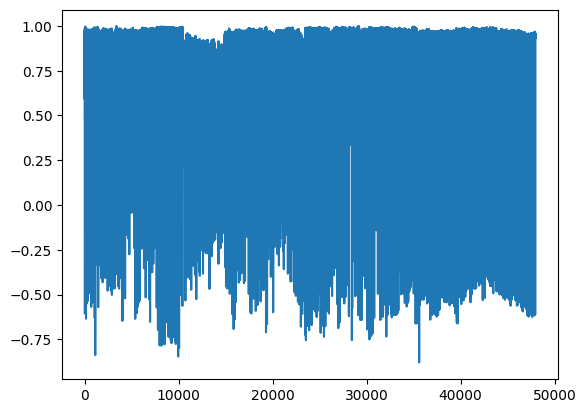

In [35]:

print(np.array(a).mean())
plt.plot(a)

-1.0061396160665481e-16 -7.28583859910259e-17
0.9587404238888363 [0.95874042] 256


(7648, (256, 2))

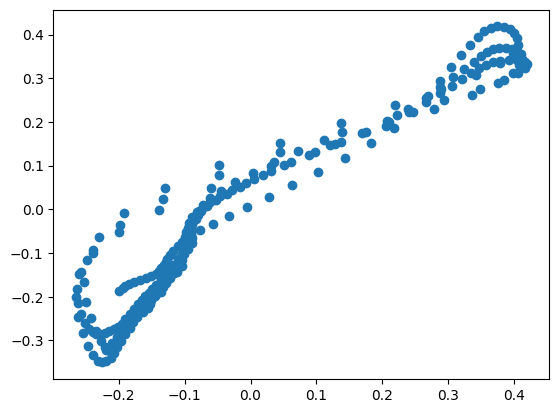

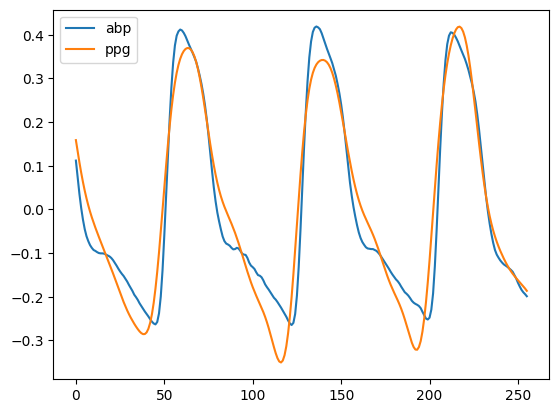

In [44]:
i = np.random.randint(len(sig))
t = sig[i]
# correlation = signal.correlate(t[:,0], t[:,1], mode='full')[t[:,0].size:t[:,0].size+200]
# lags = signal.correlation_lags(t[:,0].size, t[:,1].size, mode="full")[t[:,0].size:t[:,0].size+200]
# lag = lags[np.argmax(correlation)]
# t = t - t.mean(axis=1,keepdims=True)
print(t[:,0].mean(),t[:,1].mean())
correlation = np.correlate(t[:,0], t[:,1], mode='full')
correlation = correlation / (np.linalg.norm(t[:,0], ord=2) *  np.linalg.norm(t[:,1], ord=2))
correlation = correlation
lag = np.argmax(correlation)
print(a[i],npcorr(t),lag)
plt.scatter(t[:,0],t[:,1],label='abp')
plt.figure()
plt.plot(t[:,0],label='abp')
plt.plot(t[:,1],label='ppg')
plt.legend()
i,t.shape

garbage

In [22]:
np.save(OUTPUT_DIR+"\\p00\\scale_train.npy",train_p)
np.save(OUTPUT_DIR+"\\p00\\scale_validate.npy",val_p)
np.save(OUTPUT_DIR+"\\p00\\scale_test.npy",test_p)

In [23]:
def rand_plot(sig,index=None):
    plt.figure()
    if index is None:
        i = np.random.randint(len(sig))
        target = sig[i]
    else:
        i = index[np.random.randint(len(index))]
        target = sig[i]
    print("#",i,target.shape)
    plt.plot(target)

### test

In [3]:
DATA_ROOT = r"../data/raw/BPDataset/p00"
test = np.load(os.path.join(DATA_ROOT,"p00000"+"0","0000000_"+"0001"+".npy")).T
test.shape

(61000, 2)

In [4]:
DATA_DIR = r"..\data\processed\BP_npy\0122\p00\validate.npy"
test = np.load(DATA_DIR)


(256, 2)

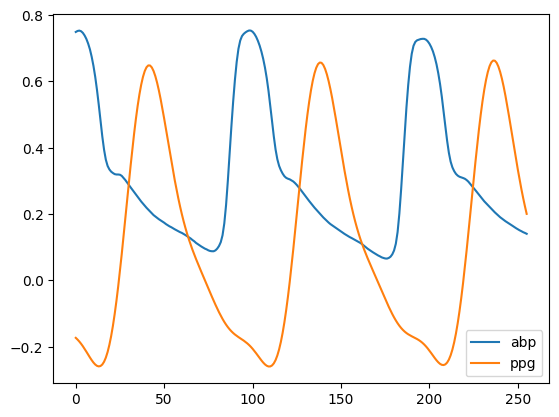

In [13]:
i = np.random.randint(len(test))
t = test[i]
plt.figure()
plt.plot(t[:,0],label='abp')
plt.plot(t[:,1],label='ppg')
plt.legend()
t.shape

In [5]:
rand_plot(test[:,:,1])

NameError: name 'rand_plot' is not defined

In [27]:
a = np.where(min_sig <= 0.001)
aq = test[a]
print(aq.shape)
rand_plot(aq[:,1])

IndexError: index 248495 is out of bounds for axis 0 with size 248495

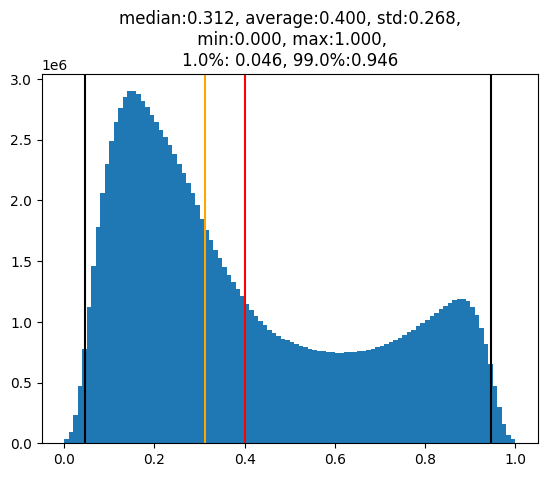

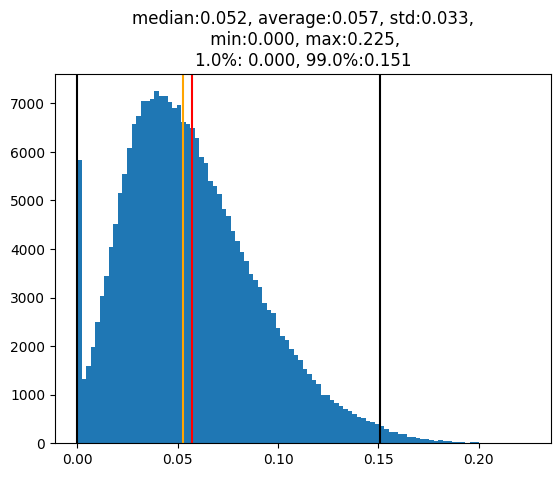

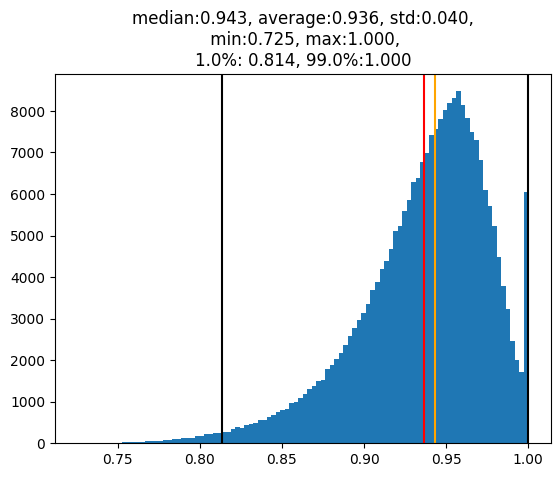

In [ ]:
min_sig = np.nanmin(test[:,:,1],axis=1)
max_sig= np.nanmax(test[:,:,1],axis=1)
plot_hist(test[:,:,1].flatten(),(1,99))
plot_hist(min_sig,(1,99))
plot_hist(max_sig,(1,99))

In [ ]:
siga,start = flat(test,align_signal=True)

aaa 0
0
aaa aaa 0
aaa aaa aaa [   54   119   184   249   312   377   442   507   570   634   698   761
   824   887   950  1014  1077  1139  1202  1266  1329  1392  1455  1519
  1583  1646  1709  1773  1836  1900  1962  2026  2073  2129  2191  2255
  2319  2382  2445  2508  2572  2636  2701  2764  2828  2892  2957  3020
  3084  3149  3214  3278  3341  3406  3471  3537  3584  3640  3705  3768
  3833  3897  3961  4024  4088  4153  4216  4281  4346  4409  4473  4538
  4603  4666  4730  4794  4858  4923  4986  5051  5115  5179  5241  5301
  5364  5428  5491  5554  5618  5681  5745  5808  5872  5936  5999  6063
  6126  6190  6253  6316  6379  6443  6507  6570  6633  6697  6761  6825
  6887  6926  6962  7005  7046  7111  7173  7237  7300  7364  7428  7491
  7555  7619  7684  7748  7812  7877  7942  8008  8072  8138  8204  8269
  8334  8399  8465  8530  8595  8660  8726  8792  8856  8921  8987  9052
  9117  9182  9248  9313  9378  9443  9507  9571  9634  9698  9760  9824
  9888  9952 10016 10

In [ ]:
siga.shape[0]

61000

In [ ]:
np.count_nonzero(np.isnan(siga))

168

In [ ]:
s_test = window(siga,start)

accepted 8
passed 73
passed 138
passed 203
passed 267
passed 332
passed 396
passed 461
accepted 524
passed 588
passed 652
passed 716
passed 779
passed 841
passed 904
passed 968
passed 1031
accepted 1094
passed 1156
passed 1220
passed 1284
passed 1346
passed 1409
passed 1473
passed 1537
passed 1600
nan 1663
nan 1727
nan 1791
nan 1854
nan 1917
nan 1980
nan 2032
accepted 2083
passed 2145
passed 2209
passed 2273
passed 2337
passed 2400
passed 2463
passed 2526
passed 2590
accepted 2655
passed 2718
passed 2782
passed 2846
passed 2911
passed 2975
passed 3038
passed 3103
nan 3167
nan 3233
nan 3296
nan 3360
nan 3425
nan 3491
nan 3543
accepted 3594
passed 3659
passed 3723
passed 3787
passed 3851
passed 3915
passed 3979
passed 4042
accepted 4107
passed 4170
passed 4235
passed 4300
passed 4363
passed 4427
passed 4492
passed 4557
accepted 4621
passed 4684
passed 4748
passed 4813
passed 4878
passed 4940
passed 5005
passed 5069
accepted 5133
passed 5196
passed 5256
passed 5318
passed 5381
passed 5445

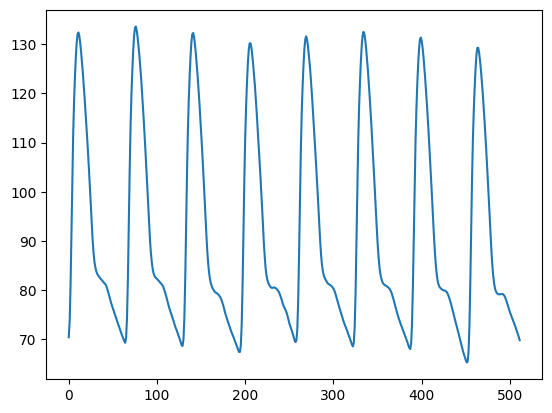

In [ ]:
plt.plot(s_test[0,:,0])